In [1]:
import os, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob

In [2]:
# sns.set(style="ticks", context="talk")
# plt.style.use("dark_background")
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

In [3]:
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import gradient_descent_v2
from tensorflow.keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau

2022-11-24 21:10:28.984076: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.10/site-packages/cv2/../../lib64:
2022-11-24 21:10:28.984101: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
# current working directory from which notebook is located
cur_dir = os.getcwd()
# the data is located in this data_dir
data_dir = os.path.join(cur_dir, 'Olives Dataset')
train_dir = os.path.join(data_dir, 'Train')
test_dir  = os.path.join(data_dir, 'Test')

print("Notebook directory: ", cur_dir)
print("Train directory: ", train_dir)
print("Test directory: ", test_dir)


Notebook directory:  /shared/MLTP/Project 2
Train directory:  /shared/MLTP/Project 2/Olives Dataset/Train
Test directory:  /shared/MLTP/Project 2/Olives Dataset/Test


In [5]:
# Define some global model parameters
IMAGE_WIDTH, IMAGE_HEIGHT = 50, 50
LOSS = 'MSE'
OPTIMIZER = 'adam'#'rmsprop'
ACTIVATION = 'relu'
BATCH_SIZE=25
EPOCHS=15
CLASS_NAMES =['Healthy', 'aculus_olearius', 'olive_peacock_spot']

augment = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                             height_shift_range=0.1, shear_range=0.2, 
                             zoom_range=0.2, horizontal_flip=True, 
                             vertical_flip=True)

test_augmentor = ImageDataGenerator(
    rescale= 1./255
)

In [6]:


train_datagen = ImageDataGenerator(
    rescale= 1./255,
    shear_range= 0.2,
    zoom_range= 0.2,
    horizontal_flip= True
)
test_datagen = ImageDataGenerator(
    rescale= 1./255
)



input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)
train_generator = train_datagen.flow_from_directory(train_dir, target_size= (IMAGE_HEIGHT, IMAGE_WIDTH), batch_size= BATCH_SIZE)
test_generator = test_datagen.flow_from_directory(test_dir,shuffle= True, target_size= (IMAGE_HEIGHT, IMAGE_WIDTH), batch_size= BATCH_SIZE)
validation_generator = train_datagen.flow_from_directory(
                       test_dir,
                       target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                       batch_size=BATCH_SIZE)

Found 2720 images belonging to 3 classes.
Found 680 images belonging to 3 classes.
Found 680 images belonging to 3 classes.


In [47]:
from glob import glob
# Create a dataframe:
# the dataframe stores the path to the image in one column
# and the class of the weed (the target) in the next column

DATA_FOLDER = 'Olives Dataset/Train/'
images_df = []

# Navigate within each folder
for class_folder_name in os.listdir(DATA_FOLDER):
    class_folder_path = os.path.join(DATA_FOLDER, class_folder_name)
    
    # Collect every image path
    for image_path in glob(os.path.join(class_folder_path, "*.*")):
        
        tmp = pd.DataFrame([image_path, class_folder_name]).T
        images_df.append(tmp)

# Concatenate the final df
images_df = pd.concat(images_df, axis=0, ignore_index=True)
images_df.columns = ['image', 'target']
images_df.head(10)

,image,target
0,Olives Dataset/Train/olive_peacock_spot/IMG_20...,olive_peacock_spot
1,Olives Dataset/Train/olive_peacock_spot/IMG_20...,olive_peacock_spot
2,Olives Dataset/Train/olive_peacock_spot/IMG_20...,olive_peacock_spot
3,Olives Dataset/Train/olive_peacock_spot/IMG_20...,olive_peacock_spot
4,Olives Dataset/Train/olive_peacock_spot/IMG_20...,olive_peacock_spot
5,Olives Dataset/Train/olive_peacock_spot/A440.jpg,olive_peacock_spot
6,Olives Dataset/Train/olive_peacock_spot/IMG_20...,olive_peacock_spot
7,Olives Dataset/Train/olive_peacock_spot/IMG_20...,olive_peacock_spot
8,Olives Dataset/Train/olive_peacock_spot/IMG_20...,olive_peacock_spot
9,Olives Dataset/Train/olive_peacock_spot/IMG_20...,olive_peacock_spot


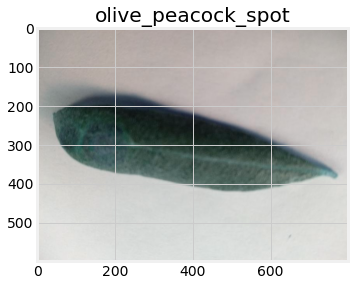

In [48]:
def plot_single_image(df, image_number):
    im = cv2.imread(df.loc[image_number, 'image'])
    plt.title(df.loc[image_number, 'target'])
    plt.imshow(im)
    
plot_single_image(images_df, 0)

In [49]:
# Plot nine images together from same class

def plot_for_class(df, label):
    # function plots 9 images
    nb_rows = 3
    nb_cols = 3
    
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 10))

    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            tmp = df[df['target'] == label ]
            tmp.reset_index(drop=True, inplace=True)
            im = cv2.imread(tmp.loc[n, 'image'])          
            axs[i, j].imshow(im)
            n += 1 

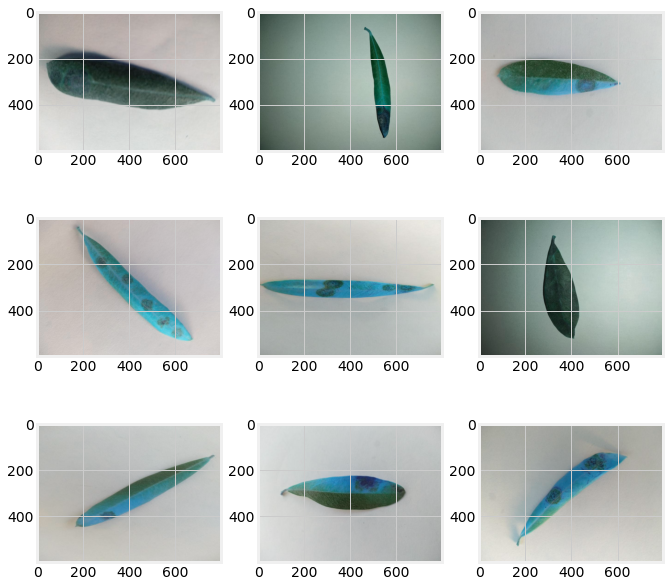

In [50]:
plot_for_class(images_df, 'olive_peacock_spot')

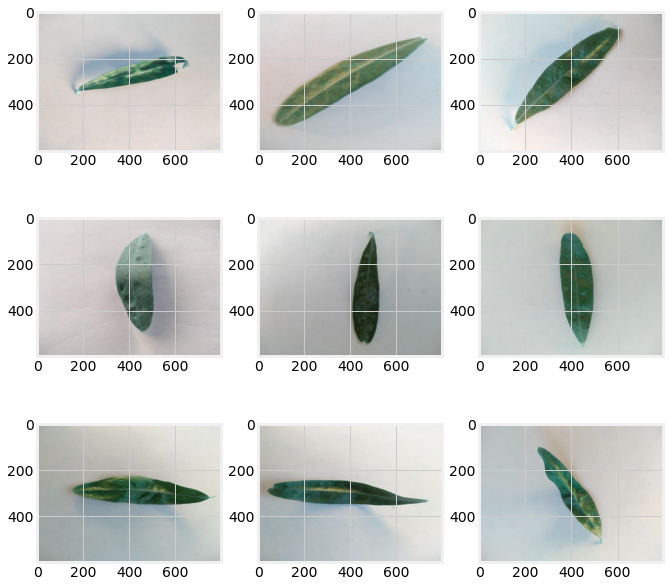

In [51]:
plot_for_class(images_df, 'aculus_olearius')

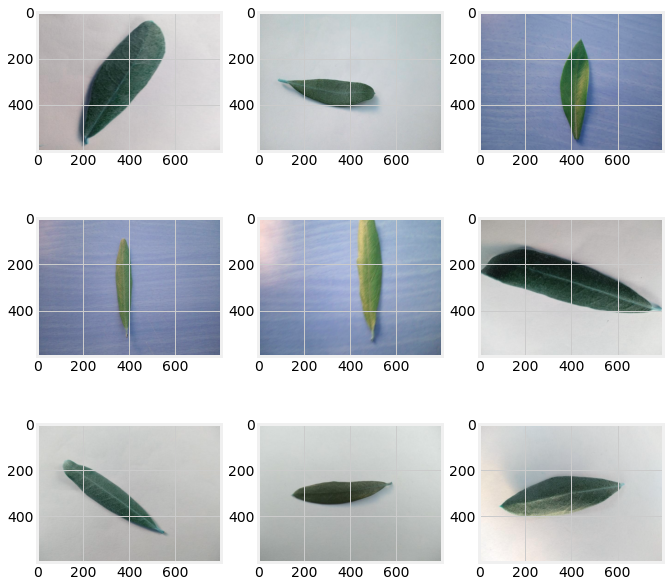

In [52]:
plot_for_class(images_df, 'Healthy')

In [7]:
class Data_Processor(object):
    """
    A class used to load image data from a directory and preprocess the images for use in a Convolutional Neural Network
    ...

    Attributes
    ----------
    directory : str
        The path of the current notebook directory
    train_dir : str
        The path of the current training data directory
    test_dir : str
        The path of the current test data directory
    image_types : str
        List of valid image types to load
    X_train: numpy array
        List of training images by pixel values
    y_train: numpy array
        List of training data catergory labels after one hot encoding
    X_test: numpy array
        List of testing images by pixel values
    y_test: numpy array
        List of testing data catergory labels after one hot encoding

    Returns:
    ----------
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)

    Methods
    -------
    _get_files: 
        Helper function to retun a list of class labels
    DataOverview:
        Prints a summary of number of classes and count of images per class
    chart_classes:
        Plots a bar chart of training class total value counts
    list_files:
        Helper function to Create the tree structure of files in a directory
    list_images:
        return the list  of files that are valid
    load_train_images:
        Function that generates a Tensorflow dataset from the images in the input directory 
        Reads and resizes the images in the training folders. Shuffles the data.
        Onehot encodes y label variables Returns the training images   
    load_test_images:
        Function that generates a Tensorflow dataset from the images in the input directory 
        Reads and resizes the images in the testing folders. Shuffles the data.
        Onehot encodes y label variables Returns the testing images
    """
    def __init__(self):
        """
        Parameters
        ----------
        directory : str
            The path of the current notebook directory
        train_dir : str
             The path of the current training data directory
        test_dir : str
                 The path of the current test data directory
        num_legs : int, optional
            The number of legs the animal (default is 4)
        """
        self.directory = cur_dir
        self.train_dir = train_dir
        self.test_dir = test_dir
        self.image_types = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")
        self.X_train = []
        self.y_train = []
        self.X_test = []
        self.y_test = []
        self.train_data = []
        self.train_labels = []
        
        
    def _get_files(self , target_dir):
        '''Helper function to retun a count of the total class labels'''
        if not os.path.exists(target_dir):
            return 0
        count = 0
        # crawls inside folders
        for current_path, dirs, files in os.walk(target_dir):
            for dr in dirs:
              count += len(glob.glob(os.path.join(current_path, dr+"/*")))
        return count

    def DataOverview(self):
        ''' Prints folder class count and  image count'''
        _samples = self._get_files(self.train_dir)
        # to get tags
        num_classes = len(glob.glob(self.train_dir+"/*"))
        # test file image count
        test_samples = self._get_files(self.test_dir)
        print("\nDataOverview\n------------------")
        print(num_classes, "Classes")
        print(train_samples, "Train images")
        print(test_samples, "Test images")

    def chart_classes(self):
        '''Plots a bar chart of training class counts '''
        image_folder = ['Healthy', 'aculus_olearius', 'olive_peacock_spot']
        nimgs = {}
        for i in image_folder:
            nimages = len(os.listdir(self.train_dir+'/'+i+'/'))
            nimgs[i]=nimages
        plt.figure(figsize=(6, 4))
        plt.bar(range(len(nimgs)), list(nimgs.values()), align='center')
        plt.xticks(range(len(nimgs)), list(nimgs.keys()))
        plt.title('Distribution of different classes of Dataset')
        plt.show()

    def list_files(self, basePath,validExts=None):
        '''Helper function to Create the tree structure of files in a directory'''
        # loop over the directory structure
        for (rootDir, dirNames, filenames) in os.walk(basePath):
            # loop over the filenames in the current directory
            for filename in filenames:
                # determine the file extension of the current file
                ext = filename[filename.rfind("."):].lower()
                # check to see if the file is an image and should be processed
                if validExts is None or ext.endswith(validExts):
                        # construct the path to the image and yield it
                    imagePath = os.path.join(rootDir, filename)
                    yield imagePath

    def list_images(self, basePath):
        '''return the list  of files that are valid'''
        return self.list_files(basePath, validExts=self.image_types)

    def load_train_images(self):
        ''' Function that generates a Tensorflow dataset from the images in the input directory 
            Reads and resizes the images in the training folders. Shuffles the data.
            Onehot encodes y label variables Returns the training images   '''
        imagePaths = sorted(list(self.list_images(self.train_dir)))
        self.train_data = []
        self.train_labels = []
        for imagePath in imagePaths:
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))
            # append the image to the data list
            self.train_data.append(image)
            # extract label from the image path and update the labels list
            label = imagePath.split(os.path.sep)[-2]
            self.train_labels.append(label)
        # Shuffle the Xs and ys together
        self.train_data, self.train_labels = shuffle(self.train_data, self.train_labels, random_state=0)
        
        # normalized each pixel values to the range [0,1]
        self.train_data = np.array(self.train_data, dtype='float')/255
        # convert to ndarray
        self.train_labels = np.array(self.train_labels)
        # encode the target label to number sequence
        self.le = LabelEncoder()
        self.train_labels = self.le.fit_transform(self.train_labels)
        # One-hot-encode the target variable
        self.train_labels = to_categorical(self.train_labels)
        return self.train_data, self.train_labels, self.le

    def load_test_images(self):
        ''' Function that generates a Tensorflow dataset from the images in the input directory 
            Reads and resizes the images in the testing folders. Shuffles the data.
            Onehot encodes y label variables Returns the testing images   '''
        imagePaths = sorted(list(self.list_images(self.test_dir)))
        self.test_data = []
        self.test_labels = []
        for imagePath in imagePaths:
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))
            # append the image to the data list
            self.test_data.append(image)
            # extract label from the image path and update the labels list
            label = imagePath.split(os.path.sep)[-2]
            self.test_labels.append(label)
        # Shuffle the Xs and ys together
        self.test_data, self.test_labels = shuffle(self.test_data, self.test_labels, random_state=0)
        # normalized each pixel values to the range [0,1]
        self.test_data = np.array(self.test_data, dtype='float')/255
        # convert to ndarray
        self.test_labels = np.array(self.test_labels)
        # encode the target label to number sequence
        self.le = LabelEncoder()
        self.test_labels = self.le.fit_transform(self.test_labels)
        # One-hot-encode the target variable
        self.test_labels = to_categorical(self.test_labels)
        return self.test_data, self.test_labels, self.le

   

In [8]:
# Create Data_Processor object
obs = Data_Processor()

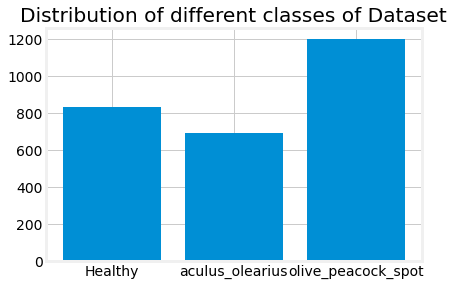

In [53]:
obs.chart_classes()

In [9]:
# Load training images as tensor  
X_train,y_train , le_train= obs.load_train_images()
# Checking data shape
print(X_train.shape)
print(y_train.shape)
print(y_train[0:2])

(2720, 50, 50, 3)
(2720, 3)
[[0. 0. 1.]
 [0. 0. 1.]]


In [10]:
# Load testing images as tensor
X_test, y_test, le_test = obs.load_test_images()
# Checking data shape
print(X_test.shape)
print(y_test.shape)
print(y_test[0:2])

(680, 50, 50, 3)
(680, 3)
[[1. 0. 0.]
 [0. 0. 1.]]


In [11]:
class CNN(object) :
    '''
    A class to define a Keras Convolutional-Neural-Network Model CNN model object
    Model to predict if a leaf is healthy, with Aculus olearius, or with
    Olive peacock spot.
    ...
    Attributes
    ----------
    model : str
        Name of the model.
    history:
        Compiled results
    image_height:int
        Resized image pixel height 
    image_width:int 
        Resized image pixel width  
    X_train: numpy array
        List of training images by pixel values
    y_train: numpy array
        List of training data catergory labels after one hot encoding
    X_test: numpy array
        List of testing images by pixel values
    y_test: numpy array
        List of testing data catergor

    Methods
    ----------
    build_OneLayerVGG:
        Implementation of the One block Model
    build_TwoLayerVGG:
        Build Two Block VGG Model to predict if a leaf is healthy, with Aculus olearius, or with Olive peacock spot
    build_ThreeLayerVGG:
        Builds a Three Block VGG Model to predict if a leaf is healthy, with Aculus olearius, or with Olive  peacock spot.
    train_model:
        Training of the CNN Model
    plot_performance:
        Comparing the accuracy and loss by plotting the graph for training and validation.
    save_model:
         Save the model as an h5 file
    save_model_json_h5:
        serialize model to JSON
    evaluate_model:
        Evaluating model accuracy by using the `evaluate` method
        Compute the prediction loss and accuracy
    predict:
        Predict target values for X

    '''
    def __init__(self,):
        self.model = None
        self.history = None
        self.image_height = IMAGE_HEIGHT
        self.image_width = IMAGE_WIDTH
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.augment = augment

    def build_OneLayerVGG(self):
        ''' Implementation of the One block Model '''
        num_of_classes = self._get_num_of_classes()
        self.model = Sequential()
        self.model.add(Conv2D(96, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(self.image_height,self.image_width,3)))
        self.model.add(MaxPooling2D((2, 2)))
        #self.model.add(Dropout(0.20))
        self.model.add(Flatten())
        self.model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
        self.model.add(Dense(num_of_classes, activation='sigmoid'))
        # compile model
        self.model.compile(optimizer=OPTIMIZER, loss="categorical_crossentropy", metrics=["accuracy"])
        return self.model

    def build_TwoLayerVGG(self):
        ''' Build Two Block VGG Model to predict if a leaf is healthy, with Aculus olearius, or with
            Olive peacock spot.'''
        num_of_classes = self._get_num_of_classes()
        self.model = Sequential()
        self.model.add(Conv2D(96, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(self.image_height,self.image_width,3)))
        self.model.add(MaxPooling2D((2, 2)))
        self.model.add(Dropout(0.20))
        self.model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        self.model.add(MaxPooling2D((2, 2)))
        self.model.add(Dropout(0.20))
        self.model.add(Flatten())
        self.model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
        self.model.add(Dense(num_of_classes, activation='sigmoid'))
        # compile model
        self.model.compile(optimizer=OPTIMIZER, loss="categorical_crossentropy", metrics=["accuracy"])
        return self.model

    def build_ThreeLayerVGG(self):
        ''' Builds a Three Block VGG Model to predict if a leaf is healthy, with Aculus olearius, or with Olive
            peacock spot.'''
        num_of_classes = self._get_num_of_classes()
        self.model = Sequential()
        self.model.add(Conv2D(96, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(self.image_height,self.image_width,3)))
        self.model.add(MaxPooling2D((2, 2)))
        self.model.add(Dropout(0.20))
        
        self.model.add(Conv2D(384, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        self.model.add(MaxPooling2D((2, 2)))
        self.model.add(Dropout(0.20))
        
        self.model.add(Conv2D(384, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        self.model.add(MaxPooling2D((2, 2)))
        self.model.add(Dropout(0.20))
        
        self.model.add(Flatten())
        self.model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
        self.model.add(Dense(num_of_classes, activation='sigmoid'))
        # compile model
        self.model.compile(optimizer=OPTIMIZER, loss="categorical_crossentropy", metrics=["accuracy"])
        return self.model

    def _get_num_of_classes(self):
        return len(os.listdir(train_dir))


    def train_model(self):
        ''' Training of the CNN Model ''' 
        print("[INFO] Training network...")
        self.history = self.model.fit_generator(self.augment.flow(self.X_train, self.y_train, batch_size=BATCH_SIZE),
                              validation_data=(self.X_test, self.y_test),
                              steps_per_epoch=len(self.X_train) // BATCH_SIZE,
                                                epochs=EPOCHS, verbose=1, shuffle=True, use_multiprocessing=True,
                                #callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)],
                                                )
        return self.history

    def train_BOSS(self):
        print("[INFO] Training network...")
        self.history = self.model.fit(train_generator,steps_per_epoch = None,epochs = EPOCHS, validation_data= validation_generator, validation_steps= None, verbose= 1, callbacks = [ReduceLROnPlateau(monitor= 'val_loss', factor= 0.3, patience= 3, min_lr= 0.000001)], shuffle= True)
        return self.history

    def plot_performance(self, ylim_pad=[0, 0]):
        '''Comparing the accuracy and loss by plotting the graph for training and validation.'''
        xlabel = 'Epoch'
        legends = ['Training', 'Validation']
        plt.figure(figsize=(12, 5))
        y1 = self.history.history['accuracy']
        y2 = self.history.history['val_accuracy']
        min_y = min(min(y1), min(y2))-ylim_pad[0]
        max_y = max(max(y1), max(y2))+ylim_pad[0]
        plt.subplot(121)
        plt.plot(y1)
        plt.plot(y2)
        plt.title('Model Accuracy', fontsize=17)
        plt.xlabel(xlabel, fontsize=15)
        plt.ylabel('Accuracy', fontsize=15)
        plt.ylim(min_y, max_y)
        plt.legend(legends, loc='upper right')
        y1 = self.history.history['loss']
        y2 = self.history.history['val_loss']
        min_y = min(min(y1), min(y2))-ylim_pad[1]
        max_y = max(max(y1), max(y2))+ylim_pad[1]
        plt.subplot(122)
        plt.plot(y1)
        plt.plot(y2)
        plt.title('Model Loss', fontsize=17)
        plt.xlabel(xlabel, fontsize=15)
        plt.ylabel('Loss', fontsize=15)
        plt.ylim(min_y, max_y)
        plt.legend(legends, loc='upper right')
        plt.show()

    def save_model(self, file_name):
        ''' Save the model as an h5 file'''
        self.model.save(file_name + ".h5", overwrite=True)
        #self.model.save( os.path.join(path, "model.h5") )
        print("Saved model to disk")

    def save_model_json_h5(self):
        ''' serialize model to JSON'''
        model_json = self.model.to_json()
        with open("model.json", "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        self.model.save_weights("model.h5")
        print("Saved model to disk")
    

    def getSummary(self):
        self.model.summary()

    def evaluate_model(self):
        '''Evaluating model accuracy by using the `evaluate` method
           Compute the prediction loss and accuracy 
        Parameters
        ----------
        X : Testing vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : Target values (true class labels).
        Returns
        ---------
        accuracy : float
            The prediction accuracy as a float
            between 0.0 and 1.0 (perfect score).
        loss : float
            The prediction loss value as a float
        '''
        if len(self.model.layers) == 0:
            print("The model hasn't been built.")
            return
        loss, accuracy = self.model.evaluate(self.X_test,self.y_test)
        print("\nTest Data Results\n------------------")
        print("Test Loss: %.2f%%" % (loss * 100))
        print("Test Accuracy: %.2f%%" % (accuracy * 100))
        return loss, accuracy   

    def tr_plot(self, tr_data, start_epoch):
        '''Plot the training and validation data'''
        tacc=tr_data.history['accuracy']
        tloss=tr_data.history['loss']
        vacc=tr_data.history['val_accuracy']
        vloss=tr_data.history['val_loss']
        Epoch_count=len(tacc)+ start_epoch
        Epochs=[]
        for i in range (start_epoch ,Epoch_count):
            Epochs.append(i+1)   
        index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
        val_lowest=vloss[index_loss]
        index_acc=np.argmax(vacc)
        acc_highest=vacc[index_acc]
        plt.style.use('fivethirtyeight')
        sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
        vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
        fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(12,5))
        axes[0].plot(Epochs,tloss, 'r', label='Training loss')
        axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
        axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
        axes[0].set_title('Training and Validation Loss')
        axes[0].set_xlabel('Epochs')
        axes[0].set_ylabel('Loss')
        axes[0].legend()
        axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
        axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
        axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
        axes[1].set_title('Training and Validation Accuracy')
        axes[1].set_xlabel('Epochs')
        axes[1].set_ylabel('Accuracy')
        axes[1].legend()
        plt.rcParams['axes.facecolor'] = 'white'
        plt.rcParams['figure.facecolor'] = 'white'
        plt.tight_layout
        plt.show()

    def makepredict(self):
        prediction = self.model.predict(self.X_test)
        print(prediction)
        #label = self.objectMachine.getArrayLabelClass()
        #result = {}
        #for i in range (len(prediction[0])):
        #    result[label[i]] = float(prediction[0][i])
        return prediction

    def predict(self, testvar):
        '''Predict target values for X'''
        predictions = self.model.predict(testvar, verbose=1)
        return predictions

# One Block VGG Model

In [12]:
OneLayerVGG = CNN()

In [13]:
OneLayerVGG.build_OneLayerVGG()

2022-11-24 21:10:45.994944: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.10/site-packages/cv2/../../lib64:
2022-11-24 21:10:45.994980: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-24 21:10:45.995007: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (28d6a4494fed): /proc/driver/nvidia/version does not exist
2022-11-24 21:10:45.995255: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
history1=OneLayerVGG.train_model()


[INFO] Training network...


/tmp/ipykernel_3369/2711259985.py:123: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.history = self.model.fit_generator(self.augment.flow(self.X_train, self.y_train, batch_size=BATCH_SIZE),


Epoch 1/15


  1/108 [..............................] - ETA: 1:06 - loss: 1.7027 - accuracy: 0.2800

  2/108 [..............................] - ETA: 7s - loss: 29.3187 - accuracy: 0.3200 

  3/108 [..............................] - ETA: 7s - loss: 27.3567 - accuracy: 0.3867

  4/108 [>.............................] - ETA: 7s - loss: 26.5539 - accuracy: 0.3700

  5/108 [>.............................] - ETA: 7s - loss: 22.2514 - accuracy: 0.3680

  6/108 [>.............................] - ETA: 6s - loss: 21.7321 - accuracy: 0.3733

  7/108 [>.............................] - ETA: 6s - loss: 20.7146 - accuracy: 0.3714

  8/108 [=>............................] - ETA: 6s - loss: 19.3512 - accuracy: 0.3700

  9/108 [=>............................] - ETA: 6s - loss: 19.0644 - accuracy: 0.3689

 10/108 [=>............................] - ETA: 6s - loss: 19.1542 - accuracy: 0.3680

 11/108 [==>...........................] - ETA: 6s - loss: 19.0613 - accuracy: 0.3600

 12/108 [==>...........................] - ETA: 6s - loss: 18.8533 - accuracy: 0.3467

 13/108 [==>...........................] - ETA: 5s - loss: 18.1521 - accuracy: 0.3477

 14/108 [==>...........................] - ETA: 5s - loss: 17.3225 - accuracy: 0.3371

 15/108 [===>..........................] - ETA: 5s - loss: 16.3565 - accuracy: 0.3413

 16/108 [===>..........................] - ETA: 5s - loss: 15.6983 - accuracy: 0.3475

 17/108 [===>..........................] - ETA: 5s - loss: 15.0237 - accuracy: 0.3600

 18/108 [====>.........................] - ETA: 5s - loss: 14.4217 - accuracy: 0.3600

 19/108 [====>.........................] - ETA: 5s - loss: 13.9518 - accuracy: 0.3579

 20/108 [====>.........................] - ETA: 5s - loss: 13.6825 - accuracy: 0.3440

 21/108 [====>.........................] - ETA: 5s - loss: 13.1105 - accuracy: 0.3505

 22/108 [=====>........................] - ETA: 5s - loss: 12.7324 - accuracy: 0.3509

 23/108 [=====>........................] - ETA: 5s - loss: 12.4062 - accuracy: 0.3513

 24/108 [=====>........................] - ETA: 5s - loss: 12.0870 - accuracy: 0.3500

 25/108 [=====>........................] - ETA: 4s - loss: 11.8244 - accuracy: 0.3424

 26/108 [======>.......................] - ETA: 4s - loss: 11.5287 - accuracy: 0.3415

 27/108 [======>.......................] - ETA: 4s - loss: 11.2046 - accuracy: 0.3378

 28/108 [======>.......................] - ETA: 4s - loss: 10.8380 - accuracy: 0.3500

 29/108 [=======>......................] - ETA: 4s - loss: 10.5393 - accuracy: 0.3503

 30/108 [=======>......................] - ETA: 4s - loss: 10.3005 - accuracy: 0.3493

 32/108 [=======>......................] - ETA: 4s - loss: 9.7927 - accuracy: 0.3713 

 33/108 [========>.....................] - ETA: 4s - loss: 9.5998 - accuracy: 0.3782

 34/108 [========>.....................] - ETA: 4s - loss: 9.4239 - accuracy: 0.3835

 35/108 [========>.....................] - ETA: 4s - loss: 9.2159 - accuracy: 0.3863

 36/108 [=========>....................] - ETA: 4s - loss: 9.0261 - accuracy: 0.3867

 37/108 [=========>....................] - ETA: 4s - loss: 8.8571 - accuracy: 0.3838

 38/108 [=========>....................] - ETA: 4s - loss: 8.6570 - accuracy: 0.3884

 39/108 [=========>....................] - ETA: 3s - loss: 8.4643 - accuracy: 0.3877

 40/108 [==========>...................] - ETA: 3s - loss: 8.3019 - accuracy: 0.3880

 41/108 [==========>...................] - ETA: 3s - loss: 8.1795 - accuracy: 0.3844

 42/108 [==========>...................] - ETA: 3s - loss: 8.0499 - accuracy: 0.3790

 43/108 [==========>...................] - ETA: 3s - loss: 7.8890 - accuracy: 0.3823

 44/108 [===========>..................] - ETA: 3s - loss: 7.7293 - accuracy: 0.3882

 45/108 [===========>..................] - ETA: 3s - loss: 7.5985 - accuracy: 0.3893

 46/108 [===========>..................] - ETA: 3s - loss: 7.4719 - accuracy: 0.3939

 47/108 [============>.................] - ETA: 3s - loss: 7.3637 - accuracy: 0.3940

 48/108 [============>.................] - ETA: 3s - loss: 7.2930 - accuracy: 0.3975

 49/108 [============>.................] - ETA: 3s - loss: 7.1952 - accuracy: 0.3967

 50/108 [============>.................] - ETA: 3s - loss: 7.0835 - accuracy: 0.4016

 51/108 [=============>................] - ETA: 3s - loss: 6.9802 - accuracy: 0.4016

 52/108 [=============>................] - ETA: 3s - loss: 6.8667 - accuracy: 0.4046

 53/108 [=============>................] - ETA: 3s - loss: 6.7546 - accuracy: 0.4053

 54/108 [==============>...............] - ETA: 3s - loss: 6.6559 - accuracy: 0.4067

 55/108 [==============>...............] - ETA: 3s - loss: 6.5737 - accuracy: 0.4065

 56/108 [==============>...............] - ETA: 2s - loss: 6.4898 - accuracy: 0.4057

 57/108 [==============>...............] - ETA: 2s - loss: 6.3948 - accuracy: 0.4070

 58/108 [===============>..............] - ETA: 2s - loss: 6.3055 - accuracy: 0.4097

 59/108 [===============>..............] - ETA: 2s - loss: 6.2142 - accuracy: 0.4156

 60/108 [===============>..............] - ETA: 2s - loss: 6.1357 - accuracy: 0.4173

 61/108 [===============>..............] - ETA: 2s - loss: 6.0570 - accuracy: 0.4184

 63/108 [================>.............] - ETA: 2s - loss: 5.9272 - accuracy: 0.4191

 64/108 [================>.............] - ETA: 2s - loss: 5.8541 - accuracy: 0.4226

 65/108 [=================>............] - ETA: 2s - loss: 5.7817 - accuracy: 0.4235

 66/108 [=================>............] - ETA: 2s - loss: 5.7128 - accuracy: 0.4219

 67/108 [=================>............] - ETA: 2s - loss: 5.6614 - accuracy: 0.4192

 68/108 [=================>............] - ETA: 2s - loss: 5.5946 - accuracy: 0.4206

 69/108 [==================>...........] - ETA: 2s - loss: 5.5243 - accuracy: 0.4238

 70/108 [==================>...........] - ETA: 2s - loss: 5.4609 - accuracy: 0.4241

 71/108 [==================>...........] - ETA: 2s - loss: 5.4196 - accuracy: 0.4243

 72/108 [===================>..........] - ETA: 2s - loss: 5.3609 - accuracy: 0.4245

 73/108 [===================>..........] - ETA: 1s - loss: 5.2994 - accuracy: 0.4280

 74/108 [===================>..........] - ETA: 1s - loss: 5.2506 - accuracy: 0.4276

 75/108 [===================>..........] - ETA: 1s - loss: 5.1958 - accuracy: 0.4299

 76/108 [====================>.........] - ETA: 1s - loss: 5.1416 - accuracy: 0.4296

 77/108 [====================>.........] - ETA: 1s - loss: 5.0870 - accuracy: 0.4318

 78/108 [====================>.........] - ETA: 1s - loss: 5.0323 - accuracy: 0.4339

 79/108 [====================>.........] - ETA: 1s - loss: 4.9867 - accuracy: 0.4340

 80/108 [=====================>........] - ETA: 1s - loss: 4.9341 - accuracy: 0.4371

 81/108 [=====================>........] - ETA: 1s - loss: 4.8826 - accuracy: 0.4396

 82/108 [=====================>........] - ETA: 1s - loss: 4.8333 - accuracy: 0.4411

 83/108 [======================>.......] - ETA: 1s - loss: 4.7841 - accuracy: 0.4430

 84/108 [======================>.......] - ETA: 1s - loss: 4.7358 - accuracy: 0.4453

 85/108 [======================>.......] - ETA: 1s - loss: 4.6916 - accuracy: 0.4462

 86/108 [======================>.......] - ETA: 1s - loss: 4.6481 - accuracy: 0.4476

 87/108 [=======================>......] - ETA: 1s - loss: 4.6046 - accuracy: 0.4488

 88/108 [=======================>......] - ETA: 1s - loss: 4.5605 - accuracy: 0.4519

 89/108 [=======================>......] - ETA: 1s - loss: 4.5176 - accuracy: 0.4554

 90/108 [========================>.....] - ETA: 1s - loss: 4.4757 - accuracy: 0.4588

 91/108 [========================>.....] - ETA: 0s - loss: 4.4356 - accuracy: 0.4608

 92/108 [========================>.....] - ETA: 0s - loss: 4.3972 - accuracy: 0.4619

 93/108 [========================>.....] - ETA: 0s - loss: 4.3620 - accuracy: 0.4616

 94/108 [=========================>....] - ETA: 0s - loss: 4.3206 - accuracy: 0.4661

 95/108 [=========================>....] - ETA: 0s - loss: 4.2824 - accuracy: 0.4684

 96/108 [=========================>....] - ETA: 0s - loss: 4.2446 - accuracy: 0.4706

 97/108 [=========================>....] - ETA: 0s - loss: 4.2095 - accuracy: 0.4715

 98/108 [==========================>...] - ETA: 0s - loss: 4.1745 - accuracy: 0.4736

100/108 [==========================>...] - ETA: 0s - loss: 4.1089 - accuracy: 0.4749

101/108 [===========================>..] - ETA: 0s - loss: 4.0766 - accuracy: 0.4766

102/108 [===========================>..] - ETA: 0s - loss: 4.0445 - accuracy: 0.4778

104/108 [===========================>..] - ETA: 0s - loss: 3.9870 - accuracy: 0.4790

106/108 [============================>.] - ETA: 0s - loss: 3.9335 - accuracy: 0.4783

108/108 [==============================] - ETA: 0s - loss: 3.8838 - accuracy: 0.4787

108/108 [==============================] - 7s 61ms/step - loss: 3.8838 - accuracy: 0.4787 - val_loss: 1.1392 - val_accuracy: 0.4515


Epoch 2/15


  1/108 [..............................] - ETA: 23s - loss: 0.9235 - accuracy: 0.5600

  2/108 [..............................] - ETA: 10s - loss: 0.7502 - accuracy: 0.6800

  3/108 [..............................] - ETA: 10s - loss: 0.8339 - accuracy: 0.6133

  4/108 [>.............................] - ETA: 9s - loss: 0.8228 - accuracy: 0.5900 

  5/108 [>.............................] - ETA: 8s - loss: 0.8265 - accuracy: 0.6000

  6/108 [>.............................] - ETA: 8s - loss: 0.8684 - accuracy: 0.5867

  7/108 [>.............................] - ETA: 7s - loss: 0.8491 - accuracy: 0.5943

  8/108 [=>............................] - ETA: 7s - loss: 0.8737 - accuracy: 0.6050

  9/108 [=>............................] - ETA: 7s - loss: 0.8904 - accuracy: 0.6222

 10/108 [=>............................] - ETA: 6s - loss: 0.9284 - accuracy: 0.6160

 11/108 [==>...........................] - ETA: 6s - loss: 0.9292 - accuracy: 0.6036

 12/108 [==>...........................] - ETA: 6s - loss: 0.9652 - accuracy: 0.5867

 13/108 [==>...........................] - ETA: 6s - loss: 0.9451 - accuracy: 0.5908

 14/108 [==>...........................] - ETA: 6s - loss: 0.9557 - accuracy: 0.5914

 15/108 [===>..........................] - ETA: 6s - loss: 0.9623 - accuracy: 0.5867

 16/108 [===>..........................] - ETA: 5s - loss: 0.9736 - accuracy: 0.5850

 17/108 [===>..........................] - ETA: 5s - loss: 0.9847 - accuracy: 0.5835

 18/108 [====>.........................] - ETA: 5s - loss: 0.9813 - accuracy: 0.5822

 19/108 [====>.........................] - ETA: 5s - loss: 0.9653 - accuracy: 0.5895

 20/108 [====>.........................] - ETA: 5s - loss: 0.9698 - accuracy: 0.5860

 21/108 [====>.........................] - ETA: 5s - loss: 0.9614 - accuracy: 0.5905

 22/108 [=====>........................] - ETA: 5s - loss: 0.9460 - accuracy: 0.5927

 23/108 [=====>........................] - ETA: 5s - loss: 0.9461 - accuracy: 0.5913

 24/108 [=====>........................] - ETA: 5s - loss: 0.9350 - accuracy: 0.5967

 25/108 [=====>........................] - ETA: 5s - loss: 0.9262 - accuracy: 0.6000

 26/108 [======>.......................] - ETA: 5s - loss: 0.9299 - accuracy: 0.5969

 27/108 [======>.......................] - ETA: 5s - loss: 0.9209 - accuracy: 0.6000

 28/108 [======>.......................] - ETA: 4s - loss: 0.9227 - accuracy: 0.5943

 29/108 [=======>......................] - ETA: 4s - loss: 0.9279 - accuracy: 0.5917

 30/108 [=======>......................] - ETA: 4s - loss: 0.9237 - accuracy: 0.5907

 31/108 [=======>......................] - ETA: 4s - loss: 0.9270 - accuracy: 0.5897

 32/108 [=======>......................] - ETA: 4s - loss: 0.9229 - accuracy: 0.5900

 33/108 [========>.....................] - ETA: 4s - loss: 0.9131 - accuracy: 0.5952

 34/108 [========>.....................] - ETA: 4s - loss: 0.9134 - accuracy: 0.5929

 35/108 [========>.....................] - ETA: 4s - loss: 0.9177 - accuracy: 0.5897

 36/108 [=========>....................] - ETA: 4s - loss: 0.9161 - accuracy: 0.5922

 37/108 [=========>....................] - ETA: 4s - loss: 0.9153 - accuracy: 0.5903

 38/108 [=========>....................] - ETA: 4s - loss: 0.9124 - accuracy: 0.5926

 39/108 [=========>....................] - ETA: 4s - loss: 0.9073 - accuracy: 0.5959

 40/108 [==========>...................] - ETA: 4s - loss: 0.9031 - accuracy: 0.5970

 41/108 [==========>...................] - ETA: 4s - loss: 0.8987 - accuracy: 0.6000

 42/108 [==========>...................] - ETA: 3s - loss: 0.8897 - accuracy: 0.6038

 44/108 [===========>..................] - ETA: 3s - loss: 0.8816 - accuracy: 0.6073

 45/108 [===========>..................] - ETA: 3s - loss: 0.8822 - accuracy: 0.6062

 46/108 [===========>..................] - ETA: 3s - loss: 0.8794 - accuracy: 0.6061

 47/108 [============>.................] - ETA: 3s - loss: 0.8948 - accuracy: 0.6034

 48/108 [============>.................] - ETA: 3s - loss: 0.8932 - accuracy: 0.6033

 49/108 [============>.................] - ETA: 3s - loss: 0.8940 - accuracy: 0.6033

 50/108 [============>.................] - ETA: 3s - loss: 0.8923 - accuracy: 0.6040

 51/108 [=============>................] - ETA: 3s - loss: 0.8876 - accuracy: 0.6047

 52/108 [=============>................] - ETA: 3s - loss: 0.8906 - accuracy: 0.6046

 53/108 [=============>................] - ETA: 3s - loss: 0.8863 - accuracy: 0.6075

 54/108 [==============>...............] - ETA: 3s - loss: 0.8842 - accuracy: 0.6074

 55/108 [==============>...............] - ETA: 3s - loss: 0.8786 - accuracy: 0.6109

 56/108 [==============>...............] - ETA: 3s - loss: 0.8765 - accuracy: 0.6114

 57/108 [==============>...............] - ETA: 2s - loss: 0.8743 - accuracy: 0.6126

 58/108 [===============>..............] - ETA: 2s - loss: 0.8747 - accuracy: 0.6131

 59/108 [===============>..............] - ETA: 2s - loss: 0.8767 - accuracy: 0.6108

 60/108 [===============>..............] - ETA: 2s - loss: 0.8736 - accuracy: 0.6133

 61/108 [===============>..............] - ETA: 2s - loss: 0.8700 - accuracy: 0.6151

 62/108 [================>.............] - ETA: 2s - loss: 0.8655 - accuracy: 0.6181

 63/108 [================>.............] - ETA: 2s - loss: 0.8619 - accuracy: 0.6203

 64/108 [================>.............] - ETA: 2s - loss: 0.8618 - accuracy: 0.6194

 65/108 [=================>............] - ETA: 2s - loss: 0.8610 - accuracy: 0.6197

 66/108 [=================>............] - ETA: 2s - loss: 0.8593 - accuracy: 0.6206

 67/108 [=================>............] - ETA: 2s - loss: 0.8604 - accuracy: 0.6209

 68/108 [=================>............] - ETA: 2s - loss: 0.8584 - accuracy: 0.6212

 69/108 [==================>...........] - ETA: 2s - loss: 0.8614 - accuracy: 0.6209

 70/108 [==================>...........] - ETA: 2s - loss: 0.8605 - accuracy: 0.6206

 71/108 [==================>...........] - ETA: 2s - loss: 0.8596 - accuracy: 0.6225

 72/108 [===================>..........] - ETA: 2s - loss: 0.8603 - accuracy: 0.6206

 73/108 [===================>..........] - ETA: 2s - loss: 0.8593 - accuracy: 0.6208

 74/108 [===================>..........] - ETA: 1s - loss: 0.8597 - accuracy: 0.6189

 75/108 [===================>..........] - ETA: 1s - loss: 0.8590 - accuracy: 0.6203

 76/108 [====================>.........] - ETA: 1s - loss: 0.8587 - accuracy: 0.6200

 77/108 [====================>.........] - ETA: 1s - loss: 0.8573 - accuracy: 0.6208

 78/108 [====================>.........] - ETA: 1s - loss: 0.8550 - accuracy: 0.6221

 79/108 [====================>.........] - ETA: 1s - loss: 0.8568 - accuracy: 0.6228

 80/108 [=====================>........] - ETA: 1s - loss: 0.8544 - accuracy: 0.6225

 81/108 [=====================>........] - ETA: 1s - loss: 0.8563 - accuracy: 0.6212

 82/108 [=====================>........] - ETA: 1s - loss: 0.8562 - accuracy: 0.6224

 83/108 [======================>.......] - ETA: 1s - loss: 0.8529 - accuracy: 0.6227

 84/108 [======================>.......] - ETA: 1s - loss: 0.8549 - accuracy: 0.6219

 85/108 [======================>.......] - ETA: 1s - loss: 0.8503 - accuracy: 0.6245

 86/108 [======================>.......] - ETA: 1s - loss: 0.8497 - accuracy: 0.6247

 87/108 [=======================>......] - ETA: 1s - loss: 0.8494 - accuracy: 0.6253

 89/108 [=======================>......] - ETA: 1s - loss: 0.8467 - accuracy: 0.6279

 90/108 [========================>.....] - ETA: 1s - loss: 0.8477 - accuracy: 0.6276

 91/108 [========================>.....] - ETA: 0s - loss: 0.8467 - accuracy: 0.6291

 92/108 [========================>.....] - ETA: 0s - loss: 0.8490 - accuracy: 0.6283

 93/108 [========================>.....] - ETA: 0s - loss: 0.8486 - accuracy: 0.6280

 94/108 [=========================>....] - ETA: 0s - loss: 0.8555 - accuracy: 0.6260

 95/108 [=========================>....] - ETA: 0s - loss: 0.8548 - accuracy: 0.6257

 96/108 [=========================>....] - ETA: 0s - loss: 0.8541 - accuracy: 0.6263

 97/108 [=========================>....] - ETA: 0s - loss: 0.8558 - accuracy: 0.6256

 98/108 [==========================>...] - ETA: 0s - loss: 0.8517 - accuracy: 0.6266

100/108 [==========================>...] - ETA: 0s - loss: 0.8484 - accuracy: 0.6289

102/108 [===========================>..] - ETA: 0s - loss: 0.8456 - accuracy: 0.6299

104/108 [===========================>..] - ETA: 0s - loss: 0.8420 - accuracy: 0.6312

105/108 [============================>.] - ETA: 0s - loss: 0.8439 - accuracy: 0.6294

106/108 [============================>.] - ETA: 0s - loss: 0.8425 - accuracy: 0.6299

108/108 [==============================] - ETA: 0s - loss: 0.8382 - accuracy: 0.6315

108/108 [==============================] - 7s 60ms/step - loss: 0.8382 - accuracy: 0.6315 - val_loss: 0.8978 - val_accuracy: 0.5574


Epoch 3/15


  1/108 [..............................] - ETA: 21s - loss: 0.7065 - accuracy: 0.7200

  2/108 [..............................] - ETA: 9s - loss: 0.6642 - accuracy: 0.7200 

  3/108 [..............................] - ETA: 11s - loss: 0.7229 - accuracy: 0.6533

  4/108 [>.............................] - ETA: 11s - loss: 0.7126 - accuracy: 0.6700

  5/108 [>.............................] - ETA: 9s - loss: 0.7287 - accuracy: 0.6560 

  6/108 [>.............................] - ETA: 8s - loss: 0.7185 - accuracy: 0.6533

  7/108 [>.............................] - ETA: 8s - loss: 0.7086 - accuracy: 0.6629

  8/108 [=>............................] - ETA: 7s - loss: 0.6989 - accuracy: 0.6700

  9/108 [=>............................] - ETA: 7s - loss: 0.7064 - accuracy: 0.6622

 10/108 [=>............................] - ETA: 7s - loss: 0.7153 - accuracy: 0.6680

 11/108 [==>...........................] - ETA: 7s - loss: 0.7261 - accuracy: 0.6691

 12/108 [==>...........................] - ETA: 6s - loss: 0.7176 - accuracy: 0.6733

 13/108 [==>...........................] - ETA: 6s - loss: 0.7041 - accuracy: 0.6831

 14/108 [==>...........................] - ETA: 6s - loss: 0.7017 - accuracy: 0.6886

 15/108 [===>..........................] - ETA: 6s - loss: 0.7210 - accuracy: 0.6747

 16/108 [===>..........................] - ETA: 6s - loss: 0.7023 - accuracy: 0.6875

 17/108 [===>..........................] - ETA: 6s - loss: 0.7077 - accuracy: 0.6800

 18/108 [====>.........................] - ETA: 6s - loss: 0.7114 - accuracy: 0.6822

 19/108 [====>.........................] - ETA: 6s - loss: 0.7174 - accuracy: 0.6863

 20/108 [====>.........................] - ETA: 6s - loss: 0.7449 - accuracy: 0.6780

 21/108 [====>.........................] - ETA: 6s - loss: 0.7441 - accuracy: 0.6800

 22/108 [=====>........................] - ETA: 5s - loss: 0.7524 - accuracy: 0.6818

 23/108 [=====>........................] - ETA: 5s - loss: 0.7703 - accuracy: 0.6730

 24/108 [=====>........................] - ETA: 5s - loss: 0.7686 - accuracy: 0.6717

 25/108 [=====>........................] - ETA: 5s - loss: 0.8136 - accuracy: 0.6656

 26/108 [======>.......................] - ETA: 5s - loss: 0.8274 - accuracy: 0.6585

 27/108 [======>.......................] - ETA: 5s - loss: 0.8212 - accuracy: 0.6622

 28/108 [======>.......................] - ETA: 5s - loss: 0.8214 - accuracy: 0.6614

 29/108 [=======>......................] - ETA: 5s - loss: 0.8241 - accuracy: 0.6593

 30/108 [=======>......................] - ETA: 5s - loss: 0.8184 - accuracy: 0.6613

 31/108 [=======>......................] - ETA: 5s - loss: 0.8136 - accuracy: 0.6606

 32/108 [=======>......................] - ETA: 4s - loss: 0.8031 - accuracy: 0.6650

 33/108 [========>.....................] - ETA: 4s - loss: 0.7992 - accuracy: 0.6642

 34/108 [========>.....................] - ETA: 4s - loss: 0.7972 - accuracy: 0.6647

 35/108 [========>.....................] - ETA: 4s - loss: 0.7954 - accuracy: 0.6640

 36/108 [=========>....................] - ETA: 4s - loss: 0.7964 - accuracy: 0.6622

 37/108 [=========>....................] - ETA: 4s - loss: 0.7956 - accuracy: 0.6649

 38/108 [=========>....................] - ETA: 4s - loss: 0.8922 - accuracy: 0.6589

 39/108 [=========>....................] - ETA: 4s - loss: 0.8876 - accuracy: 0.6585

 40/108 [==========>...................] - ETA: 4s - loss: 0.8899 - accuracy: 0.6580

 41/108 [==========>...................] - ETA: 4s - loss: 0.8965 - accuracy: 0.6576

 42/108 [==========>...................] - ETA: 4s - loss: 0.8914 - accuracy: 0.6581

 43/108 [==========>...................] - ETA: 4s - loss: 0.8861 - accuracy: 0.6605

 44/108 [===========>..................] - ETA: 4s - loss: 0.8919 - accuracy: 0.6591

 45/108 [===========>..................] - ETA: 3s - loss: 0.8955 - accuracy: 0.6560

 46/108 [===========>..................] - ETA: 3s - loss: 0.8900 - accuracy: 0.6583

 47/108 [============>.................] - ETA: 3s - loss: 0.8932 - accuracy: 0.6579

 48/108 [============>.................] - ETA: 3s - loss: 0.8890 - accuracy: 0.6592

 49/108 [============>.................] - ETA: 3s - loss: 0.8895 - accuracy: 0.6588

 50/108 [============>.................] - ETA: 3s - loss: 0.8994 - accuracy: 0.6552

 51/108 [=============>................] - ETA: 3s - loss: 0.8949 - accuracy: 0.6557

 52/108 [=============>................] - ETA: 3s - loss: 0.8911 - accuracy: 0.6546

 53/108 [=============>................] - ETA: 3s - loss: 0.8907 - accuracy: 0.6551

 54/108 [==============>...............] - ETA: 3s - loss: 0.8886 - accuracy: 0.6570

 55/108 [==============>...............] - ETA: 3s - loss: 0.8812 - accuracy: 0.6596

 56/108 [==============>...............] - ETA: 3s - loss: 0.8777 - accuracy: 0.6593

 57/108 [==============>...............] - ETA: 3s - loss: 0.8733 - accuracy: 0.6596

 58/108 [===============>..............] - ETA: 3s - loss: 0.8738 - accuracy: 0.6600

 59/108 [===============>..............] - ETA: 3s - loss: 0.8699 - accuracy: 0.6610

 60/108 [===============>..............] - ETA: 2s - loss: 0.8645 - accuracy: 0.6647

 61/108 [===============>..............] - ETA: 2s - loss: 0.8715 - accuracy: 0.6616

 62/108 [================>.............] - ETA: 2s - loss: 0.8712 - accuracy: 0.6613

 63/108 [================>.............] - ETA: 2s - loss: 0.8727 - accuracy: 0.6603

 64/108 [================>.............] - ETA: 2s - loss: 0.8720 - accuracy: 0.6606

 65/108 [=================>............] - ETA: 2s - loss: 0.8718 - accuracy: 0.6615

 66/108 [=================>............] - ETA: 2s - loss: 0.8722 - accuracy: 0.6606

 67/108 [=================>............] - ETA: 2s - loss: 0.8740 - accuracy: 0.6609

 68/108 [=================>............] - ETA: 2s - loss: 0.8698 - accuracy: 0.6618

 69/108 [==================>...........] - ETA: 2s - loss: 0.8692 - accuracy: 0.6603

 70/108 [==================>...........] - ETA: 2s - loss: 0.8728 - accuracy: 0.6596

 71/108 [==================>...........] - ETA: 2s - loss: 0.8714 - accuracy: 0.6593

 72/108 [===================>..........] - ETA: 2s - loss: 0.8726 - accuracy: 0.6574

 73/108 [===================>..........] - ETA: 2s - loss: 0.8771 - accuracy: 0.6549

 74/108 [===================>..........] - ETA: 2s - loss: 0.8749 - accuracy: 0.6564

 75/108 [===================>..........] - ETA: 2s - loss: 0.8738 - accuracy: 0.6561

 76/108 [====================>.........] - ETA: 1s - loss: 0.8739 - accuracy: 0.6559

 77/108 [====================>.........] - ETA: 1s - loss: 0.8682 - accuracy: 0.6578

 78/108 [====================>.........] - ETA: 1s - loss: 0.8651 - accuracy: 0.6596

 79/108 [====================>.........] - ETA: 1s - loss: 0.8638 - accuracy: 0.6604

 80/108 [=====================>........] - ETA: 1s - loss: 0.8621 - accuracy: 0.6607

 81/108 [=====================>........] - ETA: 1s - loss: 0.8616 - accuracy: 0.6609

 82/108 [=====================>........] - ETA: 1s - loss: 0.8619 - accuracy: 0.6597

 83/108 [======================>.......] - ETA: 1s - loss: 0.8573 - accuracy: 0.6618

 84/108 [======================>.......] - ETA: 1s - loss: 0.8544 - accuracy: 0.6625

 85/108 [======================>.......] - ETA: 1s - loss: 0.8511 - accuracy: 0.6632

 86/108 [======================>.......] - ETA: 1s - loss: 0.8513 - accuracy: 0.6629

 87/108 [=======================>......] - ETA: 1s - loss: 0.8501 - accuracy: 0.6613

 88/108 [=======================>......] - ETA: 1s - loss: 0.8481 - accuracy: 0.6624

 89/108 [=======================>......] - ETA: 1s - loss: 0.8464 - accuracy: 0.6631

 90/108 [========================>.....] - ETA: 1s - loss: 0.8439 - accuracy: 0.6650

 91/108 [========================>.....] - ETA: 1s - loss: 0.8413 - accuracy: 0.6652

 92/108 [========================>.....] - ETA: 0s - loss: 0.8423 - accuracy: 0.6641

 93/108 [========================>.....] - ETA: 0s - loss: 0.8399 - accuracy: 0.6647

 94/108 [=========================>....] - ETA: 0s - loss: 0.8419 - accuracy: 0.6635

 95/108 [=========================>....] - ETA: 0s - loss: 0.8398 - accuracy: 0.6646

 96/108 [=========================>....] - ETA: 0s - loss: 0.8366 - accuracy: 0.6651

 97/108 [=========================>....] - ETA: 0s - loss: 0.8330 - accuracy: 0.6661

 98/108 [==========================>...] - ETA: 0s - loss: 0.8321 - accuracy: 0.6667

100/108 [==========================>...] - ETA: 0s - loss: 0.8281 - accuracy: 0.6681

101/108 [===========================>..] - ETA: 0s - loss: 0.8261 - accuracy: 0.6687

102/108 [===========================>..] - ETA: 0s - loss: 0.8247 - accuracy: 0.6695

103/108 [===========================>..] - ETA: 0s - loss: 0.8227 - accuracy: 0.6700

104/108 [===========================>..] - ETA: 0s - loss: 0.8208 - accuracy: 0.6705

105/108 [============================>.] - ETA: 0s - loss: 0.8208 - accuracy: 0.6698

106/108 [============================>.] - ETA: 0s - loss: 0.8191 - accuracy: 0.6707

107/108 [============================>.] - ETA: 0s - loss: 0.8161 - accuracy: 0.6715

108/108 [==============================] - ETA: 0s - loss: 0.8166 - accuracy: 0.6716

108/108 [==============================] - 7s 62ms/step - loss: 0.8166 - accuracy: 0.6716 - val_loss: 0.8180 - val_accuracy: 0.5809


Epoch 4/15


  1/108 [..............................] - ETA: 26s - loss: 0.5706 - accuracy: 0.7600

  2/108 [..............................] - ETA: 10s - loss: 0.5577 - accuracy: 0.7400

  3/108 [..............................] - ETA: 8s - loss: 0.5910 - accuracy: 0.7467 

  4/108 [>.............................] - ETA: 7s - loss: 0.5757 - accuracy: 0.7400

  5/108 [>.............................] - ETA: 7s - loss: 0.5947 - accuracy: 0.7200

  6/108 [>.............................] - ETA: 7s - loss: 0.5735 - accuracy: 0.7333

  7/108 [>.............................] - ETA: 7s - loss: 0.5780 - accuracy: 0.7200

  8/108 [=>............................] - ETA: 7s - loss: 0.6001 - accuracy: 0.7077

  9/108 [=>............................] - ETA: 7s - loss: 0.6044 - accuracy: 0.7091

 10/108 [=>............................] - ETA: 7s - loss: 0.6078 - accuracy: 0.7184

 11/108 [==>...........................] - ETA: 6s - loss: 0.5979 - accuracy: 0.7259

 12/108 [==>...........................] - ETA: 6s - loss: 0.6307 - accuracy: 0.7153

 13/108 [==>...........................] - ETA: 6s - loss: 0.6163 - accuracy: 0.7188

 14/108 [==>...........................] - ETA: 6s - loss: 0.6220 - accuracy: 0.7159

 15/108 [===>..........................] - ETA: 6s - loss: 0.6279 - accuracy: 0.7162

 16/108 [===>..........................] - ETA: 6s - loss: 0.6214 - accuracy: 0.7165

 17/108 [===>..........................] - ETA: 6s - loss: 0.6314 - accuracy: 0.7119

 18/108 [====>.........................] - ETA: 5s - loss: 0.6383 - accuracy: 0.7101

 19/108 [====>.........................] - ETA: 5s - loss: 0.6279 - accuracy: 0.7149

 20/108 [====>.........................] - ETA: 5s - loss: 0.6226 - accuracy: 0.7212

 21/108 [====>.........................] - ETA: 5s - loss: 0.6290 - accuracy: 0.7231

 22/108 [=====>........................] - ETA: 5s - loss: 0.6229 - accuracy: 0.7248

 23/108 [=====>........................] - ETA: 5s - loss: 0.6244 - accuracy: 0.7246

 24/108 [=====>........................] - ETA: 5s - loss: 0.6219 - accuracy: 0.7261

 25/108 [=====>........................] - ETA: 5s - loss: 0.6304 - accuracy: 0.7210

 26/108 [======>.......................] - ETA: 5s - loss: 0.6438 - accuracy: 0.7163

 27/108 [======>.......................] - ETA: 5s - loss: 0.6451 - accuracy: 0.7164

 28/108 [======>.......................] - ETA: 5s - loss: 0.6401 - accuracy: 0.7194

 29/108 [=======>......................] - ETA: 4s - loss: 0.6381 - accuracy: 0.7194

 30/108 [=======>......................] - ETA: 4s - loss: 0.6366 - accuracy: 0.7208

 31/108 [=======>......................] - ETA: 4s - loss: 0.6398 - accuracy: 0.7169

 32/108 [=======>......................] - ETA: 4s - loss: 0.6397 - accuracy: 0.7195

 33/108 [========>.....................] - ETA: 4s - loss: 0.6458 - accuracy: 0.7171

 34/108 [========>.....................] - ETA: 4s - loss: 0.6434 - accuracy: 0.7172

 35/108 [========>.....................] - ETA: 4s - loss: 0.6477 - accuracy: 0.7161

 36/108 [=========>....................] - ETA: 4s - loss: 0.6480 - accuracy: 0.7151

 37/108 [=========>....................] - ETA: 4s - loss: 0.6489 - accuracy: 0.7152

 38/108 [=========>....................] - ETA: 4s - loss: 0.6475 - accuracy: 0.7164

 39/108 [=========>....................] - ETA: 4s - loss: 0.6591 - accuracy: 0.7113

 40/108 [==========>...................] - ETA: 4s - loss: 0.6561 - accuracy: 0.7136

 41/108 [==========>...................] - ETA: 4s - loss: 0.6596 - accuracy: 0.7118

 42/108 [==========>...................] - ETA: 4s - loss: 0.6612 - accuracy: 0.7100

 43/108 [==========>...................] - ETA: 3s - loss: 0.6603 - accuracy: 0.7112

 44/108 [===========>..................] - ETA: 3s - loss: 0.6556 - accuracy: 0.7132

 45/108 [===========>..................] - ETA: 3s - loss: 0.6584 - accuracy: 0.7125

 46/108 [===========>..................] - ETA: 3s - loss: 0.6578 - accuracy: 0.7118

 47/108 [============>.................] - ETA: 3s - loss: 0.6559 - accuracy: 0.7111

 48/108 [============>.................] - ETA: 3s - loss: 0.6565 - accuracy: 0.7105

 49/108 [============>.................] - ETA: 3s - loss: 0.6489 - accuracy: 0.7148

 50/108 [============>.................] - ETA: 3s - loss: 0.6495 - accuracy: 0.7141

 51/108 [=============>................] - ETA: 3s - loss: 0.6500 - accuracy: 0.7157

 52/108 [=============>................] - ETA: 3s - loss: 0.6570 - accuracy: 0.7112

 53/108 [=============>................] - ETA: 3s - loss: 0.6542 - accuracy: 0.7129

 54/108 [==============>...............] - ETA: 3s - loss: 0.6543 - accuracy: 0.7138

 55/108 [==============>...............] - ETA: 3s - loss: 0.6550 - accuracy: 0.7146

 56/108 [==============>...............] - ETA: 3s - loss: 0.6637 - accuracy: 0.7125

 57/108 [==============>...............] - ETA: 3s - loss: 0.6645 - accuracy: 0.7113

 58/108 [===============>..............] - ETA: 3s - loss: 0.6620 - accuracy: 0.7128

 59/108 [===============>..............] - ETA: 2s - loss: 0.6786 - accuracy: 0.7082

 60/108 [===============>..............] - ETA: 2s - loss: 0.6831 - accuracy: 0.7043

 61/108 [===============>..............] - ETA: 2s - loss: 0.6848 - accuracy: 0.7020

 62/108 [================>.............] - ETA: 2s - loss: 0.6894 - accuracy: 0.6984

 63/108 [================>.............] - ETA: 2s - loss: 0.6899 - accuracy: 0.6975

 64/108 [================>.............] - ETA: 2s - loss: 0.6861 - accuracy: 0.7009

 65/108 [=================>............] - ETA: 2s - loss: 0.6825 - accuracy: 0.7031

 66/108 [=================>............] - ETA: 2s - loss: 0.6810 - accuracy: 0.7040

 67/108 [=================>............] - ETA: 2s - loss: 0.6775 - accuracy: 0.7054

 68/108 [=================>............] - ETA: 2s - loss: 0.6780 - accuracy: 0.7056

 69/108 [==================>...........] - ETA: 2s - loss: 0.6746 - accuracy: 0.7070

 70/108 [==================>...........] - ETA: 2s - loss: 0.6768 - accuracy: 0.7054

 71/108 [==================>...........] - ETA: 2s - loss: 0.6762 - accuracy: 0.7045

 72/108 [===================>..........] - ETA: 2s - loss: 0.6747 - accuracy: 0.7031

 73/108 [===================>..........] - ETA: 2s - loss: 0.6751 - accuracy: 0.7016

 74/108 [===================>..........] - ETA: 2s - loss: 0.6737 - accuracy: 0.7035

 75/108 [===================>..........] - ETA: 1s - loss: 0.6748 - accuracy: 0.7037

 76/108 [====================>.........] - ETA: 1s - loss: 0.6767 - accuracy: 0.7024

 77/108 [====================>.........] - ETA: 1s - loss: 0.6736 - accuracy: 0.7047

 78/108 [====================>.........] - ETA: 1s - loss: 0.6740 - accuracy: 0.7049

 79/108 [====================>.........] - ETA: 1s - loss: 0.6762 - accuracy: 0.7046

 80/108 [=====================>........] - ETA: 1s - loss: 0.6766 - accuracy: 0.7043

 81/108 [=====================>........] - ETA: 1s - loss: 0.6756 - accuracy: 0.7050

 82/108 [=====================>........] - ETA: 1s - loss: 0.6738 - accuracy: 0.7056

 83/108 [======================>.......] - ETA: 1s - loss: 0.6738 - accuracy: 0.7058

 84/108 [======================>.......] - ETA: 1s - loss: 0.6717 - accuracy: 0.7064

 85/108 [======================>.......] - ETA: 1s - loss: 0.6766 - accuracy: 0.7038

 86/108 [======================>.......] - ETA: 1s - loss: 0.6809 - accuracy: 0.7035

 87/108 [=======================>......] - ETA: 1s - loss: 0.6833 - accuracy: 0.7005

 88/108 [=======================>......] - ETA: 1s - loss: 0.6832 - accuracy: 0.7002

 89/108 [=======================>......] - ETA: 1s - loss: 0.6829 - accuracy: 0.7005

 90/108 [========================>.....] - ETA: 1s - loss: 0.6858 - accuracy: 0.6984

 91/108 [========================>.....] - ETA: 1s - loss: 0.6821 - accuracy: 0.7004

 92/108 [========================>.....] - ETA: 0s - loss: 0.6793 - accuracy: 0.7020

 93/108 [========================>.....] - ETA: 0s - loss: 0.6771 - accuracy: 0.7034

 94/108 [=========================>....] - ETA: 0s - loss: 0.6755 - accuracy: 0.7053

 95/108 [=========================>....] - ETA: 0s - loss: 0.6791 - accuracy: 0.7038

 96/108 [=========================>....] - ETA: 0s - loss: 0.6756 - accuracy: 0.7056

 97/108 [=========================>....] - ETA: 0s - loss: 0.6763 - accuracy: 0.7058

 98/108 [==========================>...] - ETA: 0s - loss: 0.6754 - accuracy: 0.7059

100/108 [==========================>...] - ETA: 0s - loss: 0.6711 - accuracy: 0.7082

101/108 [===========================>..] - ETA: 0s - loss: 0.6722 - accuracy: 0.7075

102/108 [===========================>..] - ETA: 0s - loss: 0.6717 - accuracy: 0.7081

104/108 [===========================>..] - ETA: 0s - loss: 0.6738 - accuracy: 0.7071

106/108 [============================>.] - ETA: 0s - loss: 0.6744 - accuracy: 0.7070

108/108 [==============================] - ETA: 0s - loss: 0.6746 - accuracy: 0.7069

108/108 [==============================] - 7s 61ms/step - loss: 0.6746 - accuracy: 0.7069 - val_loss: 0.9982 - val_accuracy: 0.5618


Epoch 5/15


  1/108 [..............................] - ETA: 21s - loss: 0.8433 - accuracy: 0.6800

  2/108 [..............................] - ETA: 9s - loss: 0.7449 - accuracy: 0.7200 

  3/108 [..............................] - ETA: 9s - loss: 0.6022 - accuracy: 0.7600

  4/108 [>.............................] - ETA: 10s - loss: 0.6060 - accuracy: 0.7500

  5/108 [>.............................] - ETA: 10s - loss: 0.6292 - accuracy: 0.7280

  6/108 [>.............................] - ETA: 9s - loss: 0.6215 - accuracy: 0.7200 

  7/108 [>.............................] - ETA: 9s - loss: 0.6883 - accuracy: 0.6914

  8/108 [=>............................] - ETA: 9s - loss: 0.6787 - accuracy: 0.6800

  9/108 [=>............................] - ETA: 9s - loss: 0.6493 - accuracy: 0.7067

 10/108 [=>............................] - ETA: 8s - loss: 0.6754 - accuracy: 0.6920

 11/108 [==>...........................] - ETA: 8s - loss: 0.7036 - accuracy: 0.6800

 12/108 [==>...........................] - ETA: 8s - loss: 0.6961 - accuracy: 0.6867

 13/108 [==>...........................] - ETA: 7s - loss: 0.6831 - accuracy: 0.6862

 14/108 [==>...........................] - ETA: 7s - loss: 0.7057 - accuracy: 0.6800

 15/108 [===>..........................] - ETA: 7s - loss: 0.7012 - accuracy: 0.6827

 16/108 [===>..........................] - ETA: 7s - loss: 0.7159 - accuracy: 0.6775

 17/108 [===>..........................] - ETA: 7s - loss: 0.7102 - accuracy: 0.6753

 18/108 [====>.........................] - ETA: 6s - loss: 0.7175 - accuracy: 0.6689

 19/108 [====>.........................] - ETA: 6s - loss: 0.7211 - accuracy: 0.6674

 20/108 [====>.........................] - ETA: 6s - loss: 0.7131 - accuracy: 0.6740

 21/108 [====>.........................] - ETA: 6s - loss: 0.7237 - accuracy: 0.6724

 22/108 [=====>........................] - ETA: 6s - loss: 0.7145 - accuracy: 0.6800

 23/108 [=====>........................] - ETA: 6s - loss: 0.7190 - accuracy: 0.6765

 24/108 [=====>........................] - ETA: 6s - loss: 0.7136 - accuracy: 0.6783

 25/108 [=====>........................] - ETA: 5s - loss: 0.7089 - accuracy: 0.6800

 26/108 [======>.......................] - ETA: 5s - loss: 0.7015 - accuracy: 0.6846

 27/108 [======>.......................] - ETA: 5s - loss: 0.6907 - accuracy: 0.6889

 28/108 [======>.......................] - ETA: 5s - loss: 0.6883 - accuracy: 0.6900

 29/108 [=======>......................] - ETA: 5s - loss: 0.6905 - accuracy: 0.6910

 30/108 [=======>......................] - ETA: 5s - loss: 0.7005 - accuracy: 0.6880

 31/108 [=======>......................] - ETA: 5s - loss: 0.6981 - accuracy: 0.6877

 32/108 [=======>......................] - ETA: 5s - loss: 0.6979 - accuracy: 0.6881

 33/108 [========>.....................] - ETA: 5s - loss: 0.7040 - accuracy: 0.6841

 34/108 [========>.....................] - ETA: 4s - loss: 0.7071 - accuracy: 0.6793

 35/108 [========>.....................] - ETA: 4s - loss: 0.7057 - accuracy: 0.6770

 36/108 [=========>....................] - ETA: 4s - loss: 0.6989 - accuracy: 0.6827

 37/108 [=========>....................] - ETA: 4s - loss: 0.6929 - accuracy: 0.6880

 38/108 [=========>....................] - ETA: 4s - loss: 0.6982 - accuracy: 0.6878

 39/108 [=========>....................] - ETA: 4s - loss: 0.7030 - accuracy: 0.6876

 40/108 [==========>...................] - ETA: 4s - loss: 0.6961 - accuracy: 0.6894

 41/108 [==========>...................] - ETA: 4s - loss: 0.6916 - accuracy: 0.6912

 42/108 [==========>...................] - ETA: 4s - loss: 0.6885 - accuracy: 0.6928

 44/108 [===========>..................] - ETA: 4s - loss: 0.6819 - accuracy: 0.6968

 45/108 [===========>..................] - ETA: 4s - loss: 0.6781 - accuracy: 0.6982

 46/108 [===========>..................] - ETA: 3s - loss: 0.6787 - accuracy: 0.6969

 47/108 [============>.................] - ETA: 3s - loss: 0.6795 - accuracy: 0.6983

 48/108 [============>.................] - ETA: 3s - loss: 0.6750 - accuracy: 0.6996

 49/108 [============>.................] - ETA: 3s - loss: 0.6709 - accuracy: 0.7016

 50/108 [============>.................] - ETA: 3s - loss: 0.6707 - accuracy: 0.7012

 51/108 [=============>................] - ETA: 3s - loss: 0.6703 - accuracy: 0.7024

 52/108 [=============>................] - ETA: 3s - loss: 0.6707 - accuracy: 0.7027

 53/108 [=============>................] - ETA: 3s - loss: 0.6717 - accuracy: 0.7023

 54/108 [==============>...............] - ETA: 3s - loss: 0.6685 - accuracy: 0.7019

 55/108 [==============>...............] - ETA: 3s - loss: 0.6685 - accuracy: 0.7015

 56/108 [==============>...............] - ETA: 3s - loss: 0.6673 - accuracy: 0.7018

 57/108 [==============>...............] - ETA: 3s - loss: 0.6672 - accuracy: 0.7035

 58/108 [===============>..............] - ETA: 3s - loss: 0.6643 - accuracy: 0.7059

 59/108 [===============>..............] - ETA: 3s - loss: 0.6633 - accuracy: 0.7061

 60/108 [===============>..............] - ETA: 3s - loss: 0.6656 - accuracy: 0.7037

 61/108 [===============>..............] - ETA: 2s - loss: 0.6668 - accuracy: 0.7046

 62/108 [================>.............] - ETA: 2s - loss: 0.6642 - accuracy: 0.7061

 63/108 [================>.............] - ETA: 2s - loss: 0.6652 - accuracy: 0.7057

 64/108 [================>.............] - ETA: 2s - loss: 0.6661 - accuracy: 0.7053

 65/108 [=================>............] - ETA: 2s - loss: 0.6679 - accuracy: 0.7043

 66/108 [=================>............] - ETA: 2s - loss: 0.6659 - accuracy: 0.7046

 68/108 [=================>............] - ETA: 2s - loss: 0.6677 - accuracy: 0.7021

 69/108 [==================>...........] - ETA: 2s - loss: 0.6654 - accuracy: 0.7047

 70/108 [==================>...........] - ETA: 2s - loss: 0.6633 - accuracy: 0.7054

 71/108 [==================>...........] - ETA: 2s - loss: 0.6624 - accuracy: 0.7068

 72/108 [===================>..........] - ETA: 2s - loss: 0.6605 - accuracy: 0.7086

 73/108 [===================>..........] - ETA: 2s - loss: 0.6595 - accuracy: 0.7088

 74/108 [===================>..........] - ETA: 2s - loss: 0.6608 - accuracy: 0.7084

 75/108 [===================>..........] - ETA: 2s - loss: 0.6584 - accuracy: 0.7091

 76/108 [====================>.........] - ETA: 1s - loss: 0.6560 - accuracy: 0.7098

 77/108 [====================>.........] - ETA: 1s - loss: 0.6543 - accuracy: 0.7104

 78/108 [====================>.........] - ETA: 1s - loss: 0.6546 - accuracy: 0.7100

 79/108 [====================>.........] - ETA: 1s - loss: 0.6538 - accuracy: 0.7107

 80/108 [=====================>........] - ETA: 1s - loss: 0.6530 - accuracy: 0.7118

 81/108 [=====================>........] - ETA: 1s - loss: 0.6517 - accuracy: 0.7114

 82/108 [=====================>........] - ETA: 1s - loss: 0.6514 - accuracy: 0.7115

 83/108 [======================>.......] - ETA: 1s - loss: 0.6503 - accuracy: 0.7116

 84/108 [======================>.......] - ETA: 1s - loss: 0.6478 - accuracy: 0.7126

 85/108 [======================>.......] - ETA: 1s - loss: 0.6481 - accuracy: 0.7104

 87/108 [=======================>......] - ETA: 1s - loss: 0.6483 - accuracy: 0.7115

 88/108 [=======================>......] - ETA: 1s - loss: 0.6537 - accuracy: 0.7107

 89/108 [=======================>......] - ETA: 1s - loss: 0.6519 - accuracy: 0.7108

 90/108 [========================>.....] - ETA: 1s - loss: 0.6513 - accuracy: 0.7109

 91/108 [========================>.....] - ETA: 1s - loss: 0.6539 - accuracy: 0.7093

 92/108 [========================>.....] - ETA: 0s - loss: 0.6542 - accuracy: 0.7089

 93/108 [========================>.....] - ETA: 0s - loss: 0.6546 - accuracy: 0.7091

 94/108 [=========================>....] - ETA: 0s - loss: 0.6560 - accuracy: 0.7083

 95/108 [=========================>....] - ETA: 0s - loss: 0.6551 - accuracy: 0.7089

 96/108 [=========================>....] - ETA: 0s - loss: 0.6536 - accuracy: 0.7098

 97/108 [=========================>....] - ETA: 0s - loss: 0.6534 - accuracy: 0.7095

 98/108 [==========================>...] - ETA: 0s - loss: 0.6529 - accuracy: 0.7100

 99/108 [==========================>...] - ETA: 0s - loss: 0.6548 - accuracy: 0.7093

100/108 [==========================>...] - ETA: 0s - loss: 0.6542 - accuracy: 0.7098

101/108 [===========================>..] - ETA: 0s - loss: 0.6522 - accuracy: 0.7111

103/108 [===========================>..] - ETA: 0s - loss: 0.6486 - accuracy: 0.7125

105/108 [============================>.] - ETA: 0s - loss: 0.6542 - accuracy: 0.7111

106/108 [============================>.] - ETA: 0s - loss: 0.6563 - accuracy: 0.7100

107/108 [============================>.] - ETA: 0s - loss: 0.6560 - accuracy: 0.7109

108/108 [==============================] - ETA: 0s - loss: 0.6543 - accuracy: 0.7121

108/108 [==============================] - 7s 63ms/step - loss: 0.6543 - accuracy: 0.7121 - val_loss: 0.7488 - val_accuracy: 0.6838


Epoch 6/15


  1/108 [..............................] - ETA: 24s - loss: 0.5720 - accuracy: 0.6800

  2/108 [..............................] - ETA: 9s - loss: 0.8859 - accuracy: 0.6000 

  3/108 [..............................] - ETA: 10s - loss: 0.7545 - accuracy: 0.6667

  4/108 [>.............................] - ETA: 9s - loss: 0.7111 - accuracy: 0.6700 

  5/108 [>.............................] - ETA: 9s - loss: 0.6575 - accuracy: 0.7120

  6/108 [>.............................] - ETA: 8s - loss: 0.6689 - accuracy: 0.7133

  7/108 [>.............................] - ETA: 8s - loss: 0.6944 - accuracy: 0.6971

  8/108 [=>............................] - ETA: 7s - loss: 0.6866 - accuracy: 0.7000

  9/108 [=>............................] - ETA: 7s - loss: 0.6687 - accuracy: 0.7111

 10/108 [=>............................] - ETA: 7s - loss: 0.6718 - accuracy: 0.7040

 11/108 [==>...........................] - ETA: 6s - loss: 0.6539 - accuracy: 0.7127

 12/108 [==>...........................] - ETA: 6s - loss: 0.6569 - accuracy: 0.7067

 13/108 [==>...........................] - ETA: 6s - loss: 0.6583 - accuracy: 0.7046

 14/108 [==>...........................] - ETA: 6s - loss: 0.6612 - accuracy: 0.7086

 15/108 [===>..........................] - ETA: 6s - loss: 0.6594 - accuracy: 0.7093

 16/108 [===>..........................] - ETA: 6s - loss: 0.6399 - accuracy: 0.7200

 17/108 [===>..........................] - ETA: 5s - loss: 0.6374 - accuracy: 0.7200

 18/108 [====>.........................] - ETA: 5s - loss: 0.6324 - accuracy: 0.7222

 19/108 [====>.........................] - ETA: 5s - loss: 0.6393 - accuracy: 0.7137

 20/108 [====>.........................] - ETA: 5s - loss: 0.6349 - accuracy: 0.7180

 21/108 [====>.........................] - ETA: 5s - loss: 0.6387 - accuracy: 0.7162

 22/108 [=====>........................] - ETA: 5s - loss: 0.6369 - accuracy: 0.7164

 23/108 [=====>........................] - ETA: 5s - loss: 0.6291 - accuracy: 0.7217

 24/108 [=====>........................] - ETA: 5s - loss: 0.6200 - accuracy: 0.7267

 25/108 [=====>........................] - ETA: 5s - loss: 0.6154 - accuracy: 0.7280

 26/108 [======>.......................] - ETA: 5s - loss: 0.6158 - accuracy: 0.7262

 27/108 [======>.......................] - ETA: 5s - loss: 0.6166 - accuracy: 0.7230

 28/108 [======>.......................] - ETA: 5s - loss: 0.6246 - accuracy: 0.7200

 29/108 [=======>......................] - ETA: 4s - loss: 0.6167 - accuracy: 0.7241

 30/108 [=======>......................] - ETA: 4s - loss: 0.6162 - accuracy: 0.7213

 31/108 [=======>......................] - ETA: 4s - loss: 0.6140 - accuracy: 0.7226

 32/108 [=======>......................] - ETA: 4s - loss: 0.6194 - accuracy: 0.7225

 33/108 [========>.....................] - ETA: 4s - loss: 0.6162 - accuracy: 0.7248

 34/108 [========>.....................] - ETA: 4s - loss: 0.6152 - accuracy: 0.7259

 35/108 [========>.....................] - ETA: 4s - loss: 0.6216 - accuracy: 0.7200

 36/108 [=========>....................] - ETA: 4s - loss: 0.6206 - accuracy: 0.7200

 37/108 [=========>....................] - ETA: 4s - loss: 0.6142 - accuracy: 0.7254

 38/108 [=========>....................] - ETA: 4s - loss: 0.6195 - accuracy: 0.7253

 39/108 [=========>....................] - ETA: 4s - loss: 0.6210 - accuracy: 0.7221

 40/108 [==========>...................] - ETA: 4s - loss: 0.6294 - accuracy: 0.7180

 41/108 [==========>...................] - ETA: 4s - loss: 0.6269 - accuracy: 0.7200

 42/108 [==========>...................] - ETA: 4s - loss: 0.6264 - accuracy: 0.7229

 43/108 [==========>...................] - ETA: 3s - loss: 0.6242 - accuracy: 0.7256

 44/108 [===========>..................] - ETA: 3s - loss: 0.6304 - accuracy: 0.7245

 45/108 [===========>..................] - ETA: 3s - loss: 0.6268 - accuracy: 0.7253

 46/108 [===========>..................] - ETA: 3s - loss: 0.6250 - accuracy: 0.7270

 47/108 [============>.................] - ETA: 3s - loss: 0.6300 - accuracy: 0.7268

 48/108 [============>.................] - ETA: 3s - loss: 0.6282 - accuracy: 0.7275

 49/108 [============>.................] - ETA: 3s - loss: 0.6269 - accuracy: 0.7282

 50/108 [============>.................] - ETA: 3s - loss: 0.6258 - accuracy: 0.7264

 51/108 [=============>................] - ETA: 3s - loss: 0.6517 - accuracy: 0.7239

 52/108 [=============>................] - ETA: 3s - loss: 0.6502 - accuracy: 0.7246

 53/108 [=============>................] - ETA: 3s - loss: 0.6490 - accuracy: 0.7260

 54/108 [==============>...............] - ETA: 3s - loss: 0.6517 - accuracy: 0.7281

 55/108 [==============>...............] - ETA: 3s - loss: 0.6525 - accuracy: 0.7287

 56/108 [==============>...............] - ETA: 3s - loss: 0.6483 - accuracy: 0.7307

 57/108 [==============>...............] - ETA: 3s - loss: 0.6470 - accuracy: 0.7312

 58/108 [===============>..............] - ETA: 3s - loss: 0.6476 - accuracy: 0.7324

 59/108 [===============>..............] - ETA: 2s - loss: 0.6443 - accuracy: 0.7342

 60/108 [===============>..............] - ETA: 2s - loss: 0.6449 - accuracy: 0.7333

 61/108 [===============>..............] - ETA: 2s - loss: 0.6475 - accuracy: 0.7311

 62/108 [================>.............] - ETA: 2s - loss: 0.6444 - accuracy: 0.7323

 63/108 [================>.............] - ETA: 2s - loss: 0.6444 - accuracy: 0.7321

 64/108 [================>.............] - ETA: 2s - loss: 0.6446 - accuracy: 0.7325

 65/108 [=================>............] - ETA: 2s - loss: 0.6425 - accuracy: 0.7335

 66/108 [=================>............] - ETA: 2s - loss: 0.6412 - accuracy: 0.7364

 67/108 [=================>............] - ETA: 2s - loss: 0.6398 - accuracy: 0.7361

 68/108 [=================>............] - ETA: 2s - loss: 0.6393 - accuracy: 0.7353

 69/108 [==================>...........] - ETA: 2s - loss: 0.6365 - accuracy: 0.7362

 70/108 [==================>...........] - ETA: 2s - loss: 0.6382 - accuracy: 0.7349

 71/108 [==================>...........] - ETA: 2s - loss: 0.6364 - accuracy: 0.7358

 72/108 [===================>..........] - ETA: 2s - loss: 0.6365 - accuracy: 0.7356

 73/108 [===================>..........] - ETA: 2s - loss: 0.6340 - accuracy: 0.7359

 74/108 [===================>..........] - ETA: 2s - loss: 0.6360 - accuracy: 0.7335

 75/108 [===================>..........] - ETA: 2s - loss: 0.6383 - accuracy: 0.7307

 76/108 [====================>.........] - ETA: 1s - loss: 0.6374 - accuracy: 0.7305

 77/108 [====================>.........] - ETA: 1s - loss: 0.6375 - accuracy: 0.7299

 78/108 [====================>.........] - ETA: 1s - loss: 0.6372 - accuracy: 0.7303

 79/108 [====================>.........] - ETA: 1s - loss: 0.6371 - accuracy: 0.7301

 80/108 [=====================>........] - ETA: 1s - loss: 0.6377 - accuracy: 0.7295

 81/108 [=====================>........] - ETA: 1s - loss: 0.6390 - accuracy: 0.7279

 82/108 [=====================>........] - ETA: 1s - loss: 0.6358 - accuracy: 0.7293

 83/108 [======================>.......] - ETA: 1s - loss: 0.6372 - accuracy: 0.7287

 84/108 [======================>.......] - ETA: 1s - loss: 0.6356 - accuracy: 0.7286

 85/108 [======================>.......] - ETA: 1s - loss: 0.6368 - accuracy: 0.7285

 86/108 [======================>.......] - ETA: 1s - loss: 0.6387 - accuracy: 0.7274

 87/108 [=======================>......] - ETA: 1s - loss: 0.6362 - accuracy: 0.7297

 88/108 [=======================>......] - ETA: 1s - loss: 0.6334 - accuracy: 0.7318

 89/108 [=======================>......] - ETA: 1s - loss: 0.6339 - accuracy: 0.7321

 90/108 [========================>.....] - ETA: 1s - loss: 0.6339 - accuracy: 0.7329

 91/108 [========================>.....] - ETA: 1s - loss: 0.6331 - accuracy: 0.7330

 92/108 [========================>.....] - ETA: 0s - loss: 0.6344 - accuracy: 0.7329

 93/108 [========================>.....] - ETA: 0s - loss: 0.6330 - accuracy: 0.7341

 94/108 [=========================>....] - ETA: 0s - loss: 0.6314 - accuracy: 0.7352

 95/108 [=========================>....] - ETA: 0s - loss: 0.6304 - accuracy: 0.7354

 96/108 [=========================>....] - ETA: 0s - loss: 0.6316 - accuracy: 0.7357

 97/108 [=========================>....] - ETA: 0s - loss: 0.6351 - accuracy: 0.7335

 98/108 [==========================>...] - ETA: 0s - loss: 0.6371 - accuracy: 0.7317

 99/108 [==========================>...] - ETA: 0s - loss: 0.6376 - accuracy: 0.7312

100/108 [==========================>...] - ETA: 0s - loss: 0.6384 - accuracy: 0.7319

101/108 [===========================>..] - ETA: 0s - loss: 0.6382 - accuracy: 0.7317

102/108 [===========================>..] - ETA: 0s - loss: 0.6371 - accuracy: 0.7324

103/108 [===========================>..] - ETA: 0s - loss: 0.6360 - accuracy: 0.7327

104/108 [===========================>..] - ETA: 0s - loss: 0.6383 - accuracy: 0.7322

105/108 [============================>.] - ETA: 0s - loss: 0.6413 - accuracy: 0.7294

106/108 [============================>.] - ETA: 0s - loss: 0.6414 - accuracy: 0.7293

107/108 [============================>.] - ETA: 0s - loss: 0.6401 - accuracy: 0.7300

108/108 [==============================] - ETA: 0s - loss: 0.6385 - accuracy: 0.7314

108/108 [==============================] - 7s 65ms/step - loss: 0.6385 - accuracy: 0.7314 - val_loss: 0.7599 - val_accuracy: 0.6529


Epoch 7/15


  1/108 [..............................] - ETA: 23s - loss: 0.5075 - accuracy: 0.7600

  2/108 [..............................] - ETA: 10s - loss: 0.5602 - accuracy: 0.8000

  3/108 [..............................] - ETA: 9s - loss: 0.6326 - accuracy: 0.7733 

  4/108 [>.............................] - ETA: 9s - loss: 0.5924 - accuracy: 0.7800

  5/108 [>.............................] - ETA: 8s - loss: 0.6494 - accuracy: 0.7600

  6/108 [>.............................] - ETA: 8s - loss: 0.6272 - accuracy: 0.7667

  7/108 [>.............................] - ETA: 7s - loss: 0.6254 - accuracy: 0.7543

  8/108 [=>............................] - ETA: 7s - loss: 0.6271 - accuracy: 0.7650

  9/108 [=>............................] - ETA: 7s - loss: 0.6242 - accuracy: 0.7689

 10/108 [=>............................] - ETA: 7s - loss: 0.6757 - accuracy: 0.7360

 11/108 [==>...........................] - ETA: 6s - loss: 0.6994 - accuracy: 0.7345

 12/108 [==>...........................] - ETA: 6s - loss: 0.6802 - accuracy: 0.7433

 13/108 [==>...........................] - ETA: 6s - loss: 0.6599 - accuracy: 0.7569

 14/108 [==>...........................] - ETA: 6s - loss: 0.6546 - accuracy: 0.7543

 15/108 [===>..........................] - ETA: 6s - loss: 0.6671 - accuracy: 0.7520

 16/108 [===>..........................] - ETA: 6s - loss: 0.6625 - accuracy: 0.7525

 17/108 [===>..........................] - ETA: 6s - loss: 0.6720 - accuracy: 0.7482

 18/108 [====>.........................] - ETA: 6s - loss: 0.6723 - accuracy: 0.7489

 19/108 [====>.........................] - ETA: 5s - loss: 0.6801 - accuracy: 0.7453

 20/108 [====>.........................] - ETA: 5s - loss: 0.6798 - accuracy: 0.7420

 21/108 [====>.........................] - ETA: 5s - loss: 0.6804 - accuracy: 0.7429

 22/108 [=====>........................] - ETA: 5s - loss: 0.6803 - accuracy: 0.7418

 23/108 [=====>........................] - ETA: 5s - loss: 0.6815 - accuracy: 0.7443

 24/108 [=====>........................] - ETA: 5s - loss: 0.6712 - accuracy: 0.7500

 25/108 [=====>........................] - ETA: 5s - loss: 0.6663 - accuracy: 0.7520

 26/108 [======>.......................] - ETA: 5s - loss: 0.6547 - accuracy: 0.7585

 27/108 [======>.......................] - ETA: 5s - loss: 0.6470 - accuracy: 0.7630

 28/108 [======>.......................] - ETA: 5s - loss: 0.6387 - accuracy: 0.7657

 29/108 [=======>......................] - ETA: 5s - loss: 0.6422 - accuracy: 0.7614

 30/108 [=======>......................] - ETA: 4s - loss: 0.6371 - accuracy: 0.7613

 31/108 [=======>......................] - ETA: 4s - loss: 0.6316 - accuracy: 0.7626

 32/108 [=======>......................] - ETA: 4s - loss: 0.6314 - accuracy: 0.7600

 33/108 [========>.....................] - ETA: 4s - loss: 0.6304 - accuracy: 0.7588

 34/108 [========>.....................] - ETA: 4s - loss: 0.6261 - accuracy: 0.7600

 35/108 [========>.....................] - ETA: 4s - loss: 0.6240 - accuracy: 0.7611

 37/108 [=========>....................] - ETA: 4s - loss: 0.6203 - accuracy: 0.7622

 38/108 [=========>....................] - ETA: 4s - loss: 0.6215 - accuracy: 0.7621

 39/108 [=========>....................] - ETA: 4s - loss: 0.6198 - accuracy: 0.7621

 40/108 [==========>...................] - ETA: 4s - loss: 0.6168 - accuracy: 0.7610

 41/108 [==========>...................] - ETA: 4s - loss: 0.6177 - accuracy: 0.7590

 42/108 [==========>...................] - ETA: 4s - loss: 0.6144 - accuracy: 0.7600

 43/108 [==========>...................] - ETA: 4s - loss: 0.6119 - accuracy: 0.7609

 44/108 [===========>..................] - ETA: 4s - loss: 0.6083 - accuracy: 0.7627

 45/108 [===========>..................] - ETA: 3s - loss: 0.6099 - accuracy: 0.7609

 46/108 [===========>..................] - ETA: 3s - loss: 0.6097 - accuracy: 0.7609

 47/108 [============>.................] - ETA: 3s - loss: 0.6093 - accuracy: 0.7609

 48/108 [============>.................] - ETA: 3s - loss: 0.6071 - accuracy: 0.7617

 49/108 [============>.................] - ETA: 3s - loss: 0.6074 - accuracy: 0.7616

 50/108 [============>.................] - ETA: 3s - loss: 0.6061 - accuracy: 0.7608

 51/108 [=============>................] - ETA: 3s - loss: 0.6060 - accuracy: 0.7600

 52/108 [=============>................] - ETA: 3s - loss: 0.6135 - accuracy: 0.7569

 53/108 [=============>................] - ETA: 3s - loss: 0.6163 - accuracy: 0.7540

 54/108 [==============>...............] - ETA: 3s - loss: 0.6126 - accuracy: 0.7563

 55/108 [==============>...............] - ETA: 3s - loss: 0.6110 - accuracy: 0.7556

 56/108 [==============>...............] - ETA: 3s - loss: 0.6104 - accuracy: 0.7543

 57/108 [==============>...............] - ETA: 3s - loss: 0.6145 - accuracy: 0.7509

 58/108 [===============>..............] - ETA: 3s - loss: 0.6143 - accuracy: 0.7503

 59/108 [===============>..............] - ETA: 3s - loss: 0.6139 - accuracy: 0.7498

 60/108 [===============>..............] - ETA: 3s - loss: 0.6122 - accuracy: 0.7493

 61/108 [===============>..............] - ETA: 3s - loss: 0.6119 - accuracy: 0.7495

 62/108 [================>.............] - ETA: 2s - loss: 0.6168 - accuracy: 0.7445

 63/108 [================>.............] - ETA: 2s - loss: 0.6172 - accuracy: 0.7448

 64/108 [================>.............] - ETA: 2s - loss: 0.6141 - accuracy: 0.7462

 65/108 [=================>............] - ETA: 2s - loss: 0.6156 - accuracy: 0.7477

 66/108 [=================>............] - ETA: 2s - loss: 0.6175 - accuracy: 0.7467

 67/108 [=================>............] - ETA: 2s - loss: 0.6157 - accuracy: 0.7469

 68/108 [=================>............] - ETA: 2s - loss: 0.6142 - accuracy: 0.7471

 69/108 [==================>...........] - ETA: 2s - loss: 0.6127 - accuracy: 0.7472

 70/108 [==================>...........] - ETA: 2s - loss: 0.6136 - accuracy: 0.7463

 71/108 [==================>...........] - ETA: 2s - loss: 0.6172 - accuracy: 0.7454

 72/108 [===================>..........] - ETA: 2s - loss: 0.6178 - accuracy: 0.7456

 73/108 [===================>..........] - ETA: 2s - loss: 0.6191 - accuracy: 0.7447

 74/108 [===================>..........] - ETA: 2s - loss: 0.6212 - accuracy: 0.7438

 75/108 [===================>..........] - ETA: 2s - loss: 0.6214 - accuracy: 0.7445

 76/108 [====================>.........] - ETA: 2s - loss: 0.6226 - accuracy: 0.7432

 77/108 [====================>.........] - ETA: 2s - loss: 0.6218 - accuracy: 0.7429

 78/108 [====================>.........] - ETA: 1s - loss: 0.6196 - accuracy: 0.7441

 79/108 [====================>.........] - ETA: 1s - loss: 0.6188 - accuracy: 0.7438

 80/108 [=====================>........] - ETA: 1s - loss: 0.6195 - accuracy: 0.7425

 81/108 [=====================>........] - ETA: 1s - loss: 0.6201 - accuracy: 0.7422

 82/108 [=====================>........] - ETA: 1s - loss: 0.6214 - accuracy: 0.7410

 83/108 [======================>.......] - ETA: 1s - loss: 0.6214 - accuracy: 0.7402

 84/108 [======================>.......] - ETA: 1s - loss: 0.6229 - accuracy: 0.7386

 85/108 [======================>.......] - ETA: 1s - loss: 0.6227 - accuracy: 0.7379

 86/108 [======================>.......] - ETA: 1s - loss: 0.6212 - accuracy: 0.7395

 87/108 [=======================>......] - ETA: 1s - loss: 0.6195 - accuracy: 0.7407

 88/108 [=======================>......] - ETA: 1s - loss: 0.6195 - accuracy: 0.7405

 89/108 [=======================>......] - ETA: 1s - loss: 0.6181 - accuracy: 0.7407

 90/108 [========================>.....] - ETA: 1s - loss: 0.6180 - accuracy: 0.7404

 91/108 [========================>.....] - ETA: 1s - loss: 0.6177 - accuracy: 0.7411

 92/108 [========================>.....] - ETA: 1s - loss: 0.6171 - accuracy: 0.7417

 93/108 [========================>.....] - ETA: 0s - loss: 0.6181 - accuracy: 0.7415

 94/108 [=========================>....] - ETA: 0s - loss: 0.6173 - accuracy: 0.7421

 95/108 [=========================>....] - ETA: 0s - loss: 0.6171 - accuracy: 0.7418

 96/108 [=========================>....] - ETA: 0s - loss: 0.6172 - accuracy: 0.7420

 97/108 [=========================>....] - ETA: 0s - loss: 0.6163 - accuracy: 0.7417

 98/108 [==========================>...] - ETA: 0s - loss: 0.6176 - accuracy: 0.7419

 99/108 [==========================>...] - ETA: 0s - loss: 0.6194 - accuracy: 0.7397

100/108 [==========================>...] - ETA: 0s - loss: 0.6218 - accuracy: 0.7395

101/108 [===========================>..] - ETA: 0s - loss: 0.6243 - accuracy: 0.7381

102/108 [===========================>..] - ETA: 0s - loss: 0.6251 - accuracy: 0.7383

103/108 [===========================>..] - ETA: 0s - loss: 0.6248 - accuracy: 0.7385

104/108 [===========================>..] - ETA: 0s - loss: 0.6238 - accuracy: 0.7383

105/108 [============================>.] - ETA: 0s - loss: 0.6221 - accuracy: 0.7385

106/108 [============================>.] - ETA: 0s - loss: 0.6241 - accuracy: 0.7372

107/108 [============================>.] - ETA: 0s - loss: 0.6253 - accuracy: 0.7363

108/108 [==============================] - ETA: 0s - loss: 0.6260 - accuracy: 0.7351

108/108 [==============================] - 7s 67ms/step - loss: 0.6260 - accuracy: 0.7351 - val_loss: 0.8985 - val_accuracy: 0.5838


Epoch 8/15


  1/108 [..............................] - ETA: 20s - loss: 0.4173 - accuracy: 0.7600

  2/108 [..............................] - ETA: 13s - loss: 0.3860 - accuracy: 0.8200

  3/108 [..............................] - ETA: 10s - loss: 0.4083 - accuracy: 0.8267

  4/108 [>.............................] - ETA: 10s - loss: 0.4278 - accuracy: 0.8500

  5/108 [>.............................] - ETA: 9s - loss: 0.4239 - accuracy: 0.8480 

  6/108 [>.............................] - ETA: 9s - loss: 0.4473 - accuracy: 0.8133

  7/108 [>.............................] - ETA: 9s - loss: 0.4606 - accuracy: 0.8114

  8/108 [=>............................] - ETA: 8s - loss: 0.4854 - accuracy: 0.7900

  9/108 [=>............................] - ETA: 8s - loss: 0.4761 - accuracy: 0.7956

 10/108 [=>............................] - ETA: 8s - loss: 0.4776 - accuracy: 0.7960

 11/108 [==>...........................] - ETA: 8s - loss: 0.5041 - accuracy: 0.7818

 12/108 [==>...........................] - ETA: 7s - loss: 0.5018 - accuracy: 0.7833

 13/108 [==>...........................] - ETA: 7s - loss: 0.4996 - accuracy: 0.7877

 14/108 [==>...........................] - ETA: 7s - loss: 0.4983 - accuracy: 0.7886

 15/108 [===>..........................] - ETA: 7s - loss: 0.5076 - accuracy: 0.7840

 16/108 [===>..........................] - ETA: 7s - loss: 0.5047 - accuracy: 0.7900

 17/108 [===>..........................] - ETA: 6s - loss: 0.5114 - accuracy: 0.7859

 18/108 [====>.........................] - ETA: 6s - loss: 0.5114 - accuracy: 0.7844

 19/108 [====>.........................] - ETA: 6s - loss: 0.5301 - accuracy: 0.7747

 20/108 [====>.........................] - ETA: 6s - loss: 0.5274 - accuracy: 0.7760

 21/108 [====>.........................] - ETA: 6s - loss: 0.5330 - accuracy: 0.7733

 22/108 [=====>........................] - ETA: 6s - loss: 0.5356 - accuracy: 0.7709

 23/108 [=====>........................] - ETA: 6s - loss: 0.5432 - accuracy: 0.7687

 24/108 [=====>........................] - ETA: 6s - loss: 0.5460 - accuracy: 0.7700

 25/108 [=====>........................] - ETA: 6s - loss: 0.5495 - accuracy: 0.7664

 26/108 [======>.......................] - ETA: 5s - loss: 0.5559 - accuracy: 0.7631

 27/108 [======>.......................] - ETA: 5s - loss: 0.5723 - accuracy: 0.7585

 28/108 [======>.......................] - ETA: 5s - loss: 0.5757 - accuracy: 0.7557

 29/108 [=======>......................] - ETA: 5s - loss: 0.5737 - accuracy: 0.7572

 30/108 [=======>......................] - ETA: 5s - loss: 0.5733 - accuracy: 0.7587

 31/108 [=======>......................] - ETA: 5s - loss: 0.5704 - accuracy: 0.7626

 32/108 [=======>......................] - ETA: 5s - loss: 0.5610 - accuracy: 0.7688

 33/108 [========>.....................] - ETA: 5s - loss: 0.5570 - accuracy: 0.7733

 34/108 [========>.....................] - ETA: 5s - loss: 0.5578 - accuracy: 0.7753

 35/108 [========>.....................] - ETA: 5s - loss: 0.5596 - accuracy: 0.7737

 36/108 [=========>....................] - ETA: 5s - loss: 0.5596 - accuracy: 0.7711

 37/108 [=========>....................] - ETA: 5s - loss: 0.5582 - accuracy: 0.7741

 38/108 [=========>....................] - ETA: 4s - loss: 0.5585 - accuracy: 0.7716

 39/108 [=========>....................] - ETA: 4s - loss: 0.5579 - accuracy: 0.7703

 40/108 [==========>...................] - ETA: 4s - loss: 0.5586 - accuracy: 0.7700

 41/108 [==========>...................] - ETA: 4s - loss: 0.5562 - accuracy: 0.7717

 42/108 [==========>...................] - ETA: 4s - loss: 0.5625 - accuracy: 0.7657

 43/108 [==========>...................] - ETA: 4s - loss: 0.5654 - accuracy: 0.7628

 44/108 [===========>..................] - ETA: 4s - loss: 0.5690 - accuracy: 0.7627

 45/108 [===========>..................] - ETA: 4s - loss: 0.5752 - accuracy: 0.7609

 46/108 [===========>..................] - ETA: 4s - loss: 0.5783 - accuracy: 0.7583

 47/108 [============>.................] - ETA: 4s - loss: 0.5733 - accuracy: 0.7591

 48/108 [============>.................] - ETA: 4s - loss: 0.5748 - accuracy: 0.7583

 49/108 [============>.................] - ETA: 4s - loss: 0.5727 - accuracy: 0.7592

 50/108 [============>.................] - ETA: 4s - loss: 0.5729 - accuracy: 0.7592

 51/108 [=============>................] - ETA: 3s - loss: 0.5732 - accuracy: 0.7576

 52/108 [=============>................] - ETA: 3s - loss: 0.5795 - accuracy: 0.7538

 53/108 [=============>................] - ETA: 3s - loss: 0.5791 - accuracy: 0.7540

 54/108 [==============>...............] - ETA: 3s - loss: 0.5780 - accuracy: 0.7541

 55/108 [==============>...............] - ETA: 3s - loss: 0.5781 - accuracy: 0.7535

 56/108 [==============>...............] - ETA: 3s - loss: 0.5799 - accuracy: 0.7514

 57/108 [==============>...............] - ETA: 3s - loss: 0.5801 - accuracy: 0.7509

 58/108 [===============>..............] - ETA: 3s - loss: 0.5836 - accuracy: 0.7503

 59/108 [===============>..............] - ETA: 3s - loss: 0.5820 - accuracy: 0.7505

 60/108 [===============>..............] - ETA: 3s - loss: 0.5784 - accuracy: 0.7520

 61/108 [===============>..............] - ETA: 3s - loss: 0.5773 - accuracy: 0.7521

 62/108 [================>.............] - ETA: 3s - loss: 0.5779 - accuracy: 0.7510

 63/108 [================>.............] - ETA: 3s - loss: 0.5823 - accuracy: 0.7473

 64/108 [================>.............] - ETA: 3s - loss: 0.5822 - accuracy: 0.7462

 65/108 [=================>............] - ETA: 2s - loss: 0.5904 - accuracy: 0.7428

 66/108 [=================>............] - ETA: 2s - loss: 0.5939 - accuracy: 0.7418

 67/108 [=================>............] - ETA: 2s - loss: 0.6006 - accuracy: 0.7415

 68/108 [=================>............] - ETA: 2s - loss: 0.6053 - accuracy: 0.7376

 69/108 [==================>...........] - ETA: 2s - loss: 0.6054 - accuracy: 0.7374

 70/108 [==================>...........] - ETA: 2s - loss: 0.6049 - accuracy: 0.7371

 71/108 [==================>...........] - ETA: 2s - loss: 0.6097 - accuracy: 0.7358

 72/108 [===================>..........] - ETA: 2s - loss: 0.6096 - accuracy: 0.7356

 73/108 [===================>..........] - ETA: 2s - loss: 0.6157 - accuracy: 0.7342

 74/108 [===================>..........] - ETA: 2s - loss: 0.6151 - accuracy: 0.7341

 75/108 [===================>..........] - ETA: 2s - loss: 0.6144 - accuracy: 0.7344

 76/108 [====================>.........] - ETA: 2s - loss: 0.6147 - accuracy: 0.7342

 77/108 [====================>.........] - ETA: 2s - loss: 0.6131 - accuracy: 0.7340

 78/108 [====================>.........] - ETA: 2s - loss: 0.6096 - accuracy: 0.7364

 79/108 [====================>.........] - ETA: 1s - loss: 0.6083 - accuracy: 0.7367

 80/108 [=====================>........] - ETA: 1s - loss: 0.6080 - accuracy: 0.7375

 81/108 [=====================>........] - ETA: 1s - loss: 0.6054 - accuracy: 0.7393

 82/108 [=====================>........] - ETA: 1s - loss: 0.6069 - accuracy: 0.7385

 83/108 [======================>.......] - ETA: 1s - loss: 0.6052 - accuracy: 0.7393

 84/108 [======================>.......] - ETA: 1s - loss: 0.6028 - accuracy: 0.7410

 85/108 [======================>.......] - ETA: 1s - loss: 0.6004 - accuracy: 0.7421

 86/108 [======================>.......] - ETA: 1s - loss: 0.6035 - accuracy: 0.7419

 87/108 [=======================>......] - ETA: 1s - loss: 0.6054 - accuracy: 0.7411

 88/108 [=======================>......] - ETA: 1s - loss: 0.6050 - accuracy: 0.7400

 89/108 [=======================>......] - ETA: 1s - loss: 0.6059 - accuracy: 0.7398

 90/108 [========================>.....] - ETA: 1s - loss: 0.6043 - accuracy: 0.7409

 91/108 [========================>.....] - ETA: 1s - loss: 0.6057 - accuracy: 0.7402

 92/108 [========================>.....] - ETA: 1s - loss: 0.6027 - accuracy: 0.7422

 93/108 [========================>.....] - ETA: 1s - loss: 0.6039 - accuracy: 0.7411

 94/108 [=========================>....] - ETA: 0s - loss: 0.6027 - accuracy: 0.7413

 95/108 [=========================>....] - ETA: 0s - loss: 0.6041 - accuracy: 0.7398

 96/108 [=========================>....] - ETA: 0s - loss: 0.6027 - accuracy: 0.7404

 97/108 [=========================>....] - ETA: 0s - loss: 0.6038 - accuracy: 0.7394

 98/108 [==========================>...] - ETA: 0s - loss: 0.6024 - accuracy: 0.7400

 99/108 [==========================>...] - ETA: 0s - loss: 0.6031 - accuracy: 0.7402

100/108 [==========================>...] - ETA: 0s - loss: 0.6021 - accuracy: 0.7400

101/108 [===========================>..] - ETA: 0s - loss: 0.6040 - accuracy: 0.7386

102/108 [===========================>..] - ETA: 0s - loss: 0.6031 - accuracy: 0.7392

103/108 [===========================>..] - ETA: 0s - loss: 0.6021 - accuracy: 0.7398

104/108 [===========================>..] - ETA: 0s - loss: 0.6027 - accuracy: 0.7400

105/108 [============================>.] - ETA: 0s - loss: 0.6054 - accuracy: 0.7390

106/108 [============================>.] - ETA: 0s - loss: 0.6052 - accuracy: 0.7396

107/108 [============================>.] - ETA: 0s - loss: 0.6041 - accuracy: 0.7394

108/108 [==============================] - 8s 69ms/step - loss: 0.6049 - accuracy: 0.7395 - val_loss: 0.7583 - val_accuracy: 0.6662


Epoch 9/15


  1/108 [..............................] - ETA: 22s - loss: 0.7770 - accuracy: 0.6400

  2/108 [..............................] - ETA: 11s - loss: 0.7043 - accuracy: 0.6800

  3/108 [..............................] - ETA: 10s - loss: 0.6285 - accuracy: 0.7200

  4/108 [>.............................] - ETA: 10s - loss: 0.5461 - accuracy: 0.7800

  5/108 [>.............................] - ETA: 9s - loss: 0.5352 - accuracy: 0.7760 

  6/108 [>.............................] - ETA: 9s - loss: 0.5401 - accuracy: 0.7800

  7/108 [>.............................] - ETA: 8s - loss: 0.5559 - accuracy: 0.7714

  8/108 [=>............................] - ETA: 8s - loss: 0.5715 - accuracy: 0.7500

  9/108 [=>............................] - ETA: 8s - loss: 0.5841 - accuracy: 0.7422

 10/108 [=>............................] - ETA: 7s - loss: 0.5677 - accuracy: 0.7520

 11/108 [==>...........................] - ETA: 7s - loss: 0.5725 - accuracy: 0.7527

 12/108 [==>...........................] - ETA: 7s - loss: 0.5831 - accuracy: 0.7433

 13/108 [==>...........................] - ETA: 7s - loss: 0.5714 - accuracy: 0.7446

 14/108 [==>...........................] - ETA: 7s - loss: 0.5554 - accuracy: 0.7486

 15/108 [===>..........................] - ETA: 7s - loss: 0.5467 - accuracy: 0.7547

 16/108 [===>..........................] - ETA: 6s - loss: 0.5457 - accuracy: 0.7575

 17/108 [===>..........................] - ETA: 6s - loss: 0.5501 - accuracy: 0.7529

 18/108 [====>.........................] - ETA: 6s - loss: 0.5606 - accuracy: 0.7533

 19/108 [====>.........................] - ETA: 6s - loss: 0.5720 - accuracy: 0.7474

 20/108 [====>.........................] - ETA: 6s - loss: 0.5813 - accuracy: 0.7440

 21/108 [====>.........................] - ETA: 6s - loss: 0.5768 - accuracy: 0.7467

 22/108 [=====>........................] - ETA: 6s - loss: 0.5663 - accuracy: 0.7473

 23/108 [=====>........................] - ETA: 6s - loss: 0.5729 - accuracy: 0.7461

 24/108 [=====>........................] - ETA: 6s - loss: 0.5710 - accuracy: 0.7483

 25/108 [=====>........................] - ETA: 6s - loss: 0.5712 - accuracy: 0.7536

 26/108 [======>.......................] - ETA: 5s - loss: 0.5780 - accuracy: 0.7477

 27/108 [======>.......................] - ETA: 5s - loss: 0.5764 - accuracy: 0.7481

 28/108 [======>.......................] - ETA: 5s - loss: 0.5683 - accuracy: 0.7529

 29/108 [=======>......................] - ETA: 5s - loss: 0.5640 - accuracy: 0.7545

 30/108 [=======>......................] - ETA: 5s - loss: 0.5636 - accuracy: 0.7560

 31/108 [=======>......................] - ETA: 5s - loss: 0.5728 - accuracy: 0.7535

 32/108 [=======>......................] - ETA: 5s - loss: 0.5667 - accuracy: 0.7588

 33/108 [========>.....................] - ETA: 5s - loss: 0.5587 - accuracy: 0.7648

 34/108 [========>.....................] - ETA: 5s - loss: 0.5631 - accuracy: 0.7624

 35/108 [========>.....................] - ETA: 5s - loss: 0.5691 - accuracy: 0.7577

 36/108 [=========>....................] - ETA: 5s - loss: 0.5686 - accuracy: 0.7567

 37/108 [=========>....................] - ETA: 5s - loss: 0.5760 - accuracy: 0.7546

 38/108 [=========>....................] - ETA: 4s - loss: 0.5683 - accuracy: 0.7589

 39/108 [=========>....................] - ETA: 4s - loss: 0.5702 - accuracy: 0.7569

 40/108 [==========>...................] - ETA: 4s - loss: 0.5780 - accuracy: 0.7550

 41/108 [==========>...................] - ETA: 4s - loss: 0.5718 - accuracy: 0.7590

 42/108 [==========>...................] - ETA: 4s - loss: 0.5667 - accuracy: 0.7610

 43/108 [==========>...................] - ETA: 4s - loss: 0.5679 - accuracy: 0.7609

 44/108 [===========>..................] - ETA: 4s - loss: 0.5708 - accuracy: 0.7582

 45/108 [===========>..................] - ETA: 4s - loss: 0.5704 - accuracy: 0.7591

 46/108 [===========>..................] - ETA: 4s - loss: 0.5724 - accuracy: 0.7574

 47/108 [============>.................] - ETA: 4s - loss: 0.5718 - accuracy: 0.7566

 48/108 [============>.................] - ETA: 4s - loss: 0.5741 - accuracy: 0.7567

 49/108 [============>.................] - ETA: 4s - loss: 0.5805 - accuracy: 0.7535

 50/108 [============>.................] - ETA: 3s - loss: 0.5788 - accuracy: 0.7552

 51/108 [=============>................] - ETA: 3s - loss: 0.5779 - accuracy: 0.7553

 52/108 [=============>................] - ETA: 3s - loss: 0.5785 - accuracy: 0.7546

 53/108 [=============>................] - ETA: 3s - loss: 0.5763 - accuracy: 0.7562

 54/108 [==============>...............] - ETA: 3s - loss: 0.5736 - accuracy: 0.7570

 55/108 [==============>...............] - ETA: 3s - loss: 0.5737 - accuracy: 0.7556

 56/108 [==============>...............] - ETA: 3s - loss: 0.5741 - accuracy: 0.7550

 57/108 [==============>...............] - ETA: 3s - loss: 0.5749 - accuracy: 0.7551

 58/108 [===============>..............] - ETA: 3s - loss: 0.5769 - accuracy: 0.7538

 59/108 [===============>..............] - ETA: 3s - loss: 0.5781 - accuracy: 0.7525

 60/108 [===============>..............] - ETA: 3s - loss: 0.5832 - accuracy: 0.7493

 61/108 [===============>..............] - ETA: 3s - loss: 0.5848 - accuracy: 0.7489

 62/108 [================>.............] - ETA: 3s - loss: 0.5857 - accuracy: 0.7484

 63/108 [================>.............] - ETA: 3s - loss: 0.5824 - accuracy: 0.7498

 64/108 [================>.............] - ETA: 2s - loss: 0.5855 - accuracy: 0.7486

 65/108 [=================>............] - ETA: 2s - loss: 0.5895 - accuracy: 0.7451

 66/108 [=================>............] - ETA: 2s - loss: 0.5883 - accuracy: 0.7453

 67/108 [=================>............] - ETA: 2s - loss: 0.5877 - accuracy: 0.7461

 68/108 [=================>............] - ETA: 2s - loss: 0.5901 - accuracy: 0.7451

 69/108 [==================>...........] - ETA: 2s - loss: 0.5888 - accuracy: 0.7448

 70/108 [==================>...........] - ETA: 2s - loss: 0.5879 - accuracy: 0.7450

 71/108 [==================>...........] - ETA: 2s - loss: 0.5863 - accuracy: 0.7458

 72/108 [===================>..........] - ETA: 2s - loss: 0.5856 - accuracy: 0.7465

 73/108 [===================>..........] - ETA: 2s - loss: 0.5861 - accuracy: 0.7467

 74/108 [===================>..........] - ETA: 2s - loss: 0.5860 - accuracy: 0.7469

 75/108 [===================>..........] - ETA: 2s - loss: 0.5853 - accuracy: 0.7476

 76/108 [====================>.........] - ETA: 2s - loss: 0.5821 - accuracy: 0.7499

 77/108 [====================>.........] - ETA: 2s - loss: 0.5842 - accuracy: 0.7495

 78/108 [====================>.........] - ETA: 2s - loss: 0.5831 - accuracy: 0.7501

 79/108 [====================>.........] - ETA: 1s - loss: 0.5829 - accuracy: 0.7513

 80/108 [=====================>........] - ETA: 1s - loss: 0.5844 - accuracy: 0.7504

 81/108 [=====================>........] - ETA: 1s - loss: 0.5828 - accuracy: 0.7520

 82/108 [=====================>........] - ETA: 1s - loss: 0.5833 - accuracy: 0.7516

 83/108 [======================>.......] - ETA: 1s - loss: 0.5836 - accuracy: 0.7512

 84/108 [======================>.......] - ETA: 1s - loss: 0.5844 - accuracy: 0.7508

 85/108 [======================>.......] - ETA: 1s - loss: 0.5836 - accuracy: 0.7509

 86/108 [======================>.......] - ETA: 1s - loss: 0.5844 - accuracy: 0.7515

 87/108 [=======================>......] - ETA: 1s - loss: 0.5829 - accuracy: 0.7516

 88/108 [=======================>......] - ETA: 1s - loss: 0.5825 - accuracy: 0.7517

 89/108 [=======================>......] - ETA: 1s - loss: 0.5802 - accuracy: 0.7532

 90/108 [========================>.....] - ETA: 1s - loss: 0.5816 - accuracy: 0.7523

 91/108 [========================>.....] - ETA: 1s - loss: 0.5799 - accuracy: 0.7533

 92/108 [========================>.....] - ETA: 1s - loss: 0.5806 - accuracy: 0.7529

 93/108 [========================>.....] - ETA: 1s - loss: 0.5782 - accuracy: 0.7543

 94/108 [=========================>....] - ETA: 0s - loss: 0.5778 - accuracy: 0.7552

 95/108 [=========================>....] - ETA: 0s - loss: 0.5802 - accuracy: 0.7536

 96/108 [=========================>....] - ETA: 0s - loss: 0.5794 - accuracy: 0.7537

 97/108 [=========================>....] - ETA: 0s - loss: 0.5773 - accuracy: 0.7541

 98/108 [==========================>...] - ETA: 0s - loss: 0.5789 - accuracy: 0.7538

 99/108 [==========================>...] - ETA: 0s - loss: 0.5793 - accuracy: 0.7538

100/108 [==========================>...] - ETA: 0s - loss: 0.5796 - accuracy: 0.7543

101/108 [===========================>..] - ETA: 0s - loss: 0.5808 - accuracy: 0.7540

102/108 [===========================>..] - ETA: 0s - loss: 0.5808 - accuracy: 0.7536

103/108 [===========================>..] - ETA: 0s - loss: 0.5803 - accuracy: 0.7541

104/108 [===========================>..] - ETA: 0s - loss: 0.5817 - accuracy: 0.7541

105/108 [============================>.] - ETA: 0s - loss: 0.5805 - accuracy: 0.7546

106/108 [============================>.] - ETA: 0s - loss: 0.5810 - accuracy: 0.7546

107/108 [============================>.] - ETA: 0s - loss: 0.5791 - accuracy: 0.7554

108/108 [==============================] - ETA: 0s - loss: 0.5799 - accuracy: 0.7551

108/108 [==============================] - 8s 69ms/step - loss: 0.5799 - accuracy: 0.7551 - val_loss: 0.7991 - val_accuracy: 0.6574


Epoch 10/15


  1/108 [..............................] - ETA: 22s - loss: 0.4713 - accuracy: 0.8000

  2/108 [..............................] - ETA: 12s - loss: 0.5990 - accuracy: 0.7600

  3/108 [..............................] - ETA: 10s - loss: 0.6419 - accuracy: 0.7200

  4/108 [>.............................] - ETA: 9s - loss: 0.6191 - accuracy: 0.7300 

  5/108 [>.............................] - ETA: 9s - loss: 0.6328 - accuracy: 0.7280

  6/108 [>.............................] - ETA: 8s - loss: 0.6016 - accuracy: 0.7467

  7/108 [>.............................] - ETA: 8s - loss: 0.5911 - accuracy: 0.7657

  8/108 [=>............................] - ETA: 8s - loss: 0.5729 - accuracy: 0.7750

  9/108 [=>............................] - ETA: 7s - loss: 0.5504 - accuracy: 0.7911

 10/108 [=>............................] - ETA: 7s - loss: 0.5385 - accuracy: 0.7920

 11/108 [==>...........................] - ETA: 7s - loss: 0.5496 - accuracy: 0.7855

 12/108 [==>...........................] - ETA: 7s - loss: 0.5469 - accuracy: 0.7867

 13/108 [==>...........................] - ETA: 7s - loss: 0.5631 - accuracy: 0.7754

 14/108 [==>...........................] - ETA: 7s - loss: 0.5676 - accuracy: 0.7771

 15/108 [===>..........................] - ETA: 6s - loss: 0.5655 - accuracy: 0.7760

 16/108 [===>..........................] - ETA: 6s - loss: 0.5814 - accuracy: 0.7600

 17/108 [===>..........................] - ETA: 6s - loss: 0.5972 - accuracy: 0.7482

 18/108 [====>.........................] - ETA: 6s - loss: 0.5976 - accuracy: 0.7444

 19/108 [====>.........................] - ETA: 6s - loss: 0.6136 - accuracy: 0.7389

 20/108 [====>.........................] - ETA: 6s - loss: 0.6168 - accuracy: 0.7400

 21/108 [====>.........................] - ETA: 6s - loss: 0.6084 - accuracy: 0.7467

 22/108 [=====>........................] - ETA: 6s - loss: 0.6197 - accuracy: 0.7418

 23/108 [=====>........................] - ETA: 6s - loss: 0.6247 - accuracy: 0.7374

 24/108 [=====>........................] - ETA: 5s - loss: 0.6171 - accuracy: 0.7417

 25/108 [=====>........................] - ETA: 5s - loss: 0.6107 - accuracy: 0.7392

 26/108 [======>.......................] - ETA: 5s - loss: 0.5999 - accuracy: 0.7431

 27/108 [======>.......................] - ETA: 5s - loss: 0.6011 - accuracy: 0.7422

 28/108 [======>.......................] - ETA: 5s - loss: 0.5905 - accuracy: 0.7486

 29/108 [=======>......................] - ETA: 5s - loss: 0.5880 - accuracy: 0.7490

 30/108 [=======>......................] - ETA: 5s - loss: 0.5798 - accuracy: 0.7533

 31/108 [=======>......................] - ETA: 5s - loss: 0.5767 - accuracy: 0.7561

 32/108 [=======>......................] - ETA: 5s - loss: 0.5698 - accuracy: 0.7588

 33/108 [========>.....................] - ETA: 5s - loss: 0.5685 - accuracy: 0.7588

 34/108 [========>.....................] - ETA: 5s - loss: 0.5705 - accuracy: 0.7565

 35/108 [========>.....................] - ETA: 5s - loss: 0.5691 - accuracy: 0.7554

 36/108 [=========>....................] - ETA: 4s - loss: 0.5711 - accuracy: 0.7544

 37/108 [=========>....................] - ETA: 4s - loss: 0.5670 - accuracy: 0.7568

 38/108 [=========>....................] - ETA: 4s - loss: 0.5641 - accuracy: 0.7579

 39/108 [=========>....................] - ETA: 4s - loss: 0.5647 - accuracy: 0.7579

 40/108 [==========>...................] - ETA: 4s - loss: 0.5632 - accuracy: 0.7570

 41/108 [==========>...................] - ETA: 4s - loss: 0.5629 - accuracy: 0.7580

 42/108 [==========>...................] - ETA: 4s - loss: 0.5587 - accuracy: 0.7619

 43/108 [==========>...................] - ETA: 4s - loss: 0.5554 - accuracy: 0.7647

 44/108 [===========>..................] - ETA: 4s - loss: 0.5563 - accuracy: 0.7636

 45/108 [===========>..................] - ETA: 4s - loss: 0.5534 - accuracy: 0.7644

 46/108 [===========>..................] - ETA: 4s - loss: 0.5540 - accuracy: 0.7643

 47/108 [============>.................] - ETA: 4s - loss: 0.5516 - accuracy: 0.7668

 48/108 [============>.................] - ETA: 4s - loss: 0.5528 - accuracy: 0.7667

 49/108 [============>.................] - ETA: 4s - loss: 0.5577 - accuracy: 0.7624

 50/108 [============>.................] - ETA: 3s - loss: 0.5562 - accuracy: 0.7616

 51/108 [=============>................] - ETA: 3s - loss: 0.5586 - accuracy: 0.7592

 52/108 [=============>................] - ETA: 3s - loss: 0.5631 - accuracy: 0.7562

 53/108 [=============>................] - ETA: 3s - loss: 0.5648 - accuracy: 0.7540

 54/108 [==============>...............] - ETA: 3s - loss: 0.5666 - accuracy: 0.7526

 55/108 [==============>...............] - ETA: 3s - loss: 0.5657 - accuracy: 0.7513

 56/108 [==============>...............] - ETA: 3s - loss: 0.5624 - accuracy: 0.7536

 57/108 [==============>...............] - ETA: 3s - loss: 0.5586 - accuracy: 0.7551

 58/108 [===============>..............] - ETA: 3s - loss: 0.5599 - accuracy: 0.7552

 59/108 [===============>..............] - ETA: 3s - loss: 0.5618 - accuracy: 0.7559

 60/108 [===============>..............] - ETA: 3s - loss: 0.5670 - accuracy: 0.7567

 61/108 [===============>..............] - ETA: 3s - loss: 0.5654 - accuracy: 0.7587

 62/108 [================>.............] - ETA: 3s - loss: 0.5662 - accuracy: 0.7600

 63/108 [================>.............] - ETA: 3s - loss: 0.5650 - accuracy: 0.7606

 64/108 [================>.............] - ETA: 2s - loss: 0.5637 - accuracy: 0.7600

 65/108 [=================>............] - ETA: 2s - loss: 0.5624 - accuracy: 0.7606

 66/108 [=================>............] - ETA: 2s - loss: 0.5626 - accuracy: 0.7612

 67/108 [=================>............] - ETA: 2s - loss: 0.5634 - accuracy: 0.7606

 68/108 [=================>............] - ETA: 2s - loss: 0.5640 - accuracy: 0.7606

 69/108 [==================>...........] - ETA: 2s - loss: 0.5619 - accuracy: 0.7617

 70/108 [==================>...........] - ETA: 2s - loss: 0.5611 - accuracy: 0.7629

 71/108 [==================>...........] - ETA: 2s - loss: 0.5611 - accuracy: 0.7634

 72/108 [===================>..........] - ETA: 2s - loss: 0.5623 - accuracy: 0.7639

 73/108 [===================>..........] - ETA: 2s - loss: 0.5634 - accuracy: 0.7644

 74/108 [===================>..........] - ETA: 2s - loss: 0.5673 - accuracy: 0.7616

 75/108 [===================>..........] - ETA: 2s - loss: 0.5654 - accuracy: 0.7632

 76/108 [====================>.........] - ETA: 2s - loss: 0.5675 - accuracy: 0.7626

 77/108 [====================>.........] - ETA: 2s - loss: 0.5667 - accuracy: 0.7631

 78/108 [====================>.........] - ETA: 2s - loss: 0.5671 - accuracy: 0.7626

 79/108 [====================>.........] - ETA: 1s - loss: 0.5664 - accuracy: 0.7620

 80/108 [=====================>........] - ETA: 1s - loss: 0.5669 - accuracy: 0.7620

 81/108 [=====================>........] - ETA: 1s - loss: 0.5654 - accuracy: 0.7635

 82/108 [=====================>........] - ETA: 1s - loss: 0.5637 - accuracy: 0.7639

 83/108 [======================>.......] - ETA: 1s - loss: 0.5604 - accuracy: 0.7663

 84/108 [======================>.......] - ETA: 1s - loss: 0.5621 - accuracy: 0.7652

 85/108 [======================>.......] - ETA: 1s - loss: 0.5612 - accuracy: 0.7656

 86/108 [======================>.......] - ETA: 1s - loss: 0.5608 - accuracy: 0.7660

 87/108 [=======================>......] - ETA: 1s - loss: 0.5654 - accuracy: 0.7646

 88/108 [=======================>......] - ETA: 1s - loss: 0.5668 - accuracy: 0.7636

 89/108 [=======================>......] - ETA: 1s - loss: 0.5639 - accuracy: 0.7645

 90/108 [========================>.....] - ETA: 1s - loss: 0.5669 - accuracy: 0.7622

 91/108 [========================>.....] - ETA: 1s - loss: 0.5659 - accuracy: 0.7626

 92/108 [========================>.....] - ETA: 1s - loss: 0.5621 - accuracy: 0.7643

 93/108 [========================>.....] - ETA: 1s - loss: 0.5621 - accuracy: 0.7647

 94/108 [=========================>....] - ETA: 0s - loss: 0.5632 - accuracy: 0.7647

 95/108 [=========================>....] - ETA: 0s - loss: 0.5646 - accuracy: 0.7638

 96/108 [=========================>....] - ETA: 0s - loss: 0.5644 - accuracy: 0.7633

 97/108 [=========================>....] - ETA: 0s - loss: 0.5655 - accuracy: 0.7625

 98/108 [==========================>...] - ETA: 0s - loss: 0.5708 - accuracy: 0.7608

 99/108 [==========================>...] - ETA: 0s - loss: 0.5727 - accuracy: 0.7607

100/108 [==========================>...] - ETA: 0s - loss: 0.5743 - accuracy: 0.7607

101/108 [===========================>..] - ETA: 0s - loss: 0.5742 - accuracy: 0.7607

102/108 [===========================>..] - ETA: 0s - loss: 0.5731 - accuracy: 0.7615

103/108 [===========================>..] - ETA: 0s - loss: 0.5750 - accuracy: 0.7607

104/108 [===========================>..] - ETA: 0s - loss: 0.5749 - accuracy: 0.7607

105/108 [============================>.] - ETA: 0s - loss: 0.5751 - accuracy: 0.7603

106/108 [============================>.] - ETA: 0s - loss: 0.5748 - accuracy: 0.7599

107/108 [============================>.] - ETA: 0s - loss: 0.5732 - accuracy: 0.7607

108/108 [==============================] - ETA: 0s - loss: 0.5725 - accuracy: 0.7607

108/108 [==============================] - 8s 69ms/step - loss: 0.5725 - accuracy: 0.7607 - val_loss: 0.6995 - val_accuracy: 0.7044


Epoch 11/15


  1/108 [..............................] - ETA: 26s - loss: 0.4238 - accuracy: 0.7600

  2/108 [..............................] - ETA: 12s - loss: 0.5191 - accuracy: 0.7400

  3/108 [..............................] - ETA: 12s - loss: 0.5743 - accuracy: 0.7067

  4/108 [>.............................] - ETA: 10s - loss: 0.5946 - accuracy: 0.7000

  5/108 [>.............................] - ETA: 10s - loss: 0.5796 - accuracy: 0.7200

  6/108 [>.............................] - ETA: 9s - loss: 0.5713 - accuracy: 0.7200 

  7/108 [>.............................] - ETA: 9s - loss: 0.5717 - accuracy: 0.7200

  8/108 [=>............................] - ETA: 8s - loss: 0.5920 - accuracy: 0.7050

  9/108 [=>............................] - ETA: 8s - loss: 0.6037 - accuracy: 0.7111

 10/108 [=>............................] - ETA: 8s - loss: 0.5981 - accuracy: 0.7080

 11/108 [==>...........................] - ETA: 7s - loss: 0.5887 - accuracy: 0.7164

 12/108 [==>...........................] - ETA: 7s - loss: 0.5794 - accuracy: 0.7267

 13/108 [==>...........................] - ETA: 7s - loss: 0.5801 - accuracy: 0.7231

 14/108 [==>...........................] - ETA: 7s - loss: 0.5955 - accuracy: 0.7200

 15/108 [===>..........................] - ETA: 7s - loss: 0.5831 - accuracy: 0.7307

 16/108 [===>..........................] - ETA: 7s - loss: 0.5829 - accuracy: 0.7300

 17/108 [===>..........................] - ETA: 7s - loss: 0.5895 - accuracy: 0.7271

 18/108 [====>.........................] - ETA: 6s - loss: 0.5845 - accuracy: 0.7333

 19/108 [====>.........................] - ETA: 6s - loss: 0.5921 - accuracy: 0.7284

 20/108 [====>.........................] - ETA: 6s - loss: 0.5913 - accuracy: 0.7300

 21/108 [====>.........................] - ETA: 6s - loss: 0.5912 - accuracy: 0.7314

 22/108 [=====>........................] - ETA: 6s - loss: 0.5882 - accuracy: 0.7327

 23/108 [=====>........................] - ETA: 6s - loss: 0.5857 - accuracy: 0.7339

 24/108 [=====>........................] - ETA: 6s - loss: 0.5854 - accuracy: 0.7333

 25/108 [=====>........................] - ETA: 6s - loss: 0.5819 - accuracy: 0.7344

 26/108 [======>.......................] - ETA: 5s - loss: 0.5732 - accuracy: 0.7385

 27/108 [======>.......................] - ETA: 5s - loss: 0.5714 - accuracy: 0.7407

 28/108 [======>.......................] - ETA: 5s - loss: 0.5750 - accuracy: 0.7400

 29/108 [=======>......................] - ETA: 5s - loss: 0.5788 - accuracy: 0.7421

 30/108 [=======>......................] - ETA: 5s - loss: 0.5731 - accuracy: 0.7467

 31/108 [=======>......................] - ETA: 5s - loss: 0.5714 - accuracy: 0.7471

 32/108 [=======>......................] - ETA: 5s - loss: 0.5759 - accuracy: 0.7462

 33/108 [========>.....................] - ETA: 5s - loss: 0.5716 - accuracy: 0.7467

 34/108 [========>.....................] - ETA: 5s - loss: 0.5715 - accuracy: 0.7459

 35/108 [========>.....................] - ETA: 5s - loss: 0.5771 - accuracy: 0.7451

 36/108 [=========>....................] - ETA: 5s - loss: 0.5764 - accuracy: 0.7467

 37/108 [=========>....................] - ETA: 4s - loss: 0.5787 - accuracy: 0.7438

 38/108 [=========>....................] - ETA: 4s - loss: 0.5797 - accuracy: 0.7442

 39/108 [=========>....................] - ETA: 4s - loss: 0.5732 - accuracy: 0.7477

 40/108 [==========>...................] - ETA: 4s - loss: 0.5782 - accuracy: 0.7470

 41/108 [==========>...................] - ETA: 4s - loss: 0.5814 - accuracy: 0.7434

 42/108 [==========>...................] - ETA: 4s - loss: 0.5780 - accuracy: 0.7457

 43/108 [==========>...................] - ETA: 4s - loss: 0.5749 - accuracy: 0.7479

 44/108 [===========>..................] - ETA: 4s - loss: 0.5719 - accuracy: 0.7491

 45/108 [===========>..................] - ETA: 4s - loss: 0.5698 - accuracy: 0.7511

 46/108 [===========>..................] - ETA: 4s - loss: 0.5658 - accuracy: 0.7530

 47/108 [============>.................] - ETA: 4s - loss: 0.5724 - accuracy: 0.7489

 48/108 [============>.................] - ETA: 4s - loss: 0.5652 - accuracy: 0.7533

 49/108 [============>.................] - ETA: 4s - loss: 0.5623 - accuracy: 0.7551

 50/108 [============>.................] - ETA: 4s - loss: 0.5632 - accuracy: 0.7536

 51/108 [=============>................] - ETA: 3s - loss: 0.5589 - accuracy: 0.7569

 52/108 [=============>................] - ETA: 3s - loss: 0.5597 - accuracy: 0.7562

 53/108 [=============>................] - ETA: 3s - loss: 0.5608 - accuracy: 0.7540

 54/108 [==============>...............] - ETA: 3s - loss: 0.5703 - accuracy: 0.7519

 55/108 [==============>...............] - ETA: 3s - loss: 0.5706 - accuracy: 0.7513

 56/108 [==============>...............] - ETA: 3s - loss: 0.5726 - accuracy: 0.7500

 57/108 [==============>...............] - ETA: 3s - loss: 0.5719 - accuracy: 0.7516

 58/108 [===============>..............] - ETA: 3s - loss: 0.5696 - accuracy: 0.7531

 59/108 [===============>..............] - ETA: 3s - loss: 0.5698 - accuracy: 0.7525

 60/108 [===============>..............] - ETA: 3s - loss: 0.5713 - accuracy: 0.7527

 61/108 [===============>..............] - ETA: 3s - loss: 0.5719 - accuracy: 0.7534

 62/108 [================>.............] - ETA: 3s - loss: 0.5719 - accuracy: 0.7535

 63/108 [================>.............] - ETA: 3s - loss: 0.5694 - accuracy: 0.7549

 64/108 [================>.............] - ETA: 2s - loss: 0.5700 - accuracy: 0.7544

 65/108 [=================>............] - ETA: 2s - loss: 0.5656 - accuracy: 0.7563

 66/108 [=================>............] - ETA: 2s - loss: 0.5626 - accuracy: 0.7576

 67/108 [=================>............] - ETA: 2s - loss: 0.5628 - accuracy: 0.7581

 68/108 [=================>............] - ETA: 2s - loss: 0.5622 - accuracy: 0.7581

 69/108 [==================>...........] - ETA: 2s - loss: 0.5621 - accuracy: 0.7576

 70/108 [==================>...........] - ETA: 2s - loss: 0.5615 - accuracy: 0.7582

 71/108 [==================>...........] - ETA: 2s - loss: 0.5574 - accuracy: 0.7605

 72/108 [===================>..........] - ETA: 2s - loss: 0.5584 - accuracy: 0.7599

 73/108 [===================>..........] - ETA: 2s - loss: 0.5594 - accuracy: 0.7593

 74/108 [===================>..........] - ETA: 2s - loss: 0.5596 - accuracy: 0.7593

 75/108 [===================>..........] - ETA: 2s - loss: 0.5607 - accuracy: 0.7588

 76/108 [====================>.........] - ETA: 2s - loss: 0.5632 - accuracy: 0.7567

 77/108 [====================>.........] - ETA: 2s - loss: 0.5625 - accuracy: 0.7568

 78/108 [====================>.........] - ETA: 2s - loss: 0.5613 - accuracy: 0.7578

 79/108 [====================>.........] - ETA: 1s - loss: 0.5618 - accuracy: 0.7563

 80/108 [=====================>........] - ETA: 1s - loss: 0.5598 - accuracy: 0.7574

 81/108 [=====================>........] - ETA: 1s - loss: 0.5585 - accuracy: 0.7569

 82/108 [=====================>........] - ETA: 1s - loss: 0.5556 - accuracy: 0.7589

 83/108 [======================>.......] - ETA: 1s - loss: 0.5578 - accuracy: 0.7575

 84/108 [======================>.......] - ETA: 1s - loss: 0.5573 - accuracy: 0.7575

 85/108 [======================>.......] - ETA: 1s - loss: 0.5587 - accuracy: 0.7585

 86/108 [======================>.......] - ETA: 1s - loss: 0.5590 - accuracy: 0.7585

 87/108 [=======================>......] - ETA: 1s - loss: 0.5607 - accuracy: 0.7581

 88/108 [=======================>......] - ETA: 1s - loss: 0.5625 - accuracy: 0.7572

 89/108 [=======================>......] - ETA: 1s - loss: 0.5625 - accuracy: 0.7563

 90/108 [========================>.....] - ETA: 1s - loss: 0.5675 - accuracy: 0.7541

 91/108 [========================>.....] - ETA: 1s - loss: 0.5685 - accuracy: 0.7533

 92/108 [========================>.....] - ETA: 1s - loss: 0.5669 - accuracy: 0.7534

 93/108 [========================>.....] - ETA: 1s - loss: 0.5658 - accuracy: 0.7543

 94/108 [=========================>....] - ETA: 0s - loss: 0.5672 - accuracy: 0.7535

 95/108 [=========================>....] - ETA: 0s - loss: 0.5653 - accuracy: 0.7549

 96/108 [=========================>....] - ETA: 0s - loss: 0.5669 - accuracy: 0.7545

 97/108 [=========================>....] - ETA: 0s - loss: 0.5674 - accuracy: 0.7550

 98/108 [==========================>...] - ETA: 0s - loss: 0.5661 - accuracy: 0.7558

 99/108 [==========================>...] - ETA: 0s - loss: 0.5666 - accuracy: 0.7559

100/108 [==========================>...] - ETA: 0s - loss: 0.5656 - accuracy: 0.7559

101/108 [===========================>..] - ETA: 0s - loss: 0.5653 - accuracy: 0.7556

102/108 [===========================>..] - ETA: 0s - loss: 0.5626 - accuracy: 0.7576

103/108 [===========================>..] - ETA: 0s - loss: 0.5607 - accuracy: 0.7584

104/108 [===========================>..] - ETA: 0s - loss: 0.5601 - accuracy: 0.7588

105/108 [============================>.] - ETA: 0s - loss: 0.5585 - accuracy: 0.7599

106/108 [============================>.] - ETA: 0s - loss: 0.5592 - accuracy: 0.7595

107/108 [============================>.] - ETA: 0s - loss: 0.5596 - accuracy: 0.7596

108/108 [==============================] - ETA: 0s - loss: 0.5620 - accuracy: 0.7577

108/108 [==============================] - 8s 70ms/step - loss: 0.5620 - accuracy: 0.7577 - val_loss: 0.7648 - val_accuracy: 0.6632


Epoch 12/15


  1/108 [..............................] - ETA: 25s - loss: 0.5951 - accuracy: 0.7600

  2/108 [..............................] - ETA: 9s - loss: 0.5411 - accuracy: 0.8000 

  3/108 [..............................] - ETA: 10s - loss: 0.5446 - accuracy: 0.8000

  4/108 [>.............................] - ETA: 9s - loss: 0.5610 - accuracy: 0.7700 

  5/108 [>.............................] - ETA: 9s - loss: 0.5542 - accuracy: 0.7520

  6/108 [>.............................] - ETA: 9s - loss: 0.5338 - accuracy: 0.7800

  7/108 [>.............................] - ETA: 8s - loss: 0.5068 - accuracy: 0.7943

  8/108 [=>............................] - ETA: 8s - loss: 0.5331 - accuracy: 0.7900

  9/108 [=>............................] - ETA: 8s - loss: 0.5509 - accuracy: 0.7911

 10/108 [=>............................] - ETA: 7s - loss: 0.5430 - accuracy: 0.7880

 11/108 [==>...........................] - ETA: 7s - loss: 0.5185 - accuracy: 0.8036

 12/108 [==>...........................] - ETA: 7s - loss: 0.5258 - accuracy: 0.7933

 13/108 [==>...........................] - ETA: 7s - loss: 0.5252 - accuracy: 0.7908

 14/108 [==>...........................] - ETA: 7s - loss: 0.5107 - accuracy: 0.8000

 15/108 [===>..........................] - ETA: 7s - loss: 0.5041 - accuracy: 0.8027

 16/108 [===>..........................] - ETA: 6s - loss: 0.4989 - accuracy: 0.8000

 17/108 [===>..........................] - ETA: 6s - loss: 0.4843 - accuracy: 0.8071

 18/108 [====>.........................] - ETA: 6s - loss: 0.4852 - accuracy: 0.8044

 19/108 [====>.........................] - ETA: 6s - loss: 0.4948 - accuracy: 0.8000

 20/108 [====>.........................] - ETA: 6s - loss: 0.4943 - accuracy: 0.8000

 21/108 [====>.........................] - ETA: 6s - loss: 0.5109 - accuracy: 0.7905

 22/108 [=====>........................] - ETA: 6s - loss: 0.5093 - accuracy: 0.7890

 23/108 [=====>........................] - ETA: 6s - loss: 0.5073 - accuracy: 0.7877

 24/108 [=====>........................] - ETA: 6s - loss: 0.5097 - accuracy: 0.7882

 25/108 [=====>........................] - ETA: 5s - loss: 0.5111 - accuracy: 0.7871

 26/108 [======>.......................] - ETA: 5s - loss: 0.5174 - accuracy: 0.7845

 27/108 [======>.......................] - ETA: 5s - loss: 0.5218 - accuracy: 0.7806

 28/108 [======>.......................] - ETA: 5s - loss: 0.5246 - accuracy: 0.7784

 29/108 [=======>......................] - ETA: 5s - loss: 0.5243 - accuracy: 0.7792

 30/108 [=======>......................] - ETA: 5s - loss: 0.5201 - accuracy: 0.7812

 31/108 [=======>......................] - ETA: 5s - loss: 0.5270 - accuracy: 0.7805

 32/108 [=======>......................] - ETA: 5s - loss: 0.5231 - accuracy: 0.7836

 33/108 [========>.....................] - ETA: 5s - loss: 0.5211 - accuracy: 0.7841

 34/108 [========>.....................] - ETA: 5s - loss: 0.5218 - accuracy: 0.7787

 35/108 [========>.....................] - ETA: 5s - loss: 0.5310 - accuracy: 0.7770

 36/108 [=========>....................] - ETA: 5s - loss: 0.5298 - accuracy: 0.7777

 37/108 [=========>....................] - ETA: 4s - loss: 0.5282 - accuracy: 0.7783

 38/108 [=========>....................] - ETA: 4s - loss: 0.5314 - accuracy: 0.7757

 39/108 [=========>....................] - ETA: 4s - loss: 0.5359 - accuracy: 0.7732

 40/108 [==========>...................] - ETA: 4s - loss: 0.5347 - accuracy: 0.7739

 41/108 [==========>...................] - ETA: 4s - loss: 0.5360 - accuracy: 0.7765

 42/108 [==========>...................] - ETA: 4s - loss: 0.5357 - accuracy: 0.7780

 43/108 [==========>...................] - ETA: 4s - loss: 0.5327 - accuracy: 0.7785

 44/108 [===========>..................] - ETA: 4s - loss: 0.5454 - accuracy: 0.7735

 45/108 [===========>..................] - ETA: 4s - loss: 0.5481 - accuracy: 0.7732

 46/108 [===========>..................] - ETA: 4s - loss: 0.5473 - accuracy: 0.7738

 47/108 [============>.................] - ETA: 4s - loss: 0.5429 - accuracy: 0.7752

 48/108 [============>.................] - ETA: 4s - loss: 0.5410 - accuracy: 0.7757

 49/108 [============>.................] - ETA: 4s - loss: 0.5427 - accuracy: 0.7762

 50/108 [============>.................] - ETA: 3s - loss: 0.5417 - accuracy: 0.7767

 51/108 [=============>................] - ETA: 3s - loss: 0.5408 - accuracy: 0.7764

 52/108 [=============>................] - ETA: 3s - loss: 0.5379 - accuracy: 0.7768

 53/108 [=============>................] - ETA: 3s - loss: 0.5345 - accuracy: 0.7780

 54/108 [==============>...............] - ETA: 3s - loss: 0.5326 - accuracy: 0.7792

 55/108 [==============>...............] - ETA: 3s - loss: 0.5334 - accuracy: 0.7796

 56/108 [==============>...............] - ETA: 3s - loss: 0.5311 - accuracy: 0.7806

 57/108 [==============>...............] - ETA: 3s - loss: 0.5277 - accuracy: 0.7817

 58/108 [===============>..............] - ETA: 3s - loss: 0.5297 - accuracy: 0.7806

 59/108 [===============>..............] - ETA: 3s - loss: 0.5323 - accuracy: 0.7803

 60/108 [===============>..............] - ETA: 3s - loss: 0.5405 - accuracy: 0.7766

 61/108 [===============>..............] - ETA: 3s - loss: 0.5423 - accuracy: 0.7763

 62/108 [================>.............] - ETA: 3s - loss: 0.5388 - accuracy: 0.7780

 63/108 [================>.............] - ETA: 3s - loss: 0.5393 - accuracy: 0.7783

 64/108 [================>.............] - ETA: 2s - loss: 0.5401 - accuracy: 0.7774

 65/108 [=================>............] - ETA: 2s - loss: 0.5422 - accuracy: 0.7753

 66/108 [=================>............] - ETA: 2s - loss: 0.5411 - accuracy: 0.7745

 67/108 [=================>............] - ETA: 2s - loss: 0.5444 - accuracy: 0.7743

 68/108 [=================>............] - ETA: 2s - loss: 0.5481 - accuracy: 0.7735

 69/108 [==================>...........] - ETA: 2s - loss: 0.5524 - accuracy: 0.7721

 70/108 [==================>...........] - ETA: 2s - loss: 0.5505 - accuracy: 0.7742

 71/108 [==================>...........] - ETA: 2s - loss: 0.5510 - accuracy: 0.7740

 72/108 [===================>..........] - ETA: 2s - loss: 0.5513 - accuracy: 0.7738

 73/108 [===================>..........] - ETA: 2s - loss: 0.5511 - accuracy: 0.7742

 74/108 [===================>..........] - ETA: 2s - loss: 0.5569 - accuracy: 0.7707

 75/108 [===================>..........] - ETA: 2s - loss: 0.5578 - accuracy: 0.7701

 76/108 [====================>.........] - ETA: 2s - loss: 0.5586 - accuracy: 0.7704

 77/108 [====================>.........] - ETA: 2s - loss: 0.5584 - accuracy: 0.7703

 78/108 [====================>.........] - ETA: 2s - loss: 0.5574 - accuracy: 0.7707

 79/108 [====================>.........] - ETA: 1s - loss: 0.5597 - accuracy: 0.7706

 80/108 [=====================>........] - ETA: 1s - loss: 0.5613 - accuracy: 0.7694

 81/108 [=====================>........] - ETA: 1s - loss: 0.5606 - accuracy: 0.7698

 82/108 [=====================>........] - ETA: 1s - loss: 0.5625 - accuracy: 0.7687

 83/108 [======================>.......] - ETA: 1s - loss: 0.5621 - accuracy: 0.7691

 84/108 [======================>.......] - ETA: 1s - loss: 0.5612 - accuracy: 0.7685

 85/108 [======================>.......] - ETA: 1s - loss: 0.5618 - accuracy: 0.7684

 86/108 [======================>.......] - ETA: 1s - loss: 0.5580 - accuracy: 0.7706

 87/108 [=======================>......] - ETA: 1s - loss: 0.5574 - accuracy: 0.7710

 88/108 [=======================>......] - ETA: 1s - loss: 0.5603 - accuracy: 0.7686

 89/108 [=======================>......] - ETA: 1s - loss: 0.5613 - accuracy: 0.7680

 90/108 [========================>.....] - ETA: 1s - loss: 0.5623 - accuracy: 0.7670

 91/108 [========================>.....] - ETA: 1s - loss: 0.5629 - accuracy: 0.7670

 92/108 [========================>.....] - ETA: 1s - loss: 0.5607 - accuracy: 0.7682

 93/108 [========================>.....] - ETA: 1s - loss: 0.5589 - accuracy: 0.7694

 94/108 [=========================>....] - ETA: 0s - loss: 0.5573 - accuracy: 0.7706

 95/108 [=========================>....] - ETA: 0s - loss: 0.5578 - accuracy: 0.7705

 96/108 [=========================>....] - ETA: 0s - loss: 0.5588 - accuracy: 0.7695

 97/108 [=========================>....] - ETA: 0s - loss: 0.5605 - accuracy: 0.7686

 98/108 [==========================>...] - ETA: 0s - loss: 0.5606 - accuracy: 0.7677

 99/108 [==========================>...] - ETA: 0s - loss: 0.5619 - accuracy: 0.7668

100/108 [==========================>...] - ETA: 0s - loss: 0.5599 - accuracy: 0.7679

101/108 [===========================>..] - ETA: 0s - loss: 0.5616 - accuracy: 0.7671

102/108 [===========================>..] - ETA: 0s - loss: 0.5615 - accuracy: 0.7666

103/108 [===========================>..] - ETA: 0s - loss: 0.5633 - accuracy: 0.7661

104/108 [===========================>..] - ETA: 0s - loss: 0.5621 - accuracy: 0.7672

105/108 [============================>.] - ETA: 0s - loss: 0.5637 - accuracy: 0.7656

106/108 [============================>.] - ETA: 0s - loss: 0.5633 - accuracy: 0.7656

107/108 [============================>.] - ETA: 0s - loss: 0.5638 - accuracy: 0.7652

108/108 [==============================] - ETA: 0s - loss: 0.5636 - accuracy: 0.7647

108/108 [==============================] - 8s 71ms/step - loss: 0.5636 - accuracy: 0.7647 - val_loss: 0.7060 - val_accuracy: 0.7074


Epoch 13/15


  1/108 [..............................] - ETA: 22s - loss: 0.4552 - accuracy: 0.8400

  2/108 [..............................] - ETA: 12s - loss: 0.4754 - accuracy: 0.8400

  3/108 [..............................] - ETA: 10s - loss: 0.5225 - accuracy: 0.7867

  4/108 [>.............................] - ETA: 10s - loss: 0.5279 - accuracy: 0.7600

  5/108 [>.............................] - ETA: 9s - loss: 0.5199 - accuracy: 0.7760 

  6/108 [>.............................] - ETA: 9s - loss: 0.5650 - accuracy: 0.7600

  7/108 [>.............................] - ETA: 8s - loss: 0.5650 - accuracy: 0.7714

  8/108 [=>............................] - ETA: 8s - loss: 0.5243 - accuracy: 0.7850

  9/108 [=>............................] - ETA: 7s - loss: 0.5269 - accuracy: 0.7867

 10/108 [=>............................] - ETA: 7s - loss: 0.5430 - accuracy: 0.7640

 11/108 [==>...........................] - ETA: 7s - loss: 0.5373 - accuracy: 0.7600

 12/108 [==>...........................] - ETA: 7s - loss: 0.5383 - accuracy: 0.7533

 13/108 [==>...........................] - ETA: 7s - loss: 0.5499 - accuracy: 0.7508

 14/108 [==>...........................] - ETA: 6s - loss: 0.5445 - accuracy: 0.7543

 15/108 [===>..........................] - ETA: 6s - loss: 0.5562 - accuracy: 0.7467

 16/108 [===>..........................] - ETA: 6s - loss: 0.5513 - accuracy: 0.7500

 17/108 [===>..........................] - ETA: 6s - loss: 0.5488 - accuracy: 0.7529

 18/108 [====>.........................] - ETA: 6s - loss: 0.5625 - accuracy: 0.7444

 19/108 [====>.........................] - ETA: 6s - loss: 0.5615 - accuracy: 0.7453

 20/108 [====>.........................] - ETA: 6s - loss: 0.5578 - accuracy: 0.7460

 21/108 [====>.........................] - ETA: 6s - loss: 0.5719 - accuracy: 0.7429

 22/108 [=====>........................] - ETA: 6s - loss: 0.5715 - accuracy: 0.7418

 23/108 [=====>........................] - ETA: 5s - loss: 0.5661 - accuracy: 0.7461

 24/108 [=====>........................] - ETA: 5s - loss: 0.5715 - accuracy: 0.7417

 25/108 [=====>........................] - ETA: 5s - loss: 0.5743 - accuracy: 0.7472

 26/108 [======>.......................] - ETA: 5s - loss: 0.5649 - accuracy: 0.7523

 27/108 [======>.......................] - ETA: 5s - loss: 0.5621 - accuracy: 0.7541

 28/108 [======>.......................] - ETA: 5s - loss: 0.5582 - accuracy: 0.7571

 29/108 [=======>......................] - ETA: 5s - loss: 0.5630 - accuracy: 0.7517

 30/108 [=======>......................] - ETA: 5s - loss: 0.5687 - accuracy: 0.7467

 31/108 [=======>......................] - ETA: 5s - loss: 0.5654 - accuracy: 0.7497

 32/108 [=======>......................] - ETA: 5s - loss: 0.5728 - accuracy: 0.7450

 33/108 [========>.....................] - ETA: 5s - loss: 0.5786 - accuracy: 0.7418

 34/108 [========>.....................] - ETA: 5s - loss: 0.5805 - accuracy: 0.7388

 35/108 [========>.....................] - ETA: 5s - loss: 0.5793 - accuracy: 0.7394

 36/108 [=========>....................] - ETA: 4s - loss: 0.5786 - accuracy: 0.7400

 37/108 [=========>....................] - ETA: 4s - loss: 0.5834 - accuracy: 0.7373

 38/108 [=========>....................] - ETA: 4s - loss: 0.5857 - accuracy: 0.7368

 39/108 [=========>....................] - ETA: 4s - loss: 0.5828 - accuracy: 0.7374

 40/108 [==========>...................] - ETA: 4s - loss: 0.5773 - accuracy: 0.7410

 41/108 [==========>...................] - ETA: 4s - loss: 0.5758 - accuracy: 0.7434

 42/108 [==========>...................] - ETA: 4s - loss: 0.5764 - accuracy: 0.7438

 43/108 [==========>...................] - ETA: 4s - loss: 0.5682 - accuracy: 0.7488

 44/108 [===========>..................] - ETA: 4s - loss: 0.5732 - accuracy: 0.7445

 45/108 [===========>..................] - ETA: 4s - loss: 0.5774 - accuracy: 0.7422

 46/108 [===========>..................] - ETA: 4s - loss: 0.5817 - accuracy: 0.7391

 47/108 [============>.................] - ETA: 4s - loss: 0.5818 - accuracy: 0.7404

 48/108 [============>.................] - ETA: 4s - loss: 0.5792 - accuracy: 0.7400

 49/108 [============>.................] - ETA: 4s - loss: 0.5741 - accuracy: 0.7437

 50/108 [============>.................] - ETA: 3s - loss: 0.5777 - accuracy: 0.7424

 51/108 [=============>................] - ETA: 3s - loss: 0.5796 - accuracy: 0.7427

 52/108 [=============>................] - ETA: 3s - loss: 0.5863 - accuracy: 0.7392

 53/108 [=============>................] - ETA: 3s - loss: 0.5846 - accuracy: 0.7411

 54/108 [==============>...............] - ETA: 3s - loss: 0.5870 - accuracy: 0.7420

 55/108 [==============>...............] - ETA: 3s - loss: 0.5854 - accuracy: 0.7431

 56/108 [==============>...............] - ETA: 3s - loss: 0.5838 - accuracy: 0.7441

 57/108 [==============>...............] - ETA: 3s - loss: 0.5813 - accuracy: 0.7458

 58/108 [===============>..............] - ETA: 3s - loss: 0.5800 - accuracy: 0.7460

 59/108 [===============>..............] - ETA: 3s - loss: 0.5832 - accuracy: 0.7422

 60/108 [===============>..............] - ETA: 3s - loss: 0.5847 - accuracy: 0.7418

 61/108 [===============>..............] - ETA: 3s - loss: 0.5827 - accuracy: 0.7441

 62/108 [================>.............] - ETA: 3s - loss: 0.5831 - accuracy: 0.7443

 63/108 [================>.............] - ETA: 3s - loss: 0.5837 - accuracy: 0.7446

 64/108 [================>.............] - ETA: 2s - loss: 0.5849 - accuracy: 0.7436

 65/108 [=================>............] - ETA: 2s - loss: 0.5901 - accuracy: 0.7407

 66/108 [=================>............] - ETA: 2s - loss: 0.5903 - accuracy: 0.7410

 67/108 [=================>............] - ETA: 2s - loss: 0.5938 - accuracy: 0.7401

 68/108 [=================>............] - ETA: 2s - loss: 0.5926 - accuracy: 0.7404

 69/108 [==================>...........] - ETA: 2s - loss: 0.5919 - accuracy: 0.7407

 70/108 [==================>...........] - ETA: 2s - loss: 0.5897 - accuracy: 0.7421

 71/108 [==================>...........] - ETA: 2s - loss: 0.5882 - accuracy: 0.7441

 72/108 [===================>..........] - ETA: 2s - loss: 0.5867 - accuracy: 0.7454

 73/108 [===================>..........] - ETA: 2s - loss: 0.5875 - accuracy: 0.7451

 74/108 [===================>..........] - ETA: 2s - loss: 0.5876 - accuracy: 0.7447

 75/108 [===================>..........] - ETA: 2s - loss: 0.5895 - accuracy: 0.7433

 76/108 [====================>.........] - ETA: 2s - loss: 0.5897 - accuracy: 0.7430

 77/108 [====================>.........] - ETA: 2s - loss: 0.5871 - accuracy: 0.7448

 78/108 [====================>.........] - ETA: 2s - loss: 0.5875 - accuracy: 0.7450

 79/108 [====================>.........] - ETA: 1s - loss: 0.5879 - accuracy: 0.7431

 80/108 [=====================>........] - ETA: 1s - loss: 0.5880 - accuracy: 0.7434

 81/108 [=====================>........] - ETA: 1s - loss: 0.5873 - accuracy: 0.7431

 82/108 [=====================>........] - ETA: 1s - loss: 0.5879 - accuracy: 0.7428

 83/108 [======================>.......] - ETA: 1s - loss: 0.5869 - accuracy: 0.7440

 84/108 [======================>.......] - ETA: 1s - loss: 0.5878 - accuracy: 0.7432

 85/108 [======================>.......] - ETA: 1s - loss: 0.5847 - accuracy: 0.7448

 86/108 [======================>.......] - ETA: 1s - loss: 0.5826 - accuracy: 0.7464

 87/108 [=======================>......] - ETA: 1s - loss: 0.5827 - accuracy: 0.7456

 88/108 [=======================>......] - ETA: 1s - loss: 0.5850 - accuracy: 0.7458

 89/108 [=======================>......] - ETA: 1s - loss: 0.5818 - accuracy: 0.7473

 90/108 [========================>.....] - ETA: 1s - loss: 0.5790 - accuracy: 0.7488

 91/108 [========================>.....] - ETA: 1s - loss: 0.5790 - accuracy: 0.7493

 92/108 [========================>.....] - ETA: 1s - loss: 0.5798 - accuracy: 0.7490

 93/108 [========================>.....] - ETA: 1s - loss: 0.5776 - accuracy: 0.7500

 94/108 [=========================>....] - ETA: 0s - loss: 0.5742 - accuracy: 0.7518

 95/108 [=========================>....] - ETA: 0s - loss: 0.5737 - accuracy: 0.7515

 96/108 [=========================>....] - ETA: 0s - loss: 0.5737 - accuracy: 0.7524

 97/108 [=========================>....] - ETA: 0s - loss: 0.5730 - accuracy: 0.7525

 98/108 [==========================>...] - ETA: 0s - loss: 0.5772 - accuracy: 0.7505

 99/108 [==========================>...] - ETA: 0s - loss: 0.5764 - accuracy: 0.7502

100/108 [==========================>...] - ETA: 0s - loss: 0.5746 - accuracy: 0.7507

101/108 [===========================>..] - ETA: 0s - loss: 0.5714 - accuracy: 0.7524

102/108 [===========================>..] - ETA: 0s - loss: 0.5705 - accuracy: 0.7525

103/108 [===========================>..] - ETA: 0s - loss: 0.5726 - accuracy: 0.7518

104/108 [===========================>..] - ETA: 0s - loss: 0.5703 - accuracy: 0.7526

105/108 [============================>.] - ETA: 0s - loss: 0.5710 - accuracy: 0.7527

106/108 [============================>.] - ETA: 0s - loss: 0.5728 - accuracy: 0.7516

107/108 [============================>.] - ETA: 0s - loss: 0.5708 - accuracy: 0.7524

108/108 [==============================] - ETA: 0s - loss: 0.5735 - accuracy: 0.7514

108/108 [==============================] - 8s 69ms/step - loss: 0.5735 - accuracy: 0.7514 - val_loss: 0.7643 - val_accuracy: 0.6515


Epoch 14/15


  1/108 [..............................] - ETA: 21s - loss: 0.4534 - accuracy: 0.8800

  2/108 [..............................] - ETA: 13s - loss: 0.4471 - accuracy: 0.8800

  3/108 [..............................] - ETA: 11s - loss: 0.4234 - accuracy: 0.8933

  4/108 [>.............................] - ETA: 9s - loss: 0.4473 - accuracy: 0.8600 

  5/108 [>.............................] - ETA: 9s - loss: 0.5006 - accuracy: 0.8240

  6/108 [>.............................] - ETA: 9s - loss: 0.5002 - accuracy: 0.8267

  7/108 [>.............................] - ETA: 8s - loss: 0.5158 - accuracy: 0.8057

  8/108 [=>............................] - ETA: 8s - loss: 0.5275 - accuracy: 0.8100

  9/108 [=>............................] - ETA: 8s - loss: 0.5503 - accuracy: 0.8000

 10/108 [=>............................] - ETA: 7s - loss: 0.5432 - accuracy: 0.7960

 11/108 [==>...........................] - ETA: 7s - loss: 0.5314 - accuracy: 0.8036

 12/108 [==>...........................] - ETA: 7s - loss: 0.5136 - accuracy: 0.8067

 13/108 [==>...........................] - ETA: 7s - loss: 0.4992 - accuracy: 0.8092

 14/108 [==>...........................] - ETA: 7s - loss: 0.5051 - accuracy: 0.8029

 15/108 [===>..........................] - ETA: 7s - loss: 0.5114 - accuracy: 0.7920

 16/108 [===>..........................] - ETA: 6s - loss: 0.5007 - accuracy: 0.8025

 17/108 [===>..........................] - ETA: 6s - loss: 0.5068 - accuracy: 0.8000

 18/108 [====>.........................] - ETA: 6s - loss: 0.5278 - accuracy: 0.7933

 19/108 [====>.........................] - ETA: 6s - loss: 0.5227 - accuracy: 0.7979

 20/108 [====>.........................] - ETA: 6s - loss: 0.5314 - accuracy: 0.7940

 21/108 [====>.........................] - ETA: 6s - loss: 0.5388 - accuracy: 0.7905

 22/108 [=====>........................] - ETA: 6s - loss: 0.5389 - accuracy: 0.7909

 23/108 [=====>........................] - ETA: 6s - loss: 0.5366 - accuracy: 0.7896

 24/108 [=====>........................] - ETA: 6s - loss: 0.5412 - accuracy: 0.7883

 25/108 [=====>........................] - ETA: 6s - loss: 0.5740 - accuracy: 0.7728

 26/108 [======>.......................] - ETA: 5s - loss: 0.5839 - accuracy: 0.7708

 27/108 [======>.......................] - ETA: 5s - loss: 0.5921 - accuracy: 0.7689

 28/108 [======>.......................] - ETA: 5s - loss: 0.5881 - accuracy: 0.7686

 29/108 [=======>......................] - ETA: 5s - loss: 0.5854 - accuracy: 0.7697

 30/108 [=======>......................] - ETA: 5s - loss: 0.5836 - accuracy: 0.7680

 31/108 [=======>......................] - ETA: 5s - loss: 0.5803 - accuracy: 0.7677

 32/108 [=======>......................] - ETA: 5s - loss: 0.5756 - accuracy: 0.7688

 33/108 [========>.....................] - ETA: 5s - loss: 0.5739 - accuracy: 0.7685

 34/108 [========>.....................] - ETA: 5s - loss: 0.5755 - accuracy: 0.7659

 35/108 [========>.....................] - ETA: 5s - loss: 0.5748 - accuracy: 0.7646

 36/108 [=========>....................] - ETA: 5s - loss: 0.5706 - accuracy: 0.7676

 37/108 [=========>....................] - ETA: 4s - loss: 0.5695 - accuracy: 0.7685

 38/108 [=========>....................] - ETA: 4s - loss: 0.5649 - accuracy: 0.7714

 39/108 [=========>....................] - ETA: 4s - loss: 0.5630 - accuracy: 0.7711

 40/108 [==========>...................] - ETA: 4s - loss: 0.5679 - accuracy: 0.7688

 41/108 [==========>...................] - ETA: 4s - loss: 0.5685 - accuracy: 0.7676

 42/108 [==========>...................] - ETA: 4s - loss: 0.5683 - accuracy: 0.7656

 43/108 [==========>...................] - ETA: 4s - loss: 0.5725 - accuracy: 0.7626

 44/108 [===========>..................] - ETA: 4s - loss: 0.5711 - accuracy: 0.7644

 45/108 [===========>..................] - ETA: 4s - loss: 0.5735 - accuracy: 0.7634

 46/108 [===========>..................] - ETA: 4s - loss: 0.5682 - accuracy: 0.7651

 47/108 [============>.................] - ETA: 4s - loss: 0.5695 - accuracy: 0.7667

 48/108 [============>.................] - ETA: 4s - loss: 0.5674 - accuracy: 0.7674

 49/108 [============>.................] - ETA: 4s - loss: 0.5693 - accuracy: 0.7680

 50/108 [============>.................] - ETA: 4s - loss: 0.5706 - accuracy: 0.7671

 51/108 [=============>................] - ETA: 3s - loss: 0.5687 - accuracy: 0.7685

 52/108 [=============>................] - ETA: 3s - loss: 0.5707 - accuracy: 0.7699

 53/108 [=============>................] - ETA: 3s - loss: 0.5709 - accuracy: 0.7682

 54/108 [==============>...............] - ETA: 3s - loss: 0.5718 - accuracy: 0.7680

 55/108 [==============>...............] - ETA: 3s - loss: 0.5712 - accuracy: 0.7679

 56/108 [==============>...............] - ETA: 3s - loss: 0.5708 - accuracy: 0.7685

 57/108 [==============>...............] - ETA: 3s - loss: 0.5735 - accuracy: 0.7669

 58/108 [===============>..............] - ETA: 3s - loss: 0.5720 - accuracy: 0.7661

 59/108 [===============>..............] - ETA: 3s - loss: 0.5704 - accuracy: 0.7667

 60/108 [===============>..............] - ETA: 3s - loss: 0.5720 - accuracy: 0.7645

 61/108 [===============>..............] - ETA: 3s - loss: 0.5715 - accuracy: 0.7651

 62/108 [================>.............] - ETA: 3s - loss: 0.5701 - accuracy: 0.7644

 63/108 [================>.............] - ETA: 3s - loss: 0.5663 - accuracy: 0.7669

 64/108 [================>.............] - ETA: 3s - loss: 0.5669 - accuracy: 0.7668

 65/108 [=================>............] - ETA: 2s - loss: 0.5657 - accuracy: 0.7673

 66/108 [=================>............] - ETA: 2s - loss: 0.5619 - accuracy: 0.7690

 67/108 [=================>............] - ETA: 2s - loss: 0.5666 - accuracy: 0.7671

 68/108 [=================>............] - ETA: 2s - loss: 0.5658 - accuracy: 0.7687

 69/108 [==================>...........] - ETA: 2s - loss: 0.5696 - accuracy: 0.7686

 70/108 [==================>...........] - ETA: 2s - loss: 0.5665 - accuracy: 0.7708

 71/108 [==================>...........] - ETA: 2s - loss: 0.5643 - accuracy: 0.7712

 72/108 [===================>..........] - ETA: 2s - loss: 0.5656 - accuracy: 0.7699

 73/108 [===================>..........] - ETA: 2s - loss: 0.5655 - accuracy: 0.7703

 74/108 [===================>..........] - ETA: 2s - loss: 0.5680 - accuracy: 0.7702

 75/108 [===================>..........] - ETA: 2s - loss: 0.5660 - accuracy: 0.7706

 76/108 [====================>.........] - ETA: 2s - loss: 0.5641 - accuracy: 0.7715

 77/108 [====================>.........] - ETA: 2s - loss: 0.5675 - accuracy: 0.7698

 78/108 [====================>.........] - ETA: 2s - loss: 0.5677 - accuracy: 0.7692

 79/108 [====================>.........] - ETA: 1s - loss: 0.5680 - accuracy: 0.7685

 80/108 [=====================>........] - ETA: 1s - loss: 0.5675 - accuracy: 0.7689

 81/108 [=====================>........] - ETA: 1s - loss: 0.5701 - accuracy: 0.7678

 82/108 [=====================>........] - ETA: 1s - loss: 0.5759 - accuracy: 0.7663

 83/108 [======================>.......] - ETA: 1s - loss: 0.5769 - accuracy: 0.7647

 84/108 [======================>.......] - ETA: 1s - loss: 0.5744 - accuracy: 0.7656

 85/108 [======================>.......] - ETA: 1s - loss: 0.5721 - accuracy: 0.7660

 86/108 [======================>.......] - ETA: 1s - loss: 0.5725 - accuracy: 0.7650

 87/108 [=======================>......] - ETA: 1s - loss: 0.5727 - accuracy: 0.7650

 88/108 [=======================>......] - ETA: 1s - loss: 0.5733 - accuracy: 0.7640

 89/108 [=======================>......] - ETA: 1s - loss: 0.5715 - accuracy: 0.7653

 90/108 [========================>.....] - ETA: 1s - loss: 0.5722 - accuracy: 0.7657

 91/108 [========================>.....] - ETA: 1s - loss: 0.5732 - accuracy: 0.7652

 92/108 [========================>.....] - ETA: 1s - loss: 0.5733 - accuracy: 0.7651

 93/108 [========================>.....] - ETA: 1s - loss: 0.5716 - accuracy: 0.7659

 94/108 [=========================>....] - ETA: 0s - loss: 0.5742 - accuracy: 0.7646

 95/108 [=========================>....] - ETA: 0s - loss: 0.5721 - accuracy: 0.7654

 96/108 [=========================>....] - ETA: 0s - loss: 0.5689 - accuracy: 0.7670

 97/108 [=========================>....] - ETA: 0s - loss: 0.5696 - accuracy: 0.7669

 98/108 [==========================>...] - ETA: 0s - loss: 0.5694 - accuracy: 0.7673

 99/108 [==========================>...] - ETA: 0s - loss: 0.5699 - accuracy: 0.7660

100/108 [==========================>...] - ETA: 0s - loss: 0.5699 - accuracy: 0.7659

101/108 [===========================>..] - ETA: 0s - loss: 0.5716 - accuracy: 0.7651

103/108 [===========================>..] - ETA: 0s - loss: 0.5759 - accuracy: 0.7634

104/108 [===========================>..] - ETA: 0s - loss: 0.5757 - accuracy: 0.7638

105/108 [============================>.] - ETA: 0s - loss: 0.5737 - accuracy: 0.7649

106/108 [============================>.] - ETA: 0s - loss: 0.5726 - accuracy: 0.7660

107/108 [============================>.] - ETA: 0s - loss: 0.5721 - accuracy: 0.7659

108/108 [==============================] - ETA: 0s - loss: 0.5698 - accuracy: 0.7666

108/108 [==============================] - 8s 69ms/step - loss: 0.5698 - accuracy: 0.7666 - val_loss: 0.9138 - val_accuracy: 0.5956


Epoch 15/15


  1/108 [..............................] - ETA: 20s - loss: 0.5955 - accuracy: 0.6400

  2/108 [..............................] - ETA: 10s - loss: 0.6117 - accuracy: 0.7000

  3/108 [..............................] - ETA: 11s - loss: 0.5505 - accuracy: 0.7333

  4/108 [>.............................] - ETA: 10s - loss: 0.5462 - accuracy: 0.7500

  5/108 [>.............................] - ETA: 10s - loss: 0.4942 - accuracy: 0.7840

  6/108 [>.............................] - ETA: 9s - loss: 0.5050 - accuracy: 0.7867 

  7/108 [>.............................] - ETA: 8s - loss: 0.5247 - accuracy: 0.7943

  8/108 [=>............................] - ETA: 8s - loss: 0.5090 - accuracy: 0.8050

  9/108 [=>............................] - ETA: 8s - loss: 0.5020 - accuracy: 0.8089

 10/108 [=>............................] - ETA: 7s - loss: 0.5009 - accuracy: 0.8120

 11/108 [==>...........................] - ETA: 7s - loss: 0.4987 - accuracy: 0.8109

 12/108 [==>...........................] - ETA: 7s - loss: 0.5029 - accuracy: 0.8100

 13/108 [==>...........................] - ETA: 7s - loss: 0.5017 - accuracy: 0.8092

 14/108 [==>...........................] - ETA: 7s - loss: 0.5248 - accuracy: 0.8000

 15/108 [===>..........................] - ETA: 6s - loss: 0.5286 - accuracy: 0.7973

 16/108 [===>..........................] - ETA: 6s - loss: 0.5207 - accuracy: 0.8000

 17/108 [===>..........................] - ETA: 6s - loss: 0.5157 - accuracy: 0.8024

 18/108 [====>.........................] - ETA: 6s - loss: 0.5299 - accuracy: 0.7844

 19/108 [====>.........................] - ETA: 6s - loss: 0.5278 - accuracy: 0.7895

 20/108 [====>.........................] - ETA: 6s - loss: 0.5199 - accuracy: 0.7920

 21/108 [====>.........................] - ETA: 6s - loss: 0.5220 - accuracy: 0.7865

 22/108 [=====>........................] - ETA: 6s - loss: 0.5256 - accuracy: 0.7872

 23/108 [=====>........................] - ETA: 6s - loss: 0.5225 - accuracy: 0.7912

 24/108 [=====>........................] - ETA: 6s - loss: 0.5257 - accuracy: 0.7882

 25/108 [=====>........................] - ETA: 5s - loss: 0.5232 - accuracy: 0.7903

 26/108 [======>.......................] - ETA: 5s - loss: 0.5238 - accuracy: 0.7907

 27/108 [======>.......................] - ETA: 5s - loss: 0.5250 - accuracy: 0.7896

 28/108 [======>.......................] - ETA: 5s - loss: 0.5236 - accuracy: 0.7914

 29/108 [=======>......................] - ETA: 5s - loss: 0.5221 - accuracy: 0.7875

 30/108 [=======>......................] - ETA: 5s - loss: 0.5198 - accuracy: 0.7866

 31/108 [=======>......................] - ETA: 5s - loss: 0.5257 - accuracy: 0.7831

 32/108 [=======>......................] - ETA: 5s - loss: 0.5226 - accuracy: 0.7836

 33/108 [========>.....................] - ETA: 5s - loss: 0.5221 - accuracy: 0.7829

 34/108 [========>.....................] - ETA: 5s - loss: 0.5264 - accuracy: 0.7822

 35/108 [========>.....................] - ETA: 5s - loss: 0.5356 - accuracy: 0.7770

 36/108 [=========>....................] - ETA: 5s - loss: 0.5336 - accuracy: 0.7777

 37/108 [=========>....................] - ETA: 4s - loss: 0.5343 - accuracy: 0.7772

 38/108 [=========>....................] - ETA: 4s - loss: 0.5376 - accuracy: 0.7735

 39/108 [=========>....................] - ETA: 4s - loss: 0.5364 - accuracy: 0.7732

 40/108 [==========>...................] - ETA: 4s - loss: 0.5342 - accuracy: 0.7749

 41/108 [==========>...................] - ETA: 4s - loss: 0.5404 - accuracy: 0.7735

 42/108 [==========>...................] - ETA: 4s - loss: 0.5473 - accuracy: 0.7684

 43/108 [==========>...................] - ETA: 4s - loss: 0.5494 - accuracy: 0.7673

 44/108 [===========>..................] - ETA: 4s - loss: 0.5534 - accuracy: 0.7626

 45/108 [===========>..................] - ETA: 4s - loss: 0.5516 - accuracy: 0.7625

 46/108 [===========>..................] - ETA: 4s - loss: 0.5525 - accuracy: 0.7616

 47/108 [============>.................] - ETA: 4s - loss: 0.5519 - accuracy: 0.7615

 48/108 [============>.................] - ETA: 4s - loss: 0.5505 - accuracy: 0.7607

 49/108 [============>.................] - ETA: 4s - loss: 0.5526 - accuracy: 0.7598

 50/108 [============>.................] - ETA: 3s - loss: 0.5547 - accuracy: 0.7606

 51/108 [=============>................] - ETA: 3s - loss: 0.5537 - accuracy: 0.7622

 52/108 [=============>................] - ETA: 3s - loss: 0.5546 - accuracy: 0.7606

 53/108 [=============>................] - ETA: 3s - loss: 0.5543 - accuracy: 0.7606

 54/108 [==============>...............] - ETA: 3s - loss: 0.5549 - accuracy: 0.7591

 55/108 [==============>...............] - ETA: 3s - loss: 0.5553 - accuracy: 0.7584

 56/108 [==============>...............] - ETA: 3s - loss: 0.5537 - accuracy: 0.7584

 57/108 [==============>...............] - ETA: 3s - loss: 0.5503 - accuracy: 0.7599

 58/108 [===============>..............] - ETA: 3s - loss: 0.5530 - accuracy: 0.7571

 59/108 [===============>..............] - ETA: 3s - loss: 0.5571 - accuracy: 0.7558

 60/108 [===============>..............] - ETA: 3s - loss: 0.5547 - accuracy: 0.7579

 61/108 [===============>..............] - ETA: 3s - loss: 0.5540 - accuracy: 0.7586

 62/108 [================>.............] - ETA: 3s - loss: 0.5502 - accuracy: 0.7605

 63/108 [================>.............] - ETA: 3s - loss: 0.5480 - accuracy: 0.7618

 64/108 [================>.............] - ETA: 2s - loss: 0.5503 - accuracy: 0.7618

 65/108 [=================>............] - ETA: 2s - loss: 0.5474 - accuracy: 0.7617

 66/108 [=================>............] - ETA: 2s - loss: 0.5467 - accuracy: 0.7623

 67/108 [=================>............] - ETA: 2s - loss: 0.5470 - accuracy: 0.7617

 68/108 [=================>............] - ETA: 2s - loss: 0.5475 - accuracy: 0.7599

 69/108 [==================>...........] - ETA: 2s - loss: 0.5470 - accuracy: 0.7610

 70/108 [==================>...........] - ETA: 2s - loss: 0.5434 - accuracy: 0.7628

 71/108 [==================>...........] - ETA: 2s - loss: 0.5442 - accuracy: 0.7627

 72/108 [===================>..........] - ETA: 2s - loss: 0.5433 - accuracy: 0.7643

 73/108 [===================>..........] - ETA: 2s - loss: 0.5436 - accuracy: 0.7643

 74/108 [===================>..........] - ETA: 2s - loss: 0.5402 - accuracy: 0.7659

 75/108 [===================>..........] - ETA: 2s - loss: 0.5422 - accuracy: 0.7652

 76/108 [====================>.........] - ETA: 2s - loss: 0.5419 - accuracy: 0.7662

 77/108 [====================>.........] - ETA: 2s - loss: 0.5443 - accuracy: 0.7656

 78/108 [====================>.........] - ETA: 2s - loss: 0.5417 - accuracy: 0.7676

 79/108 [====================>.........] - ETA: 1s - loss: 0.5418 - accuracy: 0.7680

 80/108 [=====================>........] - ETA: 1s - loss: 0.5411 - accuracy: 0.7679

 81/108 [=====================>........] - ETA: 1s - loss: 0.5392 - accuracy: 0.7688

 82/108 [=====================>........] - ETA: 1s - loss: 0.5396 - accuracy: 0.7687

 83/108 [======================>.......] - ETA: 1s - loss: 0.5414 - accuracy: 0.7671

 84/108 [======================>.......] - ETA: 1s - loss: 0.5401 - accuracy: 0.7671

 85/108 [======================>.......] - ETA: 1s - loss: 0.5398 - accuracy: 0.7665

 86/108 [======================>.......] - ETA: 1s - loss: 0.5406 - accuracy: 0.7660

 87/108 [=======================>......] - ETA: 1s - loss: 0.5422 - accuracy: 0.7659

 88/108 [=======================>......] - ETA: 1s - loss: 0.5445 - accuracy: 0.7663

 89/108 [=======================>......] - ETA: 1s - loss: 0.5465 - accuracy: 0.7653

 90/108 [========================>.....] - ETA: 1s - loss: 0.5451 - accuracy: 0.7661

 91/108 [========================>.....] - ETA: 1s - loss: 0.5421 - accuracy: 0.7683

 92/108 [========================>.....] - ETA: 1s - loss: 0.5436 - accuracy: 0.7678

 93/108 [========================>.....] - ETA: 1s - loss: 0.5441 - accuracy: 0.7668

 94/108 [=========================>....] - ETA: 0s - loss: 0.5457 - accuracy: 0.7659

 95/108 [=========================>....] - ETA: 0s - loss: 0.5490 - accuracy: 0.7650

 96/108 [=========================>....] - ETA: 0s - loss: 0.5474 - accuracy: 0.7653

 97/108 [=========================>....] - ETA: 0s - loss: 0.5460 - accuracy: 0.7661

 98/108 [==========================>...] - ETA: 0s - loss: 0.5471 - accuracy: 0.7661

 99/108 [==========================>...] - ETA: 0s - loss: 0.5499 - accuracy: 0.7652

100/108 [==========================>...] - ETA: 0s - loss: 0.5483 - accuracy: 0.7663

101/108 [===========================>..] - ETA: 0s - loss: 0.5511 - accuracy: 0.7651

102/108 [===========================>..] - ETA: 0s - loss: 0.5545 - accuracy: 0.7642

103/108 [===========================>..] - ETA: 0s - loss: 0.5535 - accuracy: 0.7642

104/108 [===========================>..] - ETA: 0s - loss: 0.5513 - accuracy: 0.7649

105/108 [============================>.] - ETA: 0s - loss: 0.5520 - accuracy: 0.7641

106/108 [============================>.] - ETA: 0s - loss: 0.5530 - accuracy: 0.7633

107/108 [============================>.] - ETA: 0s - loss: 0.5537 - accuracy: 0.7629

108/108 [==============================] - ETA: 0s - loss: 0.5524 - accuracy: 0.7633

108/108 [==============================] - 7s 68ms/step - loss: 0.5524 - accuracy: 0.7633 - val_loss: 0.7199 - val_accuracy: 0.7118


In [15]:
from sklearn.metrics import average_precision_score,precision_score,recall_score, f1_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# initialize the results recording lists
results_modelname = []
results_accuracy = []
results_precision = []
results_recall = []
results_f1 = []
results_auc = []


# evaluate the network
print("Evaluating Convolutional network...")
modelname = 'OneLayerVGG'
_, accuracy = OneLayerVGG.evaluate_model()
predictions = OneLayerVGG.predict(X_test)
precision=precision_score(y_test.argmax(axis=1), predictions.argmax(axis=1), average='weighted')
average_precision = average_precision_score(y_test, predictions)
recall = recall_score(y_test.argmax(axis=1), predictions.argmax(axis=1),average='weighted')
f1 = f1_score(y_test.argmax(axis=1), predictions.argmax(axis=1), average='weighted')
results_modelname.append(modelname)
results_accuracy.append(accuracy)
results_precision.append(average_precision)
results_recall.append(recall)
results_f1.append(f1)
print('\nAvg Precicion: ',average_precision,'\nPrecicion: ',precision,'\nRecall: ',recall, '\nF1-Score',f1)
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=le_test.classes_))


Evaluating Convolutional network...


 1/22 [>.............................] - ETA: 0s - loss: 0.7023 - accuracy: 0.7188

 5/22 [=====>........................] - ETA: 0s - loss: 0.7820 - accuracy: 0.6625

 9/22 [===========>..................] - ETA: 0s - loss: 0.7681 - accuracy: 0.6840

13/22 [================>.............] - ETA: 0s - loss: 0.7514 - accuracy: 0.7067

17/22 [======================>.......] - ETA: 0s - loss: 0.7303 - accuracy: 0.7096

22/22 [==============================] - ETA: 0s - loss: 0.7199 - accuracy: 0.7118

22/22 [==============================] - 0s 13ms/step - loss: 0.7199 - accuracy: 0.7118



Test Data Results
------------------
Test Loss: 71.99%
Test Accuracy: 71.18%


 1/22 [>.............................] - ETA: 2s

 6/22 [=======>......................] - ETA: 0s

10/22 [============>.................] - ETA: 0s

15/22 [===================>..........] - ETA: 0s

19/22 [========================>.....] - ETA: 0s

22/22 [==============================] - 0s 13ms/step



Avg Precicion:  0.753752246568471 
Precicion:  0.7370814479638009 
Recall:  0.711764705882353 
F1-Score 0.7173203763745203
                    precision    recall  f1-score   support

           Healthy       0.67      0.75      0.70       220
   aculus_olearius       0.59      0.69      0.64       200
olive_peacock_spot       0.91      0.70      0.79       260

          accuracy                           0.71       680
         macro avg       0.72      0.71      0.71       680
      weighted avg       0.74      0.71      0.72       680



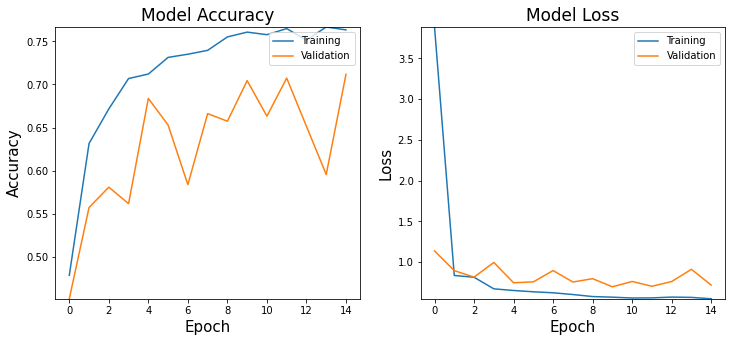

In [16]:
OneLayerVGG.plot_performance()

# Two Block VGG Model 

In [17]:
TwoLayerVGG = CNN()

In [18]:
TwoLayerVGG.build_TwoLayerVGG()

In [19]:
history2=TwoLayerVGG.train_model()

[INFO] Training network...
Epoch 1/15


/tmp/ipykernel_3369/2711259985.py:123: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.history = self.model.fit_generator(self.augment.flow(self.X_train, self.y_train, batch_size=BATCH_SIZE),


  1/108 [..............................] - ETA: 1:44 - loss: 2.3089 - accuracy: 0.4000

  2/108 [..............................] - ETA: 23s - loss: 18.7465 - accuracy: 0.3600

  3/108 [..............................] - ETA: 20s - loss: 24.5115 - accuracy: 0.3600

  4/108 [>.............................] - ETA: 20s - loss: 23.2355 - accuracy: 0.3700

  5/108 [>.............................] - ETA: 19s - loss: 20.1444 - accuracy: 0.3840

  6/108 [>.............................] - ETA: 19s - loss: 17.4259 - accuracy: 0.3467

  7/108 [>.............................] - ETA: 18s - loss: 15.1018 - accuracy: 0.3600

  8/108 [=>............................] - ETA: 18s - loss: 13.3476 - accuracy: 0.3800

  9/108 [=>............................] - ETA: 18s - loss: 12.0105 - accuracy: 0.3867

 10/108 [=>............................] - ETA: 18s - loss: 10.9200 - accuracy: 0.3920

 11/108 [==>...........................] - ETA: 17s - loss: 10.0265 - accuracy: 0.3964

 12/108 [==>...........................] - ETA: 17s - loss: 9.2798 - accuracy: 0.4100 

 13/108 [==>...........................] - ETA: 17s - loss: 8.6504 - accuracy: 0.4062

 14/108 [==>...........................] - ETA: 17s - loss: 8.1111 - accuracy: 0.4029

 15/108 [===>..........................] - ETA: 16s - loss: 7.6429 - accuracy: 0.4107

 16/108 [===>..........................] - ETA: 16s - loss: 7.2320 - accuracy: 0.4200

 17/108 [===>..........................] - ETA: 16s - loss: 6.8699 - accuracy: 0.4212

 18/108 [====>.........................] - ETA: 16s - loss: 6.5501 - accuracy: 0.4156

 19/108 [====>.........................] - ETA: 16s - loss: 6.2613 - accuracy: 0.4232

 20/108 [====>.........................] - ETA: 15s - loss: 6.0035 - accuracy: 0.4200

 21/108 [====>.........................] - ETA: 15s - loss: 5.7704 - accuracy: 0.4171

 22/108 [=====>........................] - ETA: 15s - loss: 5.5572 - accuracy: 0.4200

 23/108 [=====>........................] - ETA: 15s - loss: 5.3630 - accuracy: 0.4191

 24/108 [=====>........................] - ETA: 15s - loss: 5.1827 - accuracy: 0.4267

 25/108 [=====>........................] - ETA: 14s - loss: 5.0185 - accuracy: 0.4288

 26/108 [======>.......................] - ETA: 14s - loss: 4.8672 - accuracy: 0.4277

 27/108 [======>.......................] - ETA: 14s - loss: 4.7268 - accuracy: 0.4281

 28/108 [======>.......................] - ETA: 14s - loss: 4.5957 - accuracy: 0.4314

 29/108 [=======>......................] - ETA: 14s - loss: 4.4738 - accuracy: 0.4331

 30/108 [=======>......................] - ETA: 13s - loss: 4.3607 - accuracy: 0.4333

 31/108 [=======>......................] - ETA: 13s - loss: 4.2554 - accuracy: 0.4323

 32/108 [=======>......................] - ETA: 13s - loss: 4.1569 - accuracy: 0.4313

 33/108 [========>.....................] - ETA: 13s - loss: 4.0641 - accuracy: 0.4315

 34/108 [========>.....................] - ETA: 13s - loss: 3.9767 - accuracy: 0.4318

 35/108 [========>.....................] - ETA: 12s - loss: 3.8945 - accuracy: 0.4309

 36/108 [=========>....................] - ETA: 12s - loss: 3.8150 - accuracy: 0.4344

 37/108 [=========>....................] - ETA: 12s - loss: 3.7396 - accuracy: 0.4389

 38/108 [=========>....................] - ETA: 12s - loss: 3.6697 - accuracy: 0.4379

 39/108 [=========>....................] - ETA: 12s - loss: 3.6031 - accuracy: 0.4390

 40/108 [==========>...................] - ETA: 12s - loss: 3.5392 - accuracy: 0.4410

 41/108 [==========>...................] - ETA: 11s - loss: 3.4797 - accuracy: 0.4400

 42/108 [==========>...................] - ETA: 11s - loss: 3.4218 - accuracy: 0.4419

 43/108 [==========>...................] - ETA: 11s - loss: 3.3675 - accuracy: 0.4409

 44/108 [===========>..................] - ETA: 11s - loss: 3.3147 - accuracy: 0.4418

 45/108 [===========>..................] - ETA: 11s - loss: 3.2656 - accuracy: 0.4409

 46/108 [===========>..................] - ETA: 10s - loss: 3.2185 - accuracy: 0.4391

 47/108 [============>.................] - ETA: 10s - loss: 3.1731 - accuracy: 0.4383

 48/108 [============>.................] - ETA: 10s - loss: 3.1277 - accuracy: 0.4417

 49/108 [============>.................] - ETA: 10s - loss: 3.0853 - accuracy: 0.4424

 50/108 [============>.................] - ETA: 10s - loss: 3.0454 - accuracy: 0.4416

 51/108 [=============>................] - ETA: 10s - loss: 3.0075 - accuracy: 0.4400

 52/108 [=============>................] - ETA: 9s - loss: 2.9707 - accuracy: 0.4392 

 53/108 [=============>................] - ETA: 9s - loss: 2.9352 - accuracy: 0.4385

 54/108 [==============>...............] - ETA: 9s - loss: 2.9011 - accuracy: 0.4378

 55/108 [==============>...............] - ETA: 9s - loss: 2.8685 - accuracy: 0.4364

 56/108 [==============>...............] - ETA: 9s - loss: 2.8365 - accuracy: 0.4364

 57/108 [==============>...............] - ETA: 9s - loss: 2.8054 - accuracy: 0.4372

 58/108 [===============>..............] - ETA: 8s - loss: 2.7761 - accuracy: 0.4352

 59/108 [===============>..............] - ETA: 8s - loss: 2.7533 - accuracy: 0.4347

 60/108 [===============>..............] - ETA: 8s - loss: 2.7260 - accuracy: 0.4314

 61/108 [===============>..............] - ETA: 8s - loss: 2.6989 - accuracy: 0.4322

 62/108 [================>.............] - ETA: 8s - loss: 2.6728 - accuracy: 0.4337

 63/108 [================>.............] - ETA: 7s - loss: 2.6478 - accuracy: 0.4318

 64/108 [================>.............] - ETA: 7s - loss: 2.6233 - accuracy: 0.4320

 65/108 [=================>............] - ETA: 7s - loss: 2.5992 - accuracy: 0.4327

 66/108 [=================>............] - ETA: 7s - loss: 2.5759 - accuracy: 0.4334

 67/108 [=================>............] - ETA: 7s - loss: 2.5531 - accuracy: 0.4347

 68/108 [=================>............] - ETA: 7s - loss: 2.5311 - accuracy: 0.4360

 69/108 [==================>...........] - ETA: 6s - loss: 2.5101 - accuracy: 0.4349

 70/108 [==================>...........] - ETA: 6s - loss: 2.4896 - accuracy: 0.4355

 71/108 [==================>...........] - ETA: 6s - loss: 2.4698 - accuracy: 0.4333

 72/108 [===================>..........] - ETA: 6s - loss: 2.4495 - accuracy: 0.4345

 73/108 [===================>..........] - ETA: 6s - loss: 2.4340 - accuracy: 0.4313

 74/108 [===================>..........] - ETA: 5s - loss: 2.4152 - accuracy: 0.4304

 75/108 [===================>..........] - ETA: 5s - loss: 2.3973 - accuracy: 0.4299

 76/108 [====================>.........] - ETA: 5s - loss: 2.3801 - accuracy: 0.4285

 77/108 [====================>.........] - ETA: 5s - loss: 2.3634 - accuracy: 0.4286

 78/108 [====================>.........] - ETA: 5s - loss: 2.3470 - accuracy: 0.4283

 79/108 [====================>.........] - ETA: 5s - loss: 2.3312 - accuracy: 0.4269

 80/108 [=====================>........] - ETA: 4s - loss: 2.3156 - accuracy: 0.4266

 81/108 [=====================>........] - ETA: 4s - loss: 2.2998 - accuracy: 0.4287

 82/108 [=====================>........] - ETA: 4s - loss: 2.2852 - accuracy: 0.4279

 83/108 [======================>.......] - ETA: 4s - loss: 2.2705 - accuracy: 0.4290

 84/108 [======================>.......] - ETA: 4s - loss: 2.2559 - accuracy: 0.4296

 85/108 [======================>.......] - ETA: 4s - loss: 2.2420 - accuracy: 0.4292

 86/108 [======================>.......] - ETA: 3s - loss: 2.2274 - accuracy: 0.4312

 87/108 [=======================>......] - ETA: 3s - loss: 2.2150 - accuracy: 0.4300

 88/108 [=======================>......] - ETA: 3s - loss: 2.2007 - accuracy: 0.4319

 89/108 [=======================>......] - ETA: 3s - loss: 2.1875 - accuracy: 0.4324

 90/108 [========================>.....] - ETA: 3s - loss: 2.1766 - accuracy: 0.4307

 91/108 [========================>.....] - ETA: 2s - loss: 2.1640 - accuracy: 0.4313

 92/108 [========================>.....] - ETA: 2s - loss: 2.1524 - accuracy: 0.4309

 93/108 [========================>.....] - ETA: 2s - loss: 2.1416 - accuracy: 0.4297

 94/108 [=========================>....] - ETA: 2s - loss: 2.1294 - accuracy: 0.4320

 95/108 [=========================>....] - ETA: 2s - loss: 2.1182 - accuracy: 0.4321

 96/108 [=========================>....] - ETA: 2s - loss: 2.1062 - accuracy: 0.4347

 97/108 [=========================>....] - ETA: 1s - loss: 2.0953 - accuracy: 0.4339

 98/108 [==========================>...] - ETA: 1s - loss: 2.0843 - accuracy: 0.4344

 99/108 [==========================>...] - ETA: 1s - loss: 2.0727 - accuracy: 0.4352

100/108 [==========================>...] - ETA: 1s - loss: 2.0654 - accuracy: 0.4357

101/108 [===========================>..] - ETA: 1s - loss: 2.0550 - accuracy: 0.4365

102/108 [===========================>..] - ETA: 1s - loss: 2.0456 - accuracy: 0.4358

103/108 [===========================>..] - ETA: 0s - loss: 2.0359 - accuracy: 0.4358

104/108 [===========================>..] - ETA: 0s - loss: 2.0260 - accuracy: 0.4366

105/108 [============================>.] - ETA: 0s - loss: 2.0166 - accuracy: 0.4363

106/108 [============================>.] - ETA: 0s - loss: 2.0076 - accuracy: 0.4355

107/108 [============================>.] - ETA: 0s - loss: 1.9995 - accuracy: 0.4337

108/108 [==============================] - ETA: 0s - loss: 1.9902 - accuracy: 0.4353

108/108 [==============================] - 21s 186ms/step - loss: 1.9902 - accuracy: 0.4353 - val_loss: 1.0784 - val_accuracy: 0.3824


Epoch 2/15


  1/108 [..............................] - ETA: 40s - loss: 1.0387 - accuracy: 0.4800

  2/108 [..............................] - ETA: 25s - loss: 1.0502 - accuracy: 0.4400

  3/108 [..............................] - ETA: 22s - loss: 1.0668 - accuracy: 0.3867

  4/108 [>.............................] - ETA: 21s - loss: 1.0304 - accuracy: 0.4500

  5/108 [>.............................] - ETA: 20s - loss: 1.0189 - accuracy: 0.4640

  6/108 [>.............................] - ETA: 19s - loss: 1.0202 - accuracy: 0.4600

  7/108 [>.............................] - ETA: 19s - loss: 1.0112 - accuracy: 0.4686

  8/108 [=>............................] - ETA: 18s - loss: 1.0232 - accuracy: 0.4550

  9/108 [=>............................] - ETA: 18s - loss: 1.0211 - accuracy: 0.4578

 10/108 [=>............................] - ETA: 18s - loss: 1.0242 - accuracy: 0.4440

 11/108 [==>...........................] - ETA: 18s - loss: 1.0196 - accuracy: 0.4545

 12/108 [==>...........................] - ETA: 17s - loss: 1.0116 - accuracy: 0.4567

 13/108 [==>...........................] - ETA: 17s - loss: 1.0029 - accuracy: 0.4677

 14/108 [==>...........................] - ETA: 17s - loss: 0.9966 - accuracy: 0.4857

 15/108 [===>..........................] - ETA: 17s - loss: 0.9948 - accuracy: 0.4933

 16/108 [===>..........................] - ETA: 17s - loss: 0.9976 - accuracy: 0.4900

 17/108 [===>..........................] - ETA: 16s - loss: 0.9975 - accuracy: 0.4871

 18/108 [====>.........................] - ETA: 16s - loss: 0.9861 - accuracy: 0.4978

 19/108 [====>.........................] - ETA: 16s - loss: 0.9811 - accuracy: 0.5011

 20/108 [====>.........................] - ETA: 16s - loss: 0.9817 - accuracy: 0.4980

 21/108 [====>.........................] - ETA: 15s - loss: 0.9865 - accuracy: 0.4952

 22/108 [=====>........................] - ETA: 15s - loss: 0.9852 - accuracy: 0.4945

 23/108 [=====>........................] - ETA: 15s - loss: 0.9813 - accuracy: 0.4974

 24/108 [=====>........................] - ETA: 15s - loss: 0.9782 - accuracy: 0.5017

 25/108 [=====>........................] - ETA: 15s - loss: 0.9709 - accuracy: 0.5040

 26/108 [======>.......................] - ETA: 14s - loss: 0.9765 - accuracy: 0.4954

 27/108 [======>.......................] - ETA: 14s - loss: 0.9750 - accuracy: 0.4978

 28/108 [======>.......................] - ETA: 14s - loss: 0.9701 - accuracy: 0.5029

 29/108 [=======>......................] - ETA: 14s - loss: 0.9605 - accuracy: 0.5131

 30/108 [=======>......................] - ETA: 14s - loss: 0.9617 - accuracy: 0.5120

 31/108 [=======>......................] - ETA: 13s - loss: 0.9536 - accuracy: 0.5187

 32/108 [=======>......................] - ETA: 13s - loss: 0.9554 - accuracy: 0.5188

 33/108 [========>.....................] - ETA: 13s - loss: 0.9531 - accuracy: 0.5176

 34/108 [========>.....................] - ETA: 13s - loss: 0.9479 - accuracy: 0.5188

 35/108 [========>.....................] - ETA: 13s - loss: 0.9458 - accuracy: 0.5211

 36/108 [=========>....................] - ETA: 12s - loss: 0.9450 - accuracy: 0.5222

 37/108 [=========>....................] - ETA: 12s - loss: 0.9409 - accuracy: 0.5232

 38/108 [=========>....................] - ETA: 12s - loss: 0.9412 - accuracy: 0.5232

 39/108 [=========>....................] - ETA: 12s - loss: 0.9390 - accuracy: 0.5251

 40/108 [==========>...................] - ETA: 12s - loss: 0.9349 - accuracy: 0.5300

 41/108 [==========>...................] - ETA: 11s - loss: 0.9393 - accuracy: 0.5288

 42/108 [==========>...................] - ETA: 11s - loss: 0.9368 - accuracy: 0.5305

 43/108 [==========>...................] - ETA: 11s - loss: 0.9353 - accuracy: 0.5330

 44/108 [===========>..................] - ETA: 11s - loss: 0.9344 - accuracy: 0.5300

 45/108 [===========>..................] - ETA: 11s - loss: 0.9329 - accuracy: 0.5289

 46/108 [===========>..................] - ETA: 11s - loss: 0.9300 - accuracy: 0.5313

 47/108 [============>.................] - ETA: 10s - loss: 0.9303 - accuracy: 0.5277

 48/108 [============>.................] - ETA: 10s - loss: 0.9308 - accuracy: 0.5258

 49/108 [============>.................] - ETA: 10s - loss: 0.9282 - accuracy: 0.5298

 50/108 [============>.................] - ETA: 10s - loss: 0.9243 - accuracy: 0.5320

 51/108 [=============>................] - ETA: 10s - loss: 0.9224 - accuracy: 0.5341

 52/108 [=============>................] - ETA: 9s - loss: 0.9193 - accuracy: 0.5362 

 53/108 [=============>................] - ETA: 9s - loss: 0.9208 - accuracy: 0.5343

 54/108 [==============>...............] - ETA: 9s - loss: 0.9188 - accuracy: 0.5356

 55/108 [==============>...............] - ETA: 9s - loss: 0.9179 - accuracy: 0.5345

 56/108 [==============>...............] - ETA: 9s - loss: 0.9190 - accuracy: 0.5343

 57/108 [==============>...............] - ETA: 9s - loss: 0.9191 - accuracy: 0.5333

 58/108 [===============>..............] - ETA: 8s - loss: 0.9167 - accuracy: 0.5331

 59/108 [===============>..............] - ETA: 8s - loss: 0.9142 - accuracy: 0.5336

 60/108 [===============>..............] - ETA: 8s - loss: 0.9113 - accuracy: 0.5360

 61/108 [===============>..............] - ETA: 8s - loss: 0.9098 - accuracy: 0.5377

 62/108 [================>.............] - ETA: 8s - loss: 0.9103 - accuracy: 0.5361

 63/108 [================>.............] - ETA: 8s - loss: 0.9069 - accuracy: 0.5378

 64/108 [================>.............] - ETA: 7s - loss: 0.9058 - accuracy: 0.5400

 65/108 [=================>............] - ETA: 7s - loss: 0.9033 - accuracy: 0.5422

 66/108 [=================>............] - ETA: 7s - loss: 0.9030 - accuracy: 0.5418

 67/108 [=================>............] - ETA: 7s - loss: 0.9000 - accuracy: 0.5421

 68/108 [=================>............] - ETA: 7s - loss: 0.8997 - accuracy: 0.5424

 69/108 [==================>...........] - ETA: 7s - loss: 0.8995 - accuracy: 0.5420

 70/108 [==================>...........] - ETA: 6s - loss: 0.8981 - accuracy: 0.5434

 71/108 [==================>...........] - ETA: 6s - loss: 0.8980 - accuracy: 0.5431

 72/108 [===================>..........] - ETA: 6s - loss: 0.8947 - accuracy: 0.5450

 73/108 [===================>..........] - ETA: 6s - loss: 0.8940 - accuracy: 0.5447

 74/108 [===================>..........] - ETA: 6s - loss: 0.8945 - accuracy: 0.5427

 75/108 [===================>..........] - ETA: 5s - loss: 0.8964 - accuracy: 0.5408

 76/108 [====================>.........] - ETA: 5s - loss: 0.8954 - accuracy: 0.5411

 77/108 [====================>.........] - ETA: 5s - loss: 0.8941 - accuracy: 0.5423

 78/108 [====================>.........] - ETA: 5s - loss: 0.8934 - accuracy: 0.5421

 79/108 [====================>.........] - ETA: 5s - loss: 0.8930 - accuracy: 0.5423

 80/108 [=====================>........] - ETA: 5s - loss: 0.8931 - accuracy: 0.5445

 81/108 [=====================>........] - ETA: 4s - loss: 0.8916 - accuracy: 0.5447

 82/108 [=====================>........] - ETA: 4s - loss: 0.8911 - accuracy: 0.5454

 83/108 [======================>.......] - ETA: 4s - loss: 0.8892 - accuracy: 0.5465

 84/108 [======================>.......] - ETA: 4s - loss: 0.8883 - accuracy: 0.5471

 85/108 [======================>.......] - ETA: 4s - loss: 0.8893 - accuracy: 0.5459

 86/108 [======================>.......] - ETA: 3s - loss: 0.8880 - accuracy: 0.5470

 87/108 [=======================>......] - ETA: 3s - loss: 0.8875 - accuracy: 0.5462

 88/108 [=======================>......] - ETA: 3s - loss: 0.8877 - accuracy: 0.5473

 89/108 [=======================>......] - ETA: 3s - loss: 0.8855 - accuracy: 0.5488

 90/108 [========================>.....] - ETA: 3s - loss: 0.8856 - accuracy: 0.5489

 91/108 [========================>.....] - ETA: 3s - loss: 0.8850 - accuracy: 0.5490

 92/108 [========================>.....] - ETA: 2s - loss: 0.8828 - accuracy: 0.5487

 93/108 [========================>.....] - ETA: 2s - loss: 0.8817 - accuracy: 0.5488

 94/108 [=========================>....] - ETA: 2s - loss: 0.8821 - accuracy: 0.5485

 95/108 [=========================>....] - ETA: 2s - loss: 0.8798 - accuracy: 0.5494

 96/108 [=========================>....] - ETA: 2s - loss: 0.8794 - accuracy: 0.5499

 97/108 [=========================>....] - ETA: 1s - loss: 0.8768 - accuracy: 0.5500

 98/108 [==========================>...] - ETA: 1s - loss: 0.8741 - accuracy: 0.5509

 99/108 [==========================>...] - ETA: 1s - loss: 0.8724 - accuracy: 0.5518

100/108 [==========================>...] - ETA: 1s - loss: 0.8719 - accuracy: 0.5527

101/108 [===========================>..] - ETA: 1s - loss: 0.8748 - accuracy: 0.5504

102/108 [===========================>..] - ETA: 1s - loss: 0.8746 - accuracy: 0.5513

103/108 [===========================>..] - ETA: 0s - loss: 0.8727 - accuracy: 0.5514

104/108 [===========================>..] - ETA: 0s - loss: 0.8714 - accuracy: 0.5530

105/108 [============================>.] - ETA: 0s - loss: 0.8721 - accuracy: 0.5534

106/108 [============================>.] - ETA: 0s - loss: 0.8712 - accuracy: 0.5546

107/108 [============================>.] - ETA: 0s - loss: 0.8691 - accuracy: 0.5554

108/108 [==============================] - ETA: 0s - loss: 0.8700 - accuracy: 0.5540

108/108 [==============================] - 20s 187ms/step - loss: 0.8700 - accuracy: 0.5540 - val_loss: 0.8649 - val_accuracy: 0.6074


Epoch 3/15


  1/108 [..............................] - ETA: 45s - loss: 0.6121 - accuracy: 0.6800

  2/108 [..............................] - ETA: 23s - loss: 0.6575 - accuracy: 0.6600

  3/108 [..............................] - ETA: 21s - loss: 0.8112 - accuracy: 0.5867

  4/108 [>.............................] - ETA: 21s - loss: 0.7998 - accuracy: 0.5800

  5/108 [>.............................] - ETA: 20s - loss: 0.8110 - accuracy: 0.5760

  6/108 [>.............................] - ETA: 19s - loss: 0.8040 - accuracy: 0.5733

  7/108 [>.............................] - ETA: 19s - loss: 0.8005 - accuracy: 0.5657

  8/108 [=>............................] - ETA: 18s - loss: 0.8207 - accuracy: 0.5450

  9/108 [=>............................] - ETA: 18s - loss: 0.8270 - accuracy: 0.5422

 10/108 [=>............................] - ETA: 18s - loss: 0.8231 - accuracy: 0.5560

 11/108 [==>...........................] - ETA: 18s - loss: 0.8182 - accuracy: 0.5600

 12/108 [==>...........................] - ETA: 17s - loss: 0.7959 - accuracy: 0.5700

 13/108 [==>...........................] - ETA: 17s - loss: 0.8008 - accuracy: 0.5754

 14/108 [==>...........................] - ETA: 17s - loss: 0.8065 - accuracy: 0.5743

 15/108 [===>..........................] - ETA: 17s - loss: 0.7991 - accuracy: 0.5840

 16/108 [===>..........................] - ETA: 16s - loss: 0.8011 - accuracy: 0.5775

 17/108 [===>..........................] - ETA: 16s - loss: 0.8121 - accuracy: 0.5741

 18/108 [====>.........................] - ETA: 16s - loss: 0.8167 - accuracy: 0.5756

 19/108 [====>.........................] - ETA: 16s - loss: 0.8151 - accuracy: 0.5789

 20/108 [====>.........................] - ETA: 16s - loss: 0.8091 - accuracy: 0.5780

 21/108 [====>.........................] - ETA: 15s - loss: 0.8052 - accuracy: 0.5829

 22/108 [=====>........................] - ETA: 15s - loss: 0.7991 - accuracy: 0.5836

 23/108 [=====>........................] - ETA: 15s - loss: 0.8053 - accuracy: 0.5826

 24/108 [=====>........................] - ETA: 15s - loss: 0.8041 - accuracy: 0.5883

 25/108 [=====>........................] - ETA: 15s - loss: 0.8030 - accuracy: 0.5872

 26/108 [======>.......................] - ETA: 14s - loss: 0.8026 - accuracy: 0.5862

 27/108 [======>.......................] - ETA: 14s - loss: 0.8124 - accuracy: 0.5793

 28/108 [======>.......................] - ETA: 14s - loss: 0.8047 - accuracy: 0.5871

 29/108 [=======>......................] - ETA: 14s - loss: 0.8039 - accuracy: 0.5862

 30/108 [=======>......................] - ETA: 14s - loss: 0.8038 - accuracy: 0.5867

 31/108 [=======>......................] - ETA: 13s - loss: 0.8018 - accuracy: 0.5858

 32/108 [=======>......................] - ETA: 13s - loss: 0.8110 - accuracy: 0.5838

 33/108 [========>.....................] - ETA: 13s - loss: 0.8154 - accuracy: 0.5806

 34/108 [========>.....................] - ETA: 13s - loss: 0.8089 - accuracy: 0.5882

 35/108 [========>.....................] - ETA: 13s - loss: 0.8068 - accuracy: 0.5886

 36/108 [=========>....................] - ETA: 12s - loss: 0.8031 - accuracy: 0.5900

 37/108 [=========>....................] - ETA: 12s - loss: 0.8029 - accuracy: 0.5859

 38/108 [=========>....................] - ETA: 12s - loss: 0.8014 - accuracy: 0.5863

 39/108 [=========>....................] - ETA: 12s - loss: 0.8019 - accuracy: 0.5836

 40/108 [==========>...................] - ETA: 12s - loss: 0.8012 - accuracy: 0.5830

 41/108 [==========>...................] - ETA: 12s - loss: 0.8045 - accuracy: 0.5815

 42/108 [==========>...................] - ETA: 11s - loss: 0.8036 - accuracy: 0.5819

 43/108 [==========>...................] - ETA: 11s - loss: 0.8037 - accuracy: 0.5851

 44/108 [===========>..................] - ETA: 11s - loss: 0.8095 - accuracy: 0.5818

 45/108 [===========>..................] - ETA: 11s - loss: 0.8096 - accuracy: 0.5849

 46/108 [===========>..................] - ETA: 11s - loss: 0.8077 - accuracy: 0.5843

 47/108 [============>.................] - ETA: 10s - loss: 0.8046 - accuracy: 0.5855

 48/108 [============>.................] - ETA: 10s - loss: 0.8050 - accuracy: 0.5833

 49/108 [============>.................] - ETA: 10s - loss: 0.8033 - accuracy: 0.5837

 50/108 [============>.................] - ETA: 10s - loss: 0.8037 - accuracy: 0.5824

 51/108 [=============>................] - ETA: 10s - loss: 0.8024 - accuracy: 0.5827

 52/108 [=============>................] - ETA: 9s - loss: 0.8062 - accuracy: 0.5808 

 53/108 [=============>................] - ETA: 9s - loss: 0.8061 - accuracy: 0.5819

 54/108 [==============>...............] - ETA: 9s - loss: 0.8087 - accuracy: 0.5822

 55/108 [==============>...............] - ETA: 9s - loss: 0.8086 - accuracy: 0.5825

 56/108 [==============>...............] - ETA: 9s - loss: 0.8075 - accuracy: 0.5807

 57/108 [==============>...............] - ETA: 9s - loss: 0.8058 - accuracy: 0.5818

 58/108 [===============>..............] - ETA: 8s - loss: 0.8062 - accuracy: 0.5807

 59/108 [===============>..............] - ETA: 8s - loss: 0.8029 - accuracy: 0.5831

 60/108 [===============>..............] - ETA: 8s - loss: 0.8007 - accuracy: 0.5853

 61/108 [===============>..............] - ETA: 8s - loss: 0.8006 - accuracy: 0.5856

 62/108 [================>.............] - ETA: 8s - loss: 0.7996 - accuracy: 0.5858

 63/108 [================>.............] - ETA: 8s - loss: 0.8000 - accuracy: 0.5848

 64/108 [================>.............] - ETA: 7s - loss: 0.8007 - accuracy: 0.5856

 65/108 [=================>............] - ETA: 7s - loss: 0.8010 - accuracy: 0.5852

 66/108 [=================>............] - ETA: 7s - loss: 0.8005 - accuracy: 0.5873

 67/108 [=================>............] - ETA: 7s - loss: 0.7996 - accuracy: 0.5887

 68/108 [=================>............] - ETA: 7s - loss: 0.7984 - accuracy: 0.5900

 69/108 [==================>...........] - ETA: 6s - loss: 0.8010 - accuracy: 0.5896

 70/108 [==================>...........] - ETA: 6s - loss: 0.8000 - accuracy: 0.5897

 71/108 [==================>...........] - ETA: 6s - loss: 0.7985 - accuracy: 0.5904

 72/108 [===================>..........] - ETA: 6s - loss: 0.7982 - accuracy: 0.5900

 73/108 [===================>..........] - ETA: 6s - loss: 0.7974 - accuracy: 0.5896

 74/108 [===================>..........] - ETA: 6s - loss: 0.7974 - accuracy: 0.5903

 75/108 [===================>..........] - ETA: 5s - loss: 0.7952 - accuracy: 0.5931

 76/108 [====================>.........] - ETA: 5s - loss: 0.7967 - accuracy: 0.5926

 77/108 [====================>.........] - ETA: 5s - loss: 0.7967 - accuracy: 0.5927

 78/108 [====================>.........] - ETA: 5s - loss: 0.7942 - accuracy: 0.5943

 79/108 [====================>.........] - ETA: 5s - loss: 0.7954 - accuracy: 0.5919

 80/108 [=====================>........] - ETA: 4s - loss: 0.7933 - accuracy: 0.5940

 81/108 [=====================>........] - ETA: 4s - loss: 0.7908 - accuracy: 0.5941

 82/108 [=====================>........] - ETA: 4s - loss: 0.7907 - accuracy: 0.5932

 83/108 [======================>.......] - ETA: 4s - loss: 0.7910 - accuracy: 0.5918

 84/108 [======================>.......] - ETA: 4s - loss: 0.7907 - accuracy: 0.5914

 85/108 [======================>.......] - ETA: 4s - loss: 0.7909 - accuracy: 0.5920

 86/108 [======================>.......] - ETA: 3s - loss: 0.7894 - accuracy: 0.5921

 87/108 [=======================>......] - ETA: 3s - loss: 0.7881 - accuracy: 0.5922

 88/108 [=======================>......] - ETA: 3s - loss: 0.7869 - accuracy: 0.5932

 89/108 [=======================>......] - ETA: 3s - loss: 0.7878 - accuracy: 0.5914

 90/108 [========================>.....] - ETA: 3s - loss: 0.7882 - accuracy: 0.5906

 91/108 [========================>.....] - ETA: 3s - loss: 0.7890 - accuracy: 0.5903

 92/108 [========================>.....] - ETA: 2s - loss: 0.7888 - accuracy: 0.5900

 93/108 [========================>.....] - ETA: 2s - loss: 0.7888 - accuracy: 0.5897

 94/108 [=========================>....] - ETA: 2s - loss: 0.7872 - accuracy: 0.5915

 95/108 [=========================>....] - ETA: 2s - loss: 0.7879 - accuracy: 0.5903

 96/108 [=========================>....] - ETA: 2s - loss: 0.7860 - accuracy: 0.5921

 97/108 [=========================>....] - ETA: 1s - loss: 0.7868 - accuracy: 0.5905

 98/108 [==========================>...] - ETA: 1s - loss: 0.7866 - accuracy: 0.5898

 99/108 [==========================>...] - ETA: 1s - loss: 0.7872 - accuracy: 0.5895

100/108 [==========================>...] - ETA: 1s - loss: 0.7851 - accuracy: 0.5908

101/108 [===========================>..] - ETA: 1s - loss: 0.7849 - accuracy: 0.5905

102/108 [===========================>..] - ETA: 1s - loss: 0.7837 - accuracy: 0.5914

103/108 [===========================>..] - ETA: 0s - loss: 0.7832 - accuracy: 0.5926

104/108 [===========================>..] - ETA: 0s - loss: 0.7812 - accuracy: 0.5950

105/108 [============================>.] - ETA: 0s - loss: 0.7805 - accuracy: 0.5958

106/108 [============================>.] - ETA: 0s - loss: 0.7799 - accuracy: 0.5962

107/108 [============================>.] - ETA: 0s - loss: 0.7813 - accuracy: 0.5955

108/108 [==============================] - ETA: 0s - loss: 0.7826 - accuracy: 0.5952

108/108 [==============================] - 20s 184ms/step - loss: 0.7826 - accuracy: 0.5952 - val_loss: 0.8425 - val_accuracy: 0.5647


Epoch 4/15


  1/108 [..............................] - ETA: 46s - loss: 0.5865 - accuracy: 0.7200

  2/108 [..............................] - ETA: 23s - loss: 0.7494 - accuracy: 0.6600

  3/108 [..............................] - ETA: 22s - loss: 0.7085 - accuracy: 0.6800

  4/108 [>.............................] - ETA: 20s - loss: 0.7049 - accuracy: 0.6400

  5/108 [>.............................] - ETA: 20s - loss: 0.6895 - accuracy: 0.6640

  6/108 [>.............................] - ETA: 19s - loss: 0.6900 - accuracy: 0.6467

  7/108 [>.............................] - ETA: 19s - loss: 0.7204 - accuracy: 0.6457

  8/108 [=>............................] - ETA: 18s - loss: 0.7298 - accuracy: 0.6400

  9/108 [=>............................] - ETA: 18s - loss: 0.7245 - accuracy: 0.6400

 10/108 [=>............................] - ETA: 18s - loss: 0.7204 - accuracy: 0.6480

 11/108 [==>...........................] - ETA: 18s - loss: 0.7200 - accuracy: 0.6582

 12/108 [==>...........................] - ETA: 17s - loss: 0.7653 - accuracy: 0.6367

 13/108 [==>...........................] - ETA: 17s - loss: 0.7669 - accuracy: 0.6462

 14/108 [==>...........................] - ETA: 17s - loss: 0.7662 - accuracy: 0.6514

 15/108 [===>..........................] - ETA: 17s - loss: 0.7734 - accuracy: 0.6480

 16/108 [===>..........................] - ETA: 16s - loss: 0.7833 - accuracy: 0.6450

 17/108 [===>..........................] - ETA: 16s - loss: 0.7817 - accuracy: 0.6424

 18/108 [====>.........................] - ETA: 16s - loss: 0.7800 - accuracy: 0.6489

 19/108 [====>.........................] - ETA: 16s - loss: 0.7861 - accuracy: 0.6358

 20/108 [====>.........................] - ETA: 15s - loss: 0.7933 - accuracy: 0.6280

 21/108 [====>.........................] - ETA: 15s - loss: 0.7892 - accuracy: 0.6286

 22/108 [=====>........................] - ETA: 15s - loss: 0.7882 - accuracy: 0.6291

 23/108 [=====>........................] - ETA: 15s - loss: 0.7900 - accuracy: 0.6313

 24/108 [=====>........................] - ETA: 15s - loss: 0.7930 - accuracy: 0.6300

 25/108 [=====>........................] - ETA: 14s - loss: 0.7953 - accuracy: 0.6208

 26/108 [======>.......................] - ETA: 14s - loss: 0.7902 - accuracy: 0.6262

 27/108 [======>.......................] - ETA: 14s - loss: 0.7902 - accuracy: 0.6267

 28/108 [======>.......................] - ETA: 14s - loss: 0.7928 - accuracy: 0.6229

 29/108 [=======>......................] - ETA: 14s - loss: 0.8006 - accuracy: 0.6166

 30/108 [=======>......................] - ETA: 14s - loss: 0.7992 - accuracy: 0.6173

 31/108 [=======>......................] - ETA: 13s - loss: 0.7994 - accuracy: 0.6155

 32/108 [=======>......................] - ETA: 13s - loss: 0.8001 - accuracy: 0.6137

 33/108 [========>.....................] - ETA: 13s - loss: 0.7948 - accuracy: 0.6194

 34/108 [========>.....................] - ETA: 13s - loss: 0.7914 - accuracy: 0.6188

 35/108 [========>.....................] - ETA: 13s - loss: 0.7892 - accuracy: 0.6206

 36/108 [=========>....................] - ETA: 12s - loss: 0.7842 - accuracy: 0.6244

 37/108 [=========>....................] - ETA: 12s - loss: 0.7870 - accuracy: 0.6184

 38/108 [=========>....................] - ETA: 12s - loss: 0.7852 - accuracy: 0.6200

 39/108 [=========>....................] - ETA: 12s - loss: 0.7801 - accuracy: 0.6215

 40/108 [==========>...................] - ETA: 12s - loss: 0.7775 - accuracy: 0.6220

 41/108 [==========>...................] - ETA: 11s - loss: 0.7745 - accuracy: 0.6215

 42/108 [==========>...................] - ETA: 11s - loss: 0.7707 - accuracy: 0.6248

 43/108 [==========>...................] - ETA: 11s - loss: 0.7711 - accuracy: 0.6260

 44/108 [===========>..................] - ETA: 11s - loss: 0.7677 - accuracy: 0.6282

 45/108 [===========>..................] - ETA: 11s - loss: 0.7668 - accuracy: 0.6302

 46/108 [===========>..................] - ETA: 11s - loss: 0.7669 - accuracy: 0.6313

 47/108 [============>.................] - ETA: 10s - loss: 0.7724 - accuracy: 0.6281

 48/108 [============>.................] - ETA: 10s - loss: 0.7716 - accuracy: 0.6267

 49/108 [============>.................] - ETA: 10s - loss: 0.7731 - accuracy: 0.6253

 50/108 [============>.................] - ETA: 10s - loss: 0.7724 - accuracy: 0.6256

 51/108 [=============>................] - ETA: 10s - loss: 0.7739 - accuracy: 0.6275

 52/108 [=============>................] - ETA: 9s - loss: 0.7721 - accuracy: 0.6262 

 53/108 [=============>................] - ETA: 9s - loss: 0.7728 - accuracy: 0.6242

 54/108 [==============>...............] - ETA: 9s - loss: 0.7755 - accuracy: 0.6253

 55/108 [==============>...............] - ETA: 9s - loss: 0.7767 - accuracy: 0.6212

 56/108 [==============>...............] - ETA: 9s - loss: 0.7762 - accuracy: 0.6208

 57/108 [==============>...............] - ETA: 9s - loss: 0.7746 - accuracy: 0.6232

 58/108 [===============>..............] - ETA: 8s - loss: 0.7759 - accuracy: 0.6235

 59/108 [===============>..............] - ETA: 8s - loss: 0.7776 - accuracy: 0.6211

 60/108 [===============>..............] - ETA: 8s - loss: 0.7746 - accuracy: 0.6221

 61/108 [===============>..............] - ETA: 8s - loss: 0.7721 - accuracy: 0.6243

 62/108 [================>.............] - ETA: 8s - loss: 0.7702 - accuracy: 0.6246

 63/108 [================>.............] - ETA: 7s - loss: 0.7711 - accuracy: 0.6242

 64/108 [================>.............] - ETA: 7s - loss: 0.7750 - accuracy: 0.6226

 65/108 [=================>............] - ETA: 7s - loss: 0.7763 - accuracy: 0.6216

 66/108 [=================>............] - ETA: 7s - loss: 0.7773 - accuracy: 0.6201

 67/108 [=================>............] - ETA: 7s - loss: 0.7779 - accuracy: 0.6186

 68/108 [=================>............] - ETA: 7s - loss: 0.7784 - accuracy: 0.6171

 69/108 [==================>...........] - ETA: 6s - loss: 0.7799 - accuracy: 0.6151

 70/108 [==================>...........] - ETA: 6s - loss: 0.7822 - accuracy: 0.6132

 71/108 [==================>...........] - ETA: 6s - loss: 0.7850 - accuracy: 0.6107

 72/108 [===================>..........] - ETA: 6s - loss: 0.7837 - accuracy: 0.6111

 73/108 [===================>..........] - ETA: 6s - loss: 0.7842 - accuracy: 0.6115

 74/108 [===================>..........] - ETA: 5s - loss: 0.7842 - accuracy: 0.6130

 75/108 [===================>..........] - ETA: 5s - loss: 0.7857 - accuracy: 0.6118

 76/108 [====================>.........] - ETA: 5s - loss: 0.7858 - accuracy: 0.6127

 77/108 [====================>.........] - ETA: 5s - loss: 0.7846 - accuracy: 0.6130

 78/108 [====================>.........] - ETA: 5s - loss: 0.7859 - accuracy: 0.6118

 79/108 [====================>.........] - ETA: 5s - loss: 0.7841 - accuracy: 0.6132

 80/108 [=====================>........] - ETA: 4s - loss: 0.7849 - accuracy: 0.6130

 81/108 [=====================>........] - ETA: 4s - loss: 0.7819 - accuracy: 0.6149

 82/108 [=====================>........] - ETA: 4s - loss: 0.7815 - accuracy: 0.6161

 83/108 [======================>.......] - ETA: 4s - loss: 0.7806 - accuracy: 0.6179

 84/108 [======================>.......] - ETA: 4s - loss: 0.7810 - accuracy: 0.6186

 85/108 [======================>.......] - ETA: 4s - loss: 0.7773 - accuracy: 0.6217

 86/108 [======================>.......] - ETA: 3s - loss: 0.7774 - accuracy: 0.6219

 87/108 [=======================>......] - ETA: 3s - loss: 0.7769 - accuracy: 0.6217

 88/108 [=======================>......] - ETA: 3s - loss: 0.7752 - accuracy: 0.6237

 89/108 [=======================>......] - ETA: 3s - loss: 0.7744 - accuracy: 0.6243

 90/108 [========================>.....] - ETA: 3s - loss: 0.7725 - accuracy: 0.6249

 91/108 [========================>.....] - ETA: 2s - loss: 0.7704 - accuracy: 0.6260

 92/108 [========================>.....] - ETA: 2s - loss: 0.7718 - accuracy: 0.6248

 93/108 [========================>.....] - ETA: 2s - loss: 0.7699 - accuracy: 0.6259

 94/108 [=========================>....] - ETA: 2s - loss: 0.7690 - accuracy: 0.6260

 95/108 [=========================>....] - ETA: 2s - loss: 0.7688 - accuracy: 0.6249

 96/108 [=========================>....] - ETA: 2s - loss: 0.7676 - accuracy: 0.6246

 97/108 [=========================>....] - ETA: 1s - loss: 0.7700 - accuracy: 0.6252

 98/108 [==========================>...] - ETA: 1s - loss: 0.7695 - accuracy: 0.6254

 99/108 [==========================>...] - ETA: 1s - loss: 0.7699 - accuracy: 0.6243

100/108 [==========================>...] - ETA: 1s - loss: 0.7714 - accuracy: 0.6232

101/108 [===========================>..] - ETA: 1s - loss: 0.7703 - accuracy: 0.6234

102/108 [===========================>..] - ETA: 1s - loss: 0.7693 - accuracy: 0.6240

103/108 [===========================>..] - ETA: 0s - loss: 0.7688 - accuracy: 0.6241

104/108 [===========================>..] - ETA: 0s - loss: 0.7679 - accuracy: 0.6239

105/108 [============================>.] - ETA: 0s - loss: 0.7681 - accuracy: 0.6244

106/108 [============================>.] - ETA: 0s - loss: 0.7678 - accuracy: 0.6246

107/108 [============================>.] - ETA: 0s - loss: 0.7684 - accuracy: 0.6236

108/108 [==============================] - ETA: 0s - loss: 0.7688 - accuracy: 0.6226

108/108 [==============================] - 20s 184ms/step - loss: 0.7688 - accuracy: 0.6226 - val_loss: 0.8645 - val_accuracy: 0.4971


Epoch 5/15


  1/108 [..............................] - ETA: 47s - loss: 0.6801 - accuracy: 0.7600

  2/108 [..............................] - ETA: 21s - loss: 0.7615 - accuracy: 0.6200

  3/108 [..............................] - ETA: 20s - loss: 0.7328 - accuracy: 0.6267

  4/108 [>.............................] - ETA: 20s - loss: 0.7158 - accuracy: 0.6600

  5/108 [>.............................] - ETA: 19s - loss: 0.7333 - accuracy: 0.6560

  6/108 [>.............................] - ETA: 19s - loss: 0.7781 - accuracy: 0.6133

  7/108 [>.............................] - ETA: 18s - loss: 0.7742 - accuracy: 0.6286

  8/108 [=>............................] - ETA: 18s - loss: 0.7724 - accuracy: 0.6350

  9/108 [=>............................] - ETA: 18s - loss: 0.7707 - accuracy: 0.6178

 10/108 [=>............................] - ETA: 18s - loss: 0.7560 - accuracy: 0.6160

 11/108 [==>...........................] - ETA: 18s - loss: 0.7439 - accuracy: 0.6145

 12/108 [==>...........................] - ETA: 17s - loss: 0.7364 - accuracy: 0.6100

 13/108 [==>...........................] - ETA: 17s - loss: 0.7328 - accuracy: 0.6031

 14/108 [==>...........................] - ETA: 17s - loss: 0.7181 - accuracy: 0.6171

 15/108 [===>..........................] - ETA: 17s - loss: 0.7096 - accuracy: 0.6240

 16/108 [===>..........................] - ETA: 16s - loss: 0.7003 - accuracy: 0.6350

 17/108 [===>..........................] - ETA: 16s - loss: 0.6955 - accuracy: 0.6424

 18/108 [====>.........................] - ETA: 16s - loss: 0.6912 - accuracy: 0.6489

 19/108 [====>.........................] - ETA: 16s - loss: 0.6859 - accuracy: 0.6547

 20/108 [====>.........................] - ETA: 15s - loss: 0.7063 - accuracy: 0.6540

 21/108 [====>.........................] - ETA: 15s - loss: 0.7175 - accuracy: 0.6438

 22/108 [=====>........................] - ETA: 15s - loss: 0.7351 - accuracy: 0.6345

 23/108 [=====>........................] - ETA: 15s - loss: 0.7270 - accuracy: 0.6435

 24/108 [=====>........................] - ETA: 15s - loss: 0.7243 - accuracy: 0.6417

 25/108 [=====>........................] - ETA: 14s - loss: 0.7176 - accuracy: 0.6432

 26/108 [======>.......................] - ETA: 14s - loss: 0.7185 - accuracy: 0.6400

 27/108 [======>.......................] - ETA: 14s - loss: 0.7165 - accuracy: 0.6385

 28/108 [======>.......................] - ETA: 14s - loss: 0.7240 - accuracy: 0.6371

 29/108 [=======>......................] - ETA: 14s - loss: 0.7291 - accuracy: 0.6372

 30/108 [=======>......................] - ETA: 14s - loss: 0.7308 - accuracy: 0.6373

 31/108 [=======>......................] - ETA: 13s - loss: 0.7343 - accuracy: 0.6310

 32/108 [=======>......................] - ETA: 13s - loss: 0.7373 - accuracy: 0.6325

 33/108 [========>.....................] - ETA: 13s - loss: 0.7372 - accuracy: 0.6303

 34/108 [========>.....................] - ETA: 13s - loss: 0.7392 - accuracy: 0.6247

 35/108 [========>.....................] - ETA: 13s - loss: 0.7338 - accuracy: 0.6263

 36/108 [=========>....................] - ETA: 12s - loss: 0.7342 - accuracy: 0.6256

 37/108 [=========>....................] - ETA: 12s - loss: 0.7354 - accuracy: 0.6259

 38/108 [=========>....................] - ETA: 12s - loss: 0.7405 - accuracy: 0.6274

 39/108 [=========>....................] - ETA: 12s - loss: 0.7448 - accuracy: 0.6277

 40/108 [==========>...................] - ETA: 12s - loss: 0.7458 - accuracy: 0.6300

 41/108 [==========>...................] - ETA: 11s - loss: 0.7474 - accuracy: 0.6283

 42/108 [==========>...................] - ETA: 11s - loss: 0.7517 - accuracy: 0.6238

 43/108 [==========>...................] - ETA: 11s - loss: 0.7525 - accuracy: 0.6251

 44/108 [===========>..................] - ETA: 11s - loss: 0.7496 - accuracy: 0.6273

 45/108 [===========>..................] - ETA: 11s - loss: 0.7464 - accuracy: 0.6276

 46/108 [===========>..................] - ETA: 11s - loss: 0.7466 - accuracy: 0.6296

 47/108 [============>.................] - ETA: 10s - loss: 0.7462 - accuracy: 0.6323

 48/108 [============>.................] - ETA: 10s - loss: 0.7503 - accuracy: 0.6308

 49/108 [============>.................] - ETA: 10s - loss: 0.7484 - accuracy: 0.6310

 50/108 [============>.................] - ETA: 10s - loss: 0.7474 - accuracy: 0.6312

 51/108 [=============>................] - ETA: 10s - loss: 0.7464 - accuracy: 0.6322

 52/108 [=============>................] - ETA: 9s - loss: 0.7462 - accuracy: 0.6315 

 53/108 [=============>................] - ETA: 9s - loss: 0.7433 - accuracy: 0.6325

 54/108 [==============>...............] - ETA: 9s - loss: 0.7442 - accuracy: 0.6326

 55/108 [==============>...............] - ETA: 9s - loss: 0.7445 - accuracy: 0.6327

 56/108 [==============>...............] - ETA: 9s - loss: 0.7449 - accuracy: 0.6314

 57/108 [==============>...............] - ETA: 9s - loss: 0.7453 - accuracy: 0.6295

 58/108 [===============>..............] - ETA: 8s - loss: 0.7447 - accuracy: 0.6297

 59/108 [===============>..............] - ETA: 8s - loss: 0.7459 - accuracy: 0.6278

 60/108 [===============>..............] - ETA: 8s - loss: 0.7471 - accuracy: 0.6253

 61/108 [===============>..............] - ETA: 8s - loss: 0.7472 - accuracy: 0.6269

 62/108 [================>.............] - ETA: 8s - loss: 0.7487 - accuracy: 0.6252

 63/108 [================>.............] - ETA: 8s - loss: 0.7457 - accuracy: 0.6267

 64/108 [================>.............] - ETA: 7s - loss: 0.7475 - accuracy: 0.6237

 65/108 [=================>............] - ETA: 7s - loss: 0.7510 - accuracy: 0.6209

 66/108 [=================>............] - ETA: 7s - loss: 0.7483 - accuracy: 0.6230

 67/108 [=================>............] - ETA: 7s - loss: 0.7473 - accuracy: 0.6221

 68/108 [=================>............] - ETA: 7s - loss: 0.7451 - accuracy: 0.6235

 69/108 [==================>...........] - ETA: 7s - loss: 0.7445 - accuracy: 0.6238

 70/108 [==================>...........] - ETA: 6s - loss: 0.7431 - accuracy: 0.6240

 71/108 [==================>...........] - ETA: 6s - loss: 0.7414 - accuracy: 0.6242

 72/108 [===================>..........] - ETA: 6s - loss: 0.7403 - accuracy: 0.6261

 73/108 [===================>..........] - ETA: 6s - loss: 0.7408 - accuracy: 0.6263

 74/108 [===================>..........] - ETA: 6s - loss: 0.7436 - accuracy: 0.6259

 75/108 [===================>..........] - ETA: 5s - loss: 0.7429 - accuracy: 0.6261

 76/108 [====================>.........] - ETA: 5s - loss: 0.7451 - accuracy: 0.6232

 77/108 [====================>.........] - ETA: 5s - loss: 0.7442 - accuracy: 0.6239

 78/108 [====================>.........] - ETA: 5s - loss: 0.7443 - accuracy: 0.6226

 79/108 [====================>.........] - ETA: 5s - loss: 0.7440 - accuracy: 0.6218

 80/108 [=====================>........] - ETA: 5s - loss: 0.7470 - accuracy: 0.6190

 81/108 [=====================>........] - ETA: 4s - loss: 0.7486 - accuracy: 0.6183

 82/108 [=====================>........] - ETA: 4s - loss: 0.7481 - accuracy: 0.6180

 83/108 [======================>.......] - ETA: 4s - loss: 0.7461 - accuracy: 0.6183

 84/108 [======================>.......] - ETA: 4s - loss: 0.7459 - accuracy: 0.6200

 85/108 [======================>.......] - ETA: 4s - loss: 0.7452 - accuracy: 0.6212

 86/108 [======================>.......] - ETA: 3s - loss: 0.7434 - accuracy: 0.6209

 87/108 [=======================>......] - ETA: 3s - loss: 0.7426 - accuracy: 0.6212

 88/108 [=======================>......] - ETA: 3s - loss: 0.7426 - accuracy: 0.6205

 89/108 [=======================>......] - ETA: 3s - loss: 0.7415 - accuracy: 0.6212

 90/108 [========================>.....] - ETA: 3s - loss: 0.7492 - accuracy: 0.6169

 91/108 [========================>.....] - ETA: 3s - loss: 0.7480 - accuracy: 0.6181

 92/108 [========================>.....] - ETA: 2s - loss: 0.7470 - accuracy: 0.6192

 93/108 [========================>.....] - ETA: 2s - loss: 0.7463 - accuracy: 0.6194

 94/108 [=========================>....] - ETA: 2s - loss: 0.7461 - accuracy: 0.6192

 95/108 [=========================>....] - ETA: 2s - loss: 0.7467 - accuracy: 0.6190

 96/108 [=========================>....] - ETA: 2s - loss: 0.7469 - accuracy: 0.6192

 97/108 [=========================>....] - ETA: 1s - loss: 0.7484 - accuracy: 0.6178

 98/108 [==========================>...] - ETA: 1s - loss: 0.7478 - accuracy: 0.6188

 99/108 [==========================>...] - ETA: 1s - loss: 0.7482 - accuracy: 0.6186

100/108 [==========================>...] - ETA: 1s - loss: 0.7482 - accuracy: 0.6188

101/108 [===========================>..] - ETA: 1s - loss: 0.7471 - accuracy: 0.6198

102/108 [===========================>..] - ETA: 1s - loss: 0.7467 - accuracy: 0.6204

103/108 [===========================>..] - ETA: 0s - loss: 0.7476 - accuracy: 0.6210

104/108 [===========================>..] - ETA: 0s - loss: 0.7480 - accuracy: 0.6216

105/108 [============================>.] - ETA: 0s - loss: 0.7487 - accuracy: 0.6214

106/108 [============================>.] - ETA: 0s - loss: 0.7503 - accuracy: 0.6200

107/108 [============================>.] - ETA: 0s - loss: 0.7472 - accuracy: 0.6213

108/108 [==============================] - ETA: 0s - loss: 0.7490 - accuracy: 0.6208

108/108 [==============================] - 20s 187ms/step - loss: 0.7490 - accuracy: 0.6208 - val_loss: 0.7864 - val_accuracy: 0.6279


Epoch 6/15


  1/108 [..............................] - ETA: 45s - loss: 0.6257 - accuracy: 0.6000

  2/108 [..............................] - ETA: 26s - loss: 0.8572 - accuracy: 0.5400

  3/108 [..............................] - ETA: 22s - loss: 0.7885 - accuracy: 0.5867

  4/108 [>.............................] - ETA: 21s - loss: 0.7860 - accuracy: 0.5900

  5/108 [>.............................] - ETA: 20s - loss: 0.8222 - accuracy: 0.5760

  6/108 [>.............................] - ETA: 20s - loss: 0.7970 - accuracy: 0.5800

  7/108 [>.............................] - ETA: 19s - loss: 0.7893 - accuracy: 0.5771

  8/108 [=>............................] - ETA: 19s - loss: 0.7650 - accuracy: 0.5900

  9/108 [=>............................] - ETA: 18s - loss: 0.7670 - accuracy: 0.5867

 10/108 [=>............................] - ETA: 18s - loss: 0.7712 - accuracy: 0.5840

 11/108 [==>...........................] - ETA: 18s - loss: 0.7666 - accuracy: 0.5891

 12/108 [==>...........................] - ETA: 17s - loss: 0.7820 - accuracy: 0.5767

 13/108 [==>...........................] - ETA: 17s - loss: 0.7644 - accuracy: 0.5846

 14/108 [==>...........................] - ETA: 17s - loss: 0.7745 - accuracy: 0.5886

 15/108 [===>..........................] - ETA: 17s - loss: 0.7617 - accuracy: 0.5947

 16/108 [===>..........................] - ETA: 16s - loss: 0.7766 - accuracy: 0.5850

 17/108 [===>..........................] - ETA: 16s - loss: 0.7821 - accuracy: 0.5741

 18/108 [====>.........................] - ETA: 16s - loss: 0.7705 - accuracy: 0.5867

 19/108 [====>.........................] - ETA: 16s - loss: 0.7623 - accuracy: 0.5936

 20/108 [====>.........................] - ETA: 15s - loss: 0.7566 - accuracy: 0.6020

 21/108 [====>.........................] - ETA: 15s - loss: 0.7553 - accuracy: 0.6019

 22/108 [=====>........................] - ETA: 15s - loss: 0.7669 - accuracy: 0.6018

 23/108 [=====>........................] - ETA: 15s - loss: 0.7625 - accuracy: 0.5982

 24/108 [=====>........................] - ETA: 15s - loss: 0.7647 - accuracy: 0.5983

 25/108 [=====>........................] - ETA: 14s - loss: 0.7704 - accuracy: 0.5952

 26/108 [======>.......................] - ETA: 14s - loss: 0.7690 - accuracy: 0.5922

 27/108 [======>.......................] - ETA: 14s - loss: 0.7641 - accuracy: 0.5925

 28/108 [======>.......................] - ETA: 14s - loss: 0.7602 - accuracy: 0.5942

 29/108 [=======>......................] - ETA: 14s - loss: 0.7597 - accuracy: 0.5958

 30/108 [=======>......................] - ETA: 13s - loss: 0.7626 - accuracy: 0.5973

 31/108 [=======>......................] - ETA: 13s - loss: 0.7699 - accuracy: 0.5974

 32/108 [=======>......................] - ETA: 13s - loss: 0.7705 - accuracy: 0.5975

 33/108 [========>.....................] - ETA: 13s - loss: 0.7671 - accuracy: 0.6024

 34/108 [========>.....................] - ETA: 13s - loss: 0.7666 - accuracy: 0.6036

 35/108 [========>.....................] - ETA: 13s - loss: 0.7649 - accuracy: 0.6023

 36/108 [=========>....................] - ETA: 12s - loss: 0.7615 - accuracy: 0.6056

 37/108 [=========>....................] - ETA: 12s - loss: 0.7633 - accuracy: 0.6022

 38/108 [=========>....................] - ETA: 12s - loss: 0.7589 - accuracy: 0.6042

 39/108 [=========>....................] - ETA: 12s - loss: 0.7609 - accuracy: 0.6010

 40/108 [==========>...................] - ETA: 12s - loss: 0.7596 - accuracy: 0.6050

 41/108 [==========>...................] - ETA: 11s - loss: 0.7576 - accuracy: 0.6098

 42/108 [==========>...................] - ETA: 11s - loss: 0.7561 - accuracy: 0.6105

 43/108 [==========>...................] - ETA: 11s - loss: 0.7569 - accuracy: 0.6093

 44/108 [===========>..................] - ETA: 11s - loss: 0.7544 - accuracy: 0.6100

 45/108 [===========>..................] - ETA: 11s - loss: 0.7567 - accuracy: 0.6071

 46/108 [===========>..................] - ETA: 11s - loss: 0.7580 - accuracy: 0.6044

 47/108 [============>.................] - ETA: 10s - loss: 0.7527 - accuracy: 0.6060

 48/108 [============>.................] - ETA: 10s - loss: 0.7535 - accuracy: 0.6033

 49/108 [============>.................] - ETA: 10s - loss: 0.7509 - accuracy: 0.6049

 50/108 [============>.................] - ETA: 10s - loss: 0.7482 - accuracy: 0.6056

 51/108 [=============>................] - ETA: 10s - loss: 0.7519 - accuracy: 0.6039

 52/108 [=============>................] - ETA: 9s - loss: 0.7517 - accuracy: 0.6039 

 53/108 [=============>................] - ETA: 9s - loss: 0.7521 - accuracy: 0.6045

 54/108 [==============>...............] - ETA: 9s - loss: 0.7513 - accuracy: 0.6052

 55/108 [==============>...............] - ETA: 9s - loss: 0.7476 - accuracy: 0.6073

 56/108 [==============>...............] - ETA: 9s - loss: 0.7478 - accuracy: 0.6072

 57/108 [==============>...............] - ETA: 9s - loss: 0.7475 - accuracy: 0.6063

 58/108 [===============>..............] - ETA: 8s - loss: 0.7469 - accuracy: 0.6062

 59/108 [===============>..............] - ETA: 8s - loss: 0.7412 - accuracy: 0.6088

 60/108 [===============>..............] - ETA: 8s - loss: 0.7425 - accuracy: 0.6080

 61/108 [===============>..............] - ETA: 8s - loss: 0.7414 - accuracy: 0.6099

 62/108 [================>.............] - ETA: 8s - loss: 0.7439 - accuracy: 0.6084

 63/108 [================>.............] - ETA: 7s - loss: 0.7445 - accuracy: 0.6083

 64/108 [================>.............] - ETA: 7s - loss: 0.7493 - accuracy: 0.6056

 65/108 [=================>............] - ETA: 7s - loss: 0.7488 - accuracy: 0.6049

 66/108 [=================>............] - ETA: 7s - loss: 0.7451 - accuracy: 0.6061

 67/108 [=================>............] - ETA: 7s - loss: 0.7436 - accuracy: 0.6084

 68/108 [=================>............] - ETA: 7s - loss: 0.7452 - accuracy: 0.6083

 69/108 [==================>...........] - ETA: 6s - loss: 0.7476 - accuracy: 0.6087

 70/108 [==================>...........] - ETA: 6s - loss: 0.7480 - accuracy: 0.6080

 71/108 [==================>...........] - ETA: 6s - loss: 0.7465 - accuracy: 0.6079

 72/108 [===================>..........] - ETA: 6s - loss: 0.7440 - accuracy: 0.6095

 73/108 [===================>..........] - ETA: 6s - loss: 0.7441 - accuracy: 0.6071

 74/108 [===================>..........] - ETA: 6s - loss: 0.7435 - accuracy: 0.6076

 75/108 [===================>..........] - ETA: 5s - loss: 0.7431 - accuracy: 0.6091

 76/108 [====================>.........] - ETA: 5s - loss: 0.7412 - accuracy: 0.6100

 77/108 [====================>.........] - ETA: 5s - loss: 0.7404 - accuracy: 0.6104

 78/108 [====================>.........] - ETA: 5s - loss: 0.7399 - accuracy: 0.6118

 79/108 [====================>.........] - ETA: 5s - loss: 0.7379 - accuracy: 0.6137

 80/108 [=====================>........] - ETA: 4s - loss: 0.7344 - accuracy: 0.6165

 81/108 [=====================>........] - ETA: 4s - loss: 0.7328 - accuracy: 0.6168

 82/108 [=====================>........] - ETA: 4s - loss: 0.7309 - accuracy: 0.6156

 83/108 [======================>.......] - ETA: 4s - loss: 0.7323 - accuracy: 0.6155

 84/108 [======================>.......] - ETA: 4s - loss: 0.7305 - accuracy: 0.6167

 85/108 [======================>.......] - ETA: 4s - loss: 0.7308 - accuracy: 0.6179

 86/108 [======================>.......] - ETA: 3s - loss: 0.7325 - accuracy: 0.6182

 87/108 [=======================>......] - ETA: 3s - loss: 0.7355 - accuracy: 0.6180

 88/108 [=======================>......] - ETA: 3s - loss: 0.7343 - accuracy: 0.6178

 89/108 [=======================>......] - ETA: 3s - loss: 0.7372 - accuracy: 0.6158

 90/108 [========================>.....] - ETA: 3s - loss: 0.7362 - accuracy: 0.6156

 91/108 [========================>.....] - ETA: 3s - loss: 0.7367 - accuracy: 0.6159

 92/108 [========================>.....] - ETA: 2s - loss: 0.7379 - accuracy: 0.6153

 93/108 [========================>.....] - ETA: 2s - loss: 0.7360 - accuracy: 0.6159

 94/108 [=========================>....] - ETA: 2s - loss: 0.7375 - accuracy: 0.6158

 95/108 [=========================>....] - ETA: 2s - loss: 0.7398 - accuracy: 0.6143

 96/108 [=========================>....] - ETA: 2s - loss: 0.7381 - accuracy: 0.6159

 97/108 [=========================>....] - ETA: 1s - loss: 0.7383 - accuracy: 0.6165

 98/108 [==========================>...] - ETA: 1s - loss: 0.7401 - accuracy: 0.6168

 99/108 [==========================>...] - ETA: 1s - loss: 0.7398 - accuracy: 0.6182

100/108 [==========================>...] - ETA: 1s - loss: 0.7394 - accuracy: 0.6172

101/108 [===========================>..] - ETA: 1s - loss: 0.7372 - accuracy: 0.6183

102/108 [===========================>..] - ETA: 1s - loss: 0.7384 - accuracy: 0.6177

103/108 [===========================>..] - ETA: 0s - loss: 0.7382 - accuracy: 0.6187

104/108 [===========================>..] - ETA: 0s - loss: 0.7387 - accuracy: 0.6181

105/108 [============================>.] - ETA: 0s - loss: 0.7365 - accuracy: 0.6195

106/108 [============================>.] - ETA: 0s - loss: 0.7374 - accuracy: 0.6185

107/108 [============================>.] - ETA: 0s - loss: 0.7369 - accuracy: 0.6184

108/108 [==============================] - ETA: 0s - loss: 0.7374 - accuracy: 0.6178

108/108 [==============================] - 20s 185ms/step - loss: 0.7374 - accuracy: 0.6178 - val_loss: 0.8446 - val_accuracy: 0.5368


Epoch 7/15


  1/108 [..............................] - ETA: 49s - loss: 0.7332 - accuracy: 0.6800

  2/108 [..............................] - ETA: 23s - loss: 0.6953 - accuracy: 0.7000

  3/108 [..............................] - ETA: 21s - loss: 0.6770 - accuracy: 0.6933

  4/108 [>.............................] - ETA: 21s - loss: 0.6531 - accuracy: 0.6900

  5/108 [>.............................] - ETA: 20s - loss: 0.7156 - accuracy: 0.6640

  6/108 [>.............................] - ETA: 19s - loss: 0.7257 - accuracy: 0.6533

  7/108 [>.............................] - ETA: 19s - loss: 0.6941 - accuracy: 0.6686

  8/108 [=>............................] - ETA: 19s - loss: 0.6990 - accuracy: 0.6500

  9/108 [=>............................] - ETA: 18s - loss: 0.7219 - accuracy: 0.6311

 10/108 [=>............................] - ETA: 18s - loss: 0.7399 - accuracy: 0.6200

 11/108 [==>...........................] - ETA: 18s - loss: 0.7234 - accuracy: 0.6327

 12/108 [==>...........................] - ETA: 18s - loss: 0.7309 - accuracy: 0.6300

 13/108 [==>...........................] - ETA: 17s - loss: 0.7343 - accuracy: 0.6246

 14/108 [==>...........................] - ETA: 17s - loss: 0.7424 - accuracy: 0.6229

 15/108 [===>..........................] - ETA: 17s - loss: 0.7459 - accuracy: 0.6187

 16/108 [===>..........................] - ETA: 16s - loss: 0.7389 - accuracy: 0.6300

 17/108 [===>..........................] - ETA: 16s - loss: 0.7428 - accuracy: 0.6306

 18/108 [====>.........................] - ETA: 16s - loss: 0.7417 - accuracy: 0.6378

 19/108 [====>.........................] - ETA: 16s - loss: 0.7367 - accuracy: 0.6421

 20/108 [====>.........................] - ETA: 16s - loss: 0.7513 - accuracy: 0.6340

 21/108 [====>.........................] - ETA: 15s - loss: 0.7477 - accuracy: 0.6362

 22/108 [=====>........................] - ETA: 15s - loss: 0.7383 - accuracy: 0.6436

 23/108 [=====>........................] - ETA: 15s - loss: 0.7403 - accuracy: 0.6435

 24/108 [=====>........................] - ETA: 15s - loss: 0.7356 - accuracy: 0.6450

 25/108 [=====>........................] - ETA: 15s - loss: 0.7358 - accuracy: 0.6448

 26/108 [======>.......................] - ETA: 14s - loss: 0.7490 - accuracy: 0.6369

 27/108 [======>.......................] - ETA: 14s - loss: 0.7480 - accuracy: 0.6326

 28/108 [======>.......................] - ETA: 14s - loss: 0.7481 - accuracy: 0.6286

 29/108 [=======>......................] - ETA: 14s - loss: 0.7477 - accuracy: 0.6276

 30/108 [=======>......................] - ETA: 14s - loss: 0.7474 - accuracy: 0.6267

 31/108 [=======>......................] - ETA: 14s - loss: 0.7479 - accuracy: 0.6258

 32/108 [=======>......................] - ETA: 13s - loss: 0.7472 - accuracy: 0.6275

 33/108 [========>.....................] - ETA: 13s - loss: 0.7443 - accuracy: 0.6291

 34/108 [========>.....................] - ETA: 13s - loss: 0.7408 - accuracy: 0.6329

 35/108 [========>.....................] - ETA: 13s - loss: 0.7407 - accuracy: 0.6343

 36/108 [=========>....................] - ETA: 13s - loss: 0.7406 - accuracy: 0.6356

 37/108 [=========>....................] - ETA: 12s - loss: 0.7406 - accuracy: 0.6368

 38/108 [=========>....................] - ETA: 12s - loss: 0.7409 - accuracy: 0.6389

 39/108 [=========>....................] - ETA: 12s - loss: 0.7439 - accuracy: 0.6338

 40/108 [==========>...................] - ETA: 12s - loss: 0.7463 - accuracy: 0.6310

 41/108 [==========>...................] - ETA: 12s - loss: 0.7485 - accuracy: 0.6263

 42/108 [==========>...................] - ETA: 12s - loss: 0.7455 - accuracy: 0.6276

 43/108 [==========>...................] - ETA: 12s - loss: 0.7462 - accuracy: 0.6288

 44/108 [===========>..................] - ETA: 12s - loss: 0.7459 - accuracy: 0.6282

 45/108 [===========>..................] - ETA: 11s - loss: 0.7472 - accuracy: 0.6293

 46/108 [===========>..................] - ETA: 12s - loss: 0.7479 - accuracy: 0.6287

 47/108 [============>.................] - ETA: 11s - loss: 0.7456 - accuracy: 0.6315

 48/108 [============>.................] - ETA: 11s - loss: 0.7457 - accuracy: 0.6317

 49/108 [============>.................] - ETA: 11s - loss: 0.7490 - accuracy: 0.6318

 50/108 [============>.................] - ETA: 11s - loss: 0.7457 - accuracy: 0.6336

 51/108 [=============>................] - ETA: 11s - loss: 0.7453 - accuracy: 0.6329

 52/108 [=============>................] - ETA: 10s - loss: 0.7416 - accuracy: 0.6346

 53/108 [=============>................] - ETA: 10s - loss: 0.7434 - accuracy: 0.6325

 54/108 [==============>...............] - ETA: 10s - loss: 0.7405 - accuracy: 0.6370

 55/108 [==============>...............] - ETA: 10s - loss: 0.7404 - accuracy: 0.6378

 56/108 [==============>...............] - ETA: 10s - loss: 0.7404 - accuracy: 0.6379

 57/108 [==============>...............] - ETA: 10s - loss: 0.7380 - accuracy: 0.6386

 58/108 [===============>..............] - ETA: 10s - loss: 0.7405 - accuracy: 0.6379

 59/108 [===============>..............] - ETA: 10s - loss: 0.7398 - accuracy: 0.6359

 60/108 [===============>..............] - ETA: 9s - loss: 0.7378 - accuracy: 0.6367 

 61/108 [===============>..............] - ETA: 9s - loss: 0.7415 - accuracy: 0.6354

 62/108 [================>.............] - ETA: 9s - loss: 0.7393 - accuracy: 0.6355

 63/108 [================>.............] - ETA: 9s - loss: 0.7402 - accuracy: 0.6349

 64/108 [================>.............] - ETA: 9s - loss: 0.7428 - accuracy: 0.6331

 65/108 [=================>............] - ETA: 9s - loss: 0.7406 - accuracy: 0.6345

 66/108 [=================>............] - ETA: 8s - loss: 0.7382 - accuracy: 0.6358

 67/108 [=================>............] - ETA: 8s - loss: 0.7402 - accuracy: 0.6340

 68/108 [=================>............] - ETA: 8s - loss: 0.7384 - accuracy: 0.6347

 69/108 [==================>...........] - ETA: 8s - loss: 0.7357 - accuracy: 0.6371

 70/108 [==================>...........] - ETA: 8s - loss: 0.7350 - accuracy: 0.6371

 71/108 [==================>...........] - ETA: 8s - loss: 0.7364 - accuracy: 0.6377

 72/108 [===================>..........] - ETA: 7s - loss: 0.7351 - accuracy: 0.6361

 73/108 [===================>..........] - ETA: 7s - loss: 0.7358 - accuracy: 0.6362

 74/108 [===================>..........] - ETA: 7s - loss: 0.7352 - accuracy: 0.6351

 75/108 [===================>..........] - ETA: 7s - loss: 0.7329 - accuracy: 0.6357

 76/108 [====================>.........] - ETA: 6s - loss: 0.7331 - accuracy: 0.6363

 77/108 [====================>.........] - ETA: 6s - loss: 0.7305 - accuracy: 0.6379

 78/108 [====================>.........] - ETA: 6s - loss: 0.7339 - accuracy: 0.6364

 79/108 [====================>.........] - ETA: 6s - loss: 0.7327 - accuracy: 0.6370

 80/108 [=====================>........] - ETA: 6s - loss: 0.7321 - accuracy: 0.6360

 81/108 [=====================>........] - ETA: 5s - loss: 0.7347 - accuracy: 0.6356

 82/108 [=====================>........] - ETA: 5s - loss: 0.7343 - accuracy: 0.6366

 83/108 [======================>.......] - ETA: 5s - loss: 0.7315 - accuracy: 0.6376

 84/108 [======================>.......] - ETA: 5s - loss: 0.7294 - accuracy: 0.6381

 85/108 [======================>.......] - ETA: 5s - loss: 0.7270 - accuracy: 0.6391

 86/108 [======================>.......] - ETA: 4s - loss: 0.7286 - accuracy: 0.6381

 87/108 [=======================>......] - ETA: 4s - loss: 0.7280 - accuracy: 0.6386

 88/108 [=======================>......] - ETA: 4s - loss: 0.7281 - accuracy: 0.6377

 89/108 [=======================>......] - ETA: 4s - loss: 0.7265 - accuracy: 0.6378

 90/108 [========================>.....] - ETA: 3s - loss: 0.7267 - accuracy: 0.6369

 91/108 [========================>.....] - ETA: 3s - loss: 0.7270 - accuracy: 0.6374

 92/108 [========================>.....] - ETA: 3s - loss: 0.7278 - accuracy: 0.6374

 93/108 [========================>.....] - ETA: 3s - loss: 0.7278 - accuracy: 0.6374

 94/108 [=========================>....] - ETA: 3s - loss: 0.7253 - accuracy: 0.6387

 95/108 [=========================>....] - ETA: 2s - loss: 0.7229 - accuracy: 0.6400

 96/108 [=========================>....] - ETA: 2s - loss: 0.7233 - accuracy: 0.6388

 97/108 [=========================>....] - ETA: 2s - loss: 0.7226 - accuracy: 0.6396

 98/108 [==========================>...] - ETA: 2s - loss: 0.7223 - accuracy: 0.6404

 99/108 [==========================>...] - ETA: 1s - loss: 0.7216 - accuracy: 0.6408

100/108 [==========================>...] - ETA: 1s - loss: 0.7213 - accuracy: 0.6416

101/108 [===========================>..] - ETA: 1s - loss: 0.7212 - accuracy: 0.6432

102/108 [===========================>..] - ETA: 1s - loss: 0.7234 - accuracy: 0.6420

103/108 [===========================>..] - ETA: 1s - loss: 0.7228 - accuracy: 0.6419

104/108 [===========================>..] - ETA: 0s - loss: 0.7212 - accuracy: 0.6423

105/108 [============================>.] - ETA: 0s - loss: 0.7220 - accuracy: 0.6424

106/108 [============================>.] - ETA: 0s - loss: 0.7221 - accuracy: 0.6423

107/108 [============================>.] - ETA: 0s - loss: 0.7215 - accuracy: 0.6419

108/108 [==============================] - ETA: 0s - loss: 0.7213 - accuracy: 0.6419

108/108 [==============================] - 25s 225ms/step - loss: 0.7213 - accuracy: 0.6419 - val_loss: 0.7855 - val_accuracy: 0.5559


Epoch 8/15


  1/108 [..............................] - ETA: 40s - loss: 0.7878 - accuracy: 0.6400

  2/108 [..............................] - ETA: 26s - loss: 0.8091 - accuracy: 0.6800

  3/108 [..............................] - ETA: 23s - loss: 0.7544 - accuracy: 0.6933

  4/108 [>.............................] - ETA: 22s - loss: 0.7521 - accuracy: 0.6800

  5/108 [>.............................] - ETA: 22s - loss: 0.7228 - accuracy: 0.7120

  6/108 [>.............................] - ETA: 21s - loss: 0.7160 - accuracy: 0.7000

  7/108 [>.............................] - ETA: 20s - loss: 0.7629 - accuracy: 0.6686

  8/108 [=>............................] - ETA: 20s - loss: 0.7592 - accuracy: 0.6600

  9/108 [=>............................] - ETA: 19s - loss: 0.7469 - accuracy: 0.6667

 10/108 [=>............................] - ETA: 19s - loss: 0.7517 - accuracy: 0.6400

 11/108 [==>...........................] - ETA: 19s - loss: 0.7373 - accuracy: 0.6436

 12/108 [==>...........................] - ETA: 18s - loss: 0.7329 - accuracy: 0.6467

 13/108 [==>...........................] - ETA: 18s - loss: 0.7414 - accuracy: 0.6338

 14/108 [==>...........................] - ETA: 18s - loss: 0.7256 - accuracy: 0.6371

 15/108 [===>..........................] - ETA: 18s - loss: 0.7432 - accuracy: 0.6240

 16/108 [===>..........................] - ETA: 17s - loss: 0.7384 - accuracy: 0.6275

 17/108 [===>..........................] - ETA: 17s - loss: 0.7344 - accuracy: 0.6259

 18/108 [====>.........................] - ETA: 17s - loss: 0.7336 - accuracy: 0.6222

 19/108 [====>.........................] - ETA: 17s - loss: 0.7316 - accuracy: 0.6189

 20/108 [====>.........................] - ETA: 16s - loss: 0.7445 - accuracy: 0.6200

 21/108 [====>.........................] - ETA: 16s - loss: 0.7452 - accuracy: 0.6190

 22/108 [=====>........................] - ETA: 16s - loss: 0.7469 - accuracy: 0.6182

 23/108 [=====>........................] - ETA: 16s - loss: 0.7462 - accuracy: 0.6209

 24/108 [=====>........................] - ETA: 15s - loss: 0.7580 - accuracy: 0.6133

 25/108 [=====>........................] - ETA: 15s - loss: 0.7514 - accuracy: 0.6160

 26/108 [======>.......................] - ETA: 15s - loss: 0.7520 - accuracy: 0.6200

 27/108 [======>.......................] - ETA: 15s - loss: 0.7492 - accuracy: 0.6252

 28/108 [======>.......................] - ETA: 15s - loss: 0.7473 - accuracy: 0.6286

 29/108 [=======>......................] - ETA: 15s - loss: 0.7445 - accuracy: 0.6303

 30/108 [=======>......................] - ETA: 15s - loss: 0.7398 - accuracy: 0.6333

 31/108 [=======>......................] - ETA: 14s - loss: 0.7335 - accuracy: 0.6335

 32/108 [=======>......................] - ETA: 14s - loss: 0.7306 - accuracy: 0.6325

 33/108 [========>.....................] - ETA: 14s - loss: 0.7352 - accuracy: 0.6267

 34/108 [========>.....................] - ETA: 14s - loss: 0.7337 - accuracy: 0.6306

 35/108 [========>.....................] - ETA: 14s - loss: 0.7309 - accuracy: 0.6331

 36/108 [=========>....................] - ETA: 13s - loss: 0.7297 - accuracy: 0.6322

 37/108 [=========>....................] - ETA: 13s - loss: 0.7273 - accuracy: 0.6314

 38/108 [=========>....................] - ETA: 13s - loss: 0.7314 - accuracy: 0.6263

 39/108 [=========>....................] - ETA: 13s - loss: 0.7295 - accuracy: 0.6267

 40/108 [==========>...................] - ETA: 13s - loss: 0.7270 - accuracy: 0.6280

 41/108 [==========>...................] - ETA: 12s - loss: 0.7250 - accuracy: 0.6283

 42/108 [==========>...................] - ETA: 12s - loss: 0.7245 - accuracy: 0.6286

 43/108 [==========>...................] - ETA: 12s - loss: 0.7239 - accuracy: 0.6270

 44/108 [===========>..................] - ETA: 12s - loss: 0.7230 - accuracy: 0.6264

 45/108 [===========>..................] - ETA: 12s - loss: 0.7211 - accuracy: 0.6293

 46/108 [===========>..................] - ETA: 11s - loss: 0.7204 - accuracy: 0.6296

 47/108 [============>.................] - ETA: 11s - loss: 0.7217 - accuracy: 0.6315

 48/108 [============>.................] - ETA: 11s - loss: 0.7212 - accuracy: 0.6333

 49/108 [============>.................] - ETA: 11s - loss: 0.7203 - accuracy: 0.6351

 50/108 [============>.................] - ETA: 11s - loss: 0.7178 - accuracy: 0.6360

 51/108 [=============>................] - ETA: 10s - loss: 0.7140 - accuracy: 0.6392

 52/108 [=============>................] - ETA: 10s - loss: 0.7116 - accuracy: 0.6431

 53/108 [=============>................] - ETA: 10s - loss: 0.7113 - accuracy: 0.6438

 54/108 [==============>...............] - ETA: 10s - loss: 0.7095 - accuracy: 0.6437

 55/108 [==============>...............] - ETA: 10s - loss: 0.7079 - accuracy: 0.6444

 56/108 [==============>...............] - ETA: 9s - loss: 0.7038 - accuracy: 0.6479 

 57/108 [==============>...............] - ETA: 9s - loss: 0.7009 - accuracy: 0.6505

 58/108 [===============>..............] - ETA: 9s - loss: 0.6963 - accuracy: 0.6545

 59/108 [===============>..............] - ETA: 9s - loss: 0.6950 - accuracy: 0.6542

 60/108 [===============>..............] - ETA: 9s - loss: 0.6973 - accuracy: 0.6520

 61/108 [===============>..............] - ETA: 8s - loss: 0.7031 - accuracy: 0.6498

 62/108 [================>.............] - ETA: 8s - loss: 0.7036 - accuracy: 0.6510

 63/108 [================>.............] - ETA: 8s - loss: 0.7028 - accuracy: 0.6514

 64/108 [================>.............] - ETA: 8s - loss: 0.7000 - accuracy: 0.6525

 65/108 [=================>............] - ETA: 8s - loss: 0.6977 - accuracy: 0.6542

 66/108 [=================>............] - ETA: 7s - loss: 0.6989 - accuracy: 0.6533

 67/108 [=================>............] - ETA: 7s - loss: 0.7012 - accuracy: 0.6519

 68/108 [=================>............] - ETA: 7s - loss: 0.7006 - accuracy: 0.6518

 69/108 [==================>...........] - ETA: 7s - loss: 0.7030 - accuracy: 0.6510

 70/108 [==================>...........] - ETA: 7s - loss: 0.6978 - accuracy: 0.6560

 71/108 [==================>...........] - ETA: 6s - loss: 0.6999 - accuracy: 0.6530

 72/108 [===================>..........] - ETA: 6s - loss: 0.6988 - accuracy: 0.6539

 73/108 [===================>..........] - ETA: 6s - loss: 0.6975 - accuracy: 0.6542

 74/108 [===================>..........] - ETA: 6s - loss: 0.6982 - accuracy: 0.6546

 75/108 [===================>..........] - ETA: 6s - loss: 0.6945 - accuracy: 0.6571

 76/108 [====================>.........] - ETA: 6s - loss: 0.6919 - accuracy: 0.6568

 77/108 [====================>.........] - ETA: 5s - loss: 0.6933 - accuracy: 0.6566

 78/108 [====================>.........] - ETA: 5s - loss: 0.6936 - accuracy: 0.6585

 79/108 [====================>.........] - ETA: 5s - loss: 0.6917 - accuracy: 0.6587

 80/108 [=====================>........] - ETA: 5s - loss: 0.6910 - accuracy: 0.6595

 81/108 [=====================>........] - ETA: 5s - loss: 0.6898 - accuracy: 0.6602

 82/108 [=====================>........] - ETA: 4s - loss: 0.6900 - accuracy: 0.6605

 83/108 [======================>.......] - ETA: 4s - loss: 0.6922 - accuracy: 0.6607

 84/108 [======================>.......] - ETA: 4s - loss: 0.6913 - accuracy: 0.6610

 85/108 [======================>.......] - ETA: 4s - loss: 0.6900 - accuracy: 0.6631

 86/108 [======================>.......] - ETA: 4s - loss: 0.6908 - accuracy: 0.6633

 87/108 [=======================>......] - ETA: 3s - loss: 0.6907 - accuracy: 0.6636

 88/108 [=======================>......] - ETA: 3s - loss: 0.6915 - accuracy: 0.6633

 89/108 [=======================>......] - ETA: 3s - loss: 0.6896 - accuracy: 0.6649

 90/108 [========================>.....] - ETA: 3s - loss: 0.6934 - accuracy: 0.6637

 91/108 [========================>.....] - ETA: 3s - loss: 0.6923 - accuracy: 0.6648

 92/108 [========================>.....] - ETA: 3s - loss: 0.6929 - accuracy: 0.6645

 93/108 [========================>.....] - ETA: 2s - loss: 0.6914 - accuracy: 0.6651

 94/108 [=========================>....] - ETA: 2s - loss: 0.6913 - accuracy: 0.6652

 95/108 [=========================>....] - ETA: 2s - loss: 0.6923 - accuracy: 0.6650

 96/108 [=========================>....] - ETA: 2s - loss: 0.6926 - accuracy: 0.6656

 97/108 [=========================>....] - ETA: 2s - loss: 0.6929 - accuracy: 0.6665

 98/108 [==========================>...] - ETA: 1s - loss: 0.6908 - accuracy: 0.6679

 99/108 [==========================>...] - ETA: 1s - loss: 0.6892 - accuracy: 0.6684

100/108 [==========================>...] - ETA: 1s - loss: 0.6899 - accuracy: 0.6677

101/108 [===========================>..] - ETA: 1s - loss: 0.6897 - accuracy: 0.6687

102/108 [===========================>..] - ETA: 1s - loss: 0.6908 - accuracy: 0.6680

103/108 [===========================>..] - ETA: 0s - loss: 0.6915 - accuracy: 0.6661

104/108 [===========================>..] - ETA: 0s - loss: 0.6925 - accuracy: 0.6655

105/108 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.6656

106/108 [============================>.] - ETA: 0s - loss: 0.6919 - accuracy: 0.6662

107/108 [============================>.] - ETA: 0s - loss: 0.6964 - accuracy: 0.6655

108/108 [==============================] - ETA: 0s - loss: 0.6966 - accuracy: 0.6646

108/108 [==============================] - 21s 196ms/step - loss: 0.6966 - accuracy: 0.6646 - val_loss: 0.8032 - val_accuracy: 0.5221


Epoch 9/15


  1/108 [..............................] - ETA: 50s - loss: 0.9355 - accuracy: 0.6400

  2/108 [..............................] - ETA: 24s - loss: 0.8383 - accuracy: 0.6600

  3/108 [..............................] - ETA: 22s - loss: 0.8638 - accuracy: 0.6133

  4/108 [>.............................] - ETA: 21s - loss: 0.8743 - accuracy: 0.6100

  5/108 [>.............................] - ETA: 20s - loss: 0.8567 - accuracy: 0.6240

  6/108 [>.............................] - ETA: 20s - loss: 0.8475 - accuracy: 0.6267

  7/108 [>.............................] - ETA: 21s - loss: 0.8377 - accuracy: 0.6171

  8/108 [=>............................] - ETA: 20s - loss: 0.8282 - accuracy: 0.6150

  9/108 [=>............................] - ETA: 20s - loss: 0.8012 - accuracy: 0.6267

 10/108 [=>............................] - ETA: 19s - loss: 0.7888 - accuracy: 0.6360

 11/108 [==>...........................] - ETA: 19s - loss: 0.7847 - accuracy: 0.6291

 12/108 [==>...........................] - ETA: 19s - loss: 0.8044 - accuracy: 0.6067

 13/108 [==>...........................] - ETA: 18s - loss: 0.8070 - accuracy: 0.6000

 14/108 [==>...........................] - ETA: 18s - loss: 0.7858 - accuracy: 0.6143

 15/108 [===>..........................] - ETA: 18s - loss: 0.7923 - accuracy: 0.6107

 16/108 [===>..........................] - ETA: 17s - loss: 0.7866 - accuracy: 0.6075

 17/108 [===>..........................] - ETA: 17s - loss: 0.7897 - accuracy: 0.6047

 18/108 [====>.........................] - ETA: 17s - loss: 0.7889 - accuracy: 0.6022

 19/108 [====>.........................] - ETA: 17s - loss: 0.7861 - accuracy: 0.6000

 20/108 [====>.........................] - ETA: 16s - loss: 0.7817 - accuracy: 0.6080

 21/108 [====>.........................] - ETA: 16s - loss: 0.7863 - accuracy: 0.6057

 22/108 [=====>........................] - ETA: 16s - loss: 0.7857 - accuracy: 0.6073

 23/108 [=====>........................] - ETA: 16s - loss: 0.7814 - accuracy: 0.6104

 24/108 [=====>........................] - ETA: 15s - loss: 0.7790 - accuracy: 0.6133

 25/108 [=====>........................] - ETA: 15s - loss: 0.7709 - accuracy: 0.6176

 26/108 [======>.......................] - ETA: 15s - loss: 0.7600 - accuracy: 0.6246

 27/108 [======>.......................] - ETA: 15s - loss: 0.7634 - accuracy: 0.6207

 28/108 [======>.......................] - ETA: 14s - loss: 0.7630 - accuracy: 0.6200

 29/108 [=======>......................] - ETA: 14s - loss: 0.7600 - accuracy: 0.6221

 30/108 [=======>......................] - ETA: 14s - loss: 0.7601 - accuracy: 0.6227

 31/108 [=======>......................] - ETA: 14s - loss: 0.7535 - accuracy: 0.6284

 32/108 [=======>......................] - ETA: 14s - loss: 0.7499 - accuracy: 0.6263

 33/108 [========>.....................] - ETA: 13s - loss: 0.7433 - accuracy: 0.6303

 34/108 [========>.....................] - ETA: 13s - loss: 0.7418 - accuracy: 0.6294

 35/108 [========>.....................] - ETA: 13s - loss: 0.7424 - accuracy: 0.6274

 36/108 [=========>....................] - ETA: 13s - loss: 0.7427 - accuracy: 0.6256

 37/108 [=========>....................] - ETA: 13s - loss: 0.7402 - accuracy: 0.6259

 38/108 [=========>....................] - ETA: 12s - loss: 0.7426 - accuracy: 0.6253

 39/108 [=========>....................] - ETA: 12s - loss: 0.7423 - accuracy: 0.6256

 40/108 [==========>...................] - ETA: 12s - loss: 0.7391 - accuracy: 0.6260

 41/108 [==========>...................] - ETA: 12s - loss: 0.7389 - accuracy: 0.6254

 42/108 [==========>...................] - ETA: 12s - loss: 0.7382 - accuracy: 0.6267

 43/108 [==========>...................] - ETA: 11s - loss: 0.7347 - accuracy: 0.6279

 44/108 [===========>..................] - ETA: 11s - loss: 0.7332 - accuracy: 0.6291

 45/108 [===========>..................] - ETA: 11s - loss: 0.7304 - accuracy: 0.6311

 46/108 [===========>..................] - ETA: 11s - loss: 0.7328 - accuracy: 0.6296

 47/108 [============>.................] - ETA: 11s - loss: 0.7358 - accuracy: 0.6272

 48/108 [============>.................] - ETA: 10s - loss: 0.7366 - accuracy: 0.6275

 49/108 [============>.................] - ETA: 10s - loss: 0.7363 - accuracy: 0.6261

 50/108 [============>.................] - ETA: 10s - loss: 0.7354 - accuracy: 0.6264

 51/108 [=============>................] - ETA: 10s - loss: 0.7356 - accuracy: 0.6267

 52/108 [=============>................] - ETA: 10s - loss: 0.7355 - accuracy: 0.6269

 53/108 [=============>................] - ETA: 9s - loss: 0.7325 - accuracy: 0.6272 

 54/108 [==============>...............] - ETA: 9s - loss: 0.7317 - accuracy: 0.6296

 55/108 [==============>...............] - ETA: 9s - loss: 0.7277 - accuracy: 0.6320

 56/108 [==============>...............] - ETA: 9s - loss: 0.7263 - accuracy: 0.6329

 57/108 [==============>...............] - ETA: 9s - loss: 0.7265 - accuracy: 0.6351

 58/108 [===============>..............] - ETA: 9s - loss: 0.7241 - accuracy: 0.6372

 59/108 [===============>..............] - ETA: 8s - loss: 0.7217 - accuracy: 0.6366

 60/108 [===============>..............] - ETA: 8s - loss: 0.7220 - accuracy: 0.6353

 61/108 [===============>..............] - ETA: 8s - loss: 0.7242 - accuracy: 0.6348

 62/108 [================>.............] - ETA: 8s - loss: 0.7218 - accuracy: 0.6368

 63/108 [================>.............] - ETA: 8s - loss: 0.7188 - accuracy: 0.6375

 64/108 [================>.............] - ETA: 7s - loss: 0.7164 - accuracy: 0.6388

 65/108 [=================>............] - ETA: 7s - loss: 0.7180 - accuracy: 0.6382

 66/108 [=================>............] - ETA: 7s - loss: 0.7185 - accuracy: 0.6376

 67/108 [=================>............] - ETA: 7s - loss: 0.7187 - accuracy: 0.6376

 68/108 [=================>............] - ETA: 7s - loss: 0.7183 - accuracy: 0.6394

 69/108 [==================>...........] - ETA: 7s - loss: 0.7170 - accuracy: 0.6394

 70/108 [==================>...........] - ETA: 6s - loss: 0.7167 - accuracy: 0.6400

 71/108 [==================>...........] - ETA: 6s - loss: 0.7142 - accuracy: 0.6417

 72/108 [===================>..........] - ETA: 6s - loss: 0.7137 - accuracy: 0.6439

 73/108 [===================>..........] - ETA: 6s - loss: 0.7109 - accuracy: 0.6455

 74/108 [===================>..........] - ETA: 6s - loss: 0.7108 - accuracy: 0.6454

 75/108 [===================>..........] - ETA: 5s - loss: 0.7109 - accuracy: 0.6437

 76/108 [====================>.........] - ETA: 5s - loss: 0.7110 - accuracy: 0.6438

 77/108 [====================>.........] - ETA: 5s - loss: 0.7078 - accuracy: 0.6458

 78/108 [====================>.........] - ETA: 5s - loss: 0.7090 - accuracy: 0.6458

 79/108 [====================>.........] - ETA: 5s - loss: 0.7061 - accuracy: 0.6472

 80/108 [=====================>........] - ETA: 5s - loss: 0.7048 - accuracy: 0.6476

 81/108 [=====================>........] - ETA: 4s - loss: 0.7049 - accuracy: 0.6485

 82/108 [=====================>........] - ETA: 4s - loss: 0.7039 - accuracy: 0.6474

 83/108 [======================>.......] - ETA: 4s - loss: 0.7026 - accuracy: 0.6483

 84/108 [======================>.......] - ETA: 4s - loss: 0.7027 - accuracy: 0.6473

 85/108 [======================>.......] - ETA: 4s - loss: 0.7012 - accuracy: 0.6491

 86/108 [======================>.......] - ETA: 3s - loss: 0.7002 - accuracy: 0.6490

 87/108 [=======================>......] - ETA: 3s - loss: 0.6998 - accuracy: 0.6498

 88/108 [=======================>......] - ETA: 3s - loss: 0.6980 - accuracy: 0.6497

 89/108 [=======================>......] - ETA: 3s - loss: 0.6972 - accuracy: 0.6495

 90/108 [========================>.....] - ETA: 3s - loss: 0.6963 - accuracy: 0.6508

 91/108 [========================>.....] - ETA: 3s - loss: 0.6968 - accuracy: 0.6502

 92/108 [========================>.....] - ETA: 2s - loss: 0.6964 - accuracy: 0.6505

 93/108 [========================>.....] - ETA: 2s - loss: 0.6975 - accuracy: 0.6487

 94/108 [=========================>....] - ETA: 2s - loss: 0.6969 - accuracy: 0.6486

 95/108 [=========================>....] - ETA: 2s - loss: 0.6974 - accuracy: 0.6489

 96/108 [=========================>....] - ETA: 2s - loss: 0.6970 - accuracy: 0.6497

 97/108 [=========================>....] - ETA: 1s - loss: 0.6989 - accuracy: 0.6479

 98/108 [==========================>...] - ETA: 1s - loss: 0.6976 - accuracy: 0.6479

 99/108 [==========================>...] - ETA: 1s - loss: 0.7003 - accuracy: 0.6453

100/108 [==========================>...] - ETA: 1s - loss: 0.6999 - accuracy: 0.6461

101/108 [===========================>..] - ETA: 1s - loss: 0.7000 - accuracy: 0.6472

102/108 [===========================>..] - ETA: 1s - loss: 0.6993 - accuracy: 0.6464

103/108 [===========================>..] - ETA: 0s - loss: 0.6998 - accuracy: 0.6475

104/108 [===========================>..] - ETA: 0s - loss: 0.6986 - accuracy: 0.6486

105/108 [============================>.] - ETA: 0s - loss: 0.6988 - accuracy: 0.6492

106/108 [============================>.] - ETA: 0s - loss: 0.7003 - accuracy: 0.6488

107/108 [============================>.] - ETA: 0s - loss: 0.7006 - accuracy: 0.6487

108/108 [==============================] - ETA: 0s - loss: 0.6996 - accuracy: 0.6494

108/108 [==============================] - 20s 187ms/step - loss: 0.6996 - accuracy: 0.6494 - val_loss: 0.7544 - val_accuracy: 0.5779


Epoch 10/15


  1/108 [..............................] - ETA: 45s - loss: 0.5228 - accuracy: 0.6800

  2/108 [..............................] - ETA: 20s - loss: 0.6414 - accuracy: 0.6600

  3/108 [..............................] - ETA: 21s - loss: 0.5713 - accuracy: 0.7067

  4/108 [>.............................] - ETA: 20s - loss: 0.6070 - accuracy: 0.7200

  5/108 [>.............................] - ETA: 20s - loss: 0.6126 - accuracy: 0.7120

  6/108 [>.............................] - ETA: 20s - loss: 0.5833 - accuracy: 0.7400

  7/108 [>.............................] - ETA: 19s - loss: 0.6186 - accuracy: 0.7257

  8/108 [=>............................] - ETA: 19s - loss: 0.6445 - accuracy: 0.7250

  9/108 [=>............................] - ETA: 18s - loss: 0.6866 - accuracy: 0.6889

 10/108 [=>............................] - ETA: 18s - loss: 0.6637 - accuracy: 0.7040

 11/108 [==>...........................] - ETA: 18s - loss: 0.6595 - accuracy: 0.7127

 12/108 [==>...........................] - ETA: 17s - loss: 0.6520 - accuracy: 0.7133

 13/108 [==>...........................] - ETA: 17s - loss: 0.6477 - accuracy: 0.7108

 14/108 [==>...........................] - ETA: 17s - loss: 0.6552 - accuracy: 0.7114

 15/108 [===>..........................] - ETA: 17s - loss: 0.6401 - accuracy: 0.7280

 16/108 [===>..........................] - ETA: 16s - loss: 0.6608 - accuracy: 0.7250

 17/108 [===>..........................] - ETA: 16s - loss: 0.6513 - accuracy: 0.7294

 18/108 [====>.........................] - ETA: 16s - loss: 0.6355 - accuracy: 0.7356

 19/108 [====>.........................] - ETA: 16s - loss: 0.6250 - accuracy: 0.7347

 20/108 [====>.........................] - ETA: 15s - loss: 0.6226 - accuracy: 0.7400

 21/108 [====>.........................] - ETA: 15s - loss: 0.6219 - accuracy: 0.7410

 22/108 [=====>........................] - ETA: 15s - loss: 0.6320 - accuracy: 0.7345

 23/108 [=====>........................] - ETA: 15s - loss: 0.6206 - accuracy: 0.7409

 24/108 [=====>........................] - ETA: 15s - loss: 0.6145 - accuracy: 0.7450

 25/108 [=====>........................] - ETA: 14s - loss: 0.6097 - accuracy: 0.7440

 26/108 [======>.......................] - ETA: 14s - loss: 0.6122 - accuracy: 0.7385

 27/108 [======>.......................] - ETA: 14s - loss: 0.6108 - accuracy: 0.7393

 28/108 [======>.......................] - ETA: 14s - loss: 0.6262 - accuracy: 0.7343

 29/108 [=======>......................] - ETA: 14s - loss: 0.6273 - accuracy: 0.7310

 30/108 [=======>......................] - ETA: 13s - loss: 0.6290 - accuracy: 0.7280

 31/108 [=======>......................] - ETA: 13s - loss: 0.6319 - accuracy: 0.7252

 32/108 [=======>......................] - ETA: 13s - loss: 0.6257 - accuracy: 0.7287

 33/108 [========>.....................] - ETA: 13s - loss: 0.6295 - accuracy: 0.7273

 34/108 [========>.....................] - ETA: 13s - loss: 0.6342 - accuracy: 0.7259

 35/108 [========>.....................] - ETA: 12s - loss: 0.6352 - accuracy: 0.7234

 36/108 [=========>....................] - ETA: 12s - loss: 0.6323 - accuracy: 0.7267

 37/108 [=========>....................] - ETA: 12s - loss: 0.6326 - accuracy: 0.7265

 38/108 [=========>....................] - ETA: 12s - loss: 0.6450 - accuracy: 0.7200

 39/108 [=========>....................] - ETA: 12s - loss: 0.6436 - accuracy: 0.7190

 40/108 [==========>...................] - ETA: 12s - loss: 0.6435 - accuracy: 0.7160

 41/108 [==========>...................] - ETA: 11s - loss: 0.6431 - accuracy: 0.7171

 42/108 [==========>...................] - ETA: 11s - loss: 0.6443 - accuracy: 0.7152

 43/108 [==========>...................] - ETA: 11s - loss: 0.6488 - accuracy: 0.7107

 44/108 [===========>..................] - ETA: 11s - loss: 0.6488 - accuracy: 0.7127

 45/108 [===========>..................] - ETA: 11s - loss: 0.6493 - accuracy: 0.7102

 46/108 [===========>..................] - ETA: 10s - loss: 0.6522 - accuracy: 0.7070

 47/108 [============>.................] - ETA: 10s - loss: 0.6465 - accuracy: 0.7098

 48/108 [============>.................] - ETA: 10s - loss: 0.6461 - accuracy: 0.7092

 49/108 [============>.................] - ETA: 10s - loss: 0.6535 - accuracy: 0.7061

 50/108 [============>.................] - ETA: 10s - loss: 0.6538 - accuracy: 0.7048

 51/108 [=============>................] - ETA: 10s - loss: 0.6496 - accuracy: 0.7067

 52/108 [=============>................] - ETA: 9s - loss: 0.6485 - accuracy: 0.7077 

 53/108 [=============>................] - ETA: 9s - loss: 0.6484 - accuracy: 0.7064

 54/108 [==============>...............] - ETA: 9s - loss: 0.6516 - accuracy: 0.7052

 55/108 [==============>...............] - ETA: 9s - loss: 0.6519 - accuracy: 0.7055

 56/108 [==============>...............] - ETA: 9s - loss: 0.6504 - accuracy: 0.7036

 57/108 [==============>...............] - ETA: 8s - loss: 0.6542 - accuracy: 0.7004

 58/108 [===============>..............] - ETA: 8s - loss: 0.6554 - accuracy: 0.7000

 59/108 [===============>..............] - ETA: 8s - loss: 0.6544 - accuracy: 0.7000

 60/108 [===============>..............] - ETA: 8s - loss: 0.6582 - accuracy: 0.6977

 61/108 [===============>..............] - ETA: 8s - loss: 0.6598 - accuracy: 0.6961

 62/108 [================>.............] - ETA: 8s - loss: 0.6601 - accuracy: 0.6971

 63/108 [================>.............] - ETA: 7s - loss: 0.6616 - accuracy: 0.6975

 64/108 [================>.............] - ETA: 7s - loss: 0.6627 - accuracy: 0.6959

 65/108 [=================>............] - ETA: 7s - loss: 0.6644 - accuracy: 0.6951

 66/108 [=================>............] - ETA: 7s - loss: 0.6639 - accuracy: 0.6948

 67/108 [=================>............] - ETA: 7s - loss: 0.6622 - accuracy: 0.6958

 68/108 [=================>............] - ETA: 7s - loss: 0.6699 - accuracy: 0.6932

 69/108 [==================>...........] - ETA: 6s - loss: 0.6684 - accuracy: 0.6942

 70/108 [==================>...........] - ETA: 6s - loss: 0.6674 - accuracy: 0.6951

 71/108 [==================>...........] - ETA: 6s - loss: 0.6687 - accuracy: 0.6932

 72/108 [===================>..........] - ETA: 6s - loss: 0.6693 - accuracy: 0.6925

 73/108 [===================>..........] - ETA: 6s - loss: 0.6710 - accuracy: 0.6918

 74/108 [===================>..........] - ETA: 6s - loss: 0.6708 - accuracy: 0.6921

 75/108 [===================>..........] - ETA: 5s - loss: 0.6728 - accuracy: 0.6904

 76/108 [====================>.........] - ETA: 5s - loss: 0.6753 - accuracy: 0.6876

 77/108 [====================>.........] - ETA: 5s - loss: 0.6758 - accuracy: 0.6870

 78/108 [====================>.........] - ETA: 5s - loss: 0.6750 - accuracy: 0.6874

 79/108 [====================>.........] - ETA: 5s - loss: 0.6761 - accuracy: 0.6878

 80/108 [=====================>........] - ETA: 4s - loss: 0.6734 - accuracy: 0.6902

 81/108 [=====================>........] - ETA: 4s - loss: 0.6713 - accuracy: 0.6921

 82/108 [=====================>........] - ETA: 4s - loss: 0.6700 - accuracy: 0.6924

 83/108 [======================>.......] - ETA: 4s - loss: 0.6692 - accuracy: 0.6937

 84/108 [======================>.......] - ETA: 4s - loss: 0.6713 - accuracy: 0.6945

 85/108 [======================>.......] - ETA: 4s - loss: 0.6740 - accuracy: 0.6929

 86/108 [======================>.......] - ETA: 3s - loss: 0.6740 - accuracy: 0.6914

 87/108 [=======================>......] - ETA: 3s - loss: 0.6752 - accuracy: 0.6903

 88/108 [=======================>......] - ETA: 3s - loss: 0.6761 - accuracy: 0.6897

 89/108 [=======================>......] - ETA: 3s - loss: 0.6795 - accuracy: 0.6860

 90/108 [========================>.....] - ETA: 3s - loss: 0.6783 - accuracy: 0.6873

 91/108 [========================>.....] - ETA: 3s - loss: 0.6781 - accuracy: 0.6881

 92/108 [========================>.....] - ETA: 2s - loss: 0.6796 - accuracy: 0.6876

 93/108 [========================>.....] - ETA: 2s - loss: 0.6796 - accuracy: 0.6884

 94/108 [=========================>....] - ETA: 2s - loss: 0.6794 - accuracy: 0.6883

 95/108 [=========================>....] - ETA: 2s - loss: 0.6820 - accuracy: 0.6857

 96/108 [=========================>....] - ETA: 2s - loss: 0.6802 - accuracy: 0.6864

 97/108 [=========================>....] - ETA: 1s - loss: 0.6809 - accuracy: 0.6851

 98/108 [==========================>...] - ETA: 1s - loss: 0.6816 - accuracy: 0.6838

 99/108 [==========================>...] - ETA: 1s - loss: 0.6828 - accuracy: 0.6838

100/108 [==========================>...] - ETA: 1s - loss: 0.6824 - accuracy: 0.6838

101/108 [===========================>..] - ETA: 1s - loss: 0.6822 - accuracy: 0.6841

102/108 [===========================>..] - ETA: 1s - loss: 0.6827 - accuracy: 0.6841

103/108 [===========================>..] - ETA: 0s - loss: 0.6834 - accuracy: 0.6840

104/108 [===========================>..] - ETA: 0s - loss: 0.6831 - accuracy: 0.6852

105/108 [============================>.] - ETA: 0s - loss: 0.6817 - accuracy: 0.6863

106/108 [============================>.] - ETA: 0s - loss: 0.6807 - accuracy: 0.6866

107/108 [============================>.] - ETA: 0s - loss: 0.6796 - accuracy: 0.6873

108/108 [==============================] - ETA: 0s - loss: 0.6789 - accuracy: 0.6876

108/108 [==============================] - 20s 185ms/step - loss: 0.6789 - accuracy: 0.6876 - val_loss: 0.7917 - val_accuracy: 0.5382


Epoch 11/15


  1/108 [..............................] - ETA: 44s - loss: 0.8188 - accuracy: 0.6800

  2/108 [..............................] - ETA: 21s - loss: 0.6781 - accuracy: 0.7000

  3/108 [..............................] - ETA: 22s - loss: 0.6011 - accuracy: 0.7333

  4/108 [>.............................] - ETA: 21s - loss: 0.5978 - accuracy: 0.7500

  5/108 [>.............................] - ETA: 20s - loss: 0.5912 - accuracy: 0.7600

  6/108 [>.............................] - ETA: 19s - loss: 0.6591 - accuracy: 0.7200

  7/108 [>.............................] - ETA: 19s - loss: 0.6619 - accuracy: 0.7257

  8/108 [=>............................] - ETA: 19s - loss: 0.6644 - accuracy: 0.7150

  9/108 [=>............................] - ETA: 18s - loss: 0.7107 - accuracy: 0.6800

 10/108 [=>............................] - ETA: 18s - loss: 0.7046 - accuracy: 0.6880

 11/108 [==>...........................] - ETA: 18s - loss: 0.7062 - accuracy: 0.7055

 12/108 [==>...........................] - ETA: 17s - loss: 0.7139 - accuracy: 0.6900

 13/108 [==>...........................] - ETA: 17s - loss: 0.7267 - accuracy: 0.6862

 14/108 [==>...........................] - ETA: 17s - loss: 0.7311 - accuracy: 0.6800

 15/108 [===>..........................] - ETA: 17s - loss: 0.7297 - accuracy: 0.6827

 16/108 [===>..........................] - ETA: 17s - loss: 0.7247 - accuracy: 0.6825

 17/108 [===>..........................] - ETA: 17s - loss: 0.7178 - accuracy: 0.6871

 18/108 [====>.........................] - ETA: 17s - loss: 0.7056 - accuracy: 0.6911

 19/108 [====>.........................] - ETA: 17s - loss: 0.7112 - accuracy: 0.6905

 20/108 [====>.........................] - ETA: 16s - loss: 0.7094 - accuracy: 0.6940

 21/108 [====>.........................] - ETA: 16s - loss: 0.7034 - accuracy: 0.7010

 22/108 [=====>........................] - ETA: 16s - loss: 0.7120 - accuracy: 0.6964

 23/108 [=====>........................] - ETA: 15s - loss: 0.7117 - accuracy: 0.6957

 24/108 [=====>........................] - ETA: 15s - loss: 0.7063 - accuracy: 0.6950

 25/108 [=====>........................] - ETA: 15s - loss: 0.6988 - accuracy: 0.7008

 26/108 [======>.......................] - ETA: 15s - loss: 0.6906 - accuracy: 0.7046

 27/108 [======>.......................] - ETA: 15s - loss: 0.6846 - accuracy: 0.7081

 28/108 [======>.......................] - ETA: 14s - loss: 0.6848 - accuracy: 0.7086

 29/108 [=======>......................] - ETA: 14s - loss: 0.6776 - accuracy: 0.7117

 30/108 [=======>......................] - ETA: 14s - loss: 0.6712 - accuracy: 0.7107

 31/108 [=======>......................] - ETA: 14s - loss: 0.6734 - accuracy: 0.7084

 32/108 [=======>......................] - ETA: 13s - loss: 0.6673 - accuracy: 0.7100

 33/108 [========>.....................] - ETA: 13s - loss: 0.6736 - accuracy: 0.7055

 34/108 [========>.....................] - ETA: 13s - loss: 0.6825 - accuracy: 0.7012

 35/108 [========>.....................] - ETA: 13s - loss: 0.6750 - accuracy: 0.7063

 36/108 [=========>....................] - ETA: 13s - loss: 0.6790 - accuracy: 0.7056

 37/108 [=========>....................] - ETA: 12s - loss: 0.6764 - accuracy: 0.7070

 38/108 [=========>....................] - ETA: 12s - loss: 0.6761 - accuracy: 0.7053

 39/108 [=========>....................] - ETA: 12s - loss: 0.6731 - accuracy: 0.7077

 40/108 [==========>...................] - ETA: 12s - loss: 0.6780 - accuracy: 0.7070

 41/108 [==========>...................] - ETA: 12s - loss: 0.6832 - accuracy: 0.7044

 42/108 [==========>...................] - ETA: 11s - loss: 0.6903 - accuracy: 0.7029

 43/108 [==========>...................] - ETA: 11s - loss: 0.6862 - accuracy: 0.7070

 44/108 [===========>..................] - ETA: 11s - loss: 0.6853 - accuracy: 0.7064

 45/108 [===========>..................] - ETA: 11s - loss: 0.6872 - accuracy: 0.7049

 46/108 [===========>..................] - ETA: 11s - loss: 0.6872 - accuracy: 0.7043

 47/108 [============>.................] - ETA: 11s - loss: 0.6839 - accuracy: 0.7047

 48/108 [============>.................] - ETA: 10s - loss: 0.6859 - accuracy: 0.7017

 49/108 [============>.................] - ETA: 10s - loss: 0.6854 - accuracy: 0.7020

 50/108 [============>.................] - ETA: 10s - loss: 0.6850 - accuracy: 0.7008

 51/108 [=============>................] - ETA: 10s - loss: 0.6901 - accuracy: 0.6965

 52/108 [=============>................] - ETA: 10s - loss: 0.6863 - accuracy: 0.6988

 53/108 [=============>................] - ETA: 9s - loss: 0.6863 - accuracy: 0.6962 

 54/108 [==============>...............] - ETA: 9s - loss: 0.6868 - accuracy: 0.6967

 55/108 [==============>...............] - ETA: 9s - loss: 0.6855 - accuracy: 0.6978

 56/108 [==============>...............] - ETA: 9s - loss: 0.6873 - accuracy: 0.6961

 57/108 [==============>...............] - ETA: 9s - loss: 0.6890 - accuracy: 0.6944

 58/108 [===============>..............] - ETA: 8s - loss: 0.6881 - accuracy: 0.6955

 59/108 [===============>..............] - ETA: 8s - loss: 0.6860 - accuracy: 0.6973

 60/108 [===============>..............] - ETA: 8s - loss: 0.6873 - accuracy: 0.6963

 61/108 [===============>..............] - ETA: 8s - loss: 0.6869 - accuracy: 0.6954

 62/108 [================>.............] - ETA: 8s - loss: 0.6850 - accuracy: 0.6958

 63/108 [================>.............] - ETA: 8s - loss: 0.6861 - accuracy: 0.6962

 64/108 [================>.............] - ETA: 7s - loss: 0.6851 - accuracy: 0.6959

 65/108 [=================>............] - ETA: 7s - loss: 0.6836 - accuracy: 0.6969

 66/108 [=================>............] - ETA: 7s - loss: 0.6799 - accuracy: 0.6979

 67/108 [=================>............] - ETA: 7s - loss: 0.6814 - accuracy: 0.6976

 68/108 [=================>............] - ETA: 7s - loss: 0.6806 - accuracy: 0.6979

 69/108 [==================>...........] - ETA: 6s - loss: 0.6783 - accuracy: 0.6994

 70/108 [==================>...........] - ETA: 6s - loss: 0.6757 - accuracy: 0.6997

 71/108 [==================>...........] - ETA: 6s - loss: 0.6748 - accuracy: 0.7000

 72/108 [===================>..........] - ETA: 6s - loss: 0.6746 - accuracy: 0.6986

 73/108 [===================>..........] - ETA: 6s - loss: 0.6740 - accuracy: 0.6978

 74/108 [===================>..........] - ETA: 6s - loss: 0.6730 - accuracy: 0.6976

 75/108 [===================>..........] - ETA: 5s - loss: 0.6711 - accuracy: 0.6989

 76/108 [====================>.........] - ETA: 5s - loss: 0.6727 - accuracy: 0.6971

 77/108 [====================>.........] - ETA: 5s - loss: 0.6731 - accuracy: 0.6969

 78/108 [====================>.........] - ETA: 5s - loss: 0.6777 - accuracy: 0.6961

 79/108 [====================>.........] - ETA: 5s - loss: 0.6773 - accuracy: 0.6954

 80/108 [=====================>........] - ETA: 4s - loss: 0.6763 - accuracy: 0.6977

 81/108 [=====================>........] - ETA: 4s - loss: 0.6769 - accuracy: 0.6975

 82/108 [=====================>........] - ETA: 4s - loss: 0.6736 - accuracy: 0.6993

 83/108 [======================>.......] - ETA: 4s - loss: 0.6691 - accuracy: 0.7019

 84/108 [======================>.......] - ETA: 4s - loss: 0.6679 - accuracy: 0.7031

 85/108 [======================>.......] - ETA: 4s - loss: 0.6697 - accuracy: 0.7024

 86/108 [======================>.......] - ETA: 3s - loss: 0.6702 - accuracy: 0.7026

 87/108 [=======================>......] - ETA: 3s - loss: 0.6694 - accuracy: 0.7037

 88/108 [=======================>......] - ETA: 3s - loss: 0.6676 - accuracy: 0.7043

 89/108 [=======================>......] - ETA: 3s - loss: 0.6666 - accuracy: 0.7050

 90/108 [========================>.....] - ETA: 3s - loss: 0.6637 - accuracy: 0.7060

 91/108 [========================>.....] - ETA: 3s - loss: 0.6603 - accuracy: 0.7084

 92/108 [========================>.....] - ETA: 2s - loss: 0.6607 - accuracy: 0.7085

 93/108 [========================>.....] - ETA: 2s - loss: 0.6601 - accuracy: 0.7078

 94/108 [=========================>....] - ETA: 2s - loss: 0.6582 - accuracy: 0.7092

 95/108 [=========================>....] - ETA: 2s - loss: 0.6591 - accuracy: 0.7076

 96/108 [=========================>....] - ETA: 2s - loss: 0.6582 - accuracy: 0.7077

 97/108 [=========================>....] - ETA: 1s - loss: 0.6595 - accuracy: 0.7070

 98/108 [==========================>...] - ETA: 1s - loss: 0.6583 - accuracy: 0.7076

 99/108 [==========================>...] - ETA: 1s - loss: 0.6576 - accuracy: 0.7081

100/108 [==========================>...] - ETA: 1s - loss: 0.6546 - accuracy: 0.7098

101/108 [===========================>..] - ETA: 1s - loss: 0.6537 - accuracy: 0.7111

102/108 [===========================>..] - ETA: 1s - loss: 0.6537 - accuracy: 0.7108

103/108 [===========================>..] - ETA: 0s - loss: 0.6521 - accuracy: 0.7113

104/108 [===========================>..] - ETA: 0s - loss: 0.6517 - accuracy: 0.7125

105/108 [============================>.] - ETA: 0s - loss: 0.6497 - accuracy: 0.7130

106/108 [============================>.] - ETA: 0s - loss: 0.6484 - accuracy: 0.7127

107/108 [============================>.] - ETA: 0s - loss: 0.6486 - accuracy: 0.7124

108/108 [==============================] - ETA: 0s - loss: 0.6484 - accuracy: 0.7121

108/108 [==============================] - 20s 185ms/step - loss: 0.6484 - accuracy: 0.7121 - val_loss: 0.7947 - val_accuracy: 0.5618


Epoch 12/15


  1/108 [..............................] - ETA: 43s - loss: 0.6902 - accuracy: 0.6800

  2/108 [..............................] - ETA: 23s - loss: 0.6431 - accuracy: 0.7000

  3/108 [..............................] - ETA: 22s - loss: 0.6997 - accuracy: 0.6667

  4/108 [>.............................] - ETA: 20s - loss: 0.6444 - accuracy: 0.7000

  5/108 [>.............................] - ETA: 20s - loss: 0.6314 - accuracy: 0.7040

  6/108 [>.............................] - ETA: 19s - loss: 0.6370 - accuracy: 0.6867

  7/108 [>.............................] - ETA: 19s - loss: 0.6368 - accuracy: 0.6800

  8/108 [=>............................] - ETA: 18s - loss: 0.6102 - accuracy: 0.7000

  9/108 [=>............................] - ETA: 18s - loss: 0.6110 - accuracy: 0.6933

 10/108 [=>............................] - ETA: 18s - loss: 0.6346 - accuracy: 0.6960

 11/108 [==>...........................] - ETA: 17s - loss: 0.6451 - accuracy: 0.7018

 12/108 [==>...........................] - ETA: 17s - loss: 0.6637 - accuracy: 0.6900

 13/108 [==>...........................] - ETA: 17s - loss: 0.6644 - accuracy: 0.6862

 14/108 [==>...........................] - ETA: 17s - loss: 0.6482 - accuracy: 0.7000

 15/108 [===>..........................] - ETA: 17s - loss: 0.6426 - accuracy: 0.6960

 16/108 [===>..........................] - ETA: 16s - loss: 0.6400 - accuracy: 0.6975

 17/108 [===>..........................] - ETA: 16s - loss: 0.6391 - accuracy: 0.6988

 18/108 [====>.........................] - ETA: 16s - loss: 0.6349 - accuracy: 0.6956

 19/108 [====>.........................] - ETA: 16s - loss: 0.6436 - accuracy: 0.6905

 20/108 [====>.........................] - ETA: 15s - loss: 0.6411 - accuracy: 0.6940

 21/108 [====>.........................] - ETA: 15s - loss: 0.6406 - accuracy: 0.6971

 22/108 [=====>........................] - ETA: 15s - loss: 0.6388 - accuracy: 0.6991

 23/108 [=====>........................] - ETA: 15s - loss: 0.6421 - accuracy: 0.6965

 24/108 [=====>........................] - ETA: 14s - loss: 0.6422 - accuracy: 0.6941

 25/108 [=====>........................] - ETA: 14s - loss: 0.6443 - accuracy: 0.6968

 26/108 [======>.......................] - ETA: 14s - loss: 0.6467 - accuracy: 0.6961

 27/108 [======>.......................] - ETA: 14s - loss: 0.6369 - accuracy: 0.7030

 28/108 [======>.......................] - ETA: 14s - loss: 0.6380 - accuracy: 0.7079

 29/108 [=======>......................] - ETA: 14s - loss: 0.6399 - accuracy: 0.7083

 30/108 [=======>......................] - ETA: 13s - loss: 0.6411 - accuracy: 0.7074

 31/108 [=======>......................] - ETA: 13s - loss: 0.6363 - accuracy: 0.7104

 32/108 [=======>......................] - ETA: 13s - loss: 0.6308 - accuracy: 0.7119

 33/108 [========>.....................] - ETA: 13s - loss: 0.6341 - accuracy: 0.7085

 34/108 [========>.....................] - ETA: 13s - loss: 0.6346 - accuracy: 0.7053

 35/108 [========>.....................] - ETA: 12s - loss: 0.6258 - accuracy: 0.7115

 36/108 [=========>....................] - ETA: 12s - loss: 0.6267 - accuracy: 0.7106

 37/108 [=========>....................] - ETA: 12s - loss: 0.6255 - accuracy: 0.7141

 38/108 [=========>....................] - ETA: 12s - loss: 0.6252 - accuracy: 0.7143

 39/108 [=========>....................] - ETA: 12s - loss: 0.6207 - accuracy: 0.7155

 40/108 [==========>...................] - ETA: 12s - loss: 0.6184 - accuracy: 0.7176

 41/108 [==========>...................] - ETA: 11s - loss: 0.6199 - accuracy: 0.7167

 42/108 [==========>...................] - ETA: 11s - loss: 0.6191 - accuracy: 0.7148

 43/108 [==========>...................] - ETA: 11s - loss: 0.6191 - accuracy: 0.7131

 44/108 [===========>..................] - ETA: 11s - loss: 0.6216 - accuracy: 0.7096

 45/108 [===========>..................] - ETA: 11s - loss: 0.6229 - accuracy: 0.7116

 46/108 [===========>..................] - ETA: 10s - loss: 0.6157 - accuracy: 0.7162

 47/108 [============>.................] - ETA: 10s - loss: 0.6139 - accuracy: 0.7197

 48/108 [============>.................] - ETA: 10s - loss: 0.6185 - accuracy: 0.7213

 49/108 [============>.................] - ETA: 10s - loss: 0.6186 - accuracy: 0.7213

 50/108 [============>.................] - ETA: 10s - loss: 0.6139 - accuracy: 0.7253

 51/108 [=============>................] - ETA: 10s - loss: 0.6107 - accuracy: 0.7268

 52/108 [=============>................] - ETA: 9s - loss: 0.6087 - accuracy: 0.7274 

 53/108 [=============>................] - ETA: 9s - loss: 0.6115 - accuracy: 0.7258

 54/108 [==============>...............] - ETA: 9s - loss: 0.6092 - accuracy: 0.7264

 55/108 [==============>...............] - ETA: 9s - loss: 0.6157 - accuracy: 0.7241

 56/108 [==============>...............] - ETA: 9s - loss: 0.6116 - accuracy: 0.7254

 57/108 [==============>...............] - ETA: 9s - loss: 0.6257 - accuracy: 0.7218

 58/108 [===============>..............] - ETA: 8s - loss: 0.6256 - accuracy: 0.7204

 59/108 [===============>..............] - ETA: 8s - loss: 0.6256 - accuracy: 0.7197

 60/108 [===============>..............] - ETA: 8s - loss: 0.6279 - accuracy: 0.7177

 61/108 [===============>..............] - ETA: 8s - loss: 0.6317 - accuracy: 0.7164

 62/108 [================>.............] - ETA: 8s - loss: 0.6335 - accuracy: 0.7152

 63/108 [================>.............] - ETA: 7s - loss: 0.6337 - accuracy: 0.7159

 64/108 [================>.............] - ETA: 7s - loss: 0.6323 - accuracy: 0.7179

 65/108 [=================>............] - ETA: 7s - loss: 0.6333 - accuracy: 0.7160

 66/108 [=================>............] - ETA: 7s - loss: 0.6369 - accuracy: 0.7137

 67/108 [=================>............] - ETA: 7s - loss: 0.6394 - accuracy: 0.7126

 68/108 [=================>............] - ETA: 7s - loss: 0.6382 - accuracy: 0.7139

 69/108 [==================>...........] - ETA: 6s - loss: 0.6391 - accuracy: 0.7145

 70/108 [==================>...........] - ETA: 6s - loss: 0.6391 - accuracy: 0.7158

 71/108 [==================>...........] - ETA: 6s - loss: 0.6396 - accuracy: 0.7153

 72/108 [===================>..........] - ETA: 6s - loss: 0.6394 - accuracy: 0.7153

 73/108 [===================>..........] - ETA: 6s - loss: 0.6403 - accuracy: 0.7143

 74/108 [===================>..........] - ETA: 6s - loss: 0.6408 - accuracy: 0.7133

 75/108 [===================>..........] - ETA: 5s - loss: 0.6414 - accuracy: 0.7139

 76/108 [====================>.........] - ETA: 5s - loss: 0.6394 - accuracy: 0.7161

 77/108 [====================>.........] - ETA: 5s - loss: 0.6391 - accuracy: 0.7161

 78/108 [====================>.........] - ETA: 5s - loss: 0.6435 - accuracy: 0.7141

 79/108 [====================>.........] - ETA: 5s - loss: 0.6441 - accuracy: 0.7142

 80/108 [=====================>........] - ETA: 4s - loss: 0.6432 - accuracy: 0.7148

 81/108 [=====================>........] - ETA: 4s - loss: 0.6410 - accuracy: 0.7173

 82/108 [=====================>........] - ETA: 4s - loss: 0.6406 - accuracy: 0.7169

 83/108 [======================>.......] - ETA: 4s - loss: 0.6403 - accuracy: 0.7174

 84/108 [======================>.......] - ETA: 4s - loss: 0.6431 - accuracy: 0.7146

 85/108 [======================>.......] - ETA: 4s - loss: 0.6446 - accuracy: 0.7132

 86/108 [======================>.......] - ETA: 3s - loss: 0.6450 - accuracy: 0.7124

 87/108 [=======================>......] - ETA: 3s - loss: 0.6438 - accuracy: 0.7124

 88/108 [=======================>......] - ETA: 3s - loss: 0.6433 - accuracy: 0.7125

 89/108 [=======================>......] - ETA: 3s - loss: 0.6425 - accuracy: 0.7131

 90/108 [========================>.....] - ETA: 3s - loss: 0.6411 - accuracy: 0.7145

 91/108 [========================>.....] - ETA: 2s - loss: 0.6428 - accuracy: 0.7132

 92/108 [========================>.....] - ETA: 2s - loss: 0.6446 - accuracy: 0.7120

 93/108 [========================>.....] - ETA: 2s - loss: 0.6420 - accuracy: 0.7129

 94/108 [=========================>....] - ETA: 2s - loss: 0.6448 - accuracy: 0.7134

 95/108 [=========================>....] - ETA: 2s - loss: 0.6441 - accuracy: 0.7135

 96/108 [=========================>....] - ETA: 2s - loss: 0.6444 - accuracy: 0.7136

 97/108 [=========================>....] - ETA: 1s - loss: 0.6423 - accuracy: 0.7145

 98/108 [==========================>...] - ETA: 1s - loss: 0.6413 - accuracy: 0.7149

 99/108 [==========================>...] - ETA: 1s - loss: 0.6397 - accuracy: 0.7154

100/108 [==========================>...] - ETA: 1s - loss: 0.6380 - accuracy: 0.7154

101/108 [===========================>..] - ETA: 1s - loss: 0.6360 - accuracy: 0.7171

102/108 [===========================>..] - ETA: 1s - loss: 0.6371 - accuracy: 0.7171

103/108 [===========================>..] - ETA: 0s - loss: 0.6368 - accuracy: 0.7175

104/108 [===========================>..] - ETA: 0s - loss: 0.6380 - accuracy: 0.7171

105/108 [============================>.] - ETA: 0s - loss: 0.6383 - accuracy: 0.7168

106/108 [============================>.] - ETA: 0s - loss: 0.6378 - accuracy: 0.7172

107/108 [============================>.] - ETA: 0s - loss: 0.6388 - accuracy: 0.7165

108/108 [==============================] - ETA: 0s - loss: 0.6387 - accuracy: 0.7161

108/108 [==============================] - 20s 184ms/step - loss: 0.6387 - accuracy: 0.7161 - val_loss: 0.7198 - val_accuracy: 0.6471


Epoch 13/15


  1/108 [..............................] - ETA: 45s - loss: 0.6439 - accuracy: 0.6800

  2/108 [..............................] - ETA: 24s - loss: 0.5643 - accuracy: 0.7400

  3/108 [..............................] - ETA: 22s - loss: 0.5207 - accuracy: 0.7600

  4/108 [>.............................] - ETA: 21s - loss: 0.5197 - accuracy: 0.7500

  5/108 [>.............................] - ETA: 20s - loss: 0.5255 - accuracy: 0.7520

  6/108 [>.............................] - ETA: 19s - loss: 0.5448 - accuracy: 0.7667

  7/108 [>.............................] - ETA: 19s - loss: 0.5334 - accuracy: 0.7771

  8/108 [=>............................] - ETA: 19s - loss: 0.5337 - accuracy: 0.7850

  9/108 [=>............................] - ETA: 18s - loss: 0.5441 - accuracy: 0.7822

 10/108 [=>............................] - ETA: 18s - loss: 0.5576 - accuracy: 0.7760

 11/108 [==>...........................] - ETA: 18s - loss: 0.5593 - accuracy: 0.7636

 12/108 [==>...........................] - ETA: 17s - loss: 0.5632 - accuracy: 0.7667

 13/108 [==>...........................] - ETA: 17s - loss: 0.5764 - accuracy: 0.7662

 14/108 [==>...........................] - ETA: 17s - loss: 0.5617 - accuracy: 0.7743

 15/108 [===>..........................] - ETA: 17s - loss: 0.5640 - accuracy: 0.7760

 16/108 [===>..........................] - ETA: 16s - loss: 0.5951 - accuracy: 0.7650

 17/108 [===>..........................] - ETA: 16s - loss: 0.6011 - accuracy: 0.7624

 18/108 [====>.........................] - ETA: 16s - loss: 0.5961 - accuracy: 0.7667

 19/108 [====>.........................] - ETA: 16s - loss: 0.5954 - accuracy: 0.7642

 20/108 [====>.........................] - ETA: 15s - loss: 0.5881 - accuracy: 0.7660

 21/108 [====>.........................] - ETA: 15s - loss: 0.5901 - accuracy: 0.7676

 22/108 [=====>........................] - ETA: 15s - loss: 0.5940 - accuracy: 0.7655

 23/108 [=====>........................] - ETA: 15s - loss: 0.5911 - accuracy: 0.7704

 24/108 [=====>........................] - ETA: 15s - loss: 0.5833 - accuracy: 0.7733

 25/108 [=====>........................] - ETA: 15s - loss: 0.5803 - accuracy: 0.7728

 26/108 [======>.......................] - ETA: 14s - loss: 0.5790 - accuracy: 0.7708

 27/108 [======>.......................] - ETA: 14s - loss: 0.5790 - accuracy: 0.7704

 28/108 [======>.......................] - ETA: 14s - loss: 0.5770 - accuracy: 0.7657

 29/108 [=======>......................] - ETA: 14s - loss: 0.5747 - accuracy: 0.7655

 30/108 [=======>......................] - ETA: 13s - loss: 0.5673 - accuracy: 0.7705

 31/108 [=======>......................] - ETA: 13s - loss: 0.5665 - accuracy: 0.7662

 32/108 [=======>......................] - ETA: 13s - loss: 0.5695 - accuracy: 0.7648

 33/108 [========>.....................] - ETA: 13s - loss: 0.5734 - accuracy: 0.7622

 34/108 [========>.....................] - ETA: 13s - loss: 0.5747 - accuracy: 0.7598

 35/108 [========>.....................] - ETA: 13s - loss: 0.5905 - accuracy: 0.7529

 36/108 [=========>....................] - ETA: 12s - loss: 0.5864 - accuracy: 0.7531

 37/108 [=========>....................] - ETA: 12s - loss: 0.5860 - accuracy: 0.7533

 38/108 [=========>....................] - ETA: 12s - loss: 0.5884 - accuracy: 0.7513

 39/108 [=========>....................] - ETA: 12s - loss: 0.5881 - accuracy: 0.7505

 40/108 [==========>...................] - ETA: 12s - loss: 0.5892 - accuracy: 0.7508

 41/108 [==========>...................] - ETA: 11s - loss: 0.5931 - accuracy: 0.7480

 42/108 [==========>...................] - ETA: 11s - loss: 0.5902 - accuracy: 0.7512

 43/108 [==========>...................] - ETA: 11s - loss: 0.5886 - accuracy: 0.7523

 44/108 [===========>..................] - ETA: 11s - loss: 0.5887 - accuracy: 0.7516

 45/108 [===========>..................] - ETA: 11s - loss: 0.5865 - accuracy: 0.7527

 46/108 [===========>..................] - ETA: 11s - loss: 0.5819 - accuracy: 0.7563

 47/108 [============>.................] - ETA: 10s - loss: 0.5818 - accuracy: 0.7547

 48/108 [============>.................] - ETA: 10s - loss: 0.5844 - accuracy: 0.7531

 49/108 [============>.................] - ETA: 10s - loss: 0.5835 - accuracy: 0.7533

 50/108 [============>.................] - ETA: 10s - loss: 0.5908 - accuracy: 0.7470

 51/108 [=============>................] - ETA: 10s - loss: 0.5947 - accuracy: 0.7441

 52/108 [=============>................] - ETA: 9s - loss: 0.5891 - accuracy: 0.7467 

 53/108 [=============>................] - ETA: 9s - loss: 0.5897 - accuracy: 0.7470

 54/108 [==============>...............] - ETA: 9s - loss: 0.5931 - accuracy: 0.7457

 55/108 [==============>...............] - ETA: 9s - loss: 0.5912 - accuracy: 0.7474

 56/108 [==============>...............] - ETA: 9s - loss: 0.5852 - accuracy: 0.7505

 57/108 [==============>...............] - ETA: 9s - loss: 0.5841 - accuracy: 0.7514

 58/108 [===============>..............] - ETA: 8s - loss: 0.5897 - accuracy: 0.7474

 59/108 [===============>..............] - ETA: 8s - loss: 0.5902 - accuracy: 0.7456

 60/108 [===============>..............] - ETA: 8s - loss: 0.5899 - accuracy: 0.7438

 61/108 [===============>..............] - ETA: 8s - loss: 0.5886 - accuracy: 0.7447

 62/108 [================>.............] - ETA: 8s - loss: 0.5856 - accuracy: 0.7469

 63/108 [================>.............] - ETA: 7s - loss: 0.5857 - accuracy: 0.7471

 64/108 [================>.............] - ETA: 7s - loss: 0.5842 - accuracy: 0.7480

 65/108 [=================>............] - ETA: 7s - loss: 0.5887 - accuracy: 0.7481

 66/108 [=================>............] - ETA: 7s - loss: 0.5848 - accuracy: 0.7495

 67/108 [=================>............] - ETA: 7s - loss: 0.5951 - accuracy: 0.7461

 68/108 [=================>............] - ETA: 7s - loss: 0.5965 - accuracy: 0.7445

 69/108 [==================>...........] - ETA: 6s - loss: 0.5928 - accuracy: 0.7465

 70/108 [==================>...........] - ETA: 6s - loss: 0.5924 - accuracy: 0.7467

 71/108 [==================>...........] - ETA: 6s - loss: 0.5992 - accuracy: 0.7435

 72/108 [===================>..........] - ETA: 6s - loss: 0.6045 - accuracy: 0.7398

 73/108 [===================>..........] - ETA: 6s - loss: 0.6040 - accuracy: 0.7390

 74/108 [===================>..........] - ETA: 6s - loss: 0.6068 - accuracy: 0.7371

 75/108 [===================>..........] - ETA: 5s - loss: 0.6094 - accuracy: 0.7353

 76/108 [====================>.........] - ETA: 5s - loss: 0.6078 - accuracy: 0.7367

 77/108 [====================>.........] - ETA: 5s - loss: 0.6099 - accuracy: 0.7349

 78/108 [====================>.........] - ETA: 5s - loss: 0.6083 - accuracy: 0.7357

 79/108 [====================>.........] - ETA: 5s - loss: 0.6098 - accuracy: 0.7350

 80/108 [=====================>........] - ETA: 4s - loss: 0.6079 - accuracy: 0.7353

 81/108 [=====================>........] - ETA: 4s - loss: 0.6082 - accuracy: 0.7347

 82/108 [=====================>........] - ETA: 4s - loss: 0.6094 - accuracy: 0.7335

 83/108 [======================>.......] - ETA: 4s - loss: 0.6094 - accuracy: 0.7338

 84/108 [======================>.......] - ETA: 4s - loss: 0.6091 - accuracy: 0.7346

 85/108 [======================>.......] - ETA: 4s - loss: 0.6107 - accuracy: 0.7344

 86/108 [======================>.......] - ETA: 3s - loss: 0.6105 - accuracy: 0.7347

 87/108 [=======================>......] - ETA: 3s - loss: 0.6108 - accuracy: 0.7346

 88/108 [=======================>......] - ETA: 3s - loss: 0.6112 - accuracy: 0.7344

 89/108 [=======================>......] - ETA: 3s - loss: 0.6142 - accuracy: 0.7324

 90/108 [========================>.....] - ETA: 3s - loss: 0.6143 - accuracy: 0.7318

 91/108 [========================>.....] - ETA: 3s - loss: 0.6127 - accuracy: 0.7326

 92/108 [========================>.....] - ETA: 2s - loss: 0.6129 - accuracy: 0.7329

 93/108 [========================>.....] - ETA: 2s - loss: 0.6164 - accuracy: 0.7319

 94/108 [=========================>....] - ETA: 2s - loss: 0.6179 - accuracy: 0.7301

 95/108 [=========================>....] - ETA: 2s - loss: 0.6168 - accuracy: 0.7304

 96/108 [=========================>....] - ETA: 2s - loss: 0.6165 - accuracy: 0.7299

 97/108 [=========================>....] - ETA: 1s - loss: 0.6149 - accuracy: 0.7310

 98/108 [==========================>...] - ETA: 1s - loss: 0.6162 - accuracy: 0.7309

 99/108 [==========================>...] - ETA: 1s - loss: 0.6170 - accuracy: 0.7316

100/108 [==========================>...] - ETA: 1s - loss: 0.6187 - accuracy: 0.7303

101/108 [===========================>..] - ETA: 1s - loss: 0.6163 - accuracy: 0.7313

102/108 [===========================>..] - ETA: 1s - loss: 0.6175 - accuracy: 0.7316

103/108 [===========================>..] - ETA: 0s - loss: 0.6167 - accuracy: 0.7315

104/108 [===========================>..] - ETA: 0s - loss: 0.6167 - accuracy: 0.7318

105/108 [============================>.] - ETA: 0s - loss: 0.6182 - accuracy: 0.7309

106/108 [============================>.] - ETA: 0s - loss: 0.6174 - accuracy: 0.7312

107/108 [============================>.] - ETA: 0s - loss: 0.6175 - accuracy: 0.7307

108/108 [==============================] - ETA: 0s - loss: 0.6170 - accuracy: 0.7310

108/108 [==============================] - 21s 189ms/step - loss: 0.6170 - accuracy: 0.7310 - val_loss: 0.8052 - val_accuracy: 0.6147


Epoch 14/15


  1/108 [..............................] - ETA: 43s - loss: 0.4440 - accuracy: 0.7200

  2/108 [..............................] - ETA: 23s - loss: 0.4871 - accuracy: 0.7400

  3/108 [..............................] - ETA: 22s - loss: 0.4907 - accuracy: 0.7467

  4/108 [>.............................] - ETA: 20s - loss: 0.5852 - accuracy: 0.7100

  5/108 [>.............................] - ETA: 19s - loss: 0.6166 - accuracy: 0.6960

  6/108 [>.............................] - ETA: 19s - loss: 0.5974 - accuracy: 0.7200

  7/108 [>.............................] - ETA: 20s - loss: 0.5869 - accuracy: 0.7257

  8/108 [=>............................] - ETA: 20s - loss: 0.5952 - accuracy: 0.7250

  9/108 [=>............................] - ETA: 20s - loss: 0.6150 - accuracy: 0.7111

 10/108 [=>............................] - ETA: 19s - loss: 0.6207 - accuracy: 0.7120

 11/108 [==>...........................] - ETA: 19s - loss: 0.6253 - accuracy: 0.7127

 12/108 [==>...........................] - ETA: 19s - loss: 0.6374 - accuracy: 0.7233

 13/108 [==>...........................] - ETA: 19s - loss: 0.6372 - accuracy: 0.7169

 14/108 [==>...........................] - ETA: 19s - loss: 0.6380 - accuracy: 0.7171

 15/108 [===>..........................] - ETA: 19s - loss: 0.6515 - accuracy: 0.7067

 16/108 [===>..........................] - ETA: 18s - loss: 0.6602 - accuracy: 0.6987

 17/108 [===>..........................] - ETA: 18s - loss: 0.6517 - accuracy: 0.7024

 18/108 [====>.........................] - ETA: 17s - loss: 0.6450 - accuracy: 0.7056

 19/108 [====>.........................] - ETA: 17s - loss: 0.6527 - accuracy: 0.7021

 20/108 [====>.........................] - ETA: 17s - loss: 0.6411 - accuracy: 0.7091

 21/108 [====>.........................] - ETA: 17s - loss: 0.6483 - accuracy: 0.7135

 22/108 [=====>........................] - ETA: 16s - loss: 0.6448 - accuracy: 0.7156

 23/108 [=====>........................] - ETA: 16s - loss: 0.6391 - accuracy: 0.7211

 24/108 [=====>........................] - ETA: 16s - loss: 0.6370 - accuracy: 0.7227

 25/108 [=====>........................] - ETA: 15s - loss: 0.6355 - accuracy: 0.7242

 26/108 [======>.......................] - ETA: 15s - loss: 0.6339 - accuracy: 0.7271

 27/108 [======>.......................] - ETA: 15s - loss: 0.6247 - accuracy: 0.7313

 28/108 [======>.......................] - ETA: 15s - loss: 0.6278 - accuracy: 0.7295

 29/108 [=======>......................] - ETA: 15s - loss: 0.6259 - accuracy: 0.7306

 30/108 [=======>......................] - ETA: 14s - loss: 0.6351 - accuracy: 0.7275

 31/108 [=======>......................] - ETA: 14s - loss: 0.6247 - accuracy: 0.7338

 32/108 [=======>......................] - ETA: 14s - loss: 0.6304 - accuracy: 0.7321

 33/108 [========>.....................] - ETA: 14s - loss: 0.6280 - accuracy: 0.7329

 34/108 [========>.....................] - ETA: 13s - loss: 0.6344 - accuracy: 0.7314

 35/108 [========>.....................] - ETA: 13s - loss: 0.6251 - accuracy: 0.7356

 36/108 [=========>....................] - ETA: 13s - loss: 0.6319 - accuracy: 0.7318

 37/108 [=========>....................] - ETA: 13s - loss: 0.6270 - accuracy: 0.7337

 38/108 [=========>....................] - ETA: 13s - loss: 0.6259 - accuracy: 0.7344

 39/108 [=========>....................] - ETA: 12s - loss: 0.6255 - accuracy: 0.7309

 40/108 [==========>...................] - ETA: 12s - loss: 0.6259 - accuracy: 0.7307

 41/108 [==========>...................] - ETA: 12s - loss: 0.6208 - accuracy: 0.7314

 42/108 [==========>...................] - ETA: 12s - loss: 0.6211 - accuracy: 0.7301

 43/108 [==========>...................] - ETA: 11s - loss: 0.6232 - accuracy: 0.7290

 44/108 [===========>..................] - ETA: 11s - loss: 0.6247 - accuracy: 0.7297

 45/108 [===========>..................] - ETA: 11s - loss: 0.6187 - accuracy: 0.7339

 46/108 [===========>..................] - ETA: 11s - loss: 0.6172 - accuracy: 0.7362

 47/108 [============>.................] - ETA: 11s - loss: 0.6150 - accuracy: 0.7368

 48/108 [============>.................] - ETA: 11s - loss: 0.6073 - accuracy: 0.7406

 49/108 [============>.................] - ETA: 10s - loss: 0.6090 - accuracy: 0.7385

 50/108 [============>.................] - ETA: 10s - loss: 0.6123 - accuracy: 0.7357

 51/108 [=============>................] - ETA: 10s - loss: 0.6088 - accuracy: 0.7386

 52/108 [=============>................] - ETA: 10s - loss: 0.6139 - accuracy: 0.7375

 53/108 [=============>................] - ETA: 10s - loss: 0.6111 - accuracy: 0.7394

 54/108 [==============>...............] - ETA: 9s - loss: 0.6082 - accuracy: 0.7420 

 55/108 [==============>...............] - ETA: 9s - loss: 0.6060 - accuracy: 0.7431

 56/108 [==============>...............] - ETA: 9s - loss: 0.6045 - accuracy: 0.7434

 57/108 [==============>...............] - ETA: 9s - loss: 0.6044 - accuracy: 0.7430

 58/108 [===============>..............] - ETA: 9s - loss: 0.6031 - accuracy: 0.7433

 59/108 [===============>..............] - ETA: 8s - loss: 0.6019 - accuracy: 0.7442

 60/108 [===============>..............] - ETA: 8s - loss: 0.5997 - accuracy: 0.7445

 61/108 [===============>..............] - ETA: 8s - loss: 0.6007 - accuracy: 0.7428

 62/108 [================>.............] - ETA: 8s - loss: 0.6030 - accuracy: 0.7424

 63/108 [================>.............] - ETA: 8s - loss: 0.6027 - accuracy: 0.7420

 64/108 [================>.............] - ETA: 7s - loss: 0.5993 - accuracy: 0.7436

 65/108 [=================>............] - ETA: 7s - loss: 0.5994 - accuracy: 0.7432

 66/108 [=================>............] - ETA: 7s - loss: 0.6006 - accuracy: 0.7429

 67/108 [=================>............] - ETA: 7s - loss: 0.5961 - accuracy: 0.7443

 68/108 [=================>............] - ETA: 7s - loss: 0.5961 - accuracy: 0.7440

 69/108 [==================>...........] - ETA: 7s - loss: 0.5950 - accuracy: 0.7436

 70/108 [==================>...........] - ETA: 6s - loss: 0.5982 - accuracy: 0.7421

 71/108 [==================>...........] - ETA: 6s - loss: 0.5964 - accuracy: 0.7429

 72/108 [===================>..........] - ETA: 6s - loss: 0.5967 - accuracy: 0.7443

 73/108 [===================>..........] - ETA: 6s - loss: 0.5978 - accuracy: 0.7440

 74/108 [===================>..........] - ETA: 6s - loss: 0.5993 - accuracy: 0.7425

 75/108 [===================>..........] - ETA: 5s - loss: 0.5969 - accuracy: 0.7439

 76/108 [====================>.........] - ETA: 5s - loss: 0.5972 - accuracy: 0.7451

 77/108 [====================>.........] - ETA: 5s - loss: 0.5989 - accuracy: 0.7448

 78/108 [====================>.........] - ETA: 5s - loss: 0.5994 - accuracy: 0.7455

 79/108 [====================>.........] - ETA: 5s - loss: 0.5974 - accuracy: 0.7462

 80/108 [=====================>........] - ETA: 5s - loss: 0.5943 - accuracy: 0.7469

 81/108 [=====================>........] - ETA: 4s - loss: 0.5945 - accuracy: 0.7470

 82/108 [=====================>........] - ETA: 4s - loss: 0.5961 - accuracy: 0.7462

 83/108 [======================>.......] - ETA: 4s - loss: 0.5958 - accuracy: 0.7464

 84/108 [======================>.......] - ETA: 4s - loss: 0.5941 - accuracy: 0.7470

 85/108 [======================>.......] - ETA: 4s - loss: 0.5926 - accuracy: 0.7481

 86/108 [======================>.......] - ETA: 3s - loss: 0.5942 - accuracy: 0.7464

 87/108 [=======================>......] - ETA: 3s - loss: 0.5949 - accuracy: 0.7452

 88/108 [=======================>......] - ETA: 3s - loss: 0.5940 - accuracy: 0.7462

 89/108 [=======================>......] - ETA: 3s - loss: 0.5927 - accuracy: 0.7468

 90/108 [========================>.....] - ETA: 3s - loss: 0.5898 - accuracy: 0.7483

 91/108 [========================>.....] - ETA: 3s - loss: 0.5895 - accuracy: 0.7480

 92/108 [========================>.....] - ETA: 2s - loss: 0.5902 - accuracy: 0.7468

 93/108 [========================>.....] - ETA: 2s - loss: 0.5877 - accuracy: 0.7483

 94/108 [=========================>....] - ETA: 2s - loss: 0.5863 - accuracy: 0.7484

 95/108 [=========================>....] - ETA: 2s - loss: 0.5882 - accuracy: 0.7473

 96/108 [=========================>....] - ETA: 2s - loss: 0.5907 - accuracy: 0.7466

 97/108 [=========================>....] - ETA: 1s - loss: 0.5906 - accuracy: 0.7467

 98/108 [==========================>...] - ETA: 1s - loss: 0.5885 - accuracy: 0.7476

 99/108 [==========================>...] - ETA: 1s - loss: 0.5896 - accuracy: 0.7462

100/108 [==========================>...] - ETA: 1s - loss: 0.5906 - accuracy: 0.7463

101/108 [===========================>..] - ETA: 1s - loss: 0.5917 - accuracy: 0.7456

102/108 [===========================>..] - ETA: 1s - loss: 0.5923 - accuracy: 0.7450

103/108 [===========================>..] - ETA: 0s - loss: 0.5947 - accuracy: 0.7436

104/108 [===========================>..] - ETA: 0s - loss: 0.5963 - accuracy: 0.7434

105/108 [============================>.] - ETA: 0s - loss: 0.5941 - accuracy: 0.7443

106/108 [============================>.] - ETA: 0s - loss: 0.5945 - accuracy: 0.7444

107/108 [============================>.] - ETA: 0s - loss: 0.5951 - accuracy: 0.7431

108/108 [==============================] - ETA: 0s - loss: 0.5946 - accuracy: 0.7436

108/108 [==============================] - 20s 187ms/step - loss: 0.5946 - accuracy: 0.7436 - val_loss: 0.6678 - val_accuracy: 0.6765


Epoch 15/15


  1/108 [..............................] - ETA: 43s - loss: 0.4977 - accuracy: 0.7600

  2/108 [..............................] - ETA: 20s - loss: 0.5448 - accuracy: 0.7600

  3/108 [..............................] - ETA: 21s - loss: 0.5346 - accuracy: 0.7733

  4/108 [>.............................] - ETA: 21s - loss: 0.4944 - accuracy: 0.7900

  5/108 [>.............................] - ETA: 20s - loss: 0.4933 - accuracy: 0.7920

  6/108 [>.............................] - ETA: 20s - loss: 0.5246 - accuracy: 0.7867

  7/108 [>.............................] - ETA: 19s - loss: 0.5256 - accuracy: 0.7943

  8/108 [=>............................] - ETA: 19s - loss: 0.5320 - accuracy: 0.7850

  9/108 [=>............................] - ETA: 18s - loss: 0.5355 - accuracy: 0.7822

 10/108 [=>............................] - ETA: 18s - loss: 0.5400 - accuracy: 0.7840

 11/108 [==>...........................] - ETA: 18s - loss: 0.5653 - accuracy: 0.7818

 12/108 [==>...........................] - ETA: 17s - loss: 0.5728 - accuracy: 0.7767

 13/108 [==>...........................] - ETA: 17s - loss: 0.5737 - accuracy: 0.7815

 14/108 [==>...........................] - ETA: 17s - loss: 0.5678 - accuracy: 0.7800

 15/108 [===>..........................] - ETA: 17s - loss: 0.5822 - accuracy: 0.7680

 16/108 [===>..........................] - ETA: 16s - loss: 0.5905 - accuracy: 0.7625

 17/108 [===>..........................] - ETA: 16s - loss: 0.5795 - accuracy: 0.7647

 18/108 [====>.........................] - ETA: 16s - loss: 0.5764 - accuracy: 0.7644

 19/108 [====>.........................] - ETA: 16s - loss: 0.5821 - accuracy: 0.7684

 20/108 [====>.........................] - ETA: 15s - loss: 0.5864 - accuracy: 0.7620

 21/108 [====>.........................] - ETA: 15s - loss: 0.5816 - accuracy: 0.7600

 22/108 [=====>........................] - ETA: 15s - loss: 0.5876 - accuracy: 0.7578

 23/108 [=====>........................] - ETA: 15s - loss: 0.5919 - accuracy: 0.7544

 24/108 [=====>........................] - ETA: 15s - loss: 0.6003 - accuracy: 0.7479

 25/108 [=====>........................] - ETA: 14s - loss: 0.5979 - accuracy: 0.7484

 26/108 [======>.......................] - ETA: 14s - loss: 0.5963 - accuracy: 0.7473

 27/108 [======>.......................] - ETA: 14s - loss: 0.5960 - accuracy: 0.7478

 28/108 [======>.......................] - ETA: 14s - loss: 0.5910 - accuracy: 0.7540

 29/108 [=======>......................] - ETA: 14s - loss: 0.5918 - accuracy: 0.7556

 30/108 [=======>......................] - ETA: 13s - loss: 0.5851 - accuracy: 0.7584

 31/108 [=======>......................] - ETA: 13s - loss: 0.5941 - accuracy: 0.7519

 32/108 [=======>......................] - ETA: 13s - loss: 0.5958 - accuracy: 0.7547

 33/108 [========>.....................] - ETA: 13s - loss: 0.5948 - accuracy: 0.7549

 34/108 [========>.....................] - ETA: 13s - loss: 0.5966 - accuracy: 0.7527

 35/108 [========>.....................] - ETA: 12s - loss: 0.5989 - accuracy: 0.7517

 36/108 [=========>....................] - ETA: 12s - loss: 0.5976 - accuracy: 0.7531

 37/108 [=========>....................] - ETA: 12s - loss: 0.5946 - accuracy: 0.7543

 38/108 [=========>....................] - ETA: 12s - loss: 0.5930 - accuracy: 0.7524

 39/108 [=========>....................] - ETA: 12s - loss: 0.5950 - accuracy: 0.7515

 40/108 [==========>...................] - ETA: 12s - loss: 0.6031 - accuracy: 0.7518

 41/108 [==========>...................] - ETA: 11s - loss: 0.6035 - accuracy: 0.7510

 42/108 [==========>...................] - ETA: 11s - loss: 0.6016 - accuracy: 0.7522

 43/108 [==========>...................] - ETA: 11s - loss: 0.6082 - accuracy: 0.7495

 44/108 [===========>..................] - ETA: 11s - loss: 0.6055 - accuracy: 0.7498

 45/108 [===========>..................] - ETA: 11s - loss: 0.6047 - accuracy: 0.7473

 46/108 [===========>..................] - ETA: 10s - loss: 0.6002 - accuracy: 0.7502

 47/108 [============>.................] - ETA: 10s - loss: 0.5946 - accuracy: 0.7513

 48/108 [============>.................] - ETA: 10s - loss: 0.5974 - accuracy: 0.7481

 49/108 [============>.................] - ETA: 10s - loss: 0.5984 - accuracy: 0.7467

 50/108 [============>.................] - ETA: 10s - loss: 0.5975 - accuracy: 0.7470

 51/108 [=============>................] - ETA: 10s - loss: 0.5903 - accuracy: 0.7512

 52/108 [=============>................] - ETA: 9s - loss: 0.5889 - accuracy: 0.7521 

 53/108 [=============>................] - ETA: 9s - loss: 0.5851 - accuracy: 0.7530

 54/108 [==============>...............] - ETA: 9s - loss: 0.5816 - accuracy: 0.7546

 55/108 [==============>...............] - ETA: 9s - loss: 0.5831 - accuracy: 0.7540

 56/108 [==============>...............] - ETA: 9s - loss: 0.5846 - accuracy: 0.7541

 57/108 [==============>...............] - ETA: 9s - loss: 0.5825 - accuracy: 0.7556

 58/108 [===============>..............] - ETA: 8s - loss: 0.5827 - accuracy: 0.7536

 59/108 [===============>..............] - ETA: 8s - loss: 0.5814 - accuracy: 0.7544

 60/108 [===============>..............] - ETA: 8s - loss: 0.5834 - accuracy: 0.7538

 61/108 [===============>..............] - ETA: 8s - loss: 0.5823 - accuracy: 0.7546

 62/108 [================>.............] - ETA: 8s - loss: 0.5818 - accuracy: 0.7553

 63/108 [================>.............] - ETA: 7s - loss: 0.5822 - accuracy: 0.7561

 64/108 [================>.............] - ETA: 7s - loss: 0.5779 - accuracy: 0.7580

 65/108 [=================>............] - ETA: 7s - loss: 0.5761 - accuracy: 0.7605

 66/108 [=================>............] - ETA: 7s - loss: 0.5722 - accuracy: 0.7623

 67/108 [=================>............] - ETA: 7s - loss: 0.5739 - accuracy: 0.7617

 68/108 [=================>............] - ETA: 7s - loss: 0.5744 - accuracy: 0.7628

 69/108 [==================>...........] - ETA: 6s - loss: 0.5754 - accuracy: 0.7628

 70/108 [==================>...........] - ETA: 6s - loss: 0.5750 - accuracy: 0.7622

 71/108 [==================>...........] - ETA: 6s - loss: 0.5732 - accuracy: 0.7627

 72/108 [===================>..........] - ETA: 6s - loss: 0.5724 - accuracy: 0.7632

 73/108 [===================>..........] - ETA: 6s - loss: 0.5738 - accuracy: 0.7637

 74/108 [===================>..........] - ETA: 6s - loss: 0.5751 - accuracy: 0.7626

 75/108 [===================>..........] - ETA: 5s - loss: 0.5768 - accuracy: 0.7610

 76/108 [====================>.........] - ETA: 5s - loss: 0.5770 - accuracy: 0.7599

 77/108 [====================>.........] - ETA: 5s - loss: 0.5750 - accuracy: 0.7609

 78/108 [====================>.........] - ETA: 5s - loss: 0.5750 - accuracy: 0.7604

 79/108 [====================>.........] - ETA: 5s - loss: 0.5748 - accuracy: 0.7599

 80/108 [=====================>........] - ETA: 4s - loss: 0.5729 - accuracy: 0.7604

 81/108 [=====================>........] - ETA: 4s - loss: 0.5732 - accuracy: 0.7599

 82/108 [=====================>........] - ETA: 4s - loss: 0.5716 - accuracy: 0.7614

 83/108 [======================>.......] - ETA: 4s - loss: 0.5689 - accuracy: 0.7623

 84/108 [======================>.......] - ETA: 4s - loss: 0.5678 - accuracy: 0.7637

 85/108 [======================>.......] - ETA: 4s - loss: 0.5661 - accuracy: 0.7656

 86/108 [======================>.......] - ETA: 3s - loss: 0.5654 - accuracy: 0.7655

 87/108 [=======================>......] - ETA: 3s - loss: 0.5686 - accuracy: 0.7650

 88/108 [=======================>......] - ETA: 3s - loss: 0.5704 - accuracy: 0.7645

 89/108 [=======================>......] - ETA: 3s - loss: 0.5687 - accuracy: 0.7649

 90/108 [========================>.....] - ETA: 3s - loss: 0.5671 - accuracy: 0.7657

 91/108 [========================>.....] - ETA: 3s - loss: 0.5688 - accuracy: 0.7648

 92/108 [========================>.....] - ETA: 2s - loss: 0.5671 - accuracy: 0.7656

 93/108 [========================>.....] - ETA: 2s - loss: 0.5672 - accuracy: 0.7655

 94/108 [=========================>....] - ETA: 2s - loss: 0.5661 - accuracy: 0.7663

 95/108 [=========================>....] - ETA: 2s - loss: 0.5709 - accuracy: 0.7633

 96/108 [=========================>....] - ETA: 2s - loss: 0.5682 - accuracy: 0.7645

 97/108 [=========================>....] - ETA: 1s - loss: 0.5664 - accuracy: 0.7657

 98/108 [==========================>...] - ETA: 1s - loss: 0.5652 - accuracy: 0.7661

 99/108 [==========================>...] - ETA: 1s - loss: 0.5662 - accuracy: 0.7648

100/108 [==========================>...] - ETA: 1s - loss: 0.5651 - accuracy: 0.7655

101/108 [===========================>..] - ETA: 1s - loss: 0.5662 - accuracy: 0.7639

102/108 [===========================>..] - ETA: 1s - loss: 0.5650 - accuracy: 0.7646

103/108 [===========================>..] - ETA: 0s - loss: 0.5639 - accuracy: 0.7650

104/108 [===========================>..] - ETA: 0s - loss: 0.5635 - accuracy: 0.7649

105/108 [============================>.] - ETA: 0s - loss: 0.5619 - accuracy: 0.7653

106/108 [============================>.] - ETA: 0s - loss: 0.5631 - accuracy: 0.7637

107/108 [============================>.] - ETA: 0s - loss: 0.5626 - accuracy: 0.7633

108/108 [==============================] - ETA: 0s - loss: 0.5611 - accuracy: 0.7640

108/108 [==============================] - 20s 185ms/step - loss: 0.5611 - accuracy: 0.7640 - val_loss: 0.6982 - val_accuracy: 0.6941


In [20]:
# evaluate the network
print("Evaluating Convolutional network...")
modelname = 'TwoLayerVGG'
_, accuracy = TwoLayerVGG.evaluate_model()
predictions = TwoLayerVGG.predict(X_test)
precision=precision_score(y_test.argmax(axis=1), predictions.argmax(axis=1), average='weighted')
average_precision = average_precision_score(y_test, predictions)
recall = recall_score(y_test.argmax(axis=1), predictions.argmax(axis=1),average='weighted')
f1 = f1_score(y_test.argmax(axis=1), predictions.argmax(axis=1), average='weighted')
results_modelname.append(modelname)
results_accuracy.append(accuracy)
results_precision.append(average_precision)
results_recall.append(recall)
results_f1.append(f1)
print('\nAvg Precicion: ',average_precision,'\nPrecicion: ',precision,'\nRecall: ',recall, '\nF1-Score',f1)
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=le_test.classes_))


Evaluating Convolutional network...


 1/22 [>.............................] - ETA: 1s - loss: 0.6806 - accuracy: 0.7188

 3/22 [===>..........................] - ETA: 0s - loss: 0.7100 - accuracy: 0.6979

 5/22 [=====>........................] - ETA: 0s - loss: 0.6956 - accuracy: 0.6750

 6/22 [=======>......................] - ETA: 0s - loss: 0.6895 - accuracy: 0.6719

 7/22 [========>.....................] - ETA: 0s - loss: 0.7340 - accuracy: 0.6741

 8/22 [=========>....................] - ETA: 0s - loss: 0.7579 - accuracy: 0.6562

 9/22 [===========>..................] - ETA: 0s - loss: 0.7377 - accuracy: 0.6701

10/22 [============>.................] - ETA: 0s - loss: 0.7320 - accuracy: 0.6812

11/22 [==============>...............] - ETA: 0s - loss: 0.7312 - accuracy: 0.6875

12/22 [===============>..............] - ETA: 0s - loss: 0.7186 - accuracy: 0.6953

14/22 [==================>...........] - ETA: 0s - loss: 0.7102 - accuracy: 0.6987

15/22 [===================>..........] - ETA: 0s - loss: 0.7035 - accuracy: 0.7021

16/22 [====================>.........] - ETA: 0s - loss: 0.7066 - accuracy: 0.6973

18/22 [=======================>......] - ETA: 0s - loss: 0.6944 - accuracy: 0.6927

19/22 [========================>.....] - ETA: 0s - loss: 0.6966 - accuracy: 0.6908

21/22 [===========================>..] - ETA: 0s - loss: 0.7018 - accuracy: 0.6920

22/22 [==============================] - 1s 47ms/step - loss: 0.6982 - accuracy: 0.6941



Test Data Results
------------------
Test Loss: 69.82%
Test Accuracy: 69.41%


 1/22 [>.............................] - ETA: 2s

 3/22 [===>..........................] - ETA: 0s

 5/22 [=====>........................] - ETA: 0s

 7/22 [========>.....................] - ETA: 0s

 8/22 [=========>....................] - ETA: 0s

 9/22 [===========>..................] - ETA: 0s

11/22 [==============>...............] - ETA: 0s

13/22 [================>.............] - ETA: 0s

14/22 [==================>...........] - ETA: 0s

16/22 [====================>.........] - ETA: 0s

18/22 [=======================>......] - ETA: 0s

20/22 [==========================>...] - ETA: 0s

22/22 [==============================] - ETA: 0s

22/22 [==============================] - 1s 46ms/step



Avg Precicion:  0.7651027636838755 
Precicion:  0.7297053965570841 
Recall:  0.6941176470588235 
F1-Score 0.6909185171740317
                    precision    recall  f1-score   support

           Healthy       0.76      0.47      0.58       220
   aculus_olearius       0.55      0.85      0.67       200
olive_peacock_spot       0.84      0.76      0.80       260

          accuracy                           0.69       680
         macro avg       0.72      0.69      0.68       680
      weighted avg       0.73      0.69      0.69       680



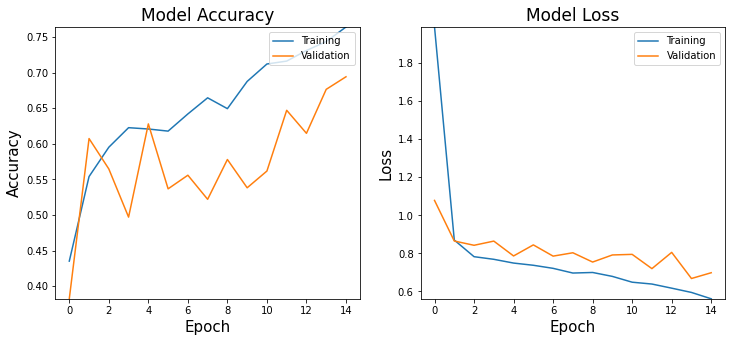

In [21]:
TwoLayerVGG.plot_performance()

# Three Block VGG Model 

In [22]:
ThreeLayerVGG = CNN()

In [23]:
ThreeLayerVGG.build_ThreeLayerVGG()

In [24]:
history3=ThreeLayerVGG.train_model()

[INFO] Training network...
Epoch 1/15


/tmp/ipykernel_3369/2711259985.py:123: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.history = self.model.fit_generator(self.augment.flow(self.X_train, self.y_train, batch_size=BATCH_SIZE),


  1/108 [..............................] - ETA: 2:01 - loss: 1.6562 - accuracy: 0.2800

  2/108 [..............................] - ETA: 45s - loss: 17.4418 - accuracy: 0.3000

  3/108 [..............................] - ETA: 44s - loss: 27.2396 - accuracy: 0.2933

  4/108 [>.............................] - ETA: 43s - loss: 24.6050 - accuracy: 0.2900

  5/108 [>.............................] - ETA: 42s - loss: 20.5365 - accuracy: 0.2480

  6/108 [>.............................] - ETA: 41s - loss: 17.3127 - accuracy: 0.2667

  7/108 [>.............................] - ETA: 40s - loss: 14.9901 - accuracy: 0.3143

  8/108 [=>............................] - ETA: 39s - loss: 13.2585 - accuracy: 0.3350

  9/108 [=>............................] - ETA: 39s - loss: 11.9112 - accuracy: 0.3422

 10/108 [=>............................] - ETA: 38s - loss: 10.8115 - accuracy: 0.3840

 11/108 [==>...........................] - ETA: 37s - loss: 9.9336 - accuracy: 0.3855 

 12/108 [==>...........................] - ETA: 37s - loss: 9.2018 - accuracy: 0.3867

 13/108 [==>...........................] - ETA: 36s - loss: 8.5822 - accuracy: 0.3846

 14/108 [==>...........................] - ETA: 36s - loss: 8.0512 - accuracy: 0.3857

 15/108 [===>..........................] - ETA: 36s - loss: 7.5858 - accuracy: 0.3893

 16/108 [===>..........................] - ETA: 35s - loss: 7.1789 - accuracy: 0.3900

 17/108 [===>..........................] - ETA: 35s - loss: 6.8214 - accuracy: 0.3906

 18/108 [====>.........................] - ETA: 34s - loss: 6.4990 - accuracy: 0.4067

 19/108 [====>.........................] - ETA: 34s - loss: 6.2125 - accuracy: 0.4084

 20/108 [====>.........................] - ETA: 33s - loss: 5.9544 - accuracy: 0.4120

 21/108 [====>.........................] - ETA: 33s - loss: 5.7201 - accuracy: 0.4171

 22/108 [=====>........................] - ETA: 33s - loss: 5.5165 - accuracy: 0.4127

 23/108 [=====>........................] - ETA: 32s - loss: 5.3248 - accuracy: 0.4139

 24/108 [=====>........................] - ETA: 32s - loss: 5.1482 - accuracy: 0.4167

 25/108 [=====>........................] - ETA: 31s - loss: 4.9852 - accuracy: 0.4208

 26/108 [======>.......................] - ETA: 31s - loss: 4.8360 - accuracy: 0.4185

 27/108 [======>.......................] - ETA: 31s - loss: 4.6975 - accuracy: 0.4163

 28/108 [======>.......................] - ETA: 30s - loss: 4.5673 - accuracy: 0.4229

 29/108 [=======>......................] - ETA: 30s - loss: 4.4473 - accuracy: 0.4221

 30/108 [=======>......................] - ETA: 29s - loss: 4.3351 - accuracy: 0.4213

 31/108 [=======>......................] - ETA: 29s - loss: 4.2287 - accuracy: 0.4258

 32/108 [=======>......................] - ETA: 29s - loss: 4.1277 - accuracy: 0.4300

 33/108 [========>.....................] - ETA: 28s - loss: 4.0380 - accuracy: 0.4303

 34/108 [========>.....................] - ETA: 28s - loss: 3.9488 - accuracy: 0.4341

 35/108 [========>.....................] - ETA: 27s - loss: 3.8679 - accuracy: 0.4354

 36/108 [=========>....................] - ETA: 27s - loss: 3.7907 - accuracy: 0.4356

 37/108 [=========>....................] - ETA: 27s - loss: 3.7173 - accuracy: 0.4357

 38/108 [=========>....................] - ETA: 26s - loss: 3.6477 - accuracy: 0.4358

 39/108 [=========>....................] - ETA: 26s - loss: 3.5817 - accuracy: 0.4349

 40/108 [==========>...................] - ETA: 25s - loss: 3.5186 - accuracy: 0.4360

 41/108 [==========>...................] - ETA: 25s - loss: 3.4596 - accuracy: 0.4341

 42/108 [==========>...................] - ETA: 25s - loss: 3.4032 - accuracy: 0.4324

 43/108 [==========>...................] - ETA: 24s - loss: 3.3491 - accuracy: 0.4344

 44/108 [===========>..................] - ETA: 24s - loss: 3.2981 - accuracy: 0.4327

 45/108 [===========>..................] - ETA: 24s - loss: 3.2485 - accuracy: 0.4329

 46/108 [===========>..................] - ETA: 23s - loss: 3.2007 - accuracy: 0.4365

 47/108 [============>.................] - ETA: 23s - loss: 3.1555 - accuracy: 0.4357

 48/108 [============>.................] - ETA: 23s - loss: 3.1125 - accuracy: 0.4350

 49/108 [============>.................] - ETA: 22s - loss: 3.0702 - accuracy: 0.4367

 50/108 [============>.................] - ETA: 22s - loss: 3.0294 - accuracy: 0.4384

 51/108 [=============>................] - ETA: 21s - loss: 2.9904 - accuracy: 0.4384

 52/108 [=============>................] - ETA: 21s - loss: 2.9536 - accuracy: 0.4385

 53/108 [=============>................] - ETA: 21s - loss: 2.9207 - accuracy: 0.4355

 54/108 [==============>...............] - ETA: 20s - loss: 2.8858 - accuracy: 0.4363

 55/108 [==============>...............] - ETA: 20s - loss: 2.8520 - accuracy: 0.4371

 56/108 [==============>...............] - ETA: 20s - loss: 2.8202 - accuracy: 0.4371

 57/108 [==============>...............] - ETA: 19s - loss: 2.7883 - accuracy: 0.4414

 58/108 [===============>..............] - ETA: 19s - loss: 2.7588 - accuracy: 0.4407

 59/108 [===============>..............] - ETA: 18s - loss: 2.7311 - accuracy: 0.4407

 60/108 [===============>..............] - ETA: 18s - loss: 2.7028 - accuracy: 0.4407

 61/108 [===============>..............] - ETA: 18s - loss: 2.6772 - accuracy: 0.4400

 62/108 [================>.............] - ETA: 17s - loss: 2.6502 - accuracy: 0.4406

 63/108 [================>.............] - ETA: 17s - loss: 2.6259 - accuracy: 0.4400

 64/108 [================>.............] - ETA: 16s - loss: 2.6018 - accuracy: 0.4394

 65/108 [=================>............] - ETA: 16s - loss: 2.5803 - accuracy: 0.4375

 66/108 [=================>............] - ETA: 16s - loss: 2.5592 - accuracy: 0.4345

 67/108 [=================>............] - ETA: 15s - loss: 2.5377 - accuracy: 0.4340

 68/108 [=================>............] - ETA: 15s - loss: 2.5159 - accuracy: 0.4376

 69/108 [==================>...........] - ETA: 14s - loss: 2.4950 - accuracy: 0.4388

 70/108 [==================>...........] - ETA: 14s - loss: 2.4748 - accuracy: 0.4383

 71/108 [==================>...........] - ETA: 14s - loss: 2.4554 - accuracy: 0.4377

 72/108 [===================>..........] - ETA: 13s - loss: 2.4362 - accuracy: 0.4372

 73/108 [===================>..........] - ETA: 13s - loss: 2.4177 - accuracy: 0.4373

 74/108 [===================>..........] - ETA: 13s - loss: 2.3994 - accuracy: 0.4389

 75/108 [===================>..........] - ETA: 12s - loss: 2.3819 - accuracy: 0.4389

 76/108 [====================>.........] - ETA: 12s - loss: 2.3649 - accuracy: 0.4379

 77/108 [====================>.........] - ETA: 11s - loss: 2.3484 - accuracy: 0.4369

 78/108 [====================>.........] - ETA: 11s - loss: 2.3325 - accuracy: 0.4349

 79/108 [====================>.........] - ETA: 11s - loss: 2.3168 - accuracy: 0.4344

 80/108 [=====================>........] - ETA: 10s - loss: 2.3011 - accuracy: 0.4350

 81/108 [=====================>........] - ETA: 10s - loss: 2.2861 - accuracy: 0.4351

 82/108 [=====================>........] - ETA: 9s - loss: 2.2715 - accuracy: 0.4341 

 83/108 [======================>.......] - ETA: 9s - loss: 2.2567 - accuracy: 0.4371

 84/108 [======================>.......] - ETA: 9s - loss: 2.2434 - accuracy: 0.4362

 85/108 [======================>.......] - ETA: 8s - loss: 2.2304 - accuracy: 0.4358

 86/108 [======================>.......] - ETA: 8s - loss: 2.2170 - accuracy: 0.4353

 87/108 [=======================>......] - ETA: 8s - loss: 2.2039 - accuracy: 0.4349

 88/108 [=======================>......] - ETA: 7s - loss: 2.1906 - accuracy: 0.4368

 89/108 [=======================>......] - ETA: 7s - loss: 2.1782 - accuracy: 0.4378

 90/108 [========================>.....] - ETA: 6s - loss: 2.1663 - accuracy: 0.4364

 91/108 [========================>.....] - ETA: 6s - loss: 2.1546 - accuracy: 0.4347

 92/108 [========================>.....] - ETA: 6s - loss: 2.1430 - accuracy: 0.4352

 93/108 [========================>.....] - ETA: 5s - loss: 2.1314 - accuracy: 0.4357

 94/108 [=========================>....] - ETA: 5s - loss: 2.1194 - accuracy: 0.4374

 95/108 [=========================>....] - ETA: 4s - loss: 2.1070 - accuracy: 0.4404

 96/108 [=========================>....] - ETA: 4s - loss: 2.0964 - accuracy: 0.4412

 97/108 [=========================>....] - ETA: 4s - loss: 2.0841 - accuracy: 0.4433

 98/108 [==========================>...] - ETA: 3s - loss: 2.0745 - accuracy: 0.4433

 99/108 [==========================>...] - ETA: 3s - loss: 2.0642 - accuracy: 0.4432

100/108 [==========================>...] - ETA: 3s - loss: 2.0534 - accuracy: 0.4440

101/108 [===========================>..] - ETA: 2s - loss: 2.0435 - accuracy: 0.4444

102/108 [===========================>..] - ETA: 2s - loss: 2.0342 - accuracy: 0.4431

103/108 [===========================>..] - ETA: 1s - loss: 2.0253 - accuracy: 0.4419

104/108 [===========================>..] - ETA: 1s - loss: 2.0157 - accuracy: 0.4419

105/108 [============================>.] - ETA: 1s - loss: 2.0063 - accuracy: 0.4430

106/108 [============================>.] - ETA: 0s - loss: 1.9970 - accuracy: 0.4453

107/108 [============================>.] - ETA: 0s - loss: 1.9897 - accuracy: 0.4457

108/108 [==============================] - ETA: 0s - loss: 1.9805 - accuracy: 0.4464

108/108 [==============================] - 44s 403ms/step - loss: 1.9805 - accuracy: 0.4464 - val_loss: 1.0769 - val_accuracy: 0.4353


Epoch 2/15


  1/108 [..............................] - ETA: 1:05 - loss: 0.9454 - accuracy: 0.5600

  2/108 [..............................] - ETA: 44s - loss: 0.9975 - accuracy: 0.5000 

  3/108 [..............................] - ETA: 43s - loss: 0.9943 - accuracy: 0.5200

  4/108 [>.............................] - ETA: 42s - loss: 0.9782 - accuracy: 0.5500

  5/108 [>.............................] - ETA: 41s - loss: 0.9826 - accuracy: 0.5280

  6/108 [>.............................] - ETA: 40s - loss: 0.9933 - accuracy: 0.5000

  7/108 [>.............................] - ETA: 39s - loss: 0.9922 - accuracy: 0.4914

  8/108 [=>............................] - ETA: 39s - loss: 1.0064 - accuracy: 0.4800

  9/108 [=>............................] - ETA: 38s - loss: 0.9873 - accuracy: 0.4889

 10/108 [=>............................] - ETA: 37s - loss: 0.9923 - accuracy: 0.4840

 11/108 [==>...........................] - ETA: 37s - loss: 0.9909 - accuracy: 0.4727

 12/108 [==>...........................] - ETA: 37s - loss: 0.9938 - accuracy: 0.4667

 13/108 [==>...........................] - ETA: 36s - loss: 1.0018 - accuracy: 0.4708

 14/108 [==>...........................] - ETA: 36s - loss: 0.9922 - accuracy: 0.4857

 15/108 [===>..........................] - ETA: 35s - loss: 0.9897 - accuracy: 0.4880

 16/108 [===>..........................] - ETA: 35s - loss: 0.9743 - accuracy: 0.5025

 17/108 [===>..........................] - ETA: 34s - loss: 0.9814 - accuracy: 0.4988

 18/108 [====>.........................] - ETA: 34s - loss: 0.9727 - accuracy: 0.5067

 19/108 [====>.........................] - ETA: 33s - loss: 0.9732 - accuracy: 0.5074

 20/108 [====>.........................] - ETA: 33s - loss: 0.9656 - accuracy: 0.5120

 21/108 [====>.........................] - ETA: 33s - loss: 0.9598 - accuracy: 0.5219

 22/108 [=====>........................] - ETA: 32s - loss: 0.9542 - accuracy: 0.5273

 23/108 [=====>........................] - ETA: 32s - loss: 0.9583 - accuracy: 0.5270

 24/108 [=====>........................] - ETA: 32s - loss: 0.9535 - accuracy: 0.5283

 25/108 [=====>........................] - ETA: 31s - loss: 0.9515 - accuracy: 0.5344

 26/108 [======>.......................] - ETA: 31s - loss: 0.9561 - accuracy: 0.5338

 27/108 [======>.......................] - ETA: 30s - loss: 0.9802 - accuracy: 0.5215

 28/108 [======>.......................] - ETA: 30s - loss: 0.9806 - accuracy: 0.5186

 29/108 [=======>......................] - ETA: 30s - loss: 0.9777 - accuracy: 0.5214

 30/108 [=======>......................] - ETA: 29s - loss: 0.9808 - accuracy: 0.5187

 31/108 [=======>......................] - ETA: 29s - loss: 0.9805 - accuracy: 0.5200

 32/108 [=======>......................] - ETA: 28s - loss: 0.9841 - accuracy: 0.5138

 33/108 [========>.....................] - ETA: 28s - loss: 0.9832 - accuracy: 0.5164

 34/108 [========>.....................] - ETA: 28s - loss: 0.9850 - accuracy: 0.5118

 35/108 [========>.....................] - ETA: 27s - loss: 0.9884 - accuracy: 0.5086

 36/108 [=========>....................] - ETA: 27s - loss: 0.9897 - accuracy: 0.5067

 37/108 [=========>....................] - ETA: 26s - loss: 0.9864 - accuracy: 0.5092

 38/108 [=========>....................] - ETA: 26s - loss: 0.9868 - accuracy: 0.5116

 39/108 [=========>....................] - ETA: 26s - loss: 0.9882 - accuracy: 0.5128

 40/108 [==========>...................] - ETA: 25s - loss: 0.9895 - accuracy: 0.5110

 41/108 [==========>...................] - ETA: 25s - loss: 0.9869 - accuracy: 0.5122

 42/108 [==========>...................] - ETA: 25s - loss: 0.9845 - accuracy: 0.5152

 43/108 [==========>...................] - ETA: 24s - loss: 0.9851 - accuracy: 0.5126

 44/108 [===========>..................] - ETA: 24s - loss: 0.9870 - accuracy: 0.5091

 45/108 [===========>..................] - ETA: 23s - loss: 0.9856 - accuracy: 0.5093

 46/108 [===========>..................] - ETA: 23s - loss: 0.9858 - accuracy: 0.5078

 47/108 [============>.................] - ETA: 23s - loss: 0.9863 - accuracy: 0.5072

 48/108 [============>.................] - ETA: 22s - loss: 0.9839 - accuracy: 0.5092

 49/108 [============>.................] - ETA: 22s - loss: 0.9802 - accuracy: 0.5118

 50/108 [============>.................] - ETA: 21s - loss: 0.9786 - accuracy: 0.5120

 51/108 [=============>................] - ETA: 21s - loss: 0.9765 - accuracy: 0.5122

 52/108 [=============>................] - ETA: 21s - loss: 0.9756 - accuracy: 0.5108

 53/108 [=============>................] - ETA: 20s - loss: 0.9738 - accuracy: 0.5132

 54/108 [==============>...............] - ETA: 20s - loss: 0.9715 - accuracy: 0.5133

 55/108 [==============>...............] - ETA: 20s - loss: 0.9688 - accuracy: 0.5135

 56/108 [==============>...............] - ETA: 19s - loss: 0.9645 - accuracy: 0.5150

 57/108 [==============>...............] - ETA: 19s - loss: 0.9617 - accuracy: 0.5172

 58/108 [===============>..............] - ETA: 18s - loss: 0.9598 - accuracy: 0.5172

 59/108 [===============>..............] - ETA: 18s - loss: 0.9599 - accuracy: 0.5173

 60/108 [===============>..............] - ETA: 18s - loss: 0.9570 - accuracy: 0.5173

 61/108 [===============>..............] - ETA: 17s - loss: 0.9546 - accuracy: 0.5187

 62/108 [================>.............] - ETA: 17s - loss: 0.9516 - accuracy: 0.5187

 63/108 [================>.............] - ETA: 17s - loss: 0.9497 - accuracy: 0.5200

 64/108 [================>.............] - ETA: 16s - loss: 0.9465 - accuracy: 0.5206

 65/108 [=================>............] - ETA: 16s - loss: 0.9433 - accuracy: 0.5206

 66/108 [=================>............] - ETA: 15s - loss: 0.9396 - accuracy: 0.5224

 67/108 [=================>............] - ETA: 15s - loss: 0.9384 - accuracy: 0.5234

 68/108 [=================>............] - ETA: 15s - loss: 0.9395 - accuracy: 0.5233

 69/108 [==================>...........] - ETA: 14s - loss: 0.9352 - accuracy: 0.5256

 70/108 [==================>...........] - ETA: 14s - loss: 0.9308 - accuracy: 0.5289

 71/108 [==================>...........] - ETA: 13s - loss: 0.9282 - accuracy: 0.5311

 72/108 [===================>..........] - ETA: 13s - loss: 0.9265 - accuracy: 0.5326

 73/108 [===================>..........] - ETA: 13s - loss: 0.9272 - accuracy: 0.5308

 74/108 [===================>..........] - ETA: 12s - loss: 0.9254 - accuracy: 0.5301

 75/108 [===================>..........] - ETA: 12s - loss: 0.9247 - accuracy: 0.5289

 76/108 [====================>.........] - ETA: 12s - loss: 0.9221 - accuracy: 0.5303

 77/108 [====================>.........] - ETA: 11s - loss: 0.9200 - accuracy: 0.5307

 78/108 [====================>.........] - ETA: 11s - loss: 0.9181 - accuracy: 0.5321

 79/108 [====================>.........] - ETA: 10s - loss: 0.9151 - accuracy: 0.5340

 80/108 [=====================>........] - ETA: 10s - loss: 0.9129 - accuracy: 0.5348

 81/108 [=====================>........] - ETA: 10s - loss: 0.9109 - accuracy: 0.5361

 82/108 [=====================>........] - ETA: 9s - loss: 0.9083 - accuracy: 0.5384 

 83/108 [======================>.......] - ETA: 9s - loss: 0.9082 - accuracy: 0.5396

 84/108 [======================>.......] - ETA: 9s - loss: 0.9042 - accuracy: 0.5413

 85/108 [======================>.......] - ETA: 8s - loss: 0.9015 - accuracy: 0.5434

 86/108 [======================>.......] - ETA: 8s - loss: 0.9006 - accuracy: 0.5445

 87/108 [=======================>......] - ETA: 7s - loss: 0.9012 - accuracy: 0.5447

 88/108 [=======================>......] - ETA: 7s - loss: 0.9025 - accuracy: 0.5472

 89/108 [=======================>......] - ETA: 7s - loss: 0.9007 - accuracy: 0.5482

 90/108 [========================>.....] - ETA: 6s - loss: 0.8996 - accuracy: 0.5492

 91/108 [========================>.....] - ETA: 6s - loss: 0.8977 - accuracy: 0.5529

 92/108 [========================>.....] - ETA: 6s - loss: 0.8966 - accuracy: 0.5529

 93/108 [========================>.....] - ETA: 5s - loss: 0.8968 - accuracy: 0.5534

 94/108 [=========================>....] - ETA: 5s - loss: 0.8959 - accuracy: 0.5535

 95/108 [=========================>....] - ETA: 4s - loss: 0.8935 - accuracy: 0.5553

 96/108 [=========================>....] - ETA: 4s - loss: 0.8921 - accuracy: 0.5549

 97/108 [=========================>....] - ETA: 4s - loss: 0.8912 - accuracy: 0.5554

 98/108 [==========================>...] - ETA: 3s - loss: 0.8913 - accuracy: 0.5554

 99/108 [==========================>...] - ETA: 3s - loss: 0.8891 - accuracy: 0.5563

100/108 [==========================>...] - ETA: 3s - loss: 0.8873 - accuracy: 0.5567

101/108 [===========================>..] - ETA: 2s - loss: 0.8859 - accuracy: 0.5571

102/108 [===========================>..] - ETA: 2s - loss: 0.8852 - accuracy: 0.5576

103/108 [===========================>..] - ETA: 1s - loss: 0.8856 - accuracy: 0.5576

104/108 [===========================>..] - ETA: 1s - loss: 0.8839 - accuracy: 0.5580

105/108 [============================>.] - ETA: 1s - loss: 0.8809 - accuracy: 0.5599

106/108 [============================>.] - ETA: 0s - loss: 0.8794 - accuracy: 0.5611

107/108 [============================>.] - ETA: 0s - loss: 0.8776 - accuracy: 0.5622

108/108 [==============================] - ETA: 0s - loss: 0.8760 - accuracy: 0.5629

108/108 [==============================] - 43s 399ms/step - loss: 0.8760 - accuracy: 0.5629 - val_loss: 0.8504 - val_accuracy: 0.5397


Epoch 3/15


  1/108 [..............................] - ETA: 1:13 - loss: 0.6016 - accuracy: 0.7600

  2/108 [..............................] - ETA: 33s - loss: 0.6696 - accuracy: 0.6667 

  3/108 [..............................] - ETA: 37s - loss: 0.7260 - accuracy: 0.6286

  4/108 [>.............................] - ETA: 38s - loss: 0.6900 - accuracy: 0.6526

  5/108 [>.............................] - ETA: 38s - loss: 0.7022 - accuracy: 0.6583

  6/108 [>.............................] - ETA: 38s - loss: 0.7428 - accuracy: 0.6414

  7/108 [>.............................] - ETA: 38s - loss: 0.7885 - accuracy: 0.6118

  8/108 [=>............................] - ETA: 37s - loss: 0.7918 - accuracy: 0.6051

  9/108 [=>............................] - ETA: 37s - loss: 0.7873 - accuracy: 0.6091

 10/108 [=>............................] - ETA: 37s - loss: 0.7754 - accuracy: 0.6163

 11/108 [==>...........................] - ETA: 36s - loss: 0.7901 - accuracy: 0.6074

 12/108 [==>...........................] - ETA: 36s - loss: 0.7976 - accuracy: 0.6034

 13/108 [==>...........................] - ETA: 35s - loss: 0.7937 - accuracy: 0.6094

 14/108 [==>...........................] - ETA: 35s - loss: 0.8064 - accuracy: 0.6087

 15/108 [===>..........................] - ETA: 35s - loss: 0.8048 - accuracy: 0.6135

 16/108 [===>..........................] - ETA: 34s - loss: 0.8167 - accuracy: 0.6025

 17/108 [===>..........................] - ETA: 34s - loss: 0.8188 - accuracy: 0.6024

 18/108 [====>.........................] - ETA: 33s - loss: 0.8158 - accuracy: 0.6067

 19/108 [====>.........................] - ETA: 33s - loss: 0.8141 - accuracy: 0.6106

 20/108 [====>.........................] - ETA: 33s - loss: 0.8107 - accuracy: 0.6141

 21/108 [====>.........................] - ETA: 32s - loss: 0.8052 - accuracy: 0.6231

 22/108 [=====>........................] - ETA: 32s - loss: 0.8111 - accuracy: 0.6165

 23/108 [=====>........................] - ETA: 32s - loss: 0.8055 - accuracy: 0.6246

 24/108 [=====>........................] - ETA: 31s - loss: 0.8028 - accuracy: 0.6252

 25/108 [=====>........................] - ETA: 31s - loss: 0.8011 - accuracy: 0.6258

 26/108 [======>.......................] - ETA: 30s - loss: 0.8015 - accuracy: 0.6233

 27/108 [======>.......................] - ETA: 30s - loss: 0.7990 - accuracy: 0.6209

 28/108 [======>.......................] - ETA: 30s - loss: 0.7934 - accuracy: 0.6245

 29/108 [=======>......................] - ETA: 29s - loss: 0.8002 - accuracy: 0.6208

 30/108 [=======>......................] - ETA: 29s - loss: 0.8015 - accuracy: 0.6215

 31/108 [=======>......................] - ETA: 28s - loss: 0.7948 - accuracy: 0.6234

 32/108 [=======>......................] - ETA: 28s - loss: 0.7884 - accuracy: 0.6239

 33/108 [========>.....................] - ETA: 28s - loss: 0.7851 - accuracy: 0.6244

 34/108 [========>.....................] - ETA: 27s - loss: 0.7852 - accuracy: 0.6237

 35/108 [========>.....................] - ETA: 27s - loss: 0.7884 - accuracy: 0.6230

 36/108 [=========>....................] - ETA: 27s - loss: 0.7965 - accuracy: 0.6201

 37/108 [=========>....................] - ETA: 26s - loss: 0.7918 - accuracy: 0.6228

 38/108 [=========>....................] - ETA: 26s - loss: 0.7925 - accuracy: 0.6222

 39/108 [=========>....................] - ETA: 25s - loss: 0.7885 - accuracy: 0.6216

 40/108 [==========>...................] - ETA: 25s - loss: 0.7854 - accuracy: 0.6211

 41/108 [==========>...................] - ETA: 25s - loss: 0.7829 - accuracy: 0.6225

 42/108 [==========>...................] - ETA: 24s - loss: 0.7846 - accuracy: 0.6239

 43/108 [==========>...................] - ETA: 24s - loss: 0.7830 - accuracy: 0.6243

 44/108 [===========>..................] - ETA: 24s - loss: 0.7791 - accuracy: 0.6265

 45/108 [===========>..................] - ETA: 23s - loss: 0.7805 - accuracy: 0.6259

 46/108 [===========>..................] - ETA: 23s - loss: 0.7768 - accuracy: 0.6262

 47/108 [============>.................] - ETA: 22s - loss: 0.7787 - accuracy: 0.6222

 48/108 [============>.................] - ETA: 22s - loss: 0.7761 - accuracy: 0.6226

 49/108 [============>.................] - ETA: 22s - loss: 0.7731 - accuracy: 0.6230

 50/108 [============>.................] - ETA: 21s - loss: 0.7737 - accuracy: 0.6233

 51/108 [=============>................] - ETA: 21s - loss: 0.7738 - accuracy: 0.6244

 52/108 [=============>................] - ETA: 21s - loss: 0.7746 - accuracy: 0.6247

 53/108 [=============>................] - ETA: 20s - loss: 0.7747 - accuracy: 0.6258

 54/108 [==============>...............] - ETA: 20s - loss: 0.7760 - accuracy: 0.6238

 55/108 [==============>...............] - ETA: 19s - loss: 0.7760 - accuracy: 0.6248

 56/108 [==============>...............] - ETA: 19s - loss: 0.7738 - accuracy: 0.6265

 57/108 [==============>...............] - ETA: 19s - loss: 0.7739 - accuracy: 0.6246

 58/108 [===============>..............] - ETA: 18s - loss: 0.7732 - accuracy: 0.6235

 59/108 [===============>..............] - ETA: 18s - loss: 0.7720 - accuracy: 0.6231

 60/108 [===============>..............] - ETA: 18s - loss: 0.7710 - accuracy: 0.6241

 61/108 [===============>..............] - ETA: 17s - loss: 0.7703 - accuracy: 0.6250

 62/108 [================>.............] - ETA: 17s - loss: 0.7689 - accuracy: 0.6265

 63/108 [================>.............] - ETA: 16s - loss: 0.7715 - accuracy: 0.6261

 64/108 [================>.............] - ETA: 16s - loss: 0.7673 - accuracy: 0.6288

 65/108 [=================>............] - ETA: 16s - loss: 0.7691 - accuracy: 0.6272

 66/108 [=================>............] - ETA: 15s - loss: 0.7650 - accuracy: 0.6292

 67/108 [=================>............] - ETA: 15s - loss: 0.7641 - accuracy: 0.6293

 68/108 [=================>............] - ETA: 15s - loss: 0.7623 - accuracy: 0.6301

 69/108 [==================>...........] - ETA: 14s - loss: 0.7615 - accuracy: 0.6297

 70/108 [==================>...........] - ETA: 14s - loss: 0.7632 - accuracy: 0.6269

 71/108 [==================>...........] - ETA: 13s - loss: 0.7609 - accuracy: 0.6282

 72/108 [===================>..........] - ETA: 13s - loss: 0.7591 - accuracy: 0.6295

 73/108 [===================>..........] - ETA: 13s - loss: 0.7612 - accuracy: 0.6280

 74/108 [===================>..........] - ETA: 12s - loss: 0.7603 - accuracy: 0.6304

 75/108 [===================>..........] - ETA: 12s - loss: 0.7565 - accuracy: 0.6326

 76/108 [====================>.........] - ETA: 12s - loss: 0.7579 - accuracy: 0.6306

 77/108 [====================>.........] - ETA: 11s - loss: 0.7552 - accuracy: 0.6313

 78/108 [====================>.........] - ETA: 11s - loss: 0.7557 - accuracy: 0.6314

 79/108 [====================>.........] - ETA: 10s - loss: 0.7571 - accuracy: 0.6299

 80/108 [=====================>........] - ETA: 10s - loss: 0.7571 - accuracy: 0.6301

 81/108 [=====================>........] - ETA: 10s - loss: 0.7545 - accuracy: 0.6307

 82/108 [=====================>........] - ETA: 9s - loss: 0.7566 - accuracy: 0.6308 

 83/108 [======================>.......] - ETA: 9s - loss: 0.7566 - accuracy: 0.6314

 84/108 [======================>.......] - ETA: 9s - loss: 0.7566 - accuracy: 0.6320

 85/108 [======================>.......] - ETA: 8s - loss: 0.7589 - accuracy: 0.6330

 86/108 [======================>.......] - ETA: 8s - loss: 0.7558 - accuracy: 0.6345

 87/108 [=======================>......] - ETA: 7s - loss: 0.7542 - accuracy: 0.6359

 88/108 [=======================>......] - ETA: 7s - loss: 0.7523 - accuracy: 0.6383

 89/108 [=======================>......] - ETA: 7s - loss: 0.7514 - accuracy: 0.6401

 90/108 [========================>.....] - ETA: 6s - loss: 0.7515 - accuracy: 0.6396

 91/108 [========================>.....] - ETA: 6s - loss: 0.7520 - accuracy: 0.6383

 92/108 [========================>.....] - ETA: 6s - loss: 0.7529 - accuracy: 0.6383

 93/108 [========================>.....] - ETA: 5s - loss: 0.7534 - accuracy: 0.6379

 94/108 [=========================>....] - ETA: 5s - loss: 0.7544 - accuracy: 0.6362

 95/108 [=========================>....] - ETA: 4s - loss: 0.7528 - accuracy: 0.6367

 96/108 [=========================>....] - ETA: 4s - loss: 0.7534 - accuracy: 0.6359

 97/108 [=========================>....] - ETA: 4s - loss: 0.7544 - accuracy: 0.6360

 98/108 [==========================>...] - ETA: 3s - loss: 0.7537 - accuracy: 0.6356

 99/108 [==========================>...] - ETA: 3s - loss: 0.7519 - accuracy: 0.6364

100/108 [==========================>...] - ETA: 3s - loss: 0.7498 - accuracy: 0.6377

101/108 [===========================>..] - ETA: 2s - loss: 0.7501 - accuracy: 0.6369

102/108 [===========================>..] - ETA: 2s - loss: 0.7494 - accuracy: 0.6373

103/108 [===========================>..] - ETA: 1s - loss: 0.7520 - accuracy: 0.6354

104/108 [===========================>..] - ETA: 1s - loss: 0.7511 - accuracy: 0.6366

105/108 [============================>.] - ETA: 1s - loss: 0.7504 - accuracy: 0.6366

106/108 [============================>.] - ETA: 0s - loss: 0.7498 - accuracy: 0.6363

107/108 [============================>.] - ETA: 0s - loss: 0.7501 - accuracy: 0.6352

108/108 [==============================] - ETA: 0s - loss: 0.7491 - accuracy: 0.6364

108/108 [==============================] - 43s 398ms/step - loss: 0.7491 - accuracy: 0.6364 - val_loss: 0.8079 - val_accuracy: 0.6162


Epoch 4/15


  1/108 [..............................] - ETA: 1:09 - loss: 0.7585 - accuracy: 0.6800

  2/108 [..............................] - ETA: 41s - loss: 0.7644 - accuracy: 0.7000 

  3/108 [..............................] - ETA: 42s - loss: 0.8091 - accuracy: 0.6667

  4/108 [>.............................] - ETA: 42s - loss: 0.8109 - accuracy: 0.6500

  5/108 [>.............................] - ETA: 41s - loss: 0.7757 - accuracy: 0.6560

  6/108 [>.............................] - ETA: 40s - loss: 0.7582 - accuracy: 0.6600

  7/108 [>.............................] - ETA: 39s - loss: 0.7346 - accuracy: 0.6800

  8/108 [=>............................] - ETA: 39s - loss: 0.7056 - accuracy: 0.7000

  9/108 [=>............................] - ETA: 38s - loss: 0.7143 - accuracy: 0.7022

 10/108 [=>............................] - ETA: 38s - loss: 0.6966 - accuracy: 0.7080

 11/108 [==>...........................] - ETA: 37s - loss: 0.7061 - accuracy: 0.7018

 12/108 [==>...........................] - ETA: 37s - loss: 0.6931 - accuracy: 0.7100

 13/108 [==>...........................] - ETA: 36s - loss: 0.6916 - accuracy: 0.7138

 14/108 [==>...........................] - ETA: 36s - loss: 0.7091 - accuracy: 0.6886

 15/108 [===>..........................] - ETA: 35s - loss: 0.7042 - accuracy: 0.6892

 16/108 [===>..........................] - ETA: 34s - loss: 0.7015 - accuracy: 0.6861

 17/108 [===>..........................] - ETA: 34s - loss: 0.6996 - accuracy: 0.6881

 18/108 [====>.........................] - ETA: 34s - loss: 0.7053 - accuracy: 0.6854

 19/108 [====>.........................] - ETA: 33s - loss: 0.7094 - accuracy: 0.6830

 20/108 [====>.........................] - ETA: 33s - loss: 0.7080 - accuracy: 0.6848

 21/108 [====>.........................] - ETA: 33s - loss: 0.7173 - accuracy: 0.6750

 22/108 [=====>........................] - ETA: 32s - loss: 0.7154 - accuracy: 0.6752

 23/108 [=====>........................] - ETA: 32s - loss: 0.7112 - accuracy: 0.6737

 24/108 [=====>........................] - ETA: 31s - loss: 0.7146 - accuracy: 0.6706

 25/108 [=====>........................] - ETA: 31s - loss: 0.7067 - accuracy: 0.6742

 26/108 [======>.......................] - ETA: 31s - loss: 0.7057 - accuracy: 0.6744

 27/108 [======>.......................] - ETA: 30s - loss: 0.7042 - accuracy: 0.6716

 28/108 [======>.......................] - ETA: 30s - loss: 0.7086 - accuracy: 0.6676

 29/108 [=======>......................] - ETA: 29s - loss: 0.7016 - accuracy: 0.6722

 30/108 [=======>......................] - ETA: 29s - loss: 0.6988 - accuracy: 0.6711

 31/108 [=======>......................] - ETA: 29s - loss: 0.6923 - accuracy: 0.6740

 32/108 [=======>......................] - ETA: 28s - loss: 0.6970 - accuracy: 0.6679

 33/108 [========>.....................] - ETA: 28s - loss: 0.6966 - accuracy: 0.6671

 34/108 [========>.....................] - ETA: 28s - loss: 0.7035 - accuracy: 0.6615

 35/108 [========>.....................] - ETA: 27s - loss: 0.7115 - accuracy: 0.6632

 36/108 [=========>....................] - ETA: 27s - loss: 0.7159 - accuracy: 0.6592

 37/108 [=========>....................] - ETA: 26s - loss: 0.7189 - accuracy: 0.6565

 38/108 [=========>....................] - ETA: 26s - loss: 0.7160 - accuracy: 0.6582

 39/108 [=========>....................] - ETA: 26s - loss: 0.7153 - accuracy: 0.6598

 40/108 [==========>...................] - ETA: 25s - loss: 0.7149 - accuracy: 0.6613

 41/108 [==========>...................] - ETA: 25s - loss: 0.7082 - accuracy: 0.6676

 42/108 [==========>...................] - ETA: 24s - loss: 0.7091 - accuracy: 0.6689

 43/108 [==========>...................] - ETA: 24s - loss: 0.7114 - accuracy: 0.6673

 44/108 [===========>..................] - ETA: 24s - loss: 0.7101 - accuracy: 0.6676

 45/108 [===========>..................] - ETA: 23s - loss: 0.7104 - accuracy: 0.6687

 46/108 [===========>..................] - ETA: 23s - loss: 0.7066 - accuracy: 0.6725

 47/108 [============>.................] - ETA: 23s - loss: 0.7054 - accuracy: 0.6744

 48/108 [============>.................] - ETA: 22s - loss: 0.7012 - accuracy: 0.6762

 49/108 [============>.................] - ETA: 22s - loss: 0.7000 - accuracy: 0.6779

 50/108 [============>.................] - ETA: 21s - loss: 0.7000 - accuracy: 0.6771

 51/108 [=============>................] - ETA: 21s - loss: 0.6999 - accuracy: 0.6772

 52/108 [=============>................] - ETA: 21s - loss: 0.7004 - accuracy: 0.6772

 53/108 [=============>................] - ETA: 20s - loss: 0.7014 - accuracy: 0.6765

 54/108 [==============>...............] - ETA: 20s - loss: 0.7031 - accuracy: 0.6751

 55/108 [==============>...............] - ETA: 20s - loss: 0.7063 - accuracy: 0.6737

 56/108 [==============>...............] - ETA: 19s - loss: 0.7061 - accuracy: 0.6738

 57/108 [==============>...............] - ETA: 19s - loss: 0.7105 - accuracy: 0.6725

 58/108 [===============>..............] - ETA: 18s - loss: 0.7094 - accuracy: 0.6734

 59/108 [===============>..............] - ETA: 18s - loss: 0.7119 - accuracy: 0.6714

 60/108 [===============>..............] - ETA: 18s - loss: 0.7154 - accuracy: 0.6696

 61/108 [===============>..............] - ETA: 17s - loss: 0.7153 - accuracy: 0.6704

 62/108 [================>.............] - ETA: 17s - loss: 0.7124 - accuracy: 0.6731

 63/108 [================>.............] - ETA: 16s - loss: 0.7132 - accuracy: 0.6726

 64/108 [================>.............] - ETA: 16s - loss: 0.7104 - accuracy: 0.6752

 65/108 [=================>............] - ETA: 16s - loss: 0.7073 - accuracy: 0.6778

 66/108 [=================>............] - ETA: 15s - loss: 0.7059 - accuracy: 0.6784

 67/108 [=================>............] - ETA: 15s - loss: 0.7039 - accuracy: 0.6802

 68/108 [=================>............] - ETA: 15s - loss: 0.7037 - accuracy: 0.6814

 69/108 [==================>...........] - ETA: 14s - loss: 0.7068 - accuracy: 0.6785

 70/108 [==================>...........] - ETA: 14s - loss: 0.7029 - accuracy: 0.6808

 71/108 [==================>...........] - ETA: 13s - loss: 0.7010 - accuracy: 0.6802

 72/108 [===================>..........] - ETA: 13s - loss: 0.6999 - accuracy: 0.6813

 73/108 [===================>..........] - ETA: 13s - loss: 0.7010 - accuracy: 0.6802

 74/108 [===================>..........] - ETA: 12s - loss: 0.7036 - accuracy: 0.6780

 75/108 [===================>..........] - ETA: 12s - loss: 0.7049 - accuracy: 0.6765

 76/108 [====================>.........] - ETA: 12s - loss: 0.7061 - accuracy: 0.6760

 77/108 [====================>.........] - ETA: 11s - loss: 0.7060 - accuracy: 0.6760

 78/108 [====================>.........] - ETA: 11s - loss: 0.7090 - accuracy: 0.6735

 79/108 [====================>.........] - ETA: 10s - loss: 0.7075 - accuracy: 0.6736

 80/108 [=====================>........] - ETA: 10s - loss: 0.7038 - accuracy: 0.6762

 81/108 [=====================>........] - ETA: 10s - loss: 0.7028 - accuracy: 0.6777

 82/108 [=====================>........] - ETA: 9s - loss: 0.7032 - accuracy: 0.6763 

 83/108 [======================>.......] - ETA: 9s - loss: 0.7030 - accuracy: 0.6778

 84/108 [======================>.......] - ETA: 9s - loss: 0.7025 - accuracy: 0.6778

 85/108 [======================>.......] - ETA: 8s - loss: 0.7007 - accuracy: 0.6792

 86/108 [======================>.......] - ETA: 8s - loss: 0.7012 - accuracy: 0.6793

 87/108 [=======================>......] - ETA: 7s - loss: 0.7074 - accuracy: 0.6793

 88/108 [=======================>......] - ETA: 7s - loss: 0.7050 - accuracy: 0.6802

 89/108 [=======================>......] - ETA: 7s - loss: 0.7052 - accuracy: 0.6793

 90/108 [========================>.....] - ETA: 6s - loss: 0.7038 - accuracy: 0.6793

 91/108 [========================>.....] - ETA: 6s - loss: 0.7012 - accuracy: 0.6806

 92/108 [========================>.....] - ETA: 6s - loss: 0.7017 - accuracy: 0.6802

 93/108 [========================>.....] - ETA: 5s - loss: 0.7054 - accuracy: 0.6780

 94/108 [=========================>....] - ETA: 5s - loss: 0.7042 - accuracy: 0.6785

 95/108 [=========================>....] - ETA: 4s - loss: 0.7037 - accuracy: 0.6789

 96/108 [=========================>....] - ETA: 4s - loss: 0.7034 - accuracy: 0.6797

 97/108 [=========================>....] - ETA: 4s - loss: 0.7014 - accuracy: 0.6810

 98/108 [==========================>...] - ETA: 3s - loss: 0.7010 - accuracy: 0.6818

 99/108 [==========================>...] - ETA: 3s - loss: 0.6996 - accuracy: 0.6822

100/108 [==========================>...] - ETA: 3s - loss: 0.7004 - accuracy: 0.6818

101/108 [===========================>..] - ETA: 2s - loss: 0.6988 - accuracy: 0.6825

102/108 [===========================>..] - ETA: 2s - loss: 0.6987 - accuracy: 0.6825

103/108 [===========================>..] - ETA: 1s - loss: 0.6974 - accuracy: 0.6821

104/108 [===========================>..] - ETA: 1s - loss: 0.6971 - accuracy: 0.6825

105/108 [============================>.] - ETA: 1s - loss: 0.6943 - accuracy: 0.6840

106/108 [============================>.] - ETA: 0s - loss: 0.6924 - accuracy: 0.6847

107/108 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.6846

108/108 [==============================] - ETA: 0s - loss: 0.6903 - accuracy: 0.6857

108/108 [==============================] - 43s 397ms/step - loss: 0.6903 - accuracy: 0.6857 - val_loss: 0.8157 - val_accuracy: 0.6603


Epoch 5/15


  1/108 [..............................] - ETA: 1:09 - loss: 0.8285 - accuracy: 0.6000

  2/108 [..............................] - ETA: 46s - loss: 0.6462 - accuracy: 0.7000 

  3/108 [..............................] - ETA: 43s - loss: 0.6492 - accuracy: 0.6800

  4/108 [>.............................] - ETA: 42s - loss: 0.6477 - accuracy: 0.6900

  5/108 [>.............................] - ETA: 41s - loss: 0.6603 - accuracy: 0.7040

  6/108 [>.............................] - ETA: 40s - loss: 0.6411 - accuracy: 0.7133

  7/108 [>.............................] - ETA: 40s - loss: 0.6403 - accuracy: 0.6971

  8/108 [=>............................] - ETA: 39s - loss: 0.6331 - accuracy: 0.6950

  9/108 [=>............................] - ETA: 39s - loss: 0.6276 - accuracy: 0.7111

 10/108 [=>............................] - ETA: 38s - loss: 0.6546 - accuracy: 0.7080

 11/108 [==>...........................] - ETA: 37s - loss: 0.6718 - accuracy: 0.7055

 12/108 [==>...........................] - ETA: 37s - loss: 0.6711 - accuracy: 0.6967

 13/108 [==>...........................] - ETA: 37s - loss: 0.6814 - accuracy: 0.6892

 14/108 [==>...........................] - ETA: 36s - loss: 0.6804 - accuracy: 0.6886

 15/108 [===>..........................] - ETA: 36s - loss: 0.6713 - accuracy: 0.6960

 16/108 [===>..........................] - ETA: 35s - loss: 0.6873 - accuracy: 0.6825

 17/108 [===>..........................] - ETA: 35s - loss: 0.6846 - accuracy: 0.6894

 18/108 [====>.........................] - ETA: 34s - loss: 0.6833 - accuracy: 0.6867

 19/108 [====>.........................] - ETA: 34s - loss: 0.6834 - accuracy: 0.6884

 20/108 [====>.........................] - ETA: 33s - loss: 0.6879 - accuracy: 0.6900

 21/108 [====>.........................] - ETA: 33s - loss: 0.6883 - accuracy: 0.6876

 22/108 [=====>........................] - ETA: 32s - loss: 0.6900 - accuracy: 0.6818

 23/108 [=====>........................] - ETA: 32s - loss: 0.6929 - accuracy: 0.6835

 24/108 [=====>........................] - ETA: 32s - loss: 0.6903 - accuracy: 0.6833

 25/108 [=====>........................] - ETA: 31s - loss: 0.6922 - accuracy: 0.6800

 26/108 [======>.......................] - ETA: 31s - loss: 0.6871 - accuracy: 0.6831

 27/108 [======>.......................] - ETA: 30s - loss: 0.6863 - accuracy: 0.6830

 28/108 [======>.......................] - ETA: 30s - loss: 0.6841 - accuracy: 0.6843

 29/108 [=======>......................] - ETA: 29s - loss: 0.6766 - accuracy: 0.6869

 30/108 [=======>......................] - ETA: 29s - loss: 0.6717 - accuracy: 0.6893

 31/108 [=======>......................] - ETA: 29s - loss: 0.6703 - accuracy: 0.6903

 32/108 [=======>......................] - ETA: 28s - loss: 0.6704 - accuracy: 0.6875

 33/108 [========>.....................] - ETA: 28s - loss: 0.6676 - accuracy: 0.6861

 34/108 [========>.....................] - ETA: 27s - loss: 0.6629 - accuracy: 0.6882

 35/108 [========>.....................] - ETA: 27s - loss: 0.6629 - accuracy: 0.6880

 36/108 [=========>....................] - ETA: 27s - loss: 0.6688 - accuracy: 0.6844

 37/108 [=========>....................] - ETA: 26s - loss: 0.6780 - accuracy: 0.6822

 38/108 [=========>....................] - ETA: 26s - loss: 0.6825 - accuracy: 0.6811

 39/108 [=========>....................] - ETA: 26s - loss: 0.6827 - accuracy: 0.6800

 40/108 [==========>...................] - ETA: 25s - loss: 0.6840 - accuracy: 0.6790

 41/108 [==========>...................] - ETA: 25s - loss: 0.6839 - accuracy: 0.6810

 42/108 [==========>...................] - ETA: 24s - loss: 0.6847 - accuracy: 0.6790

 43/108 [==========>...................] - ETA: 24s - loss: 0.6824 - accuracy: 0.6809

 44/108 [===========>..................] - ETA: 24s - loss: 0.6835 - accuracy: 0.6773

 45/108 [===========>..................] - ETA: 23s - loss: 0.6804 - accuracy: 0.6773

 46/108 [===========>..................] - ETA: 23s - loss: 0.6815 - accuracy: 0.6757

 47/108 [============>.................] - ETA: 22s - loss: 0.6783 - accuracy: 0.6757

 48/108 [============>.................] - ETA: 22s - loss: 0.6797 - accuracy: 0.6750

 49/108 [============>.................] - ETA: 22s - loss: 0.6786 - accuracy: 0.6759

 50/108 [============>.................] - ETA: 21s - loss: 0.6830 - accuracy: 0.6768

 51/108 [=============>................] - ETA: 21s - loss: 0.6818 - accuracy: 0.6761

 52/108 [=============>................] - ETA: 21s - loss: 0.6818 - accuracy: 0.6746

 53/108 [=============>................] - ETA: 20s - loss: 0.6817 - accuracy: 0.6725

 54/108 [==============>...............] - ETA: 20s - loss: 0.6815 - accuracy: 0.6711

 55/108 [==============>...............] - ETA: 19s - loss: 0.6846 - accuracy: 0.6676

 56/108 [==============>...............] - ETA: 19s - loss: 0.6866 - accuracy: 0.6659

 57/108 [==============>...............] - ETA: 19s - loss: 0.6913 - accuracy: 0.6634

 58/108 [===============>..............] - ETA: 18s - loss: 0.6889 - accuracy: 0.6644

 59/108 [===============>..............] - ETA: 18s - loss: 0.6878 - accuracy: 0.6667

 60/108 [===============>..............] - ETA: 17s - loss: 0.6893 - accuracy: 0.6676

 61/108 [===============>..............] - ETA: 17s - loss: 0.6886 - accuracy: 0.6678

 62/108 [================>.............] - ETA: 17s - loss: 0.6875 - accuracy: 0.6686

 63/108 [================>.............] - ETA: 16s - loss: 0.6863 - accuracy: 0.6682

 64/108 [================>.............] - ETA: 16s - loss: 0.6853 - accuracy: 0.6690

 65/108 [=================>............] - ETA: 16s - loss: 0.6840 - accuracy: 0.6679

 66/108 [=================>............] - ETA: 15s - loss: 0.6823 - accuracy: 0.6699

 67/108 [=================>............] - ETA: 15s - loss: 0.6800 - accuracy: 0.6719

 68/108 [=================>............] - ETA: 14s - loss: 0.6800 - accuracy: 0.6726

 69/108 [==================>...........] - ETA: 14s - loss: 0.6780 - accuracy: 0.6738

 70/108 [==================>...........] - ETA: 14s - loss: 0.6786 - accuracy: 0.6739

 71/108 [==================>...........] - ETA: 13s - loss: 0.6798 - accuracy: 0.6734

 72/108 [===================>..........] - ETA: 13s - loss: 0.6781 - accuracy: 0.6752

 73/108 [===================>..........] - ETA: 13s - loss: 0.6776 - accuracy: 0.6753

 74/108 [===================>..........] - ETA: 12s - loss: 0.6780 - accuracy: 0.6759

 75/108 [===================>..........] - ETA: 12s - loss: 0.6768 - accuracy: 0.6754

 76/108 [====================>.........] - ETA: 11s - loss: 0.6760 - accuracy: 0.6760

 77/108 [====================>.........] - ETA: 11s - loss: 0.6761 - accuracy: 0.6771

 78/108 [====================>.........] - ETA: 11s - loss: 0.6759 - accuracy: 0.6781

 79/108 [====================>.........] - ETA: 10s - loss: 0.6734 - accuracy: 0.6802

 80/108 [=====================>........] - ETA: 10s - loss: 0.6730 - accuracy: 0.6792

 81/108 [=====================>........] - ETA: 10s - loss: 0.6704 - accuracy: 0.6807

 82/108 [=====================>........] - ETA: 9s - loss: 0.6714 - accuracy: 0.6787 

 83/108 [======================>.......] - ETA: 9s - loss: 0.6726 - accuracy: 0.6787

 84/108 [======================>.......] - ETA: 8s - loss: 0.6745 - accuracy: 0.6778

 85/108 [======================>.......] - ETA: 8s - loss: 0.6719 - accuracy: 0.6788

 86/108 [======================>.......] - ETA: 8s - loss: 0.6736 - accuracy: 0.6774

 87/108 [=======================>......] - ETA: 7s - loss: 0.6732 - accuracy: 0.6774

 88/108 [=======================>......] - ETA: 7s - loss: 0.6727 - accuracy: 0.6784

 89/108 [=======================>......] - ETA: 7s - loss: 0.6770 - accuracy: 0.6766

 90/108 [========================>.....] - ETA: 6s - loss: 0.6770 - accuracy: 0.6771

 91/108 [========================>.....] - ETA: 6s - loss: 0.6749 - accuracy: 0.6793

 92/108 [========================>.....] - ETA: 5s - loss: 0.6765 - accuracy: 0.6776

 93/108 [========================>.....] - ETA: 5s - loss: 0.6763 - accuracy: 0.6780

 94/108 [=========================>....] - ETA: 5s - loss: 0.6778 - accuracy: 0.6772

 95/108 [=========================>....] - ETA: 4s - loss: 0.6773 - accuracy: 0.6772

 96/108 [=========================>....] - ETA: 4s - loss: 0.6775 - accuracy: 0.6777

 97/108 [=========================>....] - ETA: 4s - loss: 0.6766 - accuracy: 0.6777

 98/108 [==========================>...] - ETA: 3s - loss: 0.6761 - accuracy: 0.6781

 99/108 [==========================>...] - ETA: 3s - loss: 0.6773 - accuracy: 0.6773

100/108 [==========================>...] - ETA: 2s - loss: 0.6771 - accuracy: 0.6786

101/108 [===========================>..] - ETA: 2s - loss: 0.6768 - accuracy: 0.6786

102/108 [===========================>..] - ETA: 2s - loss: 0.6769 - accuracy: 0.6790

103/108 [===========================>..] - ETA: 1s - loss: 0.6762 - accuracy: 0.6786

104/108 [===========================>..] - ETA: 1s - loss: 0.6755 - accuracy: 0.6794

105/108 [============================>.] - ETA: 1s - loss: 0.6739 - accuracy: 0.6805

106/108 [============================>.] - ETA: 0s - loss: 0.6723 - accuracy: 0.6817

107/108 [============================>.] - ETA: 0s - loss: 0.6730 - accuracy: 0.6824

108/108 [==============================] - ETA: 0s - loss: 0.6714 - accuracy: 0.6842

108/108 [==============================] - 43s 395ms/step - loss: 0.6714 - accuracy: 0.6842 - val_loss: 0.7550 - val_accuracy: 0.6265


Epoch 6/15


  1/108 [..............................] - ETA: 1:11 - loss: 0.6020 - accuracy: 0.6800

  2/108 [..............................] - ETA: 45s - loss: 0.5250 - accuracy: 0.7600 

  3/108 [..............................] - ETA: 42s - loss: 0.6500 - accuracy: 0.6933

  4/108 [>.............................] - ETA: 41s - loss: 0.6774 - accuracy: 0.7100

  5/108 [>.............................] - ETA: 43s - loss: 0.6744 - accuracy: 0.7040

  6/108 [>.............................] - ETA: 43s - loss: 0.6532 - accuracy: 0.7267

  7/108 [>.............................] - ETA: 42s - loss: 0.6290 - accuracy: 0.7486

  8/108 [=>............................] - ETA: 41s - loss: 0.6214 - accuracy: 0.7550

  9/108 [=>............................] - ETA: 40s - loss: 0.6138 - accuracy: 0.7511

 10/108 [=>............................] - ETA: 39s - loss: 0.6144 - accuracy: 0.7400

 11/108 [==>...........................] - ETA: 38s - loss: 0.6116 - accuracy: 0.7455

 12/108 [==>...........................] - ETA: 38s - loss: 0.5896 - accuracy: 0.7600

 13/108 [==>...........................] - ETA: 37s - loss: 0.5961 - accuracy: 0.7569

 14/108 [==>...........................] - ETA: 37s - loss: 0.6061 - accuracy: 0.7514

 15/108 [===>..........................] - ETA: 36s - loss: 0.5961 - accuracy: 0.7573

 16/108 [===>..........................] - ETA: 36s - loss: 0.5960 - accuracy: 0.7575

 17/108 [===>..........................] - ETA: 35s - loss: 0.5872 - accuracy: 0.7553

 18/108 [====>.........................] - ETA: 35s - loss: 0.5877 - accuracy: 0.7511

 19/108 [====>.........................] - ETA: 34s - loss: 0.5934 - accuracy: 0.7432

 20/108 [====>.........................] - ETA: 34s - loss: 0.5981 - accuracy: 0.7400

 21/108 [====>.........................] - ETA: 33s - loss: 0.5982 - accuracy: 0.7390

 22/108 [=====>........................] - ETA: 33s - loss: 0.5986 - accuracy: 0.7382

 23/108 [=====>........................] - ETA: 32s - loss: 0.5985 - accuracy: 0.7374

 24/108 [=====>........................] - ETA: 32s - loss: 0.5939 - accuracy: 0.7400

 25/108 [=====>........................] - ETA: 32s - loss: 0.5970 - accuracy: 0.7360

 26/108 [======>.......................] - ETA: 31s - loss: 0.5960 - accuracy: 0.7369

 27/108 [======>.......................] - ETA: 31s - loss: 0.6065 - accuracy: 0.7319

 28/108 [======>.......................] - ETA: 30s - loss: 0.6048 - accuracy: 0.7329

 29/108 [=======>......................] - ETA: 30s - loss: 0.5997 - accuracy: 0.7352

 30/108 [=======>......................] - ETA: 29s - loss: 0.6098 - accuracy: 0.7347

 31/108 [=======>......................] - ETA: 29s - loss: 0.6120 - accuracy: 0.7316

 32/108 [=======>......................] - ETA: 29s - loss: 0.6106 - accuracy: 0.7337

 33/108 [========>.....................] - ETA: 28s - loss: 0.6024 - accuracy: 0.7382

 34/108 [========>.....................] - ETA: 28s - loss: 0.6003 - accuracy: 0.7400

 35/108 [========>.....................] - ETA: 27s - loss: 0.6003 - accuracy: 0.7417

 36/108 [=========>....................] - ETA: 27s - loss: 0.5984 - accuracy: 0.7411

 37/108 [=========>....................] - ETA: 27s - loss: 0.5964 - accuracy: 0.7416

 38/108 [=========>....................] - ETA: 26s - loss: 0.5959 - accuracy: 0.7421

 39/108 [=========>....................] - ETA: 26s - loss: 0.5930 - accuracy: 0.7436

 40/108 [==========>...................] - ETA: 25s - loss: 0.5976 - accuracy: 0.7420

 41/108 [==========>...................] - ETA: 25s - loss: 0.6036 - accuracy: 0.7395

 42/108 [==========>...................] - ETA: 25s - loss: 0.6064 - accuracy: 0.7362

 43/108 [==========>...................] - ETA: 24s - loss: 0.6001 - accuracy: 0.7405

 44/108 [===========>..................] - ETA: 24s - loss: 0.6030 - accuracy: 0.7391

 45/108 [===========>..................] - ETA: 23s - loss: 0.5981 - accuracy: 0.7429

 46/108 [===========>..................] - ETA: 23s - loss: 0.6000 - accuracy: 0.7415

 47/108 [============>.................] - ETA: 23s - loss: 0.6004 - accuracy: 0.7402

 48/108 [============>.................] - ETA: 22s - loss: 0.5994 - accuracy: 0.7414

 49/108 [============>.................] - ETA: 22s - loss: 0.5993 - accuracy: 0.7426

 50/108 [============>.................] - ETA: 21s - loss: 0.5985 - accuracy: 0.7414

 51/108 [=============>................] - ETA: 21s - loss: 0.6041 - accuracy: 0.7394

 52/108 [=============>................] - ETA: 21s - loss: 0.6066 - accuracy: 0.7367

 53/108 [=============>................] - ETA: 20s - loss: 0.6073 - accuracy: 0.7371

 54/108 [==============>...............] - ETA: 20s - loss: 0.6079 - accuracy: 0.7368

 55/108 [==============>...............] - ETA: 20s - loss: 0.6112 - accuracy: 0.7343

 56/108 [==============>...............] - ETA: 19s - loss: 0.6124 - accuracy: 0.7333

 57/108 [==============>...............] - ETA: 19s - loss: 0.6093 - accuracy: 0.7359

 58/108 [===============>..............] - ETA: 18s - loss: 0.6056 - accuracy: 0.7370

 59/108 [===============>..............] - ETA: 18s - loss: 0.6060 - accuracy: 0.7361

 60/108 [===============>..............] - ETA: 18s - loss: 0.6067 - accuracy: 0.7351

 61/108 [===============>..............] - ETA: 17s - loss: 0.6061 - accuracy: 0.7355

 62/108 [================>.............] - ETA: 17s - loss: 0.6055 - accuracy: 0.7359

 63/108 [================>.............] - ETA: 17s - loss: 0.6076 - accuracy: 0.7338

 64/108 [================>.............] - ETA: 16s - loss: 0.6074 - accuracy: 0.7342

 65/108 [=================>............] - ETA: 16s - loss: 0.6125 - accuracy: 0.7346

 66/108 [=================>............] - ETA: 15s - loss: 0.6116 - accuracy: 0.7350

 67/108 [=================>............] - ETA: 15s - loss: 0.6122 - accuracy: 0.7341

 68/108 [=================>............] - ETA: 15s - loss: 0.6111 - accuracy: 0.7333

 69/108 [==================>...........] - ETA: 14s - loss: 0.6145 - accuracy: 0.7326

 70/108 [==================>...........] - ETA: 14s - loss: 0.6121 - accuracy: 0.7347

 71/108 [==================>...........] - ETA: 13s - loss: 0.6117 - accuracy: 0.7345

 72/108 [===================>..........] - ETA: 13s - loss: 0.6118 - accuracy: 0.7343

 73/108 [===================>..........] - ETA: 13s - loss: 0.6137 - accuracy: 0.7335

 74/108 [===================>..........] - ETA: 12s - loss: 0.6124 - accuracy: 0.7339

 75/108 [===================>..........] - ETA: 12s - loss: 0.6105 - accuracy: 0.7353

 76/108 [====================>.........] - ETA: 12s - loss: 0.6104 - accuracy: 0.7346

 77/108 [====================>.........] - ETA: 11s - loss: 0.6097 - accuracy: 0.7359

 78/108 [====================>.........] - ETA: 11s - loss: 0.6079 - accuracy: 0.7368

 79/108 [====================>.........] - ETA: 10s - loss: 0.6080 - accuracy: 0.7365

 80/108 [=====================>........] - ETA: 10s - loss: 0.6106 - accuracy: 0.7358

 81/108 [=====================>........] - ETA: 10s - loss: 0.6116 - accuracy: 0.7356

 82/108 [=====================>........] - ETA: 9s - loss: 0.6120 - accuracy: 0.7359 

 83/108 [======================>.......] - ETA: 9s - loss: 0.6120 - accuracy: 0.7348

 84/108 [======================>.......] - ETA: 9s - loss: 0.6111 - accuracy: 0.7351

 85/108 [======================>.......] - ETA: 8s - loss: 0.6111 - accuracy: 0.7354

 86/108 [======================>.......] - ETA: 8s - loss: 0.6132 - accuracy: 0.7366

 87/108 [=======================>......] - ETA: 7s - loss: 0.6128 - accuracy: 0.7369

 88/108 [=======================>......] - ETA: 7s - loss: 0.6103 - accuracy: 0.7390

 89/108 [=======================>......] - ETA: 7s - loss: 0.6120 - accuracy: 0.7378

 90/108 [========================>.....] - ETA: 6s - loss: 0.6133 - accuracy: 0.7367

 91/108 [========================>.....] - ETA: 6s - loss: 0.6111 - accuracy: 0.7383

 92/108 [========================>.....] - ETA: 6s - loss: 0.6105 - accuracy: 0.7386

 93/108 [========================>.....] - ETA: 5s - loss: 0.6094 - accuracy: 0.7397

 94/108 [=========================>....] - ETA: 5s - loss: 0.6084 - accuracy: 0.7403

 95/108 [=========================>....] - ETA: 4s - loss: 0.6072 - accuracy: 0.7414

 96/108 [=========================>....] - ETA: 4s - loss: 0.6080 - accuracy: 0.7415

 97/108 [=========================>....] - ETA: 4s - loss: 0.6107 - accuracy: 0.7401

 98/108 [==========================>...] - ETA: 3s - loss: 0.6095 - accuracy: 0.7411

 99/108 [==========================>...] - ETA: 3s - loss: 0.6096 - accuracy: 0.7409

100/108 [==========================>...] - ETA: 3s - loss: 0.6121 - accuracy: 0.7395

101/108 [===========================>..] - ETA: 2s - loss: 0.6102 - accuracy: 0.7401

102/108 [===========================>..] - ETA: 2s - loss: 0.6083 - accuracy: 0.7411

103/108 [===========================>..] - ETA: 1s - loss: 0.6065 - accuracy: 0.7424

104/108 [===========================>..] - ETA: 1s - loss: 0.6071 - accuracy: 0.7422

105/108 [============================>.] - ETA: 1s - loss: 0.6095 - accuracy: 0.7408

106/108 [============================>.] - ETA: 0s - loss: 0.6074 - accuracy: 0.7422

107/108 [============================>.] - ETA: 0s - loss: 0.6100 - accuracy: 0.7404

108/108 [==============================] - ETA: 0s - loss: 0.6116 - accuracy: 0.7399

108/108 [==============================] - 43s 397ms/step - loss: 0.6116 - accuracy: 0.7399 - val_loss: 0.7217 - val_accuracy: 0.6794


Epoch 7/15


  1/108 [..............................] - ETA: 1:09 - loss: 0.6004 - accuracy: 0.8000

  2/108 [..............................] - ETA: 44s - loss: 0.5675 - accuracy: 0.7600 

  3/108 [..............................] - ETA: 43s - loss: 0.6642 - accuracy: 0.6800

  4/108 [>.............................] - ETA: 41s - loss: 0.6892 - accuracy: 0.6600

  5/108 [>.............................] - ETA: 40s - loss: 0.6570 - accuracy: 0.6800

  6/108 [>.............................] - ETA: 40s - loss: 0.6538 - accuracy: 0.6733

  7/108 [>.............................] - ETA: 39s - loss: 0.6849 - accuracy: 0.6571

  8/108 [=>............................] - ETA: 38s - loss: 0.6619 - accuracy: 0.6750

  9/108 [=>............................] - ETA: 38s - loss: 0.6699 - accuracy: 0.6844

 10/108 [=>............................] - ETA: 37s - loss: 0.6520 - accuracy: 0.7000

 11/108 [==>...........................] - ETA: 37s - loss: 0.6427 - accuracy: 0.7091

 12/108 [==>...........................] - ETA: 36s - loss: 0.6513 - accuracy: 0.7167

 13/108 [==>...........................] - ETA: 36s - loss: 0.6404 - accuracy: 0.7169

 14/108 [==>...........................] - ETA: 36s - loss: 0.6406 - accuracy: 0.7114

 15/108 [===>..........................] - ETA: 35s - loss: 0.6345 - accuracy: 0.7147

 16/108 [===>..........................] - ETA: 35s - loss: 0.6409 - accuracy: 0.7150

 17/108 [===>..........................] - ETA: 34s - loss: 0.6388 - accuracy: 0.7176

 18/108 [====>.........................] - ETA: 34s - loss: 0.6333 - accuracy: 0.7222

 19/108 [====>.........................] - ETA: 33s - loss: 0.6320 - accuracy: 0.7221

 20/108 [====>.........................] - ETA: 33s - loss: 0.6273 - accuracy: 0.7232

 21/108 [====>.........................] - ETA: 32s - loss: 0.6234 - accuracy: 0.7288

 22/108 [=====>........................] - ETA: 32s - loss: 0.6305 - accuracy: 0.7284

 23/108 [=====>........................] - ETA: 32s - loss: 0.6384 - accuracy: 0.7246

 24/108 [=====>........................] - ETA: 31s - loss: 0.6347 - accuracy: 0.7277

 25/108 [=====>........................] - ETA: 31s - loss: 0.6342 - accuracy: 0.7258

 26/108 [======>.......................] - ETA: 30s - loss: 0.6308 - accuracy: 0.7256

 27/108 [======>.......................] - ETA: 30s - loss: 0.6179 - accuracy: 0.7328

 28/108 [======>.......................] - ETA: 30s - loss: 0.6181 - accuracy: 0.7295

 29/108 [=======>......................] - ETA: 29s - loss: 0.6170 - accuracy: 0.7319

 30/108 [=======>......................] - ETA: 29s - loss: 0.6140 - accuracy: 0.7315

 31/108 [=======>......................] - ETA: 29s - loss: 0.6092 - accuracy: 0.7338

 32/108 [=======>......................] - ETA: 28s - loss: 0.6076 - accuracy: 0.7346

 33/108 [========>.....................] - ETA: 28s - loss: 0.6093 - accuracy: 0.7329

 34/108 [========>.....................] - ETA: 27s - loss: 0.6208 - accuracy: 0.7266

 35/108 [========>.....................] - ETA: 27s - loss: 0.6175 - accuracy: 0.7287

 36/108 [=========>....................] - ETA: 27s - loss: 0.6134 - accuracy: 0.7318

 37/108 [=========>....................] - ETA: 26s - loss: 0.6079 - accuracy: 0.7359

 38/108 [=========>....................] - ETA: 26s - loss: 0.6105 - accuracy: 0.7354

 39/108 [=========>....................] - ETA: 25s - loss: 0.6134 - accuracy: 0.7340

 40/108 [==========>...................] - ETA: 25s - loss: 0.6127 - accuracy: 0.7357

 41/108 [==========>...................] - ETA: 25s - loss: 0.6068 - accuracy: 0.7392

 42/108 [==========>...................] - ETA: 24s - loss: 0.6115 - accuracy: 0.7359

 43/108 [==========>...................] - ETA: 24s - loss: 0.6130 - accuracy: 0.7355

 44/108 [===========>..................] - ETA: 24s - loss: 0.6108 - accuracy: 0.7352

 45/108 [===========>..................] - ETA: 23s - loss: 0.6091 - accuracy: 0.7375

 46/108 [===========>..................] - ETA: 23s - loss: 0.6065 - accuracy: 0.7397

 47/108 [============>.................] - ETA: 22s - loss: 0.6022 - accuracy: 0.7402

 48/108 [============>.................] - ETA: 22s - loss: 0.5976 - accuracy: 0.7423

 49/108 [============>.................] - ETA: 22s - loss: 0.5969 - accuracy: 0.7426

 50/108 [============>.................] - ETA: 21s - loss: 0.5983 - accuracy: 0.7422

 51/108 [=============>................] - ETA: 21s - loss: 0.6049 - accuracy: 0.7386

 52/108 [=============>................] - ETA: 21s - loss: 0.6048 - accuracy: 0.7405

 53/108 [=============>................] - ETA: 20s - loss: 0.6010 - accuracy: 0.7424

 54/108 [==============>...............] - ETA: 20s - loss: 0.5992 - accuracy: 0.7420

 55/108 [==============>...............] - ETA: 20s - loss: 0.5960 - accuracy: 0.7438

 56/108 [==============>...............] - ETA: 19s - loss: 0.5923 - accuracy: 0.7462

 57/108 [==============>...............] - ETA: 19s - loss: 0.5943 - accuracy: 0.7465

 58/108 [===============>..............] - ETA: 18s - loss: 0.5970 - accuracy: 0.7453

 59/108 [===============>..............] - ETA: 18s - loss: 0.5987 - accuracy: 0.7449

 60/108 [===============>..............] - ETA: 18s - loss: 0.5981 - accuracy: 0.7458

 61/108 [===============>..............] - ETA: 17s - loss: 0.5959 - accuracy: 0.7461

 62/108 [================>.............] - ETA: 17s - loss: 0.5953 - accuracy: 0.7456

 63/108 [================>.............] - ETA: 17s - loss: 0.5929 - accuracy: 0.7465

 64/108 [================>.............] - ETA: 16s - loss: 0.5947 - accuracy: 0.7448

 65/108 [=================>............] - ETA: 16s - loss: 0.5943 - accuracy: 0.7444

 66/108 [=================>............] - ETA: 15s - loss: 0.5940 - accuracy: 0.7441

 67/108 [=================>............] - ETA: 15s - loss: 0.5947 - accuracy: 0.7449

 68/108 [=================>............] - ETA: 15s - loss: 0.5935 - accuracy: 0.7463

 69/108 [==================>...........] - ETA: 14s - loss: 0.5925 - accuracy: 0.7471

 70/108 [==================>...........] - ETA: 14s - loss: 0.5930 - accuracy: 0.7479

 71/108 [==================>...........] - ETA: 13s - loss: 0.5939 - accuracy: 0.7480

 72/108 [===================>..........] - ETA: 13s - loss: 0.5941 - accuracy: 0.7482

 73/108 [===================>..........] - ETA: 13s - loss: 0.5921 - accuracy: 0.7500

 74/108 [===================>..........] - ETA: 12s - loss: 0.5921 - accuracy: 0.7496

 75/108 [===================>..........] - ETA: 12s - loss: 0.5905 - accuracy: 0.7508

 76/108 [====================>.........] - ETA: 12s - loss: 0.5905 - accuracy: 0.7504

 77/108 [====================>.........] - ETA: 11s - loss: 0.5877 - accuracy: 0.7516

 78/108 [====================>.........] - ETA: 11s - loss: 0.5858 - accuracy: 0.7532

 79/108 [====================>.........] - ETA: 10s - loss: 0.5842 - accuracy: 0.7543

 80/108 [=====================>........] - ETA: 10s - loss: 0.5820 - accuracy: 0.7559

 81/108 [=====================>........] - ETA: 10s - loss: 0.5800 - accuracy: 0.7569

 82/108 [=====================>........] - ETA: 9s - loss: 0.5833 - accuracy: 0.7555 

 83/108 [======================>.......] - ETA: 9s - loss: 0.5839 - accuracy: 0.7556

 84/108 [======================>.......] - ETA: 9s - loss: 0.5832 - accuracy: 0.7566

 85/108 [======================>.......] - ETA: 8s - loss: 0.5816 - accuracy: 0.7580

 86/108 [======================>.......] - ETA: 8s - loss: 0.5802 - accuracy: 0.7580

 87/108 [=======================>......] - ETA: 7s - loss: 0.5794 - accuracy: 0.7576

 88/108 [=======================>......] - ETA: 7s - loss: 0.5774 - accuracy: 0.7585

 89/108 [=======================>......] - ETA: 7s - loss: 0.5752 - accuracy: 0.7608

 90/108 [========================>.....] - ETA: 6s - loss: 0.5759 - accuracy: 0.7595

 91/108 [========================>.....] - ETA: 6s - loss: 0.5770 - accuracy: 0.7577

 92/108 [========================>.....] - ETA: 6s - loss: 0.5778 - accuracy: 0.7564

 93/108 [========================>.....] - ETA: 5s - loss: 0.5779 - accuracy: 0.7560

 94/108 [=========================>....] - ETA: 5s - loss: 0.5775 - accuracy: 0.7561

 95/108 [=========================>....] - ETA: 4s - loss: 0.5785 - accuracy: 0.7553

 96/108 [=========================>....] - ETA: 4s - loss: 0.5815 - accuracy: 0.7537

 97/108 [=========================>....] - ETA: 4s - loss: 0.5814 - accuracy: 0.7537

 98/108 [==========================>...] - ETA: 3s - loss: 0.5792 - accuracy: 0.7554

 99/108 [==========================>...] - ETA: 3s - loss: 0.5782 - accuracy: 0.7559

100/108 [==========================>...] - ETA: 3s - loss: 0.5778 - accuracy: 0.7563

101/108 [===========================>..] - ETA: 2s - loss: 0.5761 - accuracy: 0.7571

102/108 [===========================>..] - ETA: 2s - loss: 0.5766 - accuracy: 0.7568

103/108 [===========================>..] - ETA: 1s - loss: 0.5779 - accuracy: 0.7556

104/108 [===========================>..] - ETA: 1s - loss: 0.5765 - accuracy: 0.7553

105/108 [============================>.] - ETA: 1s - loss: 0.5757 - accuracy: 0.7557

106/108 [============================>.] - ETA: 0s - loss: 0.5766 - accuracy: 0.7558

107/108 [============================>.] - ETA: 0s - loss: 0.5745 - accuracy: 0.7566

108/108 [==============================] - ETA: 0s - loss: 0.5737 - accuracy: 0.7570

108/108 [==============================] - 43s 397ms/step - loss: 0.5737 - accuracy: 0.7570 - val_loss: 0.7762 - val_accuracy: 0.6779


Epoch 8/15


  1/108 [..............................] - ETA: 1:10 - loss: 0.5480 - accuracy: 0.7600

  2/108 [..............................] - ETA: 45s - loss: 0.5712 - accuracy: 0.7200 

  3/108 [..............................] - ETA: 44s - loss: 0.5699 - accuracy: 0.7333

  4/108 [>.............................] - ETA: 42s - loss: 0.5339 - accuracy: 0.7500

  5/108 [>.............................] - ETA: 42s - loss: 0.6067 - accuracy: 0.7440

  6/108 [>.............................] - ETA: 41s - loss: 0.5355 - accuracy: 0.7800

  7/108 [>.............................] - ETA: 40s - loss: 0.5267 - accuracy: 0.7714

  8/108 [=>............................] - ETA: 39s - loss: 0.5378 - accuracy: 0.7750

  9/108 [=>............................] - ETA: 39s - loss: 0.5783 - accuracy: 0.7600

 10/108 [=>............................] - ETA: 38s - loss: 0.5721 - accuracy: 0.7600

 11/108 [==>...........................] - ETA: 37s - loss: 0.5780 - accuracy: 0.7527

 12/108 [==>...........................] - ETA: 37s - loss: 0.5883 - accuracy: 0.7467

 13/108 [==>...........................] - ETA: 36s - loss: 0.6155 - accuracy: 0.7354

 14/108 [==>...........................] - ETA: 36s - loss: 0.6093 - accuracy: 0.7343

 15/108 [===>..........................] - ETA: 35s - loss: 0.6178 - accuracy: 0.7253

 16/108 [===>..........................] - ETA: 35s - loss: 0.6245 - accuracy: 0.7200

 17/108 [===>..........................] - ETA: 35s - loss: 0.6258 - accuracy: 0.7153

 18/108 [====>.........................] - ETA: 34s - loss: 0.6248 - accuracy: 0.7133

 19/108 [====>.........................] - ETA: 34s - loss: 0.6207 - accuracy: 0.7158

 20/108 [====>.........................] - ETA: 33s - loss: 0.6150 - accuracy: 0.7140

 21/108 [====>.........................] - ETA: 33s - loss: 0.6125 - accuracy: 0.7124

 22/108 [=====>........................] - ETA: 32s - loss: 0.6194 - accuracy: 0.7109

 23/108 [=====>........................] - ETA: 32s - loss: 0.6235 - accuracy: 0.7113

 24/108 [=====>........................] - ETA: 32s - loss: 0.6305 - accuracy: 0.7067

 25/108 [=====>........................] - ETA: 31s - loss: 0.6334 - accuracy: 0.7056

 26/108 [======>.......................] - ETA: 31s - loss: 0.6221 - accuracy: 0.7123

 27/108 [======>.......................] - ETA: 30s - loss: 0.6154 - accuracy: 0.7141

 28/108 [======>.......................] - ETA: 30s - loss: 0.6067 - accuracy: 0.7186

 29/108 [=======>......................] - ETA: 30s - loss: 0.6005 - accuracy: 0.7200

 30/108 [=======>......................] - ETA: 29s - loss: 0.5997 - accuracy: 0.7213

 31/108 [=======>......................] - ETA: 29s - loss: 0.5923 - accuracy: 0.7265

 32/108 [=======>......................] - ETA: 28s - loss: 0.5874 - accuracy: 0.7287

 33/108 [========>.....................] - ETA: 28s - loss: 0.5908 - accuracy: 0.7273

 34/108 [========>.....................] - ETA: 28s - loss: 0.5941 - accuracy: 0.7271

 35/108 [========>.....................] - ETA: 27s - loss: 0.5927 - accuracy: 0.7291

 36/108 [=========>....................] - ETA: 27s - loss: 0.6067 - accuracy: 0.7267

 37/108 [=========>....................] - ETA: 26s - loss: 0.6095 - accuracy: 0.7276

 38/108 [=========>....................] - ETA: 26s - loss: 0.6071 - accuracy: 0.7295

 39/108 [=========>....................] - ETA: 26s - loss: 0.6023 - accuracy: 0.7323

 40/108 [==========>...................] - ETA: 25s - loss: 0.6032 - accuracy: 0.7350

 41/108 [==========>...................] - ETA: 25s - loss: 0.6000 - accuracy: 0.7356

 42/108 [==========>...................] - ETA: 24s - loss: 0.5994 - accuracy: 0.7352

 43/108 [==========>...................] - ETA: 24s - loss: 0.5982 - accuracy: 0.7358

 44/108 [===========>..................] - ETA: 24s - loss: 0.5963 - accuracy: 0.7355

 45/108 [===========>..................] - ETA: 23s - loss: 0.5972 - accuracy: 0.7333

 46/108 [===========>..................] - ETA: 23s - loss: 0.5984 - accuracy: 0.7330

 47/108 [============>.................] - ETA: 23s - loss: 0.5953 - accuracy: 0.7362

 48/108 [============>.................] - ETA: 22s - loss: 0.5989 - accuracy: 0.7317

 49/108 [============>.................] - ETA: 22s - loss: 0.5941 - accuracy: 0.7355

 50/108 [============>.................] - ETA: 21s - loss: 0.5934 - accuracy: 0.7360

 51/108 [=============>................] - ETA: 21s - loss: 0.5960 - accuracy: 0.7341

 52/108 [=============>................] - ETA: 21s - loss: 0.5942 - accuracy: 0.7362

 53/108 [=============>................] - ETA: 20s - loss: 0.5915 - accuracy: 0.7374

 54/108 [==============>...............] - ETA: 20s - loss: 0.5915 - accuracy: 0.7378

 55/108 [==============>...............] - ETA: 19s - loss: 0.5921 - accuracy: 0.7367

 56/108 [==============>...............] - ETA: 19s - loss: 0.5915 - accuracy: 0.7371

 57/108 [==============>...............] - ETA: 19s - loss: 0.5899 - accuracy: 0.7382

 58/108 [===============>..............] - ETA: 18s - loss: 0.5902 - accuracy: 0.7386

 59/108 [===============>..............] - ETA: 18s - loss: 0.5893 - accuracy: 0.7390

 60/108 [===============>..............] - ETA: 18s - loss: 0.5864 - accuracy: 0.7407

 61/108 [===============>..............] - ETA: 17s - loss: 0.5862 - accuracy: 0.7403

 62/108 [================>.............] - ETA: 17s - loss: 0.5857 - accuracy: 0.7406

 63/108 [================>.............] - ETA: 16s - loss: 0.5868 - accuracy: 0.7390

 64/108 [================>.............] - ETA: 16s - loss: 0.5915 - accuracy: 0.7375

 65/108 [=================>............] - ETA: 16s - loss: 0.5892 - accuracy: 0.7385

 66/108 [=================>............] - ETA: 15s - loss: 0.5903 - accuracy: 0.7376

 67/108 [=================>............] - ETA: 15s - loss: 0.5901 - accuracy: 0.7379

 68/108 [=================>............] - ETA: 15s - loss: 0.5877 - accuracy: 0.7388

 69/108 [==================>...........] - ETA: 14s - loss: 0.5832 - accuracy: 0.7426

 70/108 [==================>...........] - ETA: 14s - loss: 0.5798 - accuracy: 0.7446

 71/108 [==================>...........] - ETA: 13s - loss: 0.5822 - accuracy: 0.7431

 72/108 [===================>..........] - ETA: 13s - loss: 0.5818 - accuracy: 0.7444

 73/108 [===================>..........] - ETA: 13s - loss: 0.5810 - accuracy: 0.7436

 74/108 [===================>..........] - ETA: 12s - loss: 0.5783 - accuracy: 0.7454

 75/108 [===================>..........] - ETA: 12s - loss: 0.5772 - accuracy: 0.7467

 76/108 [====================>.........] - ETA: 12s - loss: 0.5732 - accuracy: 0.7495

 77/108 [====================>.........] - ETA: 11s - loss: 0.5733 - accuracy: 0.7512

 78/108 [====================>.........] - ETA: 11s - loss: 0.5738 - accuracy: 0.7503

 79/108 [====================>.........] - ETA: 10s - loss: 0.5727 - accuracy: 0.7514

 80/108 [=====================>........] - ETA: 10s - loss: 0.5745 - accuracy: 0.7515

 81/108 [=====================>........] - ETA: 10s - loss: 0.5724 - accuracy: 0.7526

 82/108 [=====================>........] - ETA: 9s - loss: 0.5703 - accuracy: 0.7527 

 83/108 [======================>.......] - ETA: 9s - loss: 0.5714 - accuracy: 0.7518

 84/108 [======================>.......] - ETA: 9s - loss: 0.5704 - accuracy: 0.7529

 85/108 [======================>.......] - ETA: 8s - loss: 0.5688 - accuracy: 0.7534

 86/108 [======================>.......] - ETA: 8s - loss: 0.5720 - accuracy: 0.7516

 87/108 [=======================>......] - ETA: 7s - loss: 0.5711 - accuracy: 0.7522

 88/108 [=======================>......] - ETA: 7s - loss: 0.5688 - accuracy: 0.7527

 89/108 [=======================>......] - ETA: 7s - loss: 0.5707 - accuracy: 0.7515

 90/108 [========================>.....] - ETA: 6s - loss: 0.5662 - accuracy: 0.7529

 91/108 [========================>.....] - ETA: 6s - loss: 0.5655 - accuracy: 0.7530

 92/108 [========================>.....] - ETA: 6s - loss: 0.5659 - accuracy: 0.7522

 93/108 [========================>.....] - ETA: 5s - loss: 0.5674 - accuracy: 0.7518

 94/108 [=========================>....] - ETA: 5s - loss: 0.5667 - accuracy: 0.7515

 95/108 [=========================>....] - ETA: 4s - loss: 0.5665 - accuracy: 0.7516

 96/108 [=========================>....] - ETA: 4s - loss: 0.5655 - accuracy: 0.7521

 97/108 [=========================>....] - ETA: 4s - loss: 0.5674 - accuracy: 0.7513

 98/108 [==========================>...] - ETA: 3s - loss: 0.5684 - accuracy: 0.7506

 99/108 [==========================>...] - ETA: 3s - loss: 0.5684 - accuracy: 0.7507

100/108 [==========================>...] - ETA: 3s - loss: 0.5708 - accuracy: 0.7500

101/108 [===========================>..] - ETA: 2s - loss: 0.5686 - accuracy: 0.7513

102/108 [===========================>..] - ETA: 2s - loss: 0.5721 - accuracy: 0.7518

103/108 [===========================>..] - ETA: 1s - loss: 0.5729 - accuracy: 0.7522

104/108 [===========================>..] - ETA: 1s - loss: 0.5724 - accuracy: 0.7527

105/108 [============================>.] - ETA: 1s - loss: 0.5724 - accuracy: 0.7520

106/108 [============================>.] - ETA: 0s - loss: 0.5744 - accuracy: 0.7516

107/108 [============================>.] - ETA: 0s - loss: 0.5758 - accuracy: 0.7506

108/108 [==============================] - ETA: 0s - loss: 0.5775 - accuracy: 0.7499

108/108 [==============================] - 43s 397ms/step - loss: 0.5775 - accuracy: 0.7499 - val_loss: 0.7316 - val_accuracy: 0.6809


Epoch 9/15


  1/108 [..............................] - ETA: 1:07 - loss: 0.4652 - accuracy: 0.8000

  2/108 [..............................] - ETA: 43s - loss: 0.4518 - accuracy: 0.8200 

  3/108 [..............................] - ETA: 42s - loss: 0.4946 - accuracy: 0.7867

  4/108 [>.............................] - ETA: 42s - loss: 0.4733 - accuracy: 0.8000

  5/108 [>.............................] - ETA: 41s - loss: 0.4653 - accuracy: 0.8000

  6/108 [>.............................] - ETA: 40s - loss: 0.4887 - accuracy: 0.7867

  7/108 [>.............................] - ETA: 39s - loss: 0.4963 - accuracy: 0.7943

  8/108 [=>............................] - ETA: 39s - loss: 0.4943 - accuracy: 0.7950

  9/108 [=>............................] - ETA: 38s - loss: 0.4763 - accuracy: 0.8089

 10/108 [=>............................] - ETA: 37s - loss: 0.4779 - accuracy: 0.8160

 11/108 [==>...........................] - ETA: 37s - loss: 0.5007 - accuracy: 0.8073

 12/108 [==>...........................] - ETA: 37s - loss: 0.4900 - accuracy: 0.8133

 13/108 [==>...........................] - ETA: 36s - loss: 0.5045 - accuracy: 0.8062

 14/108 [==>...........................] - ETA: 36s - loss: 0.4847 - accuracy: 0.8171

 15/108 [===>..........................] - ETA: 35s - loss: 0.4761 - accuracy: 0.8213

 16/108 [===>..........................] - ETA: 35s - loss: 0.4885 - accuracy: 0.8175

 17/108 [===>..........................] - ETA: 34s - loss: 0.4917 - accuracy: 0.8165

 18/108 [====>.........................] - ETA: 34s - loss: 0.5009 - accuracy: 0.8133

 19/108 [====>.........................] - ETA: 33s - loss: 0.5147 - accuracy: 0.8084

 20/108 [====>.........................] - ETA: 33s - loss: 0.5023 - accuracy: 0.8140

 21/108 [====>.........................] - ETA: 33s - loss: 0.4915 - accuracy: 0.8190

 22/108 [=====>........................] - ETA: 32s - loss: 0.4875 - accuracy: 0.8218

 23/108 [=====>........................] - ETA: 32s - loss: 0.4851 - accuracy: 0.8209

 24/108 [=====>........................] - ETA: 31s - loss: 0.4873 - accuracy: 0.8202

 25/108 [=====>........................] - ETA: 31s - loss: 0.4906 - accuracy: 0.8210

 26/108 [======>.......................] - ETA: 30s - loss: 0.4925 - accuracy: 0.8202

 27/108 [======>.......................] - ETA: 30s - loss: 0.4905 - accuracy: 0.8164

 28/108 [======>.......................] - ETA: 30s - loss: 0.4902 - accuracy: 0.8129

 29/108 [=======>......................] - ETA: 29s - loss: 0.4990 - accuracy: 0.8083

 30/108 [=======>......................] - ETA: 29s - loss: 0.4930 - accuracy: 0.8107

 31/108 [=======>......................] - ETA: 29s - loss: 0.4907 - accuracy: 0.8117

 32/108 [=======>......................] - ETA: 28s - loss: 0.4965 - accuracy: 0.8101

 33/108 [========>.....................] - ETA: 28s - loss: 0.5027 - accuracy: 0.8061

 34/108 [========>.....................] - ETA: 27s - loss: 0.5140 - accuracy: 0.8000

 35/108 [========>.....................] - ETA: 27s - loss: 0.5073 - accuracy: 0.8034

 36/108 [=========>....................] - ETA: 27s - loss: 0.5065 - accuracy: 0.8022

 37/108 [=========>....................] - ETA: 26s - loss: 0.5114 - accuracy: 0.7989

 38/108 [=========>....................] - ETA: 26s - loss: 0.5161 - accuracy: 0.7958

 39/108 [=========>....................] - ETA: 25s - loss: 0.5208 - accuracy: 0.7948

 40/108 [==========>...................] - ETA: 25s - loss: 0.5218 - accuracy: 0.7920

 41/108 [==========>...................] - ETA: 25s - loss: 0.5267 - accuracy: 0.7931

 42/108 [==========>...................] - ETA: 24s - loss: 0.5322 - accuracy: 0.7904

 43/108 [==========>...................] - ETA: 24s - loss: 0.5334 - accuracy: 0.7916

 44/108 [===========>..................] - ETA: 24s - loss: 0.5349 - accuracy: 0.7890

 45/108 [===========>..................] - ETA: 23s - loss: 0.5405 - accuracy: 0.7839

 46/108 [===========>..................] - ETA: 23s - loss: 0.5384 - accuracy: 0.7843

 47/108 [============>.................] - ETA: 22s - loss: 0.5391 - accuracy: 0.7821

 48/108 [============>.................] - ETA: 22s - loss: 0.5397 - accuracy: 0.7824

 49/108 [============>.................] - ETA: 22s - loss: 0.5449 - accuracy: 0.7811

 50/108 [============>.................] - ETA: 21s - loss: 0.5454 - accuracy: 0.7799

 51/108 [=============>................] - ETA: 21s - loss: 0.5447 - accuracy: 0.7787

 52/108 [=============>................] - ETA: 21s - loss: 0.5449 - accuracy: 0.7784

 53/108 [=============>................] - ETA: 20s - loss: 0.5418 - accuracy: 0.7795

 54/108 [==============>...............] - ETA: 20s - loss: 0.5418 - accuracy: 0.7792

 55/108 [==============>...............] - ETA: 19s - loss: 0.5420 - accuracy: 0.7781

 56/108 [==============>...............] - ETA: 19s - loss: 0.5388 - accuracy: 0.7799

 57/108 [==============>...............] - ETA: 19s - loss: 0.5339 - accuracy: 0.7824

 58/108 [===============>..............] - ETA: 18s - loss: 0.5371 - accuracy: 0.7806

 59/108 [===============>..............] - ETA: 18s - loss: 0.5400 - accuracy: 0.7789

 60/108 [===============>..............] - ETA: 18s - loss: 0.5381 - accuracy: 0.7806

 61/108 [===============>..............] - ETA: 17s - loss: 0.5377 - accuracy: 0.7822

 62/108 [================>.............] - ETA: 17s - loss: 0.5445 - accuracy: 0.7786

 63/108 [================>.............] - ETA: 16s - loss: 0.5443 - accuracy: 0.7783

 64/108 [================>.............] - ETA: 16s - loss: 0.5441 - accuracy: 0.7774

 65/108 [=================>............] - ETA: 16s - loss: 0.5426 - accuracy: 0.7778

 66/108 [=================>............] - ETA: 15s - loss: 0.5460 - accuracy: 0.7751

 67/108 [=================>............] - ETA: 15s - loss: 0.5454 - accuracy: 0.7754

 68/108 [=================>............] - ETA: 15s - loss: 0.5435 - accuracy: 0.7752

 69/108 [==================>...........] - ETA: 14s - loss: 0.5452 - accuracy: 0.7733

 70/108 [==================>...........] - ETA: 14s - loss: 0.5455 - accuracy: 0.7731

 71/108 [==================>...........] - ETA: 13s - loss: 0.5475 - accuracy: 0.7729

 72/108 [===================>..........] - ETA: 13s - loss: 0.5485 - accuracy: 0.7716

 73/108 [===================>..........] - ETA: 13s - loss: 0.5472 - accuracy: 0.7720

 74/108 [===================>..........] - ETA: 12s - loss: 0.5483 - accuracy: 0.7713

 75/108 [===================>..........] - ETA: 12s - loss: 0.5502 - accuracy: 0.7706

 76/108 [====================>.........] - ETA: 12s - loss: 0.5511 - accuracy: 0.7699

 77/108 [====================>.........] - ETA: 11s - loss: 0.5484 - accuracy: 0.7724

 78/108 [====================>.........] - ETA: 11s - loss: 0.5462 - accuracy: 0.7733

 79/108 [====================>.........] - ETA: 10s - loss: 0.5458 - accuracy: 0.7746

 80/108 [=====================>........] - ETA: 10s - loss: 0.5464 - accuracy: 0.7734

 81/108 [=====================>........] - ETA: 10s - loss: 0.5450 - accuracy: 0.7738

 82/108 [=====================>........] - ETA: 9s - loss: 0.5460 - accuracy: 0.7736 

 83/108 [======================>.......] - ETA: 9s - loss: 0.5476 - accuracy: 0.7734

 84/108 [======================>.......] - ETA: 9s - loss: 0.5472 - accuracy: 0.7742

 85/108 [======================>.......] - ETA: 8s - loss: 0.5473 - accuracy: 0.7745

 86/108 [======================>.......] - ETA: 8s - loss: 0.5477 - accuracy: 0.7739

 87/108 [=======================>......] - ETA: 7s - loss: 0.5469 - accuracy: 0.7747

 88/108 [=======================>......] - ETA: 7s - loss: 0.5454 - accuracy: 0.7759

 89/108 [=======================>......] - ETA: 7s - loss: 0.5429 - accuracy: 0.7766

 90/108 [========================>.....] - ETA: 6s - loss: 0.5400 - accuracy: 0.7782

 91/108 [========================>.....] - ETA: 6s - loss: 0.5413 - accuracy: 0.7780

 92/108 [========================>.....] - ETA: 6s - loss: 0.5398 - accuracy: 0.7791

 93/108 [========================>.....] - ETA: 5s - loss: 0.5408 - accuracy: 0.7784

 94/108 [=========================>....] - ETA: 5s - loss: 0.5411 - accuracy: 0.7778

 95/108 [=========================>....] - ETA: 4s - loss: 0.5406 - accuracy: 0.7781

 96/108 [=========================>....] - ETA: 4s - loss: 0.5382 - accuracy: 0.7787

 97/108 [=========================>....] - ETA: 4s - loss: 0.5396 - accuracy: 0.7777

 98/108 [==========================>...] - ETA: 3s - loss: 0.5366 - accuracy: 0.7791

 99/108 [==========================>...] - ETA: 3s - loss: 0.5375 - accuracy: 0.7789

100/108 [==========================>...] - ETA: 3s - loss: 0.5403 - accuracy: 0.7780

101/108 [===========================>..] - ETA: 2s - loss: 0.5416 - accuracy: 0.7774

102/108 [===========================>..] - ETA: 2s - loss: 0.5412 - accuracy: 0.7776

103/108 [===========================>..] - ETA: 1s - loss: 0.5405 - accuracy: 0.7786

104/108 [===========================>..] - ETA: 1s - loss: 0.5427 - accuracy: 0.7780

105/108 [============================>.] - ETA: 1s - loss: 0.5409 - accuracy: 0.7790

106/108 [============================>.] - ETA: 0s - loss: 0.5414 - accuracy: 0.7784

107/108 [============================>.] - ETA: 0s - loss: 0.5401 - accuracy: 0.7790

108/108 [==============================] - ETA: 0s - loss: 0.5409 - accuracy: 0.7785

108/108 [==============================] - 43s 400ms/step - loss: 0.5409 - accuracy: 0.7785 - val_loss: 1.0086 - val_accuracy: 0.5971


Epoch 10/15


  1/108 [..............................] - ETA: 1:09 - loss: 0.3402 - accuracy: 0.8400

  2/108 [..............................] - ETA: 46s - loss: 0.4583 - accuracy: 0.7600 

  3/108 [..............................] - ETA: 42s - loss: 0.4121 - accuracy: 0.8000

  4/108 [>.............................] - ETA: 41s - loss: 0.4604 - accuracy: 0.7700

  5/108 [>.............................] - ETA: 41s - loss: 0.4884 - accuracy: 0.7680

  6/108 [>.............................] - ETA: 40s - loss: 0.4975 - accuracy: 0.7733

  7/108 [>.............................] - ETA: 39s - loss: 0.4913 - accuracy: 0.7829

  8/108 [=>............................] - ETA: 39s - loss: 0.5154 - accuracy: 0.7700

  9/108 [=>............................] - ETA: 38s - loss: 0.4993 - accuracy: 0.7733

 10/108 [=>............................] - ETA: 38s - loss: 0.5001 - accuracy: 0.7720

 11/108 [==>...........................] - ETA: 37s - loss: 0.5025 - accuracy: 0.7782

 12/108 [==>...........................] - ETA: 37s - loss: 0.4905 - accuracy: 0.7833

 13/108 [==>...........................] - ETA: 36s - loss: 0.4762 - accuracy: 0.7908

 14/108 [==>...........................] - ETA: 36s - loss: 0.4726 - accuracy: 0.7971

 15/108 [===>..........................] - ETA: 35s - loss: 0.4692 - accuracy: 0.7973

 16/108 [===>..........................] - ETA: 35s - loss: 0.4530 - accuracy: 0.8050

 17/108 [===>..........................] - ETA: 35s - loss: 0.4461 - accuracy: 0.8071

 18/108 [====>.........................] - ETA: 35s - loss: 0.4465 - accuracy: 0.8111

 19/108 [====>.........................] - ETA: 35s - loss: 0.4419 - accuracy: 0.8126

 20/108 [====>.........................] - ETA: 35s - loss: 0.4430 - accuracy: 0.8080

 21/108 [====>.........................] - ETA: 36s - loss: 0.4384 - accuracy: 0.8114

 22/108 [=====>........................] - ETA: 36s - loss: 0.4327 - accuracy: 0.8145

 23/108 [=====>........................] - ETA: 35s - loss: 0.4429 - accuracy: 0.8087

 24/108 [=====>........................] - ETA: 35s - loss: 0.4362 - accuracy: 0.8133

 25/108 [=====>........................] - ETA: 35s - loss: 0.4383 - accuracy: 0.8144

 26/108 [======>.......................] - ETA: 34s - loss: 0.4379 - accuracy: 0.8169

 27/108 [======>.......................] - ETA: 34s - loss: 0.4523 - accuracy: 0.8133

 28/108 [======>.......................] - ETA: 33s - loss: 0.4490 - accuracy: 0.8129

 29/108 [=======>......................] - ETA: 33s - loss: 0.4513 - accuracy: 0.8166

 30/108 [=======>......................] - ETA: 32s - loss: 0.4529 - accuracy: 0.8173

 31/108 [=======>......................] - ETA: 32s - loss: 0.4537 - accuracy: 0.8181

 32/108 [=======>......................] - ETA: 31s - loss: 0.4470 - accuracy: 0.8213

 33/108 [========>.....................] - ETA: 31s - loss: 0.4466 - accuracy: 0.8206

 34/108 [========>.....................] - ETA: 30s - loss: 0.4441 - accuracy: 0.8224

 35/108 [========>.....................] - ETA: 30s - loss: 0.4487 - accuracy: 0.8206

 36/108 [=========>....................] - ETA: 29s - loss: 0.4471 - accuracy: 0.8211

 37/108 [=========>....................] - ETA: 29s - loss: 0.4439 - accuracy: 0.8195

 38/108 [=========>....................] - ETA: 28s - loss: 0.4474 - accuracy: 0.8189

 39/108 [=========>....................] - ETA: 28s - loss: 0.4491 - accuracy: 0.8185

 40/108 [==========>...................] - ETA: 27s - loss: 0.4593 - accuracy: 0.8120

 41/108 [==========>...................] - ETA: 27s - loss: 0.4663 - accuracy: 0.8107

 42/108 [==========>...................] - ETA: 26s - loss: 0.4663 - accuracy: 0.8114

 43/108 [==========>...................] - ETA: 26s - loss: 0.4688 - accuracy: 0.8102

 44/108 [===========>..................] - ETA: 25s - loss: 0.4703 - accuracy: 0.8100

 45/108 [===========>..................] - ETA: 25s - loss: 0.4699 - accuracy: 0.8089

 46/108 [===========>..................] - ETA: 25s - loss: 0.4716 - accuracy: 0.8078

 47/108 [============>.................] - ETA: 24s - loss: 0.4743 - accuracy: 0.8068

 48/108 [============>.................] - ETA: 24s - loss: 0.4801 - accuracy: 0.8042

 49/108 [============>.................] - ETA: 23s - loss: 0.4771 - accuracy: 0.8049

 50/108 [============>.................] - ETA: 23s - loss: 0.4743 - accuracy: 0.8056

 51/108 [=============>................] - ETA: 22s - loss: 0.4717 - accuracy: 0.8063

 52/108 [=============>................] - ETA: 22s - loss: 0.4688 - accuracy: 0.8085

 53/108 [=============>................] - ETA: 21s - loss: 0.4672 - accuracy: 0.8098

 54/108 [==============>...............] - ETA: 21s - loss: 0.4696 - accuracy: 0.8081

 55/108 [==============>...............] - ETA: 21s - loss: 0.4751 - accuracy: 0.8058

 56/108 [==============>...............] - ETA: 20s - loss: 0.4808 - accuracy: 0.8029

 57/108 [==============>...............] - ETA: 20s - loss: 0.4811 - accuracy: 0.8021

 58/108 [===============>..............] - ETA: 19s - loss: 0.4806 - accuracy: 0.8021

 59/108 [===============>..............] - ETA: 19s - loss: 0.4836 - accuracy: 0.8014

 60/108 [===============>..............] - ETA: 19s - loss: 0.4829 - accuracy: 0.8013

 61/108 [===============>..............] - ETA: 18s - loss: 0.4843 - accuracy: 0.8007

 62/108 [================>.............] - ETA: 18s - loss: 0.4841 - accuracy: 0.7994

 63/108 [================>.............] - ETA: 17s - loss: 0.4836 - accuracy: 0.8000

 64/108 [================>.............] - ETA: 17s - loss: 0.4876 - accuracy: 0.8000

 65/108 [=================>............] - ETA: 16s - loss: 0.4895 - accuracy: 0.7994

 66/108 [=================>............] - ETA: 16s - loss: 0.4886 - accuracy: 0.7994

 67/108 [=================>............] - ETA: 16s - loss: 0.4913 - accuracy: 0.7982

 68/108 [=================>............] - ETA: 15s - loss: 0.4890 - accuracy: 0.7994

 69/108 [==================>...........] - ETA: 15s - loss: 0.4917 - accuracy: 0.7988

 70/108 [==================>...........] - ETA: 14s - loss: 0.4928 - accuracy: 0.7983

 71/108 [==================>...........] - ETA: 14s - loss: 0.4921 - accuracy: 0.7989

 72/108 [===================>..........] - ETA: 14s - loss: 0.4928 - accuracy: 0.7989

 73/108 [===================>..........] - ETA: 13s - loss: 0.4917 - accuracy: 0.7989

 74/108 [===================>..........] - ETA: 13s - loss: 0.4906 - accuracy: 0.8005

 75/108 [===================>..........] - ETA: 12s - loss: 0.4910 - accuracy: 0.8000

 76/108 [====================>.........] - ETA: 12s - loss: 0.4905 - accuracy: 0.8016

 77/108 [====================>.........] - ETA: 12s - loss: 0.4897 - accuracy: 0.8021

 78/108 [====================>.........] - ETA: 11s - loss: 0.4926 - accuracy: 0.8010

 79/108 [====================>.........] - ETA: 11s - loss: 0.4948 - accuracy: 0.7990

 80/108 [=====================>........] - ETA: 10s - loss: 0.4979 - accuracy: 0.7990

 81/108 [=====================>........] - ETA: 10s - loss: 0.4974 - accuracy: 0.7990

 82/108 [=====================>........] - ETA: 10s - loss: 0.4994 - accuracy: 0.7985

 83/108 [======================>.......] - ETA: 9s - loss: 0.5037 - accuracy: 0.7971 

 84/108 [======================>.......] - ETA: 9s - loss: 0.5063 - accuracy: 0.7962

 85/108 [======================>.......] - ETA: 8s - loss: 0.5095 - accuracy: 0.7944

 86/108 [======================>.......] - ETA: 8s - loss: 0.5127 - accuracy: 0.7935

 87/108 [=======================>......] - ETA: 8s - loss: 0.5138 - accuracy: 0.7922

 88/108 [=======================>......] - ETA: 7s - loss: 0.5142 - accuracy: 0.7923

 89/108 [=======================>......] - ETA: 7s - loss: 0.5153 - accuracy: 0.7919

 90/108 [========================>.....] - ETA: 7s - loss: 0.5161 - accuracy: 0.7916

 91/108 [========================>.....] - ETA: 6s - loss: 0.5156 - accuracy: 0.7916

 92/108 [========================>.....] - ETA: 6s - loss: 0.5193 - accuracy: 0.7900

 93/108 [========================>.....] - ETA: 5s - loss: 0.5205 - accuracy: 0.7892

 94/108 [=========================>....] - ETA: 5s - loss: 0.5205 - accuracy: 0.7885

 95/108 [=========================>....] - ETA: 5s - loss: 0.5204 - accuracy: 0.7882

 96/108 [=========================>....] - ETA: 4s - loss: 0.5185 - accuracy: 0.7883

 97/108 [=========================>....] - ETA: 4s - loss: 0.5182 - accuracy: 0.7880

 98/108 [==========================>...] - ETA: 3s - loss: 0.5182 - accuracy: 0.7886

 99/108 [==========================>...] - ETA: 3s - loss: 0.5199 - accuracy: 0.7879

100/108 [==========================>...] - ETA: 3s - loss: 0.5171 - accuracy: 0.7896

101/108 [===========================>..] - ETA: 2s - loss: 0.5148 - accuracy: 0.7905

102/108 [===========================>..] - ETA: 2s - loss: 0.5142 - accuracy: 0.7902

103/108 [===========================>..] - ETA: 1s - loss: 0.5125 - accuracy: 0.7914

104/108 [===========================>..] - ETA: 1s - loss: 0.5101 - accuracy: 0.7927

105/108 [============================>.] - ETA: 1s - loss: 0.5084 - accuracy: 0.7935

106/108 [============================>.] - ETA: 0s - loss: 0.5082 - accuracy: 0.7936

107/108 [============================>.] - ETA: 0s - loss: 0.5077 - accuracy: 0.7940

108/108 [==============================] - ETA: 0s - loss: 0.5093 - accuracy: 0.7941

108/108 [==============================] - 44s 407ms/step - loss: 0.5093 - accuracy: 0.7941 - val_loss: 1.0169 - val_accuracy: 0.6206


Epoch 11/15


  1/108 [..............................] - ETA: 1:07 - loss: 0.6159 - accuracy: 0.8000

  2/108 [..............................] - ETA: 43s - loss: 0.6176 - accuracy: 0.7600 

  3/108 [..............................] - ETA: 42s - loss: 0.5364 - accuracy: 0.8133

  4/108 [>.............................] - ETA: 40s - loss: 0.5567 - accuracy: 0.8000

  5/108 [>.............................] - ETA: 40s - loss: 0.5511 - accuracy: 0.8000

  6/108 [>.............................] - ETA: 39s - loss: 0.5224 - accuracy: 0.8133

  7/108 [>.............................] - ETA: 39s - loss: 0.5625 - accuracy: 0.7886

  8/108 [=>............................] - ETA: 38s - loss: 0.6190 - accuracy: 0.7650

  9/108 [=>............................] - ETA: 38s - loss: 0.6071 - accuracy: 0.7600

 10/108 [=>............................] - ETA: 37s - loss: 0.5707 - accuracy: 0.7720

 11/108 [==>...........................] - ETA: 37s - loss: 0.5456 - accuracy: 0.7855

 12/108 [==>...........................] - ETA: 36s - loss: 0.5410 - accuracy: 0.7900

 13/108 [==>...........................] - ETA: 36s - loss: 0.5226 - accuracy: 0.7969

 14/108 [==>...........................] - ETA: 36s - loss: 0.5295 - accuracy: 0.7943

 15/108 [===>..........................] - ETA: 35s - loss: 0.5207 - accuracy: 0.7947

 16/108 [===>..........................] - ETA: 35s - loss: 0.5294 - accuracy: 0.7950

 17/108 [===>..........................] - ETA: 34s - loss: 0.5223 - accuracy: 0.7976

 18/108 [====>.........................] - ETA: 34s - loss: 0.5213 - accuracy: 0.7956

 19/108 [====>.........................] - ETA: 34s - loss: 0.5166 - accuracy: 0.7958

 20/108 [====>.........................] - ETA: 33s - loss: 0.5172 - accuracy: 0.7940

 21/108 [====>.........................] - ETA: 33s - loss: 0.5275 - accuracy: 0.7867

 22/108 [=====>........................] - ETA: 32s - loss: 0.5210 - accuracy: 0.7891

 23/108 [=====>........................] - ETA: 32s - loss: 0.5197 - accuracy: 0.7878

 24/108 [=====>........................] - ETA: 32s - loss: 0.5146 - accuracy: 0.7933

 25/108 [=====>........................] - ETA: 31s - loss: 0.5172 - accuracy: 0.7920

 26/108 [======>.......................] - ETA: 31s - loss: 0.5145 - accuracy: 0.7908

 27/108 [======>.......................] - ETA: 30s - loss: 0.5177 - accuracy: 0.7896

 28/108 [======>.......................] - ETA: 30s - loss: 0.5184 - accuracy: 0.7914

 29/108 [=======>......................] - ETA: 30s - loss: 0.5194 - accuracy: 0.7917

 30/108 [=======>......................] - ETA: 29s - loss: 0.5120 - accuracy: 0.7947

 31/108 [=======>......................] - ETA: 29s - loss: 0.5151 - accuracy: 0.7935

 32/108 [=======>......................] - ETA: 28s - loss: 0.5080 - accuracy: 0.7962

 33/108 [========>.....................] - ETA: 28s - loss: 0.5133 - accuracy: 0.7915

 34/108 [========>.....................] - ETA: 28s - loss: 0.5101 - accuracy: 0.7918

 35/108 [========>.....................] - ETA: 27s - loss: 0.5044 - accuracy: 0.7954

 36/108 [=========>....................] - ETA: 27s - loss: 0.5005 - accuracy: 0.7967

 37/108 [=========>....................] - ETA: 26s - loss: 0.5034 - accuracy: 0.7935

 38/108 [=========>....................] - ETA: 26s - loss: 0.4946 - accuracy: 0.7979

 39/108 [=========>....................] - ETA: 26s - loss: 0.4908 - accuracy: 0.8000

 40/108 [==========>...................] - ETA: 25s - loss: 0.4957 - accuracy: 0.7970

 41/108 [==========>...................] - ETA: 25s - loss: 0.4946 - accuracy: 0.7990

 42/108 [==========>...................] - ETA: 24s - loss: 0.4962 - accuracy: 0.7971

 43/108 [==========>...................] - ETA: 24s - loss: 0.4954 - accuracy: 0.7991

 44/108 [===========>..................] - ETA: 24s - loss: 0.4946 - accuracy: 0.7991

 45/108 [===========>..................] - ETA: 23s - loss: 0.4923 - accuracy: 0.8000

 46/108 [===========>..................] - ETA: 23s - loss: 0.4895 - accuracy: 0.8009

 47/108 [============>.................] - ETA: 23s - loss: 0.4899 - accuracy: 0.8034

 48/108 [============>.................] - ETA: 22s - loss: 0.4894 - accuracy: 0.8042

 49/108 [============>.................] - ETA: 22s - loss: 0.4874 - accuracy: 0.8049

 50/108 [============>.................] - ETA: 21s - loss: 0.4892 - accuracy: 0.8048

 51/108 [=============>................] - ETA: 21s - loss: 0.4858 - accuracy: 0.8055

 52/108 [=============>................] - ETA: 21s - loss: 0.4876 - accuracy: 0.8062

 53/108 [=============>................] - ETA: 20s - loss: 0.4913 - accuracy: 0.8060

 54/108 [==============>...............] - ETA: 20s - loss: 0.4887 - accuracy: 0.8074

 55/108 [==============>...............] - ETA: 20s - loss: 0.4909 - accuracy: 0.8058

 56/108 [==============>...............] - ETA: 19s - loss: 0.4977 - accuracy: 0.8029

 57/108 [==============>...............] - ETA: 19s - loss: 0.4936 - accuracy: 0.8042

 58/108 [===============>..............] - ETA: 18s - loss: 0.4979 - accuracy: 0.8021

 59/108 [===============>..............] - ETA: 18s - loss: 0.5005 - accuracy: 0.8007

 60/108 [===============>..............] - ETA: 18s - loss: 0.5003 - accuracy: 0.8007

 61/108 [===============>..............] - ETA: 17s - loss: 0.4987 - accuracy: 0.8020

 62/108 [================>.............] - ETA: 17s - loss: 0.4983 - accuracy: 0.8019

 63/108 [================>.............] - ETA: 16s - loss: 0.4968 - accuracy: 0.8038

 64/108 [================>.............] - ETA: 16s - loss: 0.4957 - accuracy: 0.8037

 65/108 [=================>............] - ETA: 16s - loss: 0.4973 - accuracy: 0.8031

 66/108 [=================>............] - ETA: 15s - loss: 0.4976 - accuracy: 0.8018

 67/108 [=================>............] - ETA: 15s - loss: 0.5010 - accuracy: 0.8006

 68/108 [=================>............] - ETA: 15s - loss: 0.5012 - accuracy: 0.8006

 69/108 [==================>...........] - ETA: 14s - loss: 0.5024 - accuracy: 0.8000

 70/108 [==================>...........] - ETA: 14s - loss: 0.5034 - accuracy: 0.8000

 71/108 [==================>...........] - ETA: 14s - loss: 0.5039 - accuracy: 0.7989

 72/108 [===================>..........] - ETA: 13s - loss: 0.5014 - accuracy: 0.8000

 73/108 [===================>..........] - ETA: 13s - loss: 0.4990 - accuracy: 0.8016

 74/108 [===================>..........] - ETA: 12s - loss: 0.4987 - accuracy: 0.8022

 75/108 [===================>..........] - ETA: 12s - loss: 0.4967 - accuracy: 0.8027

 76/108 [====================>.........] - ETA: 12s - loss: 0.4982 - accuracy: 0.8011

 77/108 [====================>.........] - ETA: 11s - loss: 0.4991 - accuracy: 0.7990

 78/108 [====================>.........] - ETA: 11s - loss: 0.5007 - accuracy: 0.7985

 79/108 [====================>.........] - ETA: 10s - loss: 0.4999 - accuracy: 0.7995

 80/108 [=====================>........] - ETA: 10s - loss: 0.5015 - accuracy: 0.7985

 81/108 [=====================>........] - ETA: 10s - loss: 0.4998 - accuracy: 0.7990

 82/108 [=====================>........] - ETA: 9s - loss: 0.4969 - accuracy: 0.8005 

 83/108 [======================>.......] - ETA: 9s - loss: 0.4948 - accuracy: 0.8014

 84/108 [======================>.......] - ETA: 9s - loss: 0.4943 - accuracy: 0.8014

 85/108 [======================>.......] - ETA: 8s - loss: 0.4940 - accuracy: 0.8019

 86/108 [======================>.......] - ETA: 8s - loss: 0.4938 - accuracy: 0.8014

 87/108 [=======================>......] - ETA: 7s - loss: 0.4928 - accuracy: 0.8018

 88/108 [=======================>......] - ETA: 7s - loss: 0.4964 - accuracy: 0.8014

 89/108 [=======================>......] - ETA: 7s - loss: 0.4963 - accuracy: 0.8018

 90/108 [========================>.....] - ETA: 6s - loss: 0.4958 - accuracy: 0.8027

 91/108 [========================>.....] - ETA: 6s - loss: 0.4937 - accuracy: 0.8031

 92/108 [========================>.....] - ETA: 6s - loss: 0.4923 - accuracy: 0.8035

 93/108 [========================>.....] - ETA: 5s - loss: 0.4908 - accuracy: 0.8043

 94/108 [=========================>....] - ETA: 5s - loss: 0.4902 - accuracy: 0.8038

 95/108 [=========================>....] - ETA: 4s - loss: 0.4889 - accuracy: 0.8046

 96/108 [=========================>....] - ETA: 4s - loss: 0.4895 - accuracy: 0.8038

 97/108 [=========================>....] - ETA: 4s - loss: 0.4906 - accuracy: 0.8029

 98/108 [==========================>...] - ETA: 3s - loss: 0.4903 - accuracy: 0.8033

 99/108 [==========================>...] - ETA: 3s - loss: 0.4883 - accuracy: 0.8040

100/108 [==========================>...] - ETA: 3s - loss: 0.4856 - accuracy: 0.8056

101/108 [===========================>..] - ETA: 2s - loss: 0.4838 - accuracy: 0.8060

102/108 [===========================>..] - ETA: 2s - loss: 0.4808 - accuracy: 0.8071

103/108 [===========================>..] - ETA: 1s - loss: 0.4812 - accuracy: 0.8070

104/108 [===========================>..] - ETA: 1s - loss: 0.4812 - accuracy: 0.8069

105/108 [============================>.] - ETA: 1s - loss: 0.4809 - accuracy: 0.8061

106/108 [============================>.] - ETA: 0s - loss: 0.4809 - accuracy: 0.8053

107/108 [============================>.] - ETA: 0s - loss: 0.4790 - accuracy: 0.8064

108/108 [==============================] - ETA: 0s - loss: 0.4793 - accuracy: 0.8067

108/108 [==============================] - 43s 397ms/step - loss: 0.4793 - accuracy: 0.8067 - val_loss: 0.8733 - val_accuracy: 0.6559


Epoch 12/15


  1/108 [..............................] - ETA: 1:13 - loss: 0.7223 - accuracy: 0.7200

  2/108 [..............................] - ETA: 47s - loss: 0.6553 - accuracy: 0.7400 

  3/108 [..............................] - ETA: 44s - loss: 0.6363 - accuracy: 0.7733

  4/108 [>.............................] - ETA: 42s - loss: 0.5736 - accuracy: 0.8000

  5/108 [>.............................] - ETA: 41s - loss: 0.5542 - accuracy: 0.7920

  6/108 [>.............................] - ETA: 40s - loss: 0.5383 - accuracy: 0.7800

  7/108 [>.............................] - ETA: 39s - loss: 0.5039 - accuracy: 0.7886

  8/108 [=>............................] - ETA: 39s - loss: 0.5085 - accuracy: 0.7850

  9/108 [=>............................] - ETA: 38s - loss: 0.5147 - accuracy: 0.7867

 10/108 [=>............................] - ETA: 38s - loss: 0.4936 - accuracy: 0.7960

 11/108 [==>...........................] - ETA: 37s - loss: 0.4820 - accuracy: 0.8036

 12/108 [==>...........................] - ETA: 37s - loss: 0.4685 - accuracy: 0.8100

 13/108 [==>...........................] - ETA: 36s - loss: 0.4533 - accuracy: 0.8154

 14/108 [==>...........................] - ETA: 36s - loss: 0.4551 - accuracy: 0.8171

 15/108 [===>..........................] - ETA: 35s - loss: 0.4729 - accuracy: 0.8080

 16/108 [===>..........................] - ETA: 35s - loss: 0.5147 - accuracy: 0.7925

 17/108 [===>..........................] - ETA: 34s - loss: 0.5037 - accuracy: 0.7953

 18/108 [====>.........................] - ETA: 34s - loss: 0.4967 - accuracy: 0.8000

 19/108 [====>.........................] - ETA: 33s - loss: 0.4974 - accuracy: 0.7979

 20/108 [====>.........................] - ETA: 33s - loss: 0.5031 - accuracy: 0.7940

 21/108 [====>.........................] - ETA: 33s - loss: 0.4982 - accuracy: 0.7962

 22/108 [=====>........................] - ETA: 32s - loss: 0.4885 - accuracy: 0.8000

 23/108 [=====>........................] - ETA: 32s - loss: 0.4925 - accuracy: 0.8000

 24/108 [=====>........................] - ETA: 31s - loss: 0.4914 - accuracy: 0.8017

 25/108 [=====>........................] - ETA: 31s - loss: 0.4891 - accuracy: 0.8032

 26/108 [======>.......................] - ETA: 31s - loss: 0.4873 - accuracy: 0.8031

 27/108 [======>.......................] - ETA: 30s - loss: 0.4864 - accuracy: 0.8044

 28/108 [======>.......................] - ETA: 30s - loss: 0.4933 - accuracy: 0.8000

 29/108 [=======>......................] - ETA: 29s - loss: 0.4958 - accuracy: 0.7986

 30/108 [=======>......................] - ETA: 29s - loss: 0.4937 - accuracy: 0.8000

 31/108 [=======>......................] - ETA: 29s - loss: 0.4974 - accuracy: 0.8000

 32/108 [=======>......................] - ETA: 28s - loss: 0.4943 - accuracy: 0.8000

 33/108 [========>.....................] - ETA: 28s - loss: 0.4977 - accuracy: 0.7988

 34/108 [========>.....................] - ETA: 27s - loss: 0.4955 - accuracy: 0.7988

 35/108 [========>.....................] - ETA: 27s - loss: 0.4914 - accuracy: 0.8000

 36/108 [=========>....................] - ETA: 27s - loss: 0.4865 - accuracy: 0.8044

 37/108 [=========>....................] - ETA: 26s - loss: 0.4868 - accuracy: 0.8032

 38/108 [=========>....................] - ETA: 26s - loss: 0.4816 - accuracy: 0.8053

 39/108 [=========>....................] - ETA: 26s - loss: 0.4784 - accuracy: 0.8062

 40/108 [==========>...................] - ETA: 25s - loss: 0.4855 - accuracy: 0.8030

 41/108 [==========>...................] - ETA: 25s - loss: 0.4895 - accuracy: 0.8020

 42/108 [==========>...................] - ETA: 24s - loss: 0.4881 - accuracy: 0.8010

 43/108 [==========>...................] - ETA: 24s - loss: 0.4862 - accuracy: 0.8019

 44/108 [===========>..................] - ETA: 24s - loss: 0.4844 - accuracy: 0.8027

 45/108 [===========>..................] - ETA: 23s - loss: 0.4820 - accuracy: 0.8044

 46/108 [===========>..................] - ETA: 23s - loss: 0.4790 - accuracy: 0.8061

 47/108 [============>.................] - ETA: 23s - loss: 0.4761 - accuracy: 0.8060

 48/108 [============>.................] - ETA: 22s - loss: 0.4768 - accuracy: 0.8042

 49/108 [============>.................] - ETA: 22s - loss: 0.4730 - accuracy: 0.8049

 50/108 [============>.................] - ETA: 21s - loss: 0.4745 - accuracy: 0.8040

 51/108 [=============>................] - ETA: 21s - loss: 0.4822 - accuracy: 0.8008

 52/108 [=============>................] - ETA: 21s - loss: 0.4857 - accuracy: 0.8015

 53/108 [=============>................] - ETA: 20s - loss: 0.4868 - accuracy: 0.8015

 54/108 [==============>...............] - ETA: 20s - loss: 0.4868 - accuracy: 0.8022

 55/108 [==============>...............] - ETA: 19s - loss: 0.4831 - accuracy: 0.8044

 56/108 [==============>...............] - ETA: 19s - loss: 0.4820 - accuracy: 0.8043

 57/108 [==============>...............] - ETA: 19s - loss: 0.4818 - accuracy: 0.8042

 58/108 [===============>..............] - ETA: 18s - loss: 0.4820 - accuracy: 0.8048

 59/108 [===============>..............] - ETA: 18s - loss: 0.4799 - accuracy: 0.8061

 60/108 [===============>..............] - ETA: 18s - loss: 0.4838 - accuracy: 0.8047

 61/108 [===============>..............] - ETA: 17s - loss: 0.4844 - accuracy: 0.8039

 62/108 [================>.............] - ETA: 17s - loss: 0.4845 - accuracy: 0.8032

 63/108 [================>.............] - ETA: 16s - loss: 0.4812 - accuracy: 0.8038

 64/108 [================>.............] - ETA: 16s - loss: 0.4836 - accuracy: 0.8025

 65/108 [=================>............] - ETA: 16s - loss: 0.4829 - accuracy: 0.8025

 66/108 [=================>............] - ETA: 15s - loss: 0.4835 - accuracy: 0.8012

 67/108 [=================>............] - ETA: 15s - loss: 0.4873 - accuracy: 0.8012

 68/108 [=================>............] - ETA: 15s - loss: 0.4860 - accuracy: 0.8012

 69/108 [==================>...........] - ETA: 14s - loss: 0.4877 - accuracy: 0.8000

 70/108 [==================>...........] - ETA: 14s - loss: 0.4849 - accuracy: 0.8011

 71/108 [==================>...........] - ETA: 13s - loss: 0.4823 - accuracy: 0.8023

 72/108 [===================>..........] - ETA: 13s - loss: 0.4863 - accuracy: 0.8000

 73/108 [===================>..........] - ETA: 13s - loss: 0.4858 - accuracy: 0.8000

 74/108 [===================>..........] - ETA: 12s - loss: 0.4846 - accuracy: 0.8022

 75/108 [===================>..........] - ETA: 12s - loss: 0.4849 - accuracy: 0.8016

 76/108 [====================>.........] - ETA: 12s - loss: 0.4845 - accuracy: 0.8005

 77/108 [====================>.........] - ETA: 11s - loss: 0.4855 - accuracy: 0.8005

 78/108 [====================>.........] - ETA: 11s - loss: 0.4855 - accuracy: 0.8005

 79/108 [====================>.........] - ETA: 10s - loss: 0.4857 - accuracy: 0.8000

 80/108 [=====================>........] - ETA: 10s - loss: 0.4825 - accuracy: 0.8015

 81/108 [=====================>........] - ETA: 10s - loss: 0.4883 - accuracy: 0.7995

 82/108 [=====================>........] - ETA: 9s - loss: 0.4875 - accuracy: 0.8000 

 83/108 [======================>.......] - ETA: 9s - loss: 0.4864 - accuracy: 0.8005

 84/108 [======================>.......] - ETA: 9s - loss: 0.4859 - accuracy: 0.8014

 85/108 [======================>.......] - ETA: 8s - loss: 0.4844 - accuracy: 0.8019

 86/108 [======================>.......] - ETA: 8s - loss: 0.4831 - accuracy: 0.8028

 87/108 [=======================>......] - ETA: 7s - loss: 0.4823 - accuracy: 0.8023

 88/108 [=======================>......] - ETA: 7s - loss: 0.4815 - accuracy: 0.8027

 89/108 [=======================>......] - ETA: 7s - loss: 0.4834 - accuracy: 0.8023

 90/108 [========================>.....] - ETA: 6s - loss: 0.4828 - accuracy: 0.8027

 91/108 [========================>.....] - ETA: 6s - loss: 0.4840 - accuracy: 0.8022

 92/108 [========================>.....] - ETA: 6s - loss: 0.4832 - accuracy: 0.8022

 93/108 [========================>.....] - ETA: 5s - loss: 0.4816 - accuracy: 0.8030

 94/108 [=========================>....] - ETA: 5s - loss: 0.4794 - accuracy: 0.8034

 95/108 [=========================>....] - ETA: 4s - loss: 0.4793 - accuracy: 0.8042

 96/108 [=========================>....] - ETA: 4s - loss: 0.4773 - accuracy: 0.8054

 97/108 [=========================>....] - ETA: 4s - loss: 0.4762 - accuracy: 0.8062

 98/108 [==========================>...] - ETA: 3s - loss: 0.4767 - accuracy: 0.8065

 99/108 [==========================>...] - ETA: 3s - loss: 0.4764 - accuracy: 0.8057

100/108 [==========================>...] - ETA: 3s - loss: 0.4753 - accuracy: 0.8056

101/108 [===========================>..] - ETA: 2s - loss: 0.4742 - accuracy: 0.8056

102/108 [===========================>..] - ETA: 2s - loss: 0.4727 - accuracy: 0.8063

103/108 [===========================>..] - ETA: 1s - loss: 0.4752 - accuracy: 0.8051

104/108 [===========================>..] - ETA: 1s - loss: 0.4768 - accuracy: 0.8035

105/108 [============================>.] - ETA: 1s - loss: 0.4768 - accuracy: 0.8038

106/108 [============================>.] - ETA: 0s - loss: 0.4768 - accuracy: 0.8030

107/108 [============================>.] - ETA: 0s - loss: 0.4754 - accuracy: 0.8030

108/108 [==============================] - ETA: 0s - loss: 0.4767 - accuracy: 0.8019

108/108 [==============================] - 43s 398ms/step - loss: 0.4767 - accuracy: 0.8019 - val_loss: 0.6760 - val_accuracy: 0.7441


Epoch 13/15


  1/108 [..............................] - ETA: 1:11 - loss: 0.4313 - accuracy: 0.8000

  2/108 [..............................] - ETA: 44s - loss: 0.4038 - accuracy: 0.8200 

  3/108 [..............................] - ETA: 43s - loss: 0.5125 - accuracy: 0.8000

  4/108 [>.............................] - ETA: 41s - loss: 0.5254 - accuracy: 0.8100

  5/108 [>.............................] - ETA: 40s - loss: 0.4812 - accuracy: 0.8320

  6/108 [>.............................] - ETA: 39s - loss: 0.4652 - accuracy: 0.8200

  7/108 [>.............................] - ETA: 39s - loss: 0.4711 - accuracy: 0.8171

  8/108 [=>............................] - ETA: 38s - loss: 0.4894 - accuracy: 0.8000

  9/108 [=>............................] - ETA: 38s - loss: 0.4994 - accuracy: 0.7822

 10/108 [=>............................] - ETA: 37s - loss: 0.4840 - accuracy: 0.7880

 11/108 [==>...........................] - ETA: 37s - loss: 0.4764 - accuracy: 0.7927

 12/108 [==>...........................] - ETA: 37s - loss: 0.4840 - accuracy: 0.7933

 13/108 [==>...........................] - ETA: 36s - loss: 0.4951 - accuracy: 0.7908

 14/108 [==>...........................] - ETA: 36s - loss: 0.4955 - accuracy: 0.7886

 15/108 [===>..........................] - ETA: 35s - loss: 0.4927 - accuracy: 0.7893

 16/108 [===>..........................] - ETA: 35s - loss: 0.4889 - accuracy: 0.7950

 17/108 [===>..........................] - ETA: 35s - loss: 0.4980 - accuracy: 0.7953

 18/108 [====>.........................] - ETA: 34s - loss: 0.5066 - accuracy: 0.7911

 19/108 [====>.........................] - ETA: 34s - loss: 0.5182 - accuracy: 0.7895

 20/108 [====>.........................] - ETA: 33s - loss: 0.5168 - accuracy: 0.7940

 21/108 [====>.........................] - ETA: 33s - loss: 0.5140 - accuracy: 0.8000

 22/108 [=====>........................] - ETA: 32s - loss: 0.5052 - accuracy: 0.8036

 23/108 [=====>........................] - ETA: 32s - loss: 0.5086 - accuracy: 0.8017

 24/108 [=====>........................] - ETA: 32s - loss: 0.5071 - accuracy: 0.8017

 25/108 [=====>........................] - ETA: 31s - loss: 0.5012 - accuracy: 0.8048

 26/108 [======>.......................] - ETA: 31s - loss: 0.4948 - accuracy: 0.8062

 27/108 [======>.......................] - ETA: 30s - loss: 0.4939 - accuracy: 0.8044

 28/108 [======>.......................] - ETA: 30s - loss: 0.4937 - accuracy: 0.8043

 29/108 [=======>......................] - ETA: 29s - loss: 0.4878 - accuracy: 0.8097

 30/108 [=======>......................] - ETA: 29s - loss: 0.4847 - accuracy: 0.8093

 31/108 [=======>......................] - ETA: 29s - loss: 0.4759 - accuracy: 0.8129

 32/108 [=======>......................] - ETA: 28s - loss: 0.4773 - accuracy: 0.8112

 33/108 [========>.....................] - ETA: 28s - loss: 0.4774 - accuracy: 0.8109

 34/108 [========>.....................] - ETA: 28s - loss: 0.4700 - accuracy: 0.8153

 35/108 [========>.....................] - ETA: 27s - loss: 0.4691 - accuracy: 0.8149

 36/108 [=========>....................] - ETA: 27s - loss: 0.4678 - accuracy: 0.8156

 37/108 [=========>....................] - ETA: 26s - loss: 0.4711 - accuracy: 0.8141

 38/108 [=========>....................] - ETA: 26s - loss: 0.4688 - accuracy: 0.8158

 39/108 [=========>....................] - ETA: 26s - loss: 0.4713 - accuracy: 0.8144

 40/108 [==========>...................] - ETA: 25s - loss: 0.4722 - accuracy: 0.8130

 41/108 [==========>...................] - ETA: 25s - loss: 0.4648 - accuracy: 0.8156

 42/108 [==========>...................] - ETA: 25s - loss: 0.4658 - accuracy: 0.8152

 43/108 [==========>...................] - ETA: 24s - loss: 0.4654 - accuracy: 0.8149

 44/108 [===========>..................] - ETA: 24s - loss: 0.4639 - accuracy: 0.8145

 45/108 [===========>..................] - ETA: 23s - loss: 0.4628 - accuracy: 0.8142

 46/108 [===========>..................] - ETA: 23s - loss: 0.4644 - accuracy: 0.8130

 47/108 [============>.................] - ETA: 23s - loss: 0.4608 - accuracy: 0.8145

 48/108 [============>.................] - ETA: 22s - loss: 0.4626 - accuracy: 0.8150

 49/108 [============>.................] - ETA: 22s - loss: 0.4716 - accuracy: 0.8114

 50/108 [============>.................] - ETA: 21s - loss: 0.4815 - accuracy: 0.8096

 51/108 [=============>................] - ETA: 21s - loss: 0.4830 - accuracy: 0.8078

 52/108 [=============>................] - ETA: 21s - loss: 0.4776 - accuracy: 0.8100

 53/108 [=============>................] - ETA: 20s - loss: 0.4825 - accuracy: 0.8068

 54/108 [==============>...............] - ETA: 20s - loss: 0.4836 - accuracy: 0.8059

 55/108 [==============>...............] - ETA: 20s - loss: 0.4782 - accuracy: 0.8080

 56/108 [==============>...............] - ETA: 19s - loss: 0.4795 - accuracy: 0.8079

 57/108 [==============>...............] - ETA: 19s - loss: 0.4776 - accuracy: 0.8077

 58/108 [===============>..............] - ETA: 18s - loss: 0.4846 - accuracy: 0.8048

 59/108 [===============>..............] - ETA: 18s - loss: 0.4828 - accuracy: 0.8054

 60/108 [===============>..............] - ETA: 18s - loss: 0.4818 - accuracy: 0.8060

 61/108 [===============>..............] - ETA: 17s - loss: 0.4808 - accuracy: 0.8066

 62/108 [================>.............] - ETA: 17s - loss: 0.4822 - accuracy: 0.8045

 63/108 [================>.............] - ETA: 17s - loss: 0.4821 - accuracy: 0.8044

 64/108 [================>.............] - ETA: 16s - loss: 0.4844 - accuracy: 0.8025

 65/108 [=================>............] - ETA: 16s - loss: 0.4850 - accuracy: 0.8025

 66/108 [=================>............] - ETA: 15s - loss: 0.4862 - accuracy: 0.8018

 67/108 [=================>............] - ETA: 15s - loss: 0.4851 - accuracy: 0.8024

 68/108 [=================>............] - ETA: 15s - loss: 0.4856 - accuracy: 0.8024

 69/108 [==================>...........] - ETA: 14s - loss: 0.4872 - accuracy: 0.8012

 70/108 [==================>...........] - ETA: 14s - loss: 0.4865 - accuracy: 0.8006

 71/108 [==================>...........] - ETA: 14s - loss: 0.4847 - accuracy: 0.8017

 72/108 [===================>..........] - ETA: 13s - loss: 0.4861 - accuracy: 0.8011

 73/108 [===================>..........] - ETA: 13s - loss: 0.4873 - accuracy: 0.8011

 74/108 [===================>..........] - ETA: 12s - loss: 0.4841 - accuracy: 0.8022

 75/108 [===================>..........] - ETA: 12s - loss: 0.4864 - accuracy: 0.8005

 76/108 [====================>.........] - ETA: 12s - loss: 0.4863 - accuracy: 0.8000

 77/108 [====================>.........] - ETA: 11s - loss: 0.4895 - accuracy: 0.7984

 78/108 [====================>.........] - ETA: 11s - loss: 0.4884 - accuracy: 0.7985

 79/108 [====================>.........] - ETA: 10s - loss: 0.4875 - accuracy: 0.7985

 80/108 [=====================>........] - ETA: 10s - loss: 0.4871 - accuracy: 0.7985

 81/108 [=====================>........] - ETA: 10s - loss: 0.4861 - accuracy: 0.7980

 82/108 [=====================>........] - ETA: 9s - loss: 0.4861 - accuracy: 0.7976 

 83/108 [======================>.......] - ETA: 9s - loss: 0.4857 - accuracy: 0.7986

 84/108 [======================>.......] - ETA: 9s - loss: 0.4866 - accuracy: 0.7990

 85/108 [======================>.......] - ETA: 8s - loss: 0.4848 - accuracy: 0.8000

 86/108 [======================>.......] - ETA: 8s - loss: 0.4831 - accuracy: 0.8009

 87/108 [=======================>......] - ETA: 7s - loss: 0.4831 - accuracy: 0.8014

 88/108 [=======================>......] - ETA: 7s - loss: 0.4833 - accuracy: 0.8018

 89/108 [=======================>......] - ETA: 7s - loss: 0.4855 - accuracy: 0.8005

 90/108 [========================>.....] - ETA: 6s - loss: 0.4863 - accuracy: 0.7996

 91/108 [========================>.....] - ETA: 6s - loss: 0.4863 - accuracy: 0.7987

 92/108 [========================>.....] - ETA: 6s - loss: 0.4869 - accuracy: 0.7983

 93/108 [========================>.....] - ETA: 5s - loss: 0.4867 - accuracy: 0.7974

 94/108 [=========================>....] - ETA: 5s - loss: 0.4878 - accuracy: 0.7979

 95/108 [=========================>....] - ETA: 4s - loss: 0.4898 - accuracy: 0.7970

 96/108 [=========================>....] - ETA: 4s - loss: 0.4875 - accuracy: 0.7979

 97/108 [=========================>....] - ETA: 4s - loss: 0.4852 - accuracy: 0.7992

 98/108 [==========================>...] - ETA: 3s - loss: 0.4890 - accuracy: 0.7992

 99/108 [==========================>...] - ETA: 3s - loss: 0.4881 - accuracy: 0.8000

100/108 [==========================>...] - ETA: 3s - loss: 0.4851 - accuracy: 0.8016

101/108 [===========================>..] - ETA: 2s - loss: 0.4835 - accuracy: 0.8024

102/108 [===========================>..] - ETA: 2s - loss: 0.4837 - accuracy: 0.8024

103/108 [===========================>..] - ETA: 1s - loss: 0.4829 - accuracy: 0.8027

104/108 [===========================>..] - ETA: 1s - loss: 0.4807 - accuracy: 0.8035

105/108 [============================>.] - ETA: 1s - loss: 0.4795 - accuracy: 0.8038

106/108 [============================>.] - ETA: 0s - loss: 0.4769 - accuracy: 0.8049

107/108 [============================>.] - ETA: 0s - loss: 0.4765 - accuracy: 0.8045

108/108 [==============================] - ETA: 0s - loss: 0.4773 - accuracy: 0.8041

108/108 [==============================] - 43s 398ms/step - loss: 0.4773 - accuracy: 0.8041 - val_loss: 0.7033 - val_accuracy: 0.7338


Epoch 14/15


  1/108 [..............................] - ETA: 1:07 - loss: 0.7245 - accuracy: 0.7600

  2/108 [..............................] - ETA: 44s - loss: 0.7006 - accuracy: 0.7400 

  3/108 [..............................] - ETA: 42s - loss: 0.6275 - accuracy: 0.7600

  4/108 [>.............................] - ETA: 41s - loss: 0.6359 - accuracy: 0.7800

  5/108 [>.............................] - ETA: 41s - loss: 0.6005 - accuracy: 0.7840

  6/108 [>.............................] - ETA: 40s - loss: 0.5888 - accuracy: 0.7867

  7/108 [>.............................] - ETA: 39s - loss: 0.5932 - accuracy: 0.7886

  8/108 [=>............................] - ETA: 39s - loss: 0.5928 - accuracy: 0.7850

  9/108 [=>............................] - ETA: 38s - loss: 0.5636 - accuracy: 0.7956

 10/108 [=>............................] - ETA: 38s - loss: 0.5624 - accuracy: 0.7920

 11/108 [==>...........................] - ETA: 37s - loss: 0.5445 - accuracy: 0.8036

 12/108 [==>...........................] - ETA: 37s - loss: 0.5427 - accuracy: 0.8000

 13/108 [==>...........................] - ETA: 36s - loss: 0.5263 - accuracy: 0.8092

 14/108 [==>...........................] - ETA: 36s - loss: 0.5256 - accuracy: 0.8143

 15/108 [===>..........................] - ETA: 35s - loss: 0.5067 - accuracy: 0.8240

 16/108 [===>..........................] - ETA: 35s - loss: 0.5027 - accuracy: 0.8200

 17/108 [===>..........................] - ETA: 34s - loss: 0.4993 - accuracy: 0.8188

 18/108 [====>.........................] - ETA: 34s - loss: 0.4971 - accuracy: 0.8200

 19/108 [====>.........................] - ETA: 33s - loss: 0.4872 - accuracy: 0.8232

 20/108 [====>.........................] - ETA: 33s - loss: 0.4802 - accuracy: 0.8240

 21/108 [====>.........................] - ETA: 33s - loss: 0.4761 - accuracy: 0.8286

 22/108 [=====>........................] - ETA: 32s - loss: 0.4720 - accuracy: 0.8291

 23/108 [=====>........................] - ETA: 32s - loss: 0.4651 - accuracy: 0.8278

 24/108 [=====>........................] - ETA: 31s - loss: 0.4584 - accuracy: 0.8333

 25/108 [=====>........................] - ETA: 31s - loss: 0.4558 - accuracy: 0.8336

 26/108 [======>.......................] - ETA: 31s - loss: 0.4512 - accuracy: 0.8338

 27/108 [======>.......................] - ETA: 30s - loss: 0.4474 - accuracy: 0.8370

 28/108 [======>.......................] - ETA: 30s - loss: 0.4433 - accuracy: 0.8414

 29/108 [=======>......................] - ETA: 29s - loss: 0.4387 - accuracy: 0.8428

 30/108 [=======>......................] - ETA: 29s - loss: 0.4406 - accuracy: 0.8413

 31/108 [=======>......................] - ETA: 29s - loss: 0.4375 - accuracy: 0.8413

 32/108 [=======>......................] - ETA: 28s - loss: 0.4331 - accuracy: 0.8425

 33/108 [========>.....................] - ETA: 28s - loss: 0.4313 - accuracy: 0.8436

 34/108 [========>.....................] - ETA: 27s - loss: 0.4319 - accuracy: 0.8435

 35/108 [========>.....................] - ETA: 27s - loss: 0.4327 - accuracy: 0.8434

 36/108 [=========>....................] - ETA: 27s - loss: 0.4358 - accuracy: 0.8433

 37/108 [=========>....................] - ETA: 26s - loss: 0.4413 - accuracy: 0.8400

 38/108 [=========>....................] - ETA: 26s - loss: 0.4428 - accuracy: 0.8389

 39/108 [=========>....................] - ETA: 26s - loss: 0.4378 - accuracy: 0.8410

 40/108 [==========>...................] - ETA: 25s - loss: 0.4399 - accuracy: 0.8410

 41/108 [==========>...................] - ETA: 25s - loss: 0.4369 - accuracy: 0.8420

 42/108 [==========>...................] - ETA: 25s - loss: 0.4377 - accuracy: 0.8419

 43/108 [==========>...................] - ETA: 24s - loss: 0.4337 - accuracy: 0.8428

 44/108 [===========>..................] - ETA: 24s - loss: 0.4358 - accuracy: 0.8418

 45/108 [===========>..................] - ETA: 23s - loss: 0.4367 - accuracy: 0.8418

 46/108 [===========>..................] - ETA: 23s - loss: 0.4384 - accuracy: 0.8400

 47/108 [============>.................] - ETA: 23s - loss: 0.4384 - accuracy: 0.8400

 48/108 [============>.................] - ETA: 22s - loss: 0.4388 - accuracy: 0.8392

 49/108 [============>.................] - ETA: 22s - loss: 0.4349 - accuracy: 0.8410

 50/108 [============>.................] - ETA: 21s - loss: 0.4316 - accuracy: 0.8418

 51/108 [=============>................] - ETA: 21s - loss: 0.4369 - accuracy: 0.8386

 52/108 [=============>................] - ETA: 21s - loss: 0.4364 - accuracy: 0.8386

 53/108 [=============>................] - ETA: 20s - loss: 0.4334 - accuracy: 0.8386

 54/108 [==============>...............] - ETA: 20s - loss: 0.4296 - accuracy: 0.8409

 55/108 [==============>...............] - ETA: 20s - loss: 0.4349 - accuracy: 0.8401

 56/108 [==============>...............] - ETA: 19s - loss: 0.4381 - accuracy: 0.8387

 57/108 [==============>...............] - ETA: 19s - loss: 0.4363 - accuracy: 0.8394

 58/108 [===============>..............] - ETA: 18s - loss: 0.4350 - accuracy: 0.8408

 59/108 [===============>..............] - ETA: 18s - loss: 0.4333 - accuracy: 0.8415

 60/108 [===============>..............] - ETA: 18s - loss: 0.4372 - accuracy: 0.8401

 61/108 [===============>..............] - ETA: 17s - loss: 0.4388 - accuracy: 0.8395

 62/108 [================>.............] - ETA: 17s - loss: 0.4398 - accuracy: 0.8382

 63/108 [================>.............] - ETA: 16s - loss: 0.4378 - accuracy: 0.8389

 64/108 [================>.............] - ETA: 16s - loss: 0.4422 - accuracy: 0.8364

 65/108 [=================>............] - ETA: 16s - loss: 0.4421 - accuracy: 0.8364

 66/108 [=================>............] - ETA: 15s - loss: 0.4432 - accuracy: 0.8353

 67/108 [=================>............] - ETA: 15s - loss: 0.4449 - accuracy: 0.8335

 68/108 [=================>............] - ETA: 15s - loss: 0.4449 - accuracy: 0.8319

 69/108 [==================>...........] - ETA: 14s - loss: 0.4462 - accuracy: 0.8308

 70/108 [==================>...........] - ETA: 14s - loss: 0.4466 - accuracy: 0.8304

 71/108 [==================>...........] - ETA: 13s - loss: 0.4460 - accuracy: 0.8311

 72/108 [===================>..........] - ETA: 13s - loss: 0.4452 - accuracy: 0.8312

 73/108 [===================>..........] - ETA: 13s - loss: 0.4437 - accuracy: 0.8313

 74/108 [===================>..........] - ETA: 12s - loss: 0.4426 - accuracy: 0.8309

 75/108 [===================>..........] - ETA: 12s - loss: 0.4438 - accuracy: 0.8299

 76/108 [====================>.........] - ETA: 12s - loss: 0.4423 - accuracy: 0.8311

 77/108 [====================>.........] - ETA: 11s - loss: 0.4398 - accuracy: 0.8323

 78/108 [====================>.........] - ETA: 11s - loss: 0.4397 - accuracy: 0.8319

 79/108 [====================>.........] - ETA: 10s - loss: 0.4429 - accuracy: 0.8299

 80/108 [=====================>........] - ETA: 10s - loss: 0.4431 - accuracy: 0.8291

 81/108 [=====================>........] - ETA: 10s - loss: 0.4449 - accuracy: 0.8267

 82/108 [=====================>........] - ETA: 9s - loss: 0.4441 - accuracy: 0.8274 

 83/108 [======================>.......] - ETA: 9s - loss: 0.4473 - accuracy: 0.8251

 84/108 [======================>.......] - ETA: 9s - loss: 0.4474 - accuracy: 0.8248

 85/108 [======================>.......] - ETA: 8s - loss: 0.4489 - accuracy: 0.8241

 86/108 [======================>.......] - ETA: 8s - loss: 0.4493 - accuracy: 0.8233

 87/108 [=======================>......] - ETA: 7s - loss: 0.4525 - accuracy: 0.8221

 88/108 [=======================>......] - ETA: 7s - loss: 0.4566 - accuracy: 0.8214

 89/108 [=======================>......] - ETA: 7s - loss: 0.4562 - accuracy: 0.8216

 90/108 [========================>.....] - ETA: 6s - loss: 0.4566 - accuracy: 0.8223

 91/108 [========================>.....] - ETA: 6s - loss: 0.4582 - accuracy: 0.8211

 92/108 [========================>.....] - ETA: 6s - loss: 0.4602 - accuracy: 0.8205

 93/108 [========================>.....] - ETA: 5s - loss: 0.4604 - accuracy: 0.8207

 94/108 [=========================>....] - ETA: 5s - loss: 0.4585 - accuracy: 0.8217

 95/108 [=========================>....] - ETA: 4s - loss: 0.4609 - accuracy: 0.8203

 96/108 [=========================>....] - ETA: 4s - loss: 0.4610 - accuracy: 0.8205

 97/108 [=========================>....] - ETA: 4s - loss: 0.4624 - accuracy: 0.8207

 98/108 [==========================>...] - ETA: 3s - loss: 0.4619 - accuracy: 0.8204

 99/108 [==========================>...] - ETA: 3s - loss: 0.4645 - accuracy: 0.8190

100/108 [==========================>...] - ETA: 3s - loss: 0.4626 - accuracy: 0.8192

101/108 [===========================>..] - ETA: 2s - loss: 0.4630 - accuracy: 0.8190

102/108 [===========================>..] - ETA: 2s - loss: 0.4623 - accuracy: 0.8189

103/108 [===========================>..] - ETA: 1s - loss: 0.4617 - accuracy: 0.8191

104/108 [===========================>..] - ETA: 1s - loss: 0.4617 - accuracy: 0.8185

105/108 [============================>.] - ETA: 1s - loss: 0.4603 - accuracy: 0.8195

106/108 [============================>.] - ETA: 0s - loss: 0.4606 - accuracy: 0.8200

107/108 [============================>.] - ETA: 0s - loss: 0.4603 - accuracy: 0.8199

108/108 [==============================] - ETA: 0s - loss: 0.4580 - accuracy: 0.8208

108/108 [==============================] - 43s 396ms/step - loss: 0.4580 - accuracy: 0.8208 - val_loss: 0.8905 - val_accuracy: 0.6426


Epoch 15/15


  1/108 [..............................] - ETA: 1:08 - loss: 0.3611 - accuracy: 0.8400

  2/108 [..............................] - ETA: 43s - loss: 0.4118 - accuracy: 0.8400 

  3/108 [..............................] - ETA: 41s - loss: 0.3321 - accuracy: 0.8800

  4/108 [>.............................] - ETA: 40s - loss: 0.3678 - accuracy: 0.8400

  5/108 [>.............................] - ETA: 40s - loss: 0.3332 - accuracy: 0.8560

  6/108 [>.............................] - ETA: 39s - loss: 0.3460 - accuracy: 0.8467

  7/108 [>.............................] - ETA: 39s - loss: 0.3880 - accuracy: 0.8171

  8/108 [=>............................] - ETA: 37s - loss: 0.4206 - accuracy: 0.8103

  9/108 [=>............................] - ETA: 37s - loss: 0.4211 - accuracy: 0.8136

 10/108 [=>............................] - ETA: 37s - loss: 0.4288 - accuracy: 0.8204

 11/108 [==>...........................] - ETA: 36s - loss: 0.4170 - accuracy: 0.8259

 12/108 [==>...........................] - ETA: 36s - loss: 0.3983 - accuracy: 0.8373

 13/108 [==>...........................] - ETA: 35s - loss: 0.4004 - accuracy: 0.8375

 14/108 [==>...........................] - ETA: 35s - loss: 0.3977 - accuracy: 0.8377

 15/108 [===>..........................] - ETA: 35s - loss: 0.4007 - accuracy: 0.8324

 16/108 [===>..........................] - ETA: 34s - loss: 0.4009 - accuracy: 0.8329

 17/108 [===>..........................] - ETA: 34s - loss: 0.4125 - accuracy: 0.8310

 18/108 [====>.........................] - ETA: 34s - loss: 0.4226 - accuracy: 0.8247

 19/108 [====>.........................] - ETA: 33s - loss: 0.4119 - accuracy: 0.8319

 20/108 [====>.........................] - ETA: 33s - loss: 0.4101 - accuracy: 0.8303

 21/108 [====>.........................] - ETA: 32s - loss: 0.4232 - accuracy: 0.8269

 22/108 [=====>........................] - ETA: 32s - loss: 0.4177 - accuracy: 0.8275

 23/108 [=====>........................] - ETA: 32s - loss: 0.4114 - accuracy: 0.8316

 24/108 [=====>........................] - ETA: 31s - loss: 0.4070 - accuracy: 0.8303

 25/108 [=====>........................] - ETA: 31s - loss: 0.4103 - accuracy: 0.8258

 26/108 [======>.......................] - ETA: 31s - loss: 0.4057 - accuracy: 0.8279

 27/108 [======>.......................] - ETA: 30s - loss: 0.4031 - accuracy: 0.8299

 28/108 [======>.......................] - ETA: 30s - loss: 0.4050 - accuracy: 0.8302

 29/108 [=======>......................] - ETA: 29s - loss: 0.4062 - accuracy: 0.8292

 30/108 [=======>......................] - ETA: 29s - loss: 0.4138 - accuracy: 0.8268

 31/108 [=======>......................] - ETA: 29s - loss: 0.4143 - accuracy: 0.8247

 32/108 [=======>......................] - ETA: 28s - loss: 0.4106 - accuracy: 0.8277

 33/108 [========>.....................] - ETA: 28s - loss: 0.4083 - accuracy: 0.8280

 34/108 [========>.....................] - ETA: 27s - loss: 0.4040 - accuracy: 0.8320

 35/108 [========>.....................] - ETA: 27s - loss: 0.3994 - accuracy: 0.8356

 36/108 [=========>....................] - ETA: 27s - loss: 0.4015 - accuracy: 0.8335

 37/108 [=========>....................] - ETA: 26s - loss: 0.4008 - accuracy: 0.8337

 38/108 [=========>....................] - ETA: 26s - loss: 0.3982 - accuracy: 0.8339

 39/108 [=========>....................] - ETA: 26s - loss: 0.3979 - accuracy: 0.8340

 40/108 [==========>...................] - ETA: 25s - loss: 0.3999 - accuracy: 0.8332

 41/108 [==========>...................] - ETA: 25s - loss: 0.4043 - accuracy: 0.8343

 42/108 [==========>...................] - ETA: 24s - loss: 0.4039 - accuracy: 0.8344

 43/108 [==========>...................] - ETA: 24s - loss: 0.4042 - accuracy: 0.8346

 44/108 [===========>..................] - ETA: 24s - loss: 0.4023 - accuracy: 0.8347

 45/108 [===========>..................] - ETA: 23s - loss: 0.4111 - accuracy: 0.8295

 46/108 [===========>..................] - ETA: 23s - loss: 0.4113 - accuracy: 0.8288

 47/108 [============>.................] - ETA: 23s - loss: 0.4172 - accuracy: 0.8282

 48/108 [============>.................] - ETA: 22s - loss: 0.4215 - accuracy: 0.8251

 49/108 [============>.................] - ETA: 22s - loss: 0.4209 - accuracy: 0.8262

 50/108 [============>.................] - ETA: 21s - loss: 0.4147 - accuracy: 0.8289

 51/108 [=============>................] - ETA: 21s - loss: 0.4125 - accuracy: 0.8307

 52/108 [=============>................] - ETA: 21s - loss: 0.4140 - accuracy: 0.8293

 53/108 [=============>................] - ETA: 20s - loss: 0.4153 - accuracy: 0.8288

 54/108 [==============>...............] - ETA: 20s - loss: 0.4186 - accuracy: 0.8275

 55/108 [==============>...............] - ETA: 19s - loss: 0.4249 - accuracy: 0.8263

 56/108 [==============>...............] - ETA: 19s - loss: 0.4239 - accuracy: 0.8272

 57/108 [==============>...............] - ETA: 19s - loss: 0.4240 - accuracy: 0.8261

 58/108 [===============>..............] - ETA: 18s - loss: 0.4271 - accuracy: 0.8256

 59/108 [===============>..............] - ETA: 18s - loss: 0.4302 - accuracy: 0.8238

 60/108 [===============>..............] - ETA: 18s - loss: 0.4339 - accuracy: 0.8214

 61/108 [===============>..............] - ETA: 17s - loss: 0.4355 - accuracy: 0.8211

 62/108 [================>.............] - ETA: 17s - loss: 0.4396 - accuracy: 0.8181

 63/108 [================>.............] - ETA: 16s - loss: 0.4351 - accuracy: 0.8210

 64/108 [================>.............] - ETA: 16s - loss: 0.4352 - accuracy: 0.8213

 65/108 [=================>............] - ETA: 16s - loss: 0.4357 - accuracy: 0.8222

 66/108 [=================>............] - ETA: 15s - loss: 0.4345 - accuracy: 0.8231

 67/108 [=================>............] - ETA: 15s - loss: 0.4367 - accuracy: 0.8234

 68/108 [=================>............] - ETA: 15s - loss: 0.4425 - accuracy: 0.8206

 69/108 [==================>...........] - ETA: 14s - loss: 0.4402 - accuracy: 0.8215

 70/108 [==================>...........] - ETA: 14s - loss: 0.4411 - accuracy: 0.8206

 71/108 [==================>...........] - ETA: 13s - loss: 0.4414 - accuracy: 0.8203

 72/108 [===================>..........] - ETA: 13s - loss: 0.4449 - accuracy: 0.8206

 73/108 [===================>..........] - ETA: 13s - loss: 0.4441 - accuracy: 0.8209

 74/108 [===================>..........] - ETA: 12s - loss: 0.4467 - accuracy: 0.8195

 75/108 [===================>..........] - ETA: 12s - loss: 0.4473 - accuracy: 0.8187

 76/108 [====================>.........] - ETA: 12s - loss: 0.4491 - accuracy: 0.8158

 77/108 [====================>.........] - ETA: 11s - loss: 0.4498 - accuracy: 0.8161

 78/108 [====================>.........] - ETA: 11s - loss: 0.4514 - accuracy: 0.8159

 79/108 [====================>.........] - ETA: 10s - loss: 0.4520 - accuracy: 0.8152

 80/108 [=====================>........] - ETA: 10s - loss: 0.4529 - accuracy: 0.8145

 81/108 [=====================>........] - ETA: 10s - loss: 0.4535 - accuracy: 0.8139

 82/108 [=====================>........] - ETA: 9s - loss: 0.4544 - accuracy: 0.8132 

 83/108 [======================>.......] - ETA: 9s - loss: 0.4552 - accuracy: 0.8130

 84/108 [======================>.......] - ETA: 9s - loss: 0.4561 - accuracy: 0.8134

 85/108 [======================>.......] - ETA: 8s - loss: 0.4582 - accuracy: 0.8123

 86/108 [======================>.......] - ETA: 8s - loss: 0.4579 - accuracy: 0.8121

 87/108 [=======================>......] - ETA: 7s - loss: 0.4582 - accuracy: 0.8124

 88/108 [=======================>......] - ETA: 7s - loss: 0.4580 - accuracy: 0.8128

 89/108 [=======================>......] - ETA: 7s - loss: 0.4562 - accuracy: 0.8140

 90/108 [========================>.....] - ETA: 6s - loss: 0.4557 - accuracy: 0.8143

 91/108 [========================>.....] - ETA: 6s - loss: 0.4554 - accuracy: 0.8150

 92/108 [========================>.....] - ETA: 6s - loss: 0.4523 - accuracy: 0.8166

 93/108 [========================>.....] - ETA: 5s - loss: 0.4528 - accuracy: 0.8159

 94/108 [=========================>....] - ETA: 5s - loss: 0.4530 - accuracy: 0.8166

 95/108 [=========================>....] - ETA: 4s - loss: 0.4518 - accuracy: 0.8169

 96/108 [=========================>....] - ETA: 4s - loss: 0.4518 - accuracy: 0.8171

 97/108 [=========================>....] - ETA: 4s - loss: 0.4511 - accuracy: 0.8178

 98/108 [==========================>...] - ETA: 3s - loss: 0.4535 - accuracy: 0.8168

 99/108 [==========================>...] - ETA: 3s - loss: 0.4512 - accuracy: 0.8178

100/108 [==========================>...] - ETA: 3s - loss: 0.4501 - accuracy: 0.8184

101/108 [===========================>..] - ETA: 2s - loss: 0.4492 - accuracy: 0.8190

102/108 [===========================>..] - ETA: 2s - loss: 0.4479 - accuracy: 0.8193

103/108 [===========================>..] - ETA: 1s - loss: 0.4499 - accuracy: 0.8187

104/108 [===========================>..] - ETA: 1s - loss: 0.4509 - accuracy: 0.8193

105/108 [============================>.] - ETA: 1s - loss: 0.4497 - accuracy: 0.8195

106/108 [============================>.] - ETA: 0s - loss: 0.4509 - accuracy: 0.8185

107/108 [============================>.] - ETA: 0s - loss: 0.4521 - accuracy: 0.8180

108/108 [==============================] - ETA: 0s - loss: 0.4527 - accuracy: 0.8174

108/108 [==============================] - 43s 398ms/step - loss: 0.4527 - accuracy: 0.8174 - val_loss: 0.7706 - val_accuracy: 0.7029


In [25]:
# evaluate the network
print("Evaluating Convolutional network...")
modelname = 'ThreeLayerVGG'
_, accuracy = ThreeLayerVGG.evaluate_model()
predictions = ThreeLayerVGG.predict(X_test)
precision=precision_score(y_test.argmax(axis=1), predictions.argmax(axis=1), average='weighted')
average_precision = average_precision_score(y_test, predictions)
recall = recall_score(y_test.argmax(axis=1), predictions.argmax(axis=1),average='weighted')
f1 = f1_score(y_test.argmax(axis=1), predictions.argmax(axis=1), average='weighted')
results_modelname.append(modelname)
results_accuracy.append(accuracy)
results_precision.append(average_precision)
results_recall.append(recall)
results_f1.append(f1)
print('\nAvg Precicion: ',average_precision,'\nPrecicion: ',precision,'\nRecall: ',recall, '\nF1-Score',f1)
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=le_test.classes_))

Evaluating Convolutional network...


 1/22 [>.............................] - ETA: 2s - loss: 0.7882 - accuracy: 0.7812

 2/22 [=>............................] - ETA: 2s - loss: 0.7901 - accuracy: 0.7344

 3/22 [===>..........................] - ETA: 2s - loss: 0.8486 - accuracy: 0.6875

 4/22 [====>.........................] - ETA: 1s - loss: 0.9106 - accuracy: 0.6641

 5/22 [=====>........................] - ETA: 1s - loss: 0.8554 - accuracy: 0.6750

 6/22 [=======>......................] - ETA: 1s - loss: 0.8431 - accuracy: 0.6823

 7/22 [========>.....................] - ETA: 1s - loss: 0.8704 - accuracy: 0.6875

 8/22 [=========>....................] - ETA: 1s - loss: 0.8809 - accuracy: 0.6797

 9/22 [===========>..................] - ETA: 1s - loss: 0.8448 - accuracy: 0.6944

10/22 [============>.................] - ETA: 1s - loss: 0.8399 - accuracy: 0.6969

11/22 [==============>...............] - ETA: 1s - loss: 0.8353 - accuracy: 0.6960

12/22 [===============>..............] - ETA: 1s - loss: 0.8093 - accuracy: 0.7031

13/22 [================>.............] - ETA: 1s - loss: 0.8175 - accuracy: 0.7043

14/22 [==================>...........] - ETA: 0s - loss: 0.7947 - accuracy: 0.7098

15/22 [===================>..........] - ETA: 0s - loss: 0.7920 - accuracy: 0.7083

16/22 [====================>.........] - ETA: 0s - loss: 0.7958 - accuracy: 0.7012

17/22 [======================>.......] - ETA: 0s - loss: 0.7816 - accuracy: 0.7040

18/22 [=======================>......] - ETA: 0s - loss: 0.7648 - accuracy: 0.7066

19/22 [========================>.....] - ETA: 0s - loss: 0.7717 - accuracy: 0.7023

20/22 [==========================>...] - ETA: 0s - loss: 0.7675 - accuracy: 0.7047

21/22 [===========================>..] - ETA: 0s - loss: 0.7745 - accuracy: 0.7024

22/22 [==============================] - 2s 107ms/step - loss: 0.7706 - accuracy: 0.7029



Test Data Results
------------------
Test Loss: 77.06%
Test Accuracy: 70.29%


 1/22 [>.............................] - ETA: 3s

 2/22 [=>............................] - ETA: 2s

 3/22 [===>..........................] - ETA: 2s

 4/22 [====>.........................] - ETA: 1s

 5/22 [=====>........................] - ETA: 1s

 6/22 [=======>......................] - ETA: 1s

 7/22 [========>.....................] - ETA: 1s

 8/22 [=========>....................] - ETA: 1s

 9/22 [===========>..................] - ETA: 1s

10/22 [============>.................] - ETA: 1s

11/22 [==============>...............] - ETA: 1s

12/22 [===============>..............] - ETA: 1s

13/22 [================>.............] - ETA: 0s

14/22 [==================>...........] - ETA: 0s

15/22 [===================>..........] - ETA: 0s

16/22 [====================>.........] - ETA: 0s

17/22 [======================>.......] - ETA: 0s

18/22 [=======================>......] - ETA: 0s

19/22 [========================>.....] - ETA: 0s

20/22 [==========================>...] - ETA: 0s

21/22 [===========================>..] - ETA: 0s

22/22 [==============================] - 2s 104ms/step



Avg Precicion:  0.8240066489724959 
Precicion:  0.7936737901068801 
Recall:  0.7029411764705882 
F1-Score 0.7036591610846286
                    precision    recall  f1-score   support

           Healthy       0.84      0.44      0.58       220
   aculus_olearius       0.52      0.94      0.67       200
olive_peacock_spot       0.96      0.74      0.84       260

          accuracy                           0.70       680
         macro avg       0.77      0.71      0.69       680
      weighted avg       0.79      0.70      0.70       680



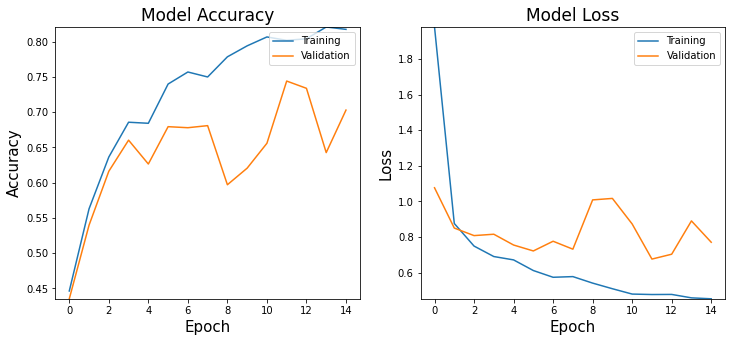

In [26]:
ThreeLayerVGG.plot_performance()

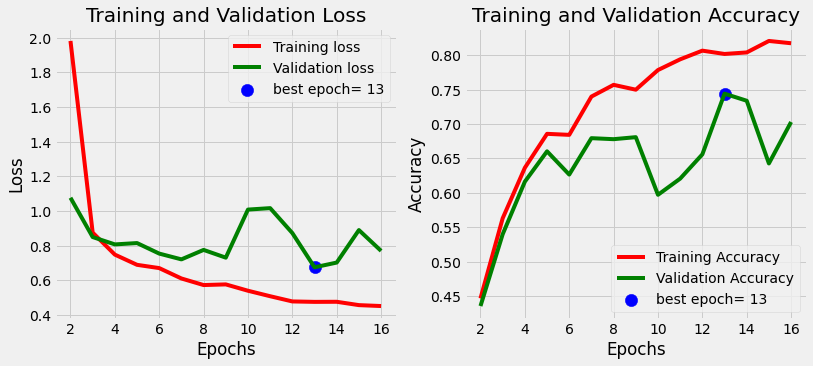

In [27]:
ThreeLayerVGG.tr_plot(history3,1)

In [28]:
OneLayerVGG.evaluate_model()

 1/22 [>.............................] - ETA: 0s - loss: 0.7023 - accuracy: 0.7188

 5/22 [=====>........................] - ETA: 0s - loss: 0.7820 - accuracy: 0.6625

 9/22 [===========>..................] - ETA: 0s - loss: 0.7681 - accuracy: 0.6840

13/22 [================>.............] - ETA: 0s - loss: 0.7514 - accuracy: 0.7067

17/22 [======================>.......] - ETA: 0s - loss: 0.7303 - accuracy: 0.7096

21/22 [===========================>..] - ETA: 0s - loss: 0.7252 - accuracy: 0.7083

22/22 [==============================] - 0s 13ms/step - loss: 0.7199 - accuracy: 0.7118



Test Data Results
------------------
Test Loss: 71.99%
Test Accuracy: 71.18%


(0.7198507785797119, 0.7117646932601929)

In [29]:
TwoLayerVGG.evaluate_model()

 1/22 [>.............................] - ETA: 1s - loss: 0.6806 - accuracy: 0.7188

 3/22 [===>..........................] - ETA: 0s - loss: 0.7100 - accuracy: 0.6979

 4/22 [====>.........................] - ETA: 0s - loss: 0.7551 - accuracy: 0.6562

 5/22 [=====>........................] - ETA: 0s - loss: 0.6956 - accuracy: 0.6750

 6/22 [=======>......................] - ETA: 0s - loss: 0.6895 - accuracy: 0.6719

 7/22 [========>.....................] - ETA: 0s - loss: 0.7340 - accuracy: 0.6741

 8/22 [=========>....................] - ETA: 0s - loss: 0.7579 - accuracy: 0.6562

 9/22 [===========>..................] - ETA: 0s - loss: 0.7377 - accuracy: 0.6701

10/22 [============>.................] - ETA: 0s - loss: 0.7320 - accuracy: 0.6812

11/22 [==============>...............] - ETA: 0s - loss: 0.7312 - accuracy: 0.6875

12/22 [===============>..............] - ETA: 0s - loss: 0.7186 - accuracy: 0.6953

13/22 [================>.............] - ETA: 0s - loss: 0.7275 - accuracy: 0.6899

14/22 [==================>...........] - ETA: 0s - loss: 0.7102 - accuracy: 0.6987

15/22 [===================>..........] - ETA: 0s - loss: 0.7035 - accuracy: 0.7021

16/22 [====================>.........] - ETA: 0s - loss: 0.7066 - accuracy: 0.6973

17/22 [======================>.......] - ETA: 0s - loss: 0.7014 - accuracy: 0.6949

18/22 [=======================>......] - ETA: 0s - loss: 0.6944 - accuracy: 0.6927

19/22 [========================>.....] - ETA: 0s - loss: 0.6966 - accuracy: 0.6908

20/22 [==========================>...] - ETA: 0s - loss: 0.6988 - accuracy: 0.6906

21/22 [===========================>..] - ETA: 0s - loss: 0.7018 - accuracy: 0.6920

22/22 [==============================] - 1s 49ms/step - loss: 0.6982 - accuracy: 0.6941



Test Data Results
------------------
Test Loss: 69.82%
Test Accuracy: 69.41%


(0.698196530342102, 0.6941176652908325)

# Three Block VGG Model 

In [30]:
ThreeLayerVGG.evaluate_model()

 1/22 [>.............................] - ETA: 3s - loss: 0.7882 - accuracy: 0.7812

 2/22 [=>............................] - ETA: 2s - loss: 0.7901 - accuracy: 0.7344

 3/22 [===>..........................] - ETA: 2s - loss: 0.8486 - accuracy: 0.6875

 4/22 [====>.........................] - ETA: 2s - loss: 0.9106 - accuracy: 0.6641

 5/22 [=====>........................] - ETA: 1s - loss: 0.8554 - accuracy: 0.6750

 6/22 [=======>......................] - ETA: 1s - loss: 0.8431 - accuracy: 0.6823

 7/22 [========>.....................] - ETA: 1s - loss: 0.8704 - accuracy: 0.6875

 8/22 [=========>....................] - ETA: 1s - loss: 0.8809 - accuracy: 0.6797

 9/22 [===========>..................] - ETA: 1s - loss: 0.8448 - accuracy: 0.6944

10/22 [============>.................] - ETA: 1s - loss: 0.8399 - accuracy: 0.6969

11/22 [==============>...............] - ETA: 1s - loss: 0.8353 - accuracy: 0.6960

12/22 [===============>..............] - ETA: 1s - loss: 0.8093 - accuracy: 0.7031

13/22 [================>.............] - ETA: 1s - loss: 0.8175 - accuracy: 0.7043

14/22 [==================>...........] - ETA: 0s - loss: 0.7947 - accuracy: 0.7098

15/22 [===================>..........] - ETA: 0s - loss: 0.7920 - accuracy: 0.7083

16/22 [====================>.........] - ETA: 0s - loss: 0.7958 - accuracy: 0.7012

17/22 [======================>.......] - ETA: 0s - loss: 0.7816 - accuracy: 0.7040

18/22 [=======================>......] - ETA: 0s - loss: 0.7648 - accuracy: 0.7066

19/22 [========================>.....] - ETA: 0s - loss: 0.7717 - accuracy: 0.7023

20/22 [==========================>...] - ETA: 0s - loss: 0.7675 - accuracy: 0.7047

21/22 [===========================>..] - ETA: 0s - loss: 0.7745 - accuracy: 0.7024

22/22 [==============================] - 2s 108ms/step - loss: 0.7706 - accuracy: 0.7029



Test Data Results
------------------
Test Loss: 77.06%
Test Accuracy: 70.29%


(0.77056884765625, 0.7029411792755127)

In [31]:
results = pd.DataFrame(columns=['Model_Name','Accuracy','F1Score','Precision','Recall'])
results['Model_Name'] = results_modelname
results['Accuracy'] = results_accuracy
results['Precision'] = results_precision
results['Recall'] = results_recall
results['F1Score'] = results_f1 
print(results.sort_values('Accuracy', ascending=False))

      Model_Name  Accuracy   F1Score  Precision    Recall
0    OneLayerVGG  0.711765  0.717320   0.753752  0.711765
2  ThreeLayerVGG  0.702941  0.703659   0.824007  0.702941
1    TwoLayerVGG  0.694118  0.690919   0.765103  0.694118


In [32]:
def barchart_h(df, col_x, col_y):
    '''Plots a barchart comparing a metric between different models '''
    def set_size(w,h, ax=None):
        """ w, h: width, height in inches """
        if not ax: ax=plt.gca()
        l = ax.figure.subplotpars.left
        r = ax.figure.subplotpars.right
        t = ax.figure.subplotpars.top
        b = ax.figure.subplotpars.bottom
        figw = float(w)/(r-l)
        figh = float(h)/(t-b)
        ax.figure.set_size_inches(figw, figh)
    chart_data = df.groupby(col_x)[col_y].max().sort_values()
    # print(a)
    fig, ax = plt.subplots()  
    chart_data.plot.barh()
    ax.bar_label(ax.containers[0])
    set_size(5,5)
    # Add title and axis names
    plt.title(str(col_y))
    # plt.ylabel(str(col_x))
    plt.show()

plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

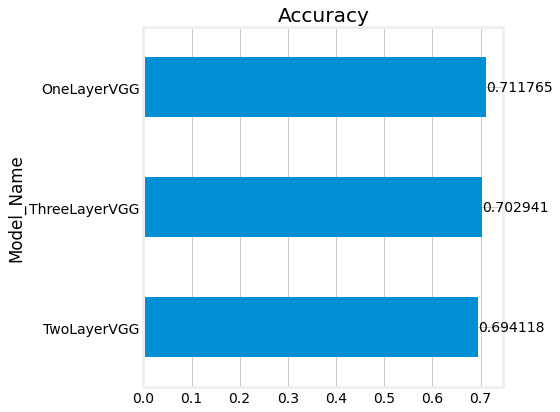

In [33]:
barchart_h(results,'Model_Name', 'Accuracy')

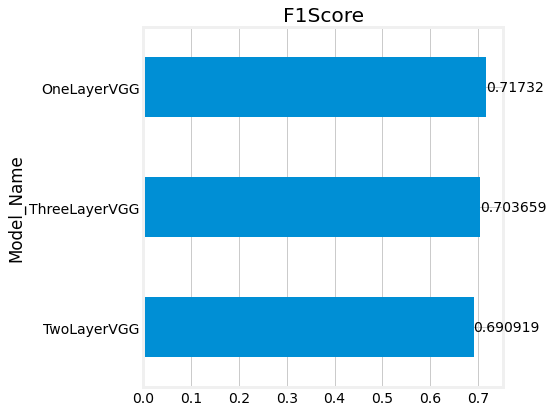

In [34]:
barchart_h(results,'Model_Name', 'F1Score')

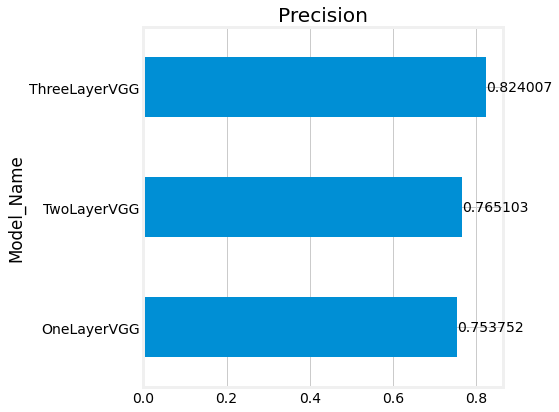

In [35]:
barchart_h(results,'Model_Name', 'Precision')

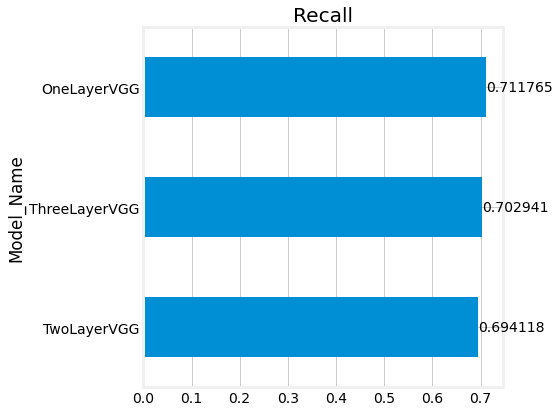

In [36]:
barchart_h(results,'Model_Name', 'Recall')

# ------------------------------------------------------------------

In [43]:
OneLayerVGG.save_model('BestModel_AshayDeochand')

Saved model to disk


In [38]:
from tensorflow.keras.models import load_model

# load model
loaded_model = load_model('SavedModelFile.h5')

# ---------- Load Saved model and make a prediction ----------------------

In [39]:
#'d' is the path of the image
d=os.path.join(cur_dir, 'DSC_0092.JPG')
img = cv2.imread(d)
 
print('Original Dimensions : ',img.shape)


Original Dimensions :  (600, 800, 3)


In [40]:
width = 50
height = 50
dim = (width, height)

# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
print('Resized Dimensions : ',resized.shape)
my_image = resized


Resized Dimensions :  (50, 50, 3)


In [41]:
#reshaping the image to make it compatible for the argument of predict function
my_image=my_image.reshape(-1,IMAGE_WIDTH,IMAGE_HEIGHT,3)
print('Resized Dimensions : ',my_image.shape)

Resized Dimensions :  (1, 50, 50, 3)


In [42]:
predictions = np.argmax(loaded_model.predict(my_image), axis=-1)
print(predictions)
print(CLASS_NAMES[predictions[0]])


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 70ms/step


[2]
olive_peacock_spot
